#Master Ciencia de Datos
##Llenando de datos faltantes en estaciones meterológicas en Nuevo León
Joaquín Fernández Merino

#exportar a html

In [161]:
!pip install nbconvert


In [162]:
!jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/Tesis.ipynb"


[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Tesis.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 77 image(s).
[NbConvertApp] Writing 9759495 bytes to /content/drive/MyDrive/Colab Notebooks/Tesis.html


#Librerias

In [5]:
import pandas as pd
import re
import os
import glob
import io
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#Lectura de datos


In [6]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
# --- Paso 1A: listar archivos .txt ---

folder = "/content/drive/MyDrive/Datos"


txt_files = sorted(glob.glob(os.path.join(folder, "*.txt")))
print(f"Encontrados {len(txt_files)} archivos .txt")
for f in txt_files[:21]:
    print(" -", os.path.basename(f))


Encontrados 21 archivos .txt
 - agua_blanca.txt
 - apodaca.txt
 - cadereyta.txt
 - chupaderos_del_indio.txt
 - el_canada.txt
 - el_cerrito.txt
 - el_hojase.txt
 - el_pajonal.txt
 - grutas_de_garcia.txt
 - icamole.txt
 - la_boca.txt
 - la_cienega.txt
 - la_huastequita.txt
 - laguna_de_sanchez.txt
 - mamulique.txt
 - monterrey_obs.txt
 - palmitos_ge.txt
 - salinas_victoria.txt
 - san_bartolo.txt
 - san_juan.txt
 - tepehuaje.txt


In [8]:
# --- Paso 2: parsear metadatos de cada archivo y crear stations_df
# esta base de datos tiene las estaciones y su info---latitud, longitud, status, etc


# Patrones de encabezado típicos de los TXT de BDCN/CONAGUA
HEADER_PAT = {
    "clave":     re.compile(r"ESTACIÓN\s*:\s*(\d+)", re.I),
    "nombre":    re.compile(r"NOMBRE\s*:\s*(.+)", re.I),
    "estado":    re.compile(r"ESTADO\s*:\s*(.+)", re.I),
    "municipio": re.compile(r"MUNICIPIO\s*:\s*(.+)", re.I),
    "situacion": re.compile(r"SITUACIÓN\s*:\s*(.+)", re.I),
    "cve_omm":   re.compile(r"CVE-OMM\s*:\s*(\d+)", re.I),
    "lat":       re.compile(r"LATITUD\s*:\s*([-+]?\d+(?:\.\d+)?)", re.I),
    "lon":       re.compile(r"LONGITUD\s*:\s*([-+]?\d+(?:\.\d+)?)", re.I),
    "alt":       re.compile(r"ALTITUD\s*:\s*([\d\.]+)\s*msnm", re.I),
    "emision":   re.compile(r"EMISIÓN\s*:\s*(\d{2}/\d{2}/\d{4})", re.I),
}

def extract_meta_from_file(path):
    """Lee SOLO el encabezado y devuelve dict de metadatos."""
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        raw = f.read()

    meta = {"source_file": os.path.basename(path)}
    for k, pat in HEADER_PAT.items():
        m = pat.search(raw)
        if m:
            meta[k] = m.group(1).strip()

    # Si no viene clave en encabezado, intentar inferirla del nombre del archivo
    if not meta.get("clave"):
        mfn = re.search(r"(\d{5})", os.path.basename(path))
        if mfn:
            meta["clave"] = mfn.group(1)

    # Tipos
    if meta.get("clave"):
        try:
            meta["clave"] = int(meta["clave"])
        except Exception:
            meta["clave"] = pd.NA

    for k in ("lat", "lon", "alt"):
        if meta.get(k) is not None:
            meta[k] = pd.to_numeric(meta.get(k), errors="coerce")

    return meta

# Ejecutar extracción en todos los archivos .txt
meta_rows = []
for p in txt_files:
    try:
        meta = extract_meta_from_file(p)
        meta_rows.append({
            "Clave": meta.get("clave", pd.NA),
            "Nombre Estación": meta.get("nombre"),
            "Municipio": meta.get("municipio"),
            "Situación": meta.get("situacion"),
            "cve_omm": meta.get("cve_omm"),
            "lat": meta.get("lat"),
            "lon": meta.get("lon"),
            "alt_m": meta.get("alt"),
            "fecha_meta": meta.get("emision"),
            "fuente_meta": meta.get("source_file"),  # trazabilidad
        })
    except Exception as e:
        print(f"[ADVERTENCIA] {os.path.basename(p)} -> {e}")

stations_df = pd.DataFrame(meta_rows)

# Normalización final
stations_df = (stations_df
               .drop_duplicates(subset=["Clave"], keep="first")
               .astype({"Clave":"Int64"}))

# Orden de columnas estandar
stations_df = stations_df[[
    "Clave","Nombre Estación","Municipio","Situación",
    "cve_omm","lat","lon","alt_m","fecha_meta","fuente_meta"
]]

# --- chequeos rápidos de rango (QA/QC A.1) ---
def flag_range_issues(df):
    df = df.copy()
    # Chequeos geométricos (definición del sistema de coordenadas geográficas)
    df["flag_lat_out"] = ~df["lat"].between(-90, 90, inclusive="both")
    df["flag_lon_out"] = ~df["lon"].between(-180, 180, inclusive="both")
    # Completitud / tipo
    df["flag_lat_nan"] = df["lat"].isna()
    df["flag_lon_nan"] = df["lon"].isna()
    df["flag_alt_nan"] = df["alt_m"].isna()
    # Nota: no imponemos umbral de altitud hasta definir criterio respaldado
    # TODO: comparar alt_m con DEM/registros oficiales y fijar tolerancias documentadas
    return df

stations_qc = flag_range_issues(stations_df)

issues = stations_qc.query("flag_lat_out or flag_lon_out or flag_lat_nan or flag_lon_nan or flag_alt_nan")
if not issues.empty:
    print("\n[QA/QC] Posibles problemas en metadatos:")
    display(issues[["Clave","Nombre Estación","lat","lon","alt_m",
                    "flag_lat_out","flag_lon_out","flag_lat_nan","flag_lon_nan","flag_alt_nan"]])
else:
    print("\n[QA/QC] Lat/Lon válidos y metadatos completos (altitud puede estar pendiente).")




[QA/QC] Lat/Lon válidos y metadatos completos (altitud puede estar pendiente).


In [9]:
print(stations_df      )

    Clave       Nombre Estación                 Municipio Situación cve_omm  \
0   19002           AGUA BLANCA            SANTA CATARINA  OPERANDO    None   
1   19004               APODACA                   APODACA  OPERANDO    None   
2   19008             CADEREYTA         CADEREYTA JIMÉNEZ  OPERANDO    None   
3   19165  CHUPADEROS DEL INDIO                    GARCÍA  OPERANDO    None   
4   19185             EL CANADA          GENERAL ESCOBEDO  OPERANDO    None   
5   19015            EL CERRITO                  SANTIAGO  OPERANDO    None   
6   19170             EL HOJASE          SALINAS VICTORIA  OPERANDO    None   
7   19018            EL PAJONAL            SANTA CATARINA  OPERANDO    None   
8   19123      GRUTAS DE GARCIA                    GARCÍA  OPERANDO    None   
9   19026               ICAMOLE                    GARCÍA  OPERANDO    None   
10  19069               LA BOCA                  SANTIAGO  OPERANDO    None   
11  19200            LA CIENEGA                    J

In [10]:
# ===== carga de archivos =====


DATE_PAT = re.compile(r"^\s*\d{4}[-/]\d{2}[-/]\d{2}\b", re.ASCII)

def parse_timeseries_table_robust(raw_text):
    """Intenta extraer la tabla diaria desde un TXT con varias estrategias."""
    lines = raw_text.splitlines()

    # 1) Buscar la línea de encabezado que contenga 'FECHA' (cualquier caso)
    header_idx = None
    for i, l in enumerate(lines):
        if "FECHA" in l.upper():
            header_idx = i
            break

    # 2) Buscar la primera línea de datos (que empiece con fecha)
    first_row_idx = None
    for i in range((header_idx+1) if header_idx is not None else 0, len(lines)):
        if DATE_PAT.search(lines[i]):
            first_row_idx = i
            break

    if first_row_idx is None:
        raise ValueError("No se encontraron filas de datos (no hay línea que inicie con fecha).")

    # Determinar columnas
    if header_idx is not None:
        # Usar la línea de encabezado como nombres
        cols_line = re.sub(r"\s+", " ", lines[header_idx].strip())
        cols = cols_line.split()
    else:
        # Sin encabezado visible: asumir nombres genéricos y corregir luego
        # Detectar cuántas columnas hay separadas por espacio en la primera fila de datos
        sample_cols = re.sub(r"\s+", " ", lines[first_row_idx].strip()).split()
        n = len(sample_cols)
        # nombres tentativos
        cols = ["FECHA"] + [f"COL{i}" for i in range(2, n+1)]

    data_text = "\n".join(lines[first_row_idx:])

    # --- Estrategia A: separación por espacios
    try:
        df = pd.read_csv(io.StringIO(data_text), sep=r"\s+", engine="python", names=cols, dtype=str)
        ok_A = True
    except Exception:
        ok_A = False
        df = None

    # --- Estrategia B: ancho fijo (fwf) si A falla o crea columnas inconsistentes
    if (not ok_A) or ("FECHA" not in (df.columns if df is not None else [])):
        df = pd.read_fwf(io.StringIO(data_text), names=cols, dtype=str)
        if "FECHA" not in df.columns:
            # fuerza primera columna como FECHA
            df.rename(columns={df.columns[0]: "FECHA"}, inplace=True)

    # Normalización
    df.columns = [c.upper() for c in df.columns]
    # Limpiar filas vacías
    df = df.dropna(how="all").copy()

    # FECHA a datetime
    if "FECHA" not in df.columns:
        raise ValueError("La tabla no contiene columna FECHA.")
    df["FECHA"] = pd.to_datetime(df["FECHA"], errors="coerce")
    df = df[df["FECHA"].notna()].copy()

    # Renombrar columnas típicas si aparecen variantes
    rename_map = {"PRCP":"PRECIP", "PP":"PRECIP", "PRECIPITACION":"PRECIP",
                  "TX":"TMAX", "TN":"TMIN"}
    for k, v in rename_map.items():
        if k in df.columns and v not in df.columns:
            df.rename(columns={k: v}, inplace=True)

    # Convertir a numérico lo que no sea FECHA
    for c in df.columns:
        if c == "FECHA":
            continue
        df[c] = pd.to_numeric(df[c].replace({"NULO": np.nan, "NA": np.nan, "": np.nan, "-": np.nan}),
                              errors="coerce")

    return df

# --- Reconstruir índice Clave -> ruta si hace falta ---
if 'file_index' not in globals() or not file_index:
    file_index = {}
    for p in txt_files:
        try:
            with open(p, "r", encoding="utf-8", errors="ignore") as f:
                raw = f.read()
            m = re.search(r"ESTACIÓN\s*:\s*(\d+)", raw, re.I)
            clave = int(m.group(1)) if m else None
            if not clave:
                m2 = re.search(r"(\d{5})", os.path.basename(p))
                if m2: clave = int(m2.group(1))
            if clave:
                file_index[clave] = p
        except Exception as e:
            print(f"[ADVERTENCIA] {os.path.basename(p)} -> {e}")

print(f"Índice de archivos: {len(file_index)} estaciones.")

# --- Cargar todas las series con diagnóstico de errores ---
all_records, errores = [], []

for clave, path in file_index.items():
    try:
        with open(path, "r", encoding="utf-8", errors="ignore") as f:
            raw = f.read()
        df = parse_timeseries_table_robust(raw)
        df["Clave"] = int(clave)
        all_records.append(df)
    except Exception as e:
        errores.append((clave, os.path.basename(path), str(e)))

if not all_records:
    print("[ERROR] No se pudo parsear ninguna serie.")
    if errores:
        print("Primeros errores:")
        for item in errores[:5]:
            print("  - Clave", item[0], "|", item[1], "->", item[2])
    raise RuntimeError("No se pudo cargar ninguna serie de tiempo.")

records_df_all = pd.concat(all_records, ignore_index=True, sort=False)
records_df_all["Clave"] = records_df_all["Clave"].astype("Int64")
records_df_all = records_df_all.drop_duplicates(subset=["Clave","FECHA"]).sort_values(["Clave","FECHA"])

print(f"Series cargadas: {len(all_records)}  |  Registros totales: {len(records_df_all):,}")
if errores:
    print(f"Archivos con error: {len(errores)} (muestra 5):")
    for item in errores[:5]:
        print("  - Clave", item[0], "|", item[1], "->", item[2])

# Resumen rápido
resumen = (
    records_df_all.groupby("Clave", as_index=False)
    .agg(fecha_min=("FECHA","min"), fecha_max=("FECHA","max"), n_obs=("FECHA","count"))
    .sort_values("Clave")
)
display(resumen.head(21))


Índice de archivos: 21 estaciones.


/tmp/ipython-input-706742909.py:79: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[c] = pd.to_numeric(df[c].replace({"NULO": np.nan, "NA": np.nan, "": np.nan, "-": np.nan}),
/tmp/ipython-input-706742909.py:79: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[c] = pd.to_numeric(df[c].replace({"NULO": np.nan, "NA": np.nan, "": np.nan, "-": np.nan}),


Series cargadas: 21  |  Registros totales: 363,223


Clave  fecha_min  fecha_max  n_obs
0   19002 1957-05-01 2023-12-31  18439
1   19004 1964-02-17 2024-05-31  17203
2   19008 1947-04-01 2025-10-15  21484
3   19015 1957-07-15 2025-10-17  21212
4   19018 1954-06-01 2020-12-31  23489
5   19026 1953-07-15 2024-12-31  22852
6   19033 1947-04-01 2023-09-30  26207
7   19044 1968-06-01 2024-09-30  16169
8   19052 1951-01-01 2025-10-16  24669
9   19056 1947-02-01 2023-08-31  25387
10  19069 1972-04-01 2025-10-17  18731
11  19096 1975-11-01 2024-04-30  16723
12  19123 1980-05-01 2024-05-31  10617
13  19134 1979-04-24 2024-12-31  15733
14  19140 1980-01-01 2020-12-31  13273
15  19165 1982-02-01 2022-09-30  12850
16  19170 1982-03-01 2022-09-30  13572
17  19173 1982-02-01 2024-12-31  14268
18  19174 1982-04-01 2024-12-31  13440
19  19185 1997-09-01 2025-06-19   8480
20  19200 1997-06-01 2024-05-31   8425

#QC

##A2 Estandarización temporal/unidades

In [11]:
# =====  A.2: Estandarizar nombres, reindexar calendario, Nulo- se vuelve Nan ' =====
df = records_df_all.copy()

# 1) Normalizar nombres
df.columns = [c.upper() for c in df.columns]
rename_map = {"PRCP":"PRECIP", "PP":"PRECIP", "TX":"TMAX", "TN":"TMIN"}
df.rename(columns={k:v for k,v in rename_map.items() if k in df.columns}, inplace=True)

# --- NUEVO: detectar la llave y renombrarla a 'Clave'
keycol = "CLAVE" if "CLAVE" in df.columns else ("Clave" if "Clave" in df.columns else None)
if keycol is None:
    raise KeyError("No se encontró columna de clave de estación ('CLAVE' o 'Clave').")
df.rename(columns={keycol: "Clave"}, inplace=True)

# 2) Tipos y NA uniformes
import numpy as np, pandas as pd
na_like = {"NULO": np.nan, "NA": np.nan, "": np.nan, "-": np.nan}
df.replace(na_like, inplace=True)
df["FECHA"] = pd.to_datetime(df["FECHA"], errors="coerce")
for c in [col for col in ["PRECIP","EVAP","TMAX","TMIN"] if col in df.columns]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df["Clave"] = df["Clave"].astype("Int64")

# 3) Reindex diario por estación
std_blocks, qc_logs = [], []
for clave, g in df.groupby("Clave", dropna=True):
    g = g.sort_values("FECHA").drop_duplicates(subset=["FECHA"])
    start, end = g["FECHA"].min().normalize(), g["FECHA"].max().normalize()
    idx = pd.date_range(start, end, freq="D")
    g2 = (g.set_index("FECHA").reindex(idx).rename_axis("FECHA").reset_index())
    g2["Clave"] = int(clave)

    qc_logs.append({
        "Clave": int(clave),
        "fecha_min": start.date(),
        "fecha_max": end.date(),
        "n_rows_before": len(g),
        "n_rows_after": len(g2),
        "miss_PRECIP": g2["PRECIP"].isna().sum() if "PRECIP" in g2.columns else np.nan,
        "miss_EVAP":   g2["EVAP"].isna().sum()   if "EVAP"   in g2.columns else np.nan,
        "miss_TMAX":   g2["TMAX"].isna().sum()   if "TMAX"   in g2.columns else np.nan,
        "miss_TMIN":   g2["TMIN"].isna().sum()   if "TMIN"   in g2.columns else np.nan,
    })
    std_blocks.append(g2)

records_std = pd.concat(std_blocks, ignore_index=True)
qc_log_df = pd.DataFrame(qc_logs).sort_values("Clave").reset_index(drop=True)

print("A.2 completado para todas las estaciones. Dim:", records_std.shape)
display(qc_log_df.head(10))


A.2 completado para todas las estaciones. Dim: (420244, 6)


Clave   fecha_min   fecha_max  n_rows_before  n_rows_after  miss_PRECIP  \
0  19002  1957-05-01  2023-12-31          18439         24351         6119   
1  19004  1964-02-17  2024-05-31          17203         22020         4860   
2  19008  1947-04-01  2025-10-15          21484         28688         7640   
3  19015  1957-07-15  2025-10-17          21212         24932         3934   
4  19018  1954-06-01  2020-12-31          23489         24321         1002   
5  19026  1953-07-15  2024-12-31          22852         26103         3354   
6  19033  1947-04-01  2023-09-30          26207         27942         1766   
7  19044  1968-06-01  2024-09-30          16169         20576         4564   
8  19052  1951-01-01  2025-10-16          24669         27318         2819   
9  19056  1947-02-01  2023-08-31          25387         27971         2683   

   miss_EVAP  miss_TMAX  miss_TMIN  
0      13797      11073      11073  
1      22020       4902       4902  
2      20215      19500      19500  
3      13004       9574       9574  
4      20952       2888       2888  
5       9591       3690       3690  
6      19717       5711       5711  
7      14587       4649       4649  
8      18757       3714       3714  
9      11228       4139       4139

##A.3 Valores imposibles

In [12]:
# ===== A.3 — Valores imposibles y banderas de QC (diario, todas las estaciones) =====
import pandas as pd
import numpy as np

df = records_std.copy()  # viene de A.2 (calendario continuo por estación)

# Asegurar columnas esperadas si existen en tus archivos
cols_present = set(df.columns)
has_precip = "PRECIP" in cols_present
has_evap   = "EVAP"   in cols_present
has_tmax   = "TMAX"   in cols_present
has_tmin   = "TMIN"   in cols_present

# 1) Banderas de imposibilidad / inconsistencia
df["flag_fecha_nan"] = df["FECHA"].isna()

if has_precip:
    df["flag_neg_precip"] = df["PRECIP"] < 0
else:
    df["flag_neg_precip"] = False

if has_evap:
    df["flag_neg_evap"] = df["EVAP"] < 0
else:
    df["flag_neg_evap"] = False

if has_tmax and has_tmin:
    # TMIN > TMAX es inconsistente
    df["flag_tswap"] = (df["TMIN"].notna() & df["TMAX"].notna()) & (df["TMIN"] > df["TMAX"])
else:
    df["flag_tswap"] = False

# 2) Bandera compuesta
flag_cols = ["flag_fecha_nan","flag_neg_precip","flag_neg_evap","flag_tswap"]
df["qc_fail_any"] = df[flag_cols].any(axis=1)

# 3) Resumen por estación (conteo de banderas)
summary_cols = {
    "n_rows": ("FECHA","count"),
    "n_fail_any": ("qc_fail_any", "sum"),
    "n_neg_precip": ("flag_neg_precip", "sum"),
    "n_neg_evap": ("flag_neg_evap", "sum"),
    "n_tswap": ("flag_tswap", "sum"),
    "n_fecha_nan": ("flag_fecha_nan","sum"),
}

res_a3 = df.groupby("Clave").agg(**summary_cols).reset_index()

# 4) (Opcional) Vista de los registros con fallas para inspección puntual
fails_preview = df.loc[df["qc_fail_any"]].sort_values(["Clave","FECHA"]).head(20)

print("A.3 completado.")
print("Dimensiones con QC flags:", df.shape)
display(res_a3.head(21))
display(fails_preview)


A.3 completado.
Dimensiones con QC flags: (420244, 11)


Clave  n_rows  n_fail_any  n_neg_precip  n_neg_evap  n_tswap  n_fecha_nan
0   19002   24351           0             0           0        0            0
1   19004   22020           0             0           0        0            0
2   19008   28688           0             0           0        0            0
3   19015   24932           0             0           0        0            0
4   19018   24321           0             0           0        0            0
5   19026   26103           0             0           0        0            0
6   19033   27942           0             0           0        0            0
7   19044   20576           0             0           0        0            0
8   19052   27318           0             0           0        0            0
9   19056   27971           0             0           0        0            0
10  19069   19558           0             0           0        0            0
11  19096   17714           0             0           0        0            0
12  19123   16102           0             0           0        0            0
13  19134   16689           0             0           0        0            0
14  19140   14976           0             0           0        0            0
15  19165   14852           0             0           0        0            0
16  19170   14824           0             0           0        0            0
17  19173   15675           0             0           0        0            0
18  19174   15616           0             0           0        0            0
19  19185   10154           0             0           0        0            0
20  19200    9862           0             0           0        0            0

Empty DataFrame
Columns: [FECHA, PRECIP, EVAP, TMAX, TMIN, Clave, flag_fecha_nan, flag_neg_precip, flag_neg_evap, flag_tswap, qc_fail_any]
Index: []

No se encontraron valores imposibles de acuerdo a los criterios establecidos dentro de las bases de datos.

##A.4 Outliers





In [13]:
# ===== A.4 — Flagging de outliers por estación y por mes (IQR robusto) =====
import pandas as pd
import numpy as np

def flag_outliers_by_station_month(df_in, k_iqr=3.5, min_n=8):
    """
    Crea banderas de outlier por estación (Clave) y por mes.
    - PRECIP: low=0; high = max(Q3 + k*IQR, p99.9) por (Clave, MES).
    - EVAP, TMAX, TMIN: low=Q1 - k*IQR; high=Q3 + k*IQR por (Clave, MES).
    - No se flaggea en grupos con < min_n datos válidos.
    Devuelve: df_out, resumen_out, preview_out
    """
    df = df_in.copy()
    if "FECHA" not in df.columns or "Clave" not in df.columns:
        raise KeyError("Se requieren columnas 'FECHA' y 'Clave'.")
    vars_present = [v for v in ["PRECIP","EVAP","TMAX","TMIN"] if v in df.columns]

    # Extraer mes para estacionalidad
    df["MES"] = df["FECHA"].dt.month

    # Inicializa banderas
    for v in vars_present:
        df[f"flag_out_{v.lower()}"] = False

    # Helpers
    def iqr_bounds(s, k=k_iqr):
        s = s.dropna()
        if s.empty:
            return (np.nan, np.nan)
        q1 = s.quantile(0.25)
        q3 = s.quantile(0.75)
        iqr = q3 - q1
        return (q1 - k*iqr, q3 + k*iqr)

    # Conteo válido por grupo (Clave, MES) y variable
    valid_counts = {}
    for v in vars_present:
        valid_counts[v] = df.groupby(["Clave","MES"])[v].transform(lambda x: x.notna().sum())

    # Calcular límites y marcar
    for v in vars_present:
        # Límites IQR por grupo
        low_iqr = df.groupby(["Clave","MES"])[v].transform(lambda s: iqr_bounds(s)[0])
        high_iqr = df.groupby(["Clave","MES"])[v].transform(lambda s: iqr_bounds(s)[1])

        # Ajuste especial para PRECIP: low=0; high = max(high_iqr, p99.9)
        if v == "PRECIP":
            p999 = df.groupby(["Clave","MES"])[v].transform(
                lambda s: s.quantile(0.999) if s.notna().sum() >= min_n else np.nan
            )
            low = 0
            high = np.fmax(high_iqr, p999.fillna(high_iqr))
        else:
            low, high = low_iqr, high_iqr

        enough = valid_counts[v] >= min_n
        cond = df[v].notna() & enough & ((df[v] < low) | (df[v] > high))
        df.loc[cond, f"flag_out_{v.lower()}"] = True

    # Bandera compuesta
    out_cols = [c for c in df.columns if c.startswith("flag_out_")]
    df["flag_outlier_any"] = df[out_cols].any(axis=1)

    # Resumen por estación
    agg = {"flag_outlier_any":"sum"}
    for v in vars_present:
        agg[f"flag_out_{v.lower()}"] = "sum"
    res = (df.groupby("Clave")[["flag_outlier_any"] + [f"flag_out_{v.lower()}" for v in vars_present]]
             .agg(agg).reset_index())

    # Vista previa de registros marcados
    preview = df.loc[df["flag_outlier_any"]].sort_values(["Clave","FECHA"]).head(30)

    # Limpieza
    df.drop(columns=["MES"], inplace=True)

    return df, res, preview

# === Ejecutar sobre el DataFrame estandarizado (de A.2): records_std ===
records_a4, res_a4, preview_a4 = flag_outliers_by_station_month(records_std, k_iqr=3.5, min_n=8)

print("A.4 flagging completado.")
display(res_a4.head(21))
display(preview_a4)


A.4 flagging completado.


Clave  flag_outlier_any  flag_out_precip  flag_out_evap  flag_out_tmax  \
0   19002                42               23              4              0   
1   19004                28               24              0              4   
2   19008                39               24              0              0   
3   19015                44               24             11              1   
4   19018                26               26              0              0   
5   19026                30               23              1              1   
6   19033                38               36              2              0   
7   19044                42               24              5              0   
8   19052                59               33              2              1   
9   19056                62               34              8              2   
10  19069                48               24             14              0   
11  19096               120               21              6              9   
12  19123                10               10              0              0   
13  19134                32               24              6              0   
14  19140                44               23              1              0   
15  19165                54               22              1              0   
16  19170                26               23              2              0   
17  19173                73               24             15              0   
18  19174                30               23              0              2   
19  19185                12               11              0              1   
20  19200                20               11              0              0   

    flag_out_tmin  
0              15  
1               0  
2              15  
3               8  
4               0  
5               5  
6               0  
7              13  
8              24  
9              18  
10             10  
11             84  
12              0  
13              3  
14             20  
15             31  
16              1  
17             34  
18              5  
19              0  
20              9

FECHA  PRECIP   EVAP  TMAX  TMIN  Clave  MES  flag_out_precip  \
7460  1977-10-03    52.0    NaN   NaN   NaN  19002   10             True   
9770  1984-01-30    52.0   3.80  11.0   5.0  19002    1             True   
10688 1986-08-05     1.0    NaN  31.0  18.0  19002    8            False   
10690 1986-08-07     0.0    NaN  32.0  19.0  19002    8            False   
10693 1986-08-10     0.0    NaN  32.0  18.0  19002    8            False   
10696 1986-08-13     0.0    NaN  32.0  19.0  19002    8            False   
10700 1986-08-17     0.0    NaN  32.0  19.0  19002    8            False   
10701 1986-08-18     0.0    NaN  33.0  18.0  19002    8            False   
10704 1986-08-21     0.0    NaN  30.0  19.0  19002    8            False   
10710 1986-08-27     0.0    NaN  31.0  19.0  19002    8            False   
10714 1986-08-31     0.0    NaN  33.0  22.0  19002    8            False   
10745 1986-10-01     0.0  10.30  39.0  20.0  19002   10            False   
10974 1987-05-18    43.0    NaN  18.0   7.0  19002    5             True   
11460 1988-09-15     1.6  11.80  22.0   5.0  19002    9            False   
13504 1994-04-21    46.5    NaN  21.0   5.0  19002    4             True   
13906 1995-05-28    42.0   1.80  27.0  10.0  19002    5             True   
15455 1999-08-24    70.0   1.15  28.0   9.0  19002    8             True   
15864 2000-10-06    50.0   0.39  20.0   6.0  19002   10             True   
16011 2001-03-02    34.0   0.95  10.0   7.0  19002    3             True   
16568 2002-09-10   135.0   5.95  16.0  11.0  19002    9             True   
16718 2003-02-07    33.0   1.74   9.0   2.0  19002    2             True   
16908 2003-08-16   160.0    NaN  14.0  10.0  19002    8             True   
17612 2005-07-20   250.0    NaN  16.0  10.0  19002    7             True   
17999 2006-08-11     0.0  16.69  27.0   9.0  19002    8            False   
19206 2009-11-30    39.0   2.10  10.0   4.0  19002   11             True   
19270 2010-02-02    30.0   3.25  14.0   2.0  19002    2             True   
19417 2010-06-29    77.0   1.95  24.0  14.0  19002    6             True   
19418 2010-06-30   400.0    NaN  16.0  14.0  19002    6             True   
19419 2010-07-01   210.0    NaN  16.0  12.0  19002    7             True   
19546 2010-11-05     0.0  12.95  17.0  -3.0  19002   11            False   

       flag_out_evap  flag_out_tmax  flag_out_tmin  flag_outlier_any  
7460           False          False          False              True  
9770           False          False          False              True  
10688          False          False           True              True  
10690          False          False           True              True  
10693          False          False           True              True  
10696          False          False           True              True  
10700          False          False           True              True  
10701          False          False           True              True  
10704          False          False           True              True  
10710          False          False           True              True  
10714          False          False           True              True  
10745           True          False          False              True  
10974          False          False          False              True  
11460           True          False          False              True  
13504          False          False          False              True  
13906          False          False          False              True  
15455          False          False          False              True  
15864          False          False          False              True  
16011          False          False          False              True  
16568          False          False          False              True  
16718          False          False          False              True  
16908          False          False          False              True  
17612          False 

A.4 (detección de outliers por estación y mes)

Resumen general:

Se identificaron valores atípicos en todas las estaciones (21).

La cantidad total de observaciones marcadas por estación (flag_outlier_any) varía entre 10 y 120.

La variable con mayor incidencia fue precipitación (PRECIP), seguida por TMIN y casos aislados en EVAP y TMAX.

No se modificaron los datos originales; los flags solo indican observaciones que superan el umbral estadístico local (Q3 + 3.5 × IQR o percentil 99.9 para PRECIP).

Análisis por variable:

PRECIP: se detectaron entre 10 y 36 valores atípicos mensuales por estación; la mayoría corresponden a eventos extremos plausibles (picos en temporada húmeda). Ningún valor negativo fue identificado en A.3.

EVAP: aparecen pocos casos (< 15 por estación); conviene revisar si corresponden a errores de lectura o acumulaciones.

TMAX / TMIN: se marcan algunos picos aislados (especialmente TMIN en estaciones 19056 y 19096); revisar continuidad y posibles errores de sensor o redondeo.

Estaciones con más flags: 19096 (120 outliers, 84 en TMIN) y 19052 (59 outliers, 33 en PRECIP); priorizar revisión visual de estas series.

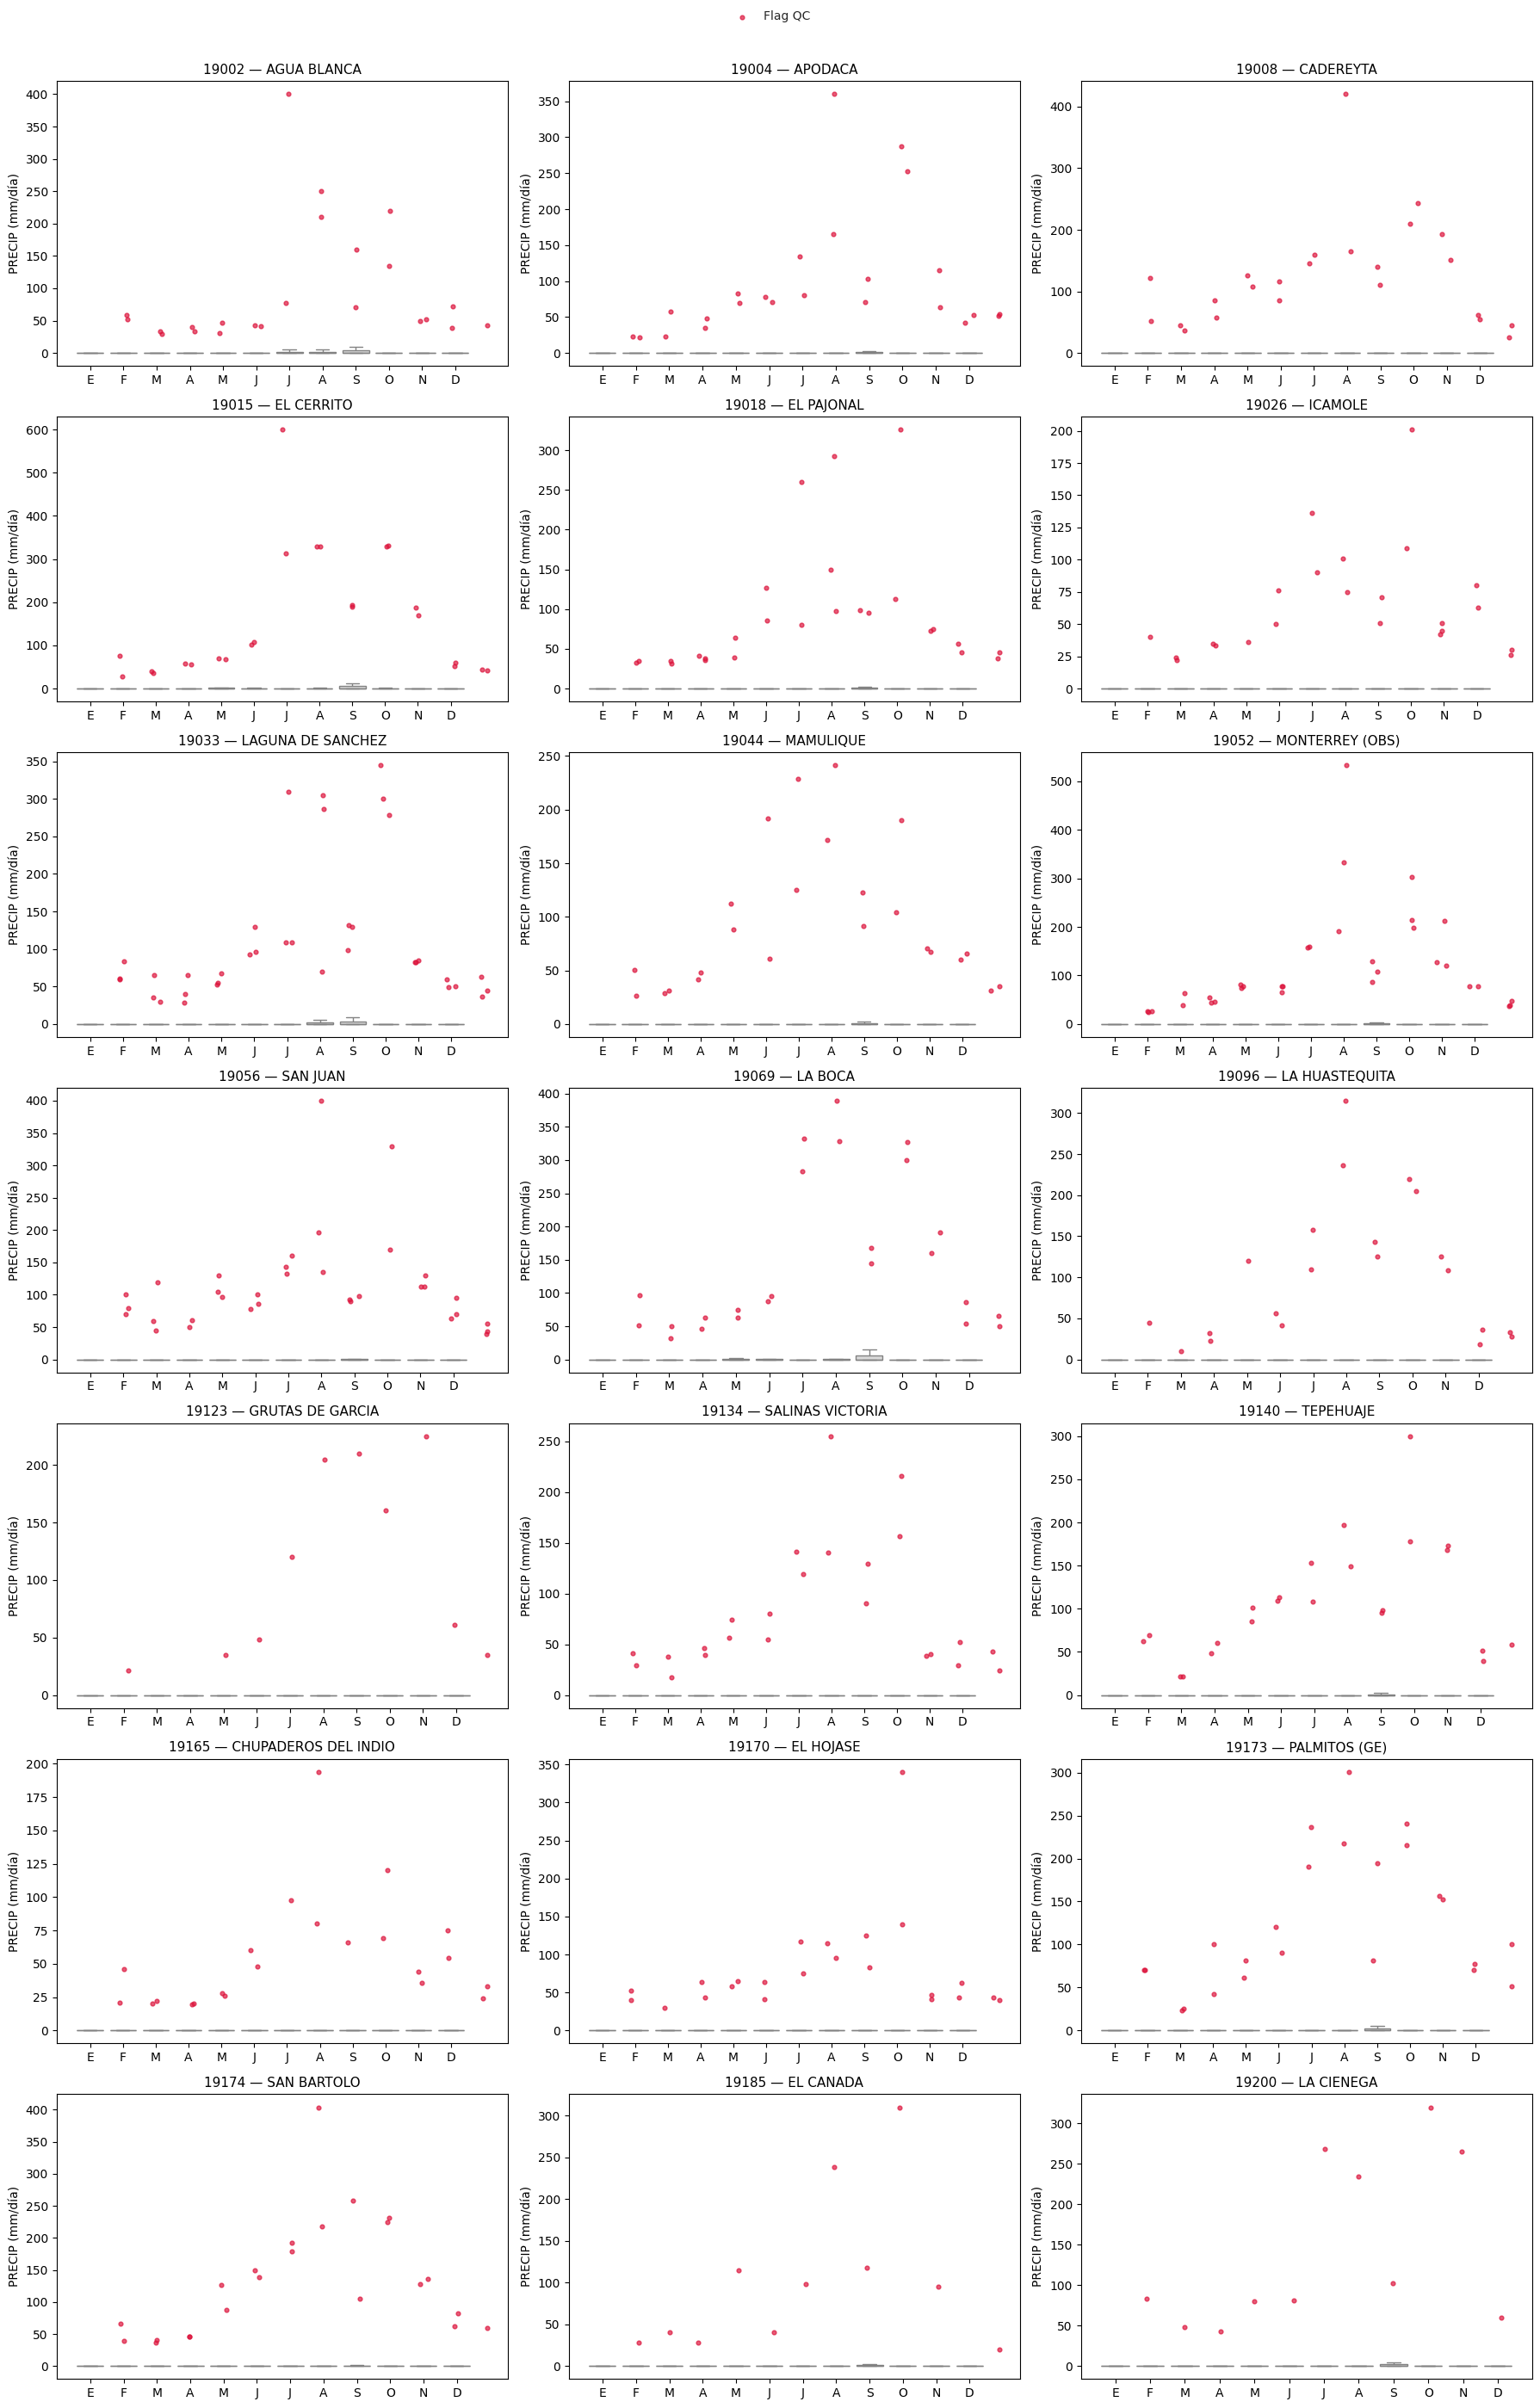

In [14]:
# ===== A.4b — Boxplots mensuales de PRECIP por estación (grid 3x7) =====

df = records_a4.copy()  # viene del flagging A.4
assert "PRECIP" in df.columns, "No existe columna PRECIP."
assert "Clave" in df.columns, "Falta columna Clave."
assert "FECHA" in df.columns, "Falta columna FECHA."

# Mes (1..12) para estacionalidad
df["MES"] = df["FECHA"].dt.month

# Mapeo Clave -> Nombre (si tienes stations_df)
name_map = {}
try:
    name_map = dict(zip(stations_df["Clave"].astype(int), stations_df["Nombre Estación"]))
except Exception:
    pass

# Ordenar estaciones por clave
claves = sorted(df["Clave"].dropna().unique().astype(int))

# Parámetros de la grilla solicitada (3 columnas x 7 filas)
ncols, nrows = 3, 7
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 28), sharey=False)
axes = axes.flatten()

# Estética
sns.set_style("whitegrid")
month_labels = ["E","F","M","A","M","J","J","A","S","O","N","D"]

for i, clave in enumerate(claves):
    if i >= nrows*ncols:
        break  # por si hubiera más de 21
    ax = axes[i]
    sub = df[df["Clave"] == clave].copy()

    # Boxplot mensual (sin mostrar outliers de seaborn: los marcaremos nosotros con el flag)
    sns.boxplot(
        data=sub, x="MES", y="PRECIP",
        color="#d9d9d9", ax=ax, showfliers=False
    )

    # Puntos con flag_out_precip en rojo (ligero jitter)
    if "flag_out_precip" in sub.columns:
        flagged = sub[sub["flag_out_precip"] & sub["PRECIP"].notna()]
        if not flagged.empty:
            # jitter en X para dispersar puntos
            xj = flagged["MES"] + np.random.uniform(-0.15, 0.15, size=len(flagged))
            ax.scatter(xj, flagged["PRECIP"], s=12, c="crimson", alpha=0.7, label="Flag QC")

    # Título: Clave y nombre
    nombre = name_map.get(int(clave), "")
    ttl = f"{int(clave)} — {nombre}" if nombre else f"{int(clave)}"
    ax.set_title(ttl, fontsize=11)
    ax.set_xlabel("")
    ax.set_ylabel("PRECIP (mm/día)")
    ax.set_xticks(range(0,12))
    ax.set_xticklabels(month_labels)

# Leyenda global (una sola)
handles, labels = axes[0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc="upper center", ncol=2, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()


Estas graficas confirman que los valores más extremos se dan durante la temporada húmeda en la zmm, o sea desde julio hasta septiembre. sin embargo, no son valores imposibles, ni errores. quedan marcados para revisión pero no se eliminan ni corrigen en esta fase.

##A.5 Patrones de Falta

In [15]:
# ===== A.5.1 — Tasa de falta por estación y variable  =====


# qc_log_df debe tener: Clave, n_rows_after, miss_PRECIP, miss_EVAP, miss_TMAX, miss_TMIN
long_rows = []
for var in ["PRECIP","EVAP","TMAX","TMIN"]:
    col = f"miss_{var}"
    if col in qc_log_df.columns:
        tmp = qc_log_df[["Clave","n_rows_after", col]].copy()
        tmp["variable"] = var
        tmp.rename(columns={col: "miss_count"}, inplace=True)
        tmp["miss_rate_%"] = (tmp["miss_count"] / tmp["n_rows_after"] * 100).round(2)
        tmp["avail_%"] = (100 - tmp["miss_rate_%"]).round(2)
        long_rows.append(tmp)

miss_rate_station_var = pd.concat(long_rows, ignore_index=True)
miss_rate_station_var = miss_rate_station_var[["Clave","variable","miss_count","n_rows_after","miss_rate_%","avail_%"]]
miss_rate_station_var = miss_rate_station_var.sort_values(["variable","miss_rate_%"], ascending=[True, False])

print("A.5.1 completado — tasa de falta por estación y variable")
display(miss_rate_station_var.head(84))


A.5.1 completado — tasa de falta por estación y variable


Clave variable  miss_count  n_rows_after  miss_rate_%  avail_%
22  19004     EVAP       22020         22020       100.00     0.00
33  19123     EVAP       16102         16102       100.00     0.00
39  19174     EVAP       13768         15616        88.17    11.83
25  19018     EVAP       20952         24321        86.15    13.85
41  19200     EVAP        8040          9862        81.53    18.47
..    ...      ...         ...           ...          ...      ...
67  19018     TMIN        2888         24321        11.87    88.13
80  19173     TMIN        1845         15675        11.77    88.23
79  19170     TMIN        1373         14824         9.26    90.74
76  19134     TMIN        1010         16689         6.05    93.95
73  19069     TMIN         981         19558         5.02    94.98

[84 rows x 6 columns]

In [16]:
pd.set_option("display.max_rows", None)
display(miss_rate_station_var)

Clave variable  miss_count  n_rows_after  miss_rate_%  avail_%
22  19004     EVAP       22020         22020       100.00     0.00
33  19123     EVAP       16102         16102       100.00     0.00
39  19174     EVAP       13768         15616        88.17    11.83
25  19018     EVAP       20952         24321        86.15    13.85
41  19200     EVAP        8040          9862        81.53    18.47
36  19165     EVAP       11052         14852        74.41    25.59
28  19044     EVAP       14587         20576        70.89    29.11
27  19033     EVAP       19717         27942        70.56    29.44
23  19008     EVAP       20215         28688        70.47    29.53
29  19052     EVAP       18757         27318        68.66    31.34
40  19185     EVAP        5757         10154        56.70    43.30
21  19002     EVAP       13797         24351        56.66    43.34
24  19015     EVAP       13004         24932        52.16    47.84
32  19096     EVAP        9043         17714        51.05    48.95
34  19134     EVAP        8233         16689        49.33    50.67
30  19056     EVAP       11228         27971        40.14    59.86
26  19026     EVAP        9591         26103        36.74    63.26
37  19170     EVAP        5235         14824        35.31    64.69
38  19173     EVAP        5122         15675        32.68    67.32
35  19140     EVAP        4671         14976        31.19    68.81
31  19069     EVAP        2886         19558        14.76    85.24
12  19123   PRECIP        5494         16102        34.12    65.88
2   19008   PRECIP        7640         28688        26.63    73.37
0   19002   PRECIP        6119         24351        25.13    74.87
7   19044   PRECIP        4564         20576        22.18    77.82
1   19004   PRECIP        4860         22020        22.07    77.93
19  19185   PRECIP        2082         10154        20.50    79.50
3   19015   PRECIP        3934         24932        15.78    84.22
18  19174   PRECIP        2447         15616        15.67    84.33
15  19165   PRECIP        2251         14852        15.16    84.84
20  19200   PRECIP        1461          9862        14.81    85.19
14  19140   PRECIP        1935         14976        12.92    87.08
5   19026   PRECIP        3354         26103        12.85    87.15
16  19170   PRECIP        1634         14824        11.02    88.98
8   19052   PRECIP        2819         27318        10.32    89.68
17  19173   PRECIP        1555         15675         9.92    90.08
9   19056   PRECIP        2683         27971         9.59    90.41
11  19096   PRECIP        1185         17714         6.69    93.31
6   19033   PRECIP        1766         27942         6.32    93.68
13  19134   PRECIP         995         16689         5.96    94.04
10  19069   PRECIP         895         19558         4.58    95.42
4   19018   PRECIP        1002         24321         4.12    95.88
54  19123     TMAX       16102         16102       100.00     0.00
44  19008     TMAX       19500         28688        67.97    32.03
42  19002     TMAX       11073         24351        45.47    54.53
45  19015     TMAX        9574         24932        38.40    61.60
49  19044     TMAX        4649         20576        22.59    77.41
43  19004     TMAX        4902         22020        22.26    77.74
48  19033     TMAX        5711         27942        20.44    79.56
61  19185     TMAX        1950         10154        19.20    80.80
56  19140     TMAX        2661         14976        17.77    82.23
57  19165     TMAX        2624         14852        17.67    82.33
53  19096     TMAX        2836         17714        16.01    83.99
62  19200     TMAX        1565          9862        15.87    84.13
60  19174     TMAX        2380         15616        15.24    84.76
51  19056     TMAX        4139         27971        14.80    85.20
47  19026     TMAX        3690         26103        14.14    85.86
50  19052     TMAX        3714         27318        13.60    86.40
46  19018     TMAX        2888         24321       

In [17]:
pd.set_option("display.max_rows", 10)


Se identificaron algunas estaciones con variables vacías. Estaciones con 100 % de datos faltantes

Estación 19004 – EVAP → 100 % missingness

Estación 19123 – EVAP → 100 % missingness

Estación 19123 – TMAX → 100 % missingness

Estación 19123 – TMIN → 100 % missingness

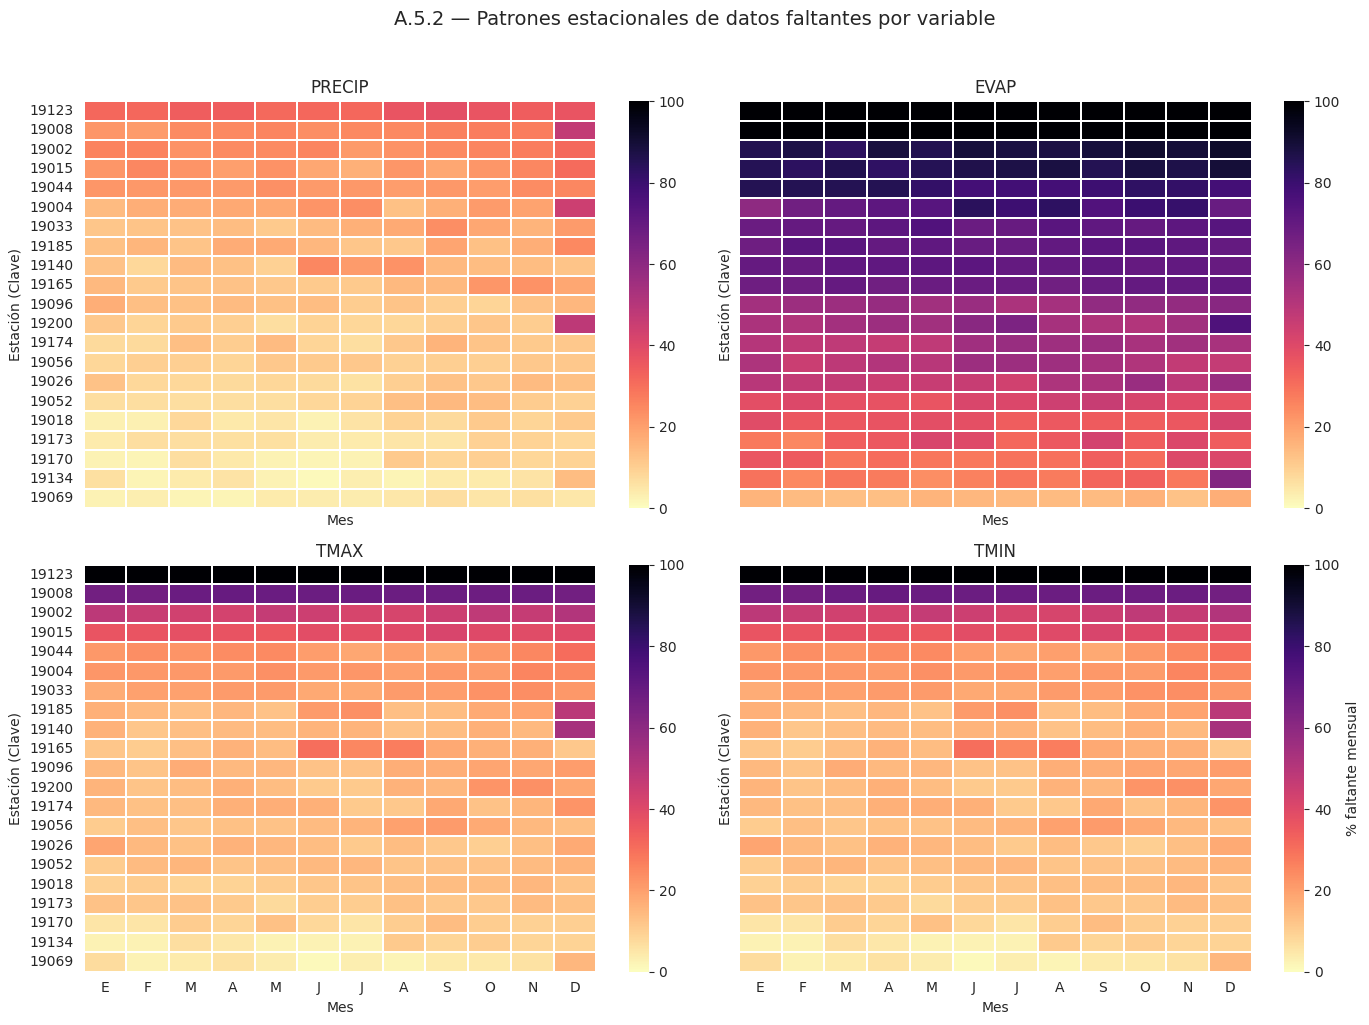

In [18]:
# ===== A.5.2 — Heatmaps mensuales de missingness (2x2: PRECIP, EVAP, TMAX, TMIN) =====
df = records_std.copy()

vars_plot = [v for v in ["PRECIP","EVAP","TMAX","TMIN"] if v in df.columns]
month_labels = ["E","F","M","A","M","J","J","A","S","O","N","D"]

# Figura 2x2
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
axes = axes.flatten()
sns.set_style("whitegrid")

for i, VAR in enumerate(vars_plot):
    ax = axes[i]
    tmp = df[["FECHA","Clave",VAR]].copy()
    tmp["is_na"] = tmp[VAR].isna()
    tmp["MES"] = tmp["FECHA"].dt.month

    # Tasa mensual por estación (%)
    monthly_rate = (
        tmp.groupby(["Clave","MES"])["is_na"]
           .mean()
           .mul(100).round(2)
           .reset_index(name="miss_rate_%")
    )
    heat = monthly_rate.pivot(index="Clave", columns="MES", values="miss_rate_%")
    heat = heat.loc[heat.mean(axis=1).sort_values(ascending=False).index]
    heat.columns = month_labels[:heat.shape[1]]

    sns.heatmap(
        heat, ax=ax, cmap="magma_r", vmin=0, vmax=100,
        linewidths=.2, linecolor="white",
        cbar_kws={"label": "% faltante mensual"} if i==3 else None
    )
    ax.set_title(f"{VAR}", fontsize=12)
    ax.set_xlabel("Mes")
    ax.set_ylabel("Estación (Clave)")

plt.suptitle("A.5.2 — Patrones estacionales de datos faltantes por variable", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


No se obbserva una estacionalidad marcada, ni un patron claro de faltantes.

In [19]:
# ===== A.5.3 — Rachas (bloques) de datos faltantes por estación y variable =====

def compute_missing_runs(records_df, vars_list=("PRECIP","EVAP","TMAX","TMIN"),
                         thresholds=(7, 30, 90)):
    df = records_df.copy()
    assert {"FECHA","Clave"}.issubset(df.columns)

    # Asegura orden temporal por estación
    df = df.sort_values(["Clave","FECHA"])

    out_rows = []
    for var in vars_list:
        if var not in df.columns:
            continue
        # indicador de falta
        tmp = df[["Clave","FECHA", var]].copy()
        tmp["is_na"] = tmp[var].isna()

        # agrupamos por estación
        for clave, g in tmp.groupby("Clave"):
            s = g["is_na"].values

            # runs-length encoding sobre is_na
            if len(s) == 0:
                continue
            # posiciones donde cambia el estado
            change = np.r_[True, s[1:] != s[:-1], True]
            idx = np.flatnonzero(change)
            lengths = np.diff(idx)                  # longitudes de cada run
            states  = s[idx[:-1]]                   # True si run=missing

            # estadísticas solo de runs missing (True)
            miss_lengths = lengths[states] if states.size else np.array([], dtype=int)
            max_run = int(miss_lengths.max()) if miss_lengths.size else 0

            # conteo por umbrales
            counts = {f"n_blocks_ge_{t}": int((miss_lengths >= t).sum()) for t in thresholds}

            # % faltante global de la variable en esta estación
            miss_rate = float(g["is_na"].mean()*100)

            row = {"Clave": int(clave), "variable": var,
                   "max_run_days": max_run, "miss_rate_%": round(miss_rate, 2)}
            row.update(counts)
            out_rows.append(row)

    res_runs = pd.DataFrame(out_rows).sort_values(
        ["variable","max_run_days","miss_rate_%"], ascending=[True, False, False]
    ).reset_index(drop=True)
    return res_runs

# Ejecutar sobre el DataFrame estandarizado (records_std de A.2)
res_runs = compute_missing_runs(records_std, vars_list=[v for v in ["PRECIP","EVAP","TMAX","TMIN"] if v in records_std.columns],
                                thresholds=(7,30,90))

print("A.5.3 — resumen de rachas de faltantes (por estación y variable):")
pd.set_option("display.max_rows", 21)
display(res_runs.head(21))


A.5.3 — resumen de rachas de faltantes (por estación y variable):


Clave variable  max_run_days  miss_rate_%  n_blocks_ge_7  n_blocks_ge_30  \
0   19004     EVAP         22020       100.00              1               1   
1   19008     EVAP         16269        70.47             10               6   
2   19123     EVAP         16102       100.00              1               1   
3   19044     EVAP         12188        70.89             21              21   
4   19174     EVAP          8919        88.17             22              18   
5   19033     EVAP          8643        70.56             20              18   
6   19015     EVAP          7662        52.16             38              30   
7   19018     EVAP          7519        86.15             15              15   
8   19052     EVAP          6565        68.66             52              11   
9   19200     EVAP          6361        81.53              4               4   
10  19002     EVAP          5663        56.66             21              21   
11  19165     EVAP          5356        74.41             43              33   
12  19026     EVAP          4628        36.74             48              21   
13  19185     EVAP          4402        56.70             17              11   
14  19056     EVAP          3865        40.14             26              21   
15  19134     EVAP          3683        49.33             26              26   
16  19096     EVAP          2624        51.05             26              18   
17  19173     EVAP          1938        32.68             31              25   
18  19170     EVAP          1644        35.31             26              23   
19  19140     EVAP          1215        31.19             52              26   
20  19069     EVAP           424        14.76             31              21   

    n_blocks_ge_90  
0                1  
1                2  
2                1  
3               11  
4                9  
5               10  
6               15  
7               11  
8                7  
9                4  
10              14  
11              14  
12              11  
13               5  
14              11  
15              15  
16               7  
17              13  
18               9  
19               7  
20               8

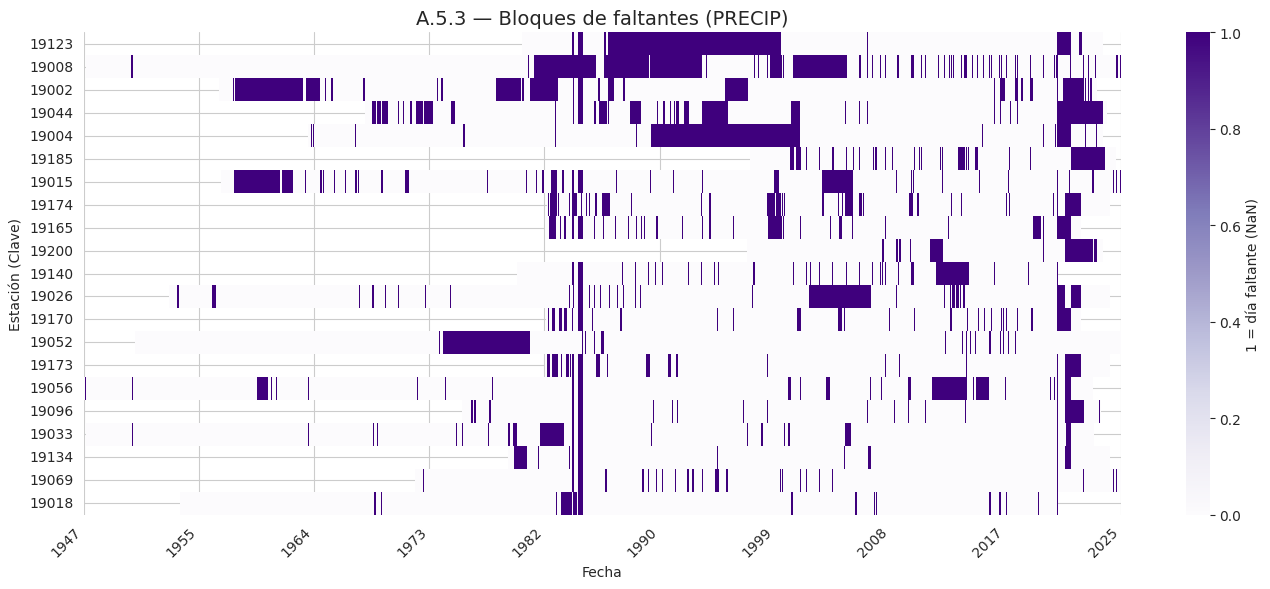

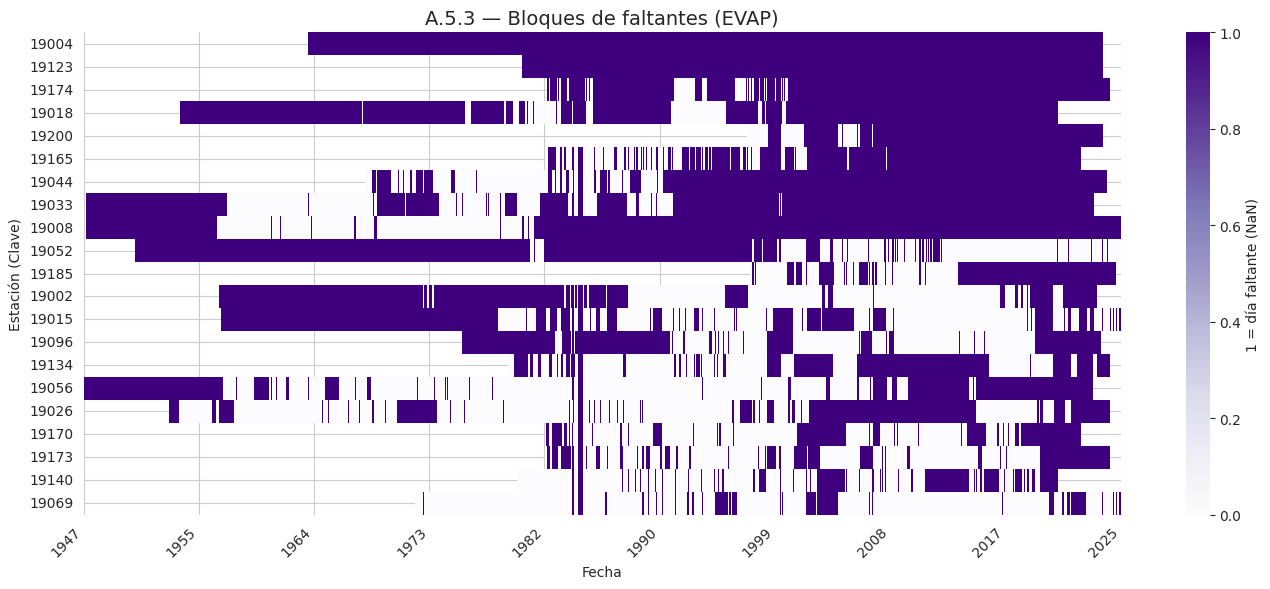

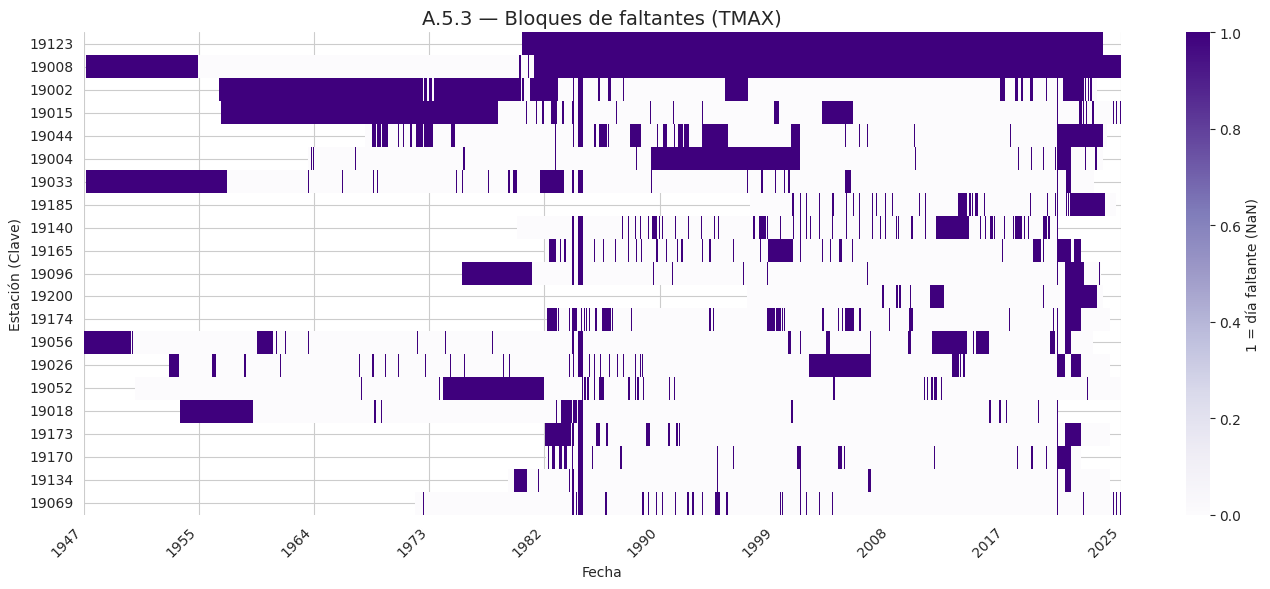

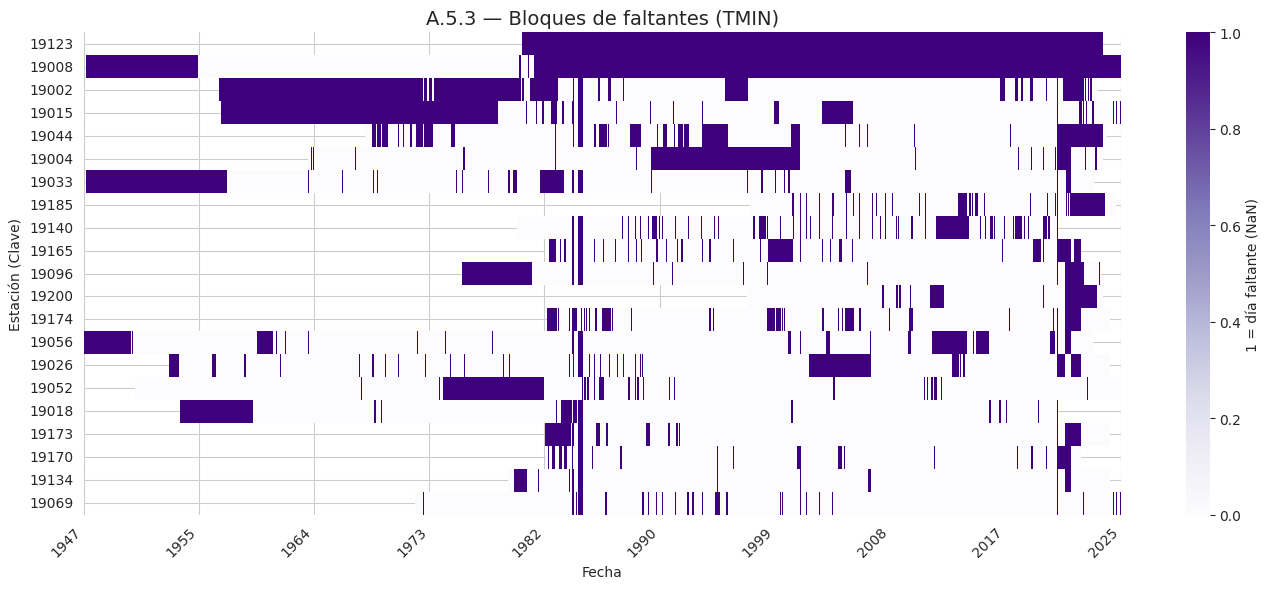

In [20]:
# ===== A.5.3b — Bloques de faltantes por fecha (una gráfica por variable) =====
df = records_std.copy()
vars_plot = [v for v in ["PRECIP","EVAP","TMAX","TMIN"] if v in df.columns]

sns.set_style("whitegrid")

for VAR in vars_plot:
    tmp = df[["FECHA","Clave",VAR]].copy()
    tmp["is_na"] = tmp[VAR].isna().astype(int)

    # Ordenar estaciones por % medio de faltantes (desc)
    order = (
        tmp.groupby("Clave")["is_na"]
        .mean()
        .sort_values(ascending=False)
        .index.astype(int)
    )

    # Matriz estaciones x fechas (1 = faltante)
    pivot = (
        tmp.pivot(index="Clave", columns="FECHA", values="is_na")
        .loc[order]
    )

    # --- Gráfica ---
    fig, ax = plt.subplots(figsize=(14, 6))
    sns.heatmap(
        pivot,
        cmap="Purples", vmin=0, vmax=1,
        cbar_kws={"label": "1 = día faltante (NaN)"},
        linewidths=0, linecolor=None,
        ax=ax
    )

    ax.set_title(f"A.5.3 — Bloques de faltantes ({VAR})", fontsize=14)
    ax.set_ylabel("Estación (Clave)")
    ax.set_xlabel("Fecha")

    # Etiquetas de tiempo legibles
    if pivot.shape[1] > 1:
        xticks = np.linspace(0, pivot.shape[1]-1, 10).astype(int)
        ax.set_xticks(xticks)
        ax.set_xticklabels(
            pd.to_datetime(pivot.columns[xticks]).strftime("%Y"),
            rotation=45, ha="right"
        )

    plt.tight_layout()
    plt.show()


Se observan vacíos continuos en varias estaciones. en particular en la 19052 (monterrey). un bloque continuo de días faltantes simultáneo en PRECIP, EVAP, TMAX y TMIN, lo que sugiere inactividad de la estación o falla sistémica (no solo de un sensor). Probablemente sea mejor trabajar a partir de 1982 que ya no hay bloques de faltantes.

In [21]:
# ===== A.5.3c — Mayores bloques de faltantes en 19052 (por variable y comunes) =====
import pandas as pd
import numpy as np

STATION = 19052
VARS = [v for v in ["PRECIP","EVAP","TMAX","TMIN"] if v in records_std.columns]
MIN_YEARS = 5       # umbral para filtrar "bloques grandes"
MIN_DAYS  = 365 * MIN_YEARS

df0 = (records_std
       .loc[records_std["Clave"] == STATION, ["FECHA","Clave"] + VARS]
       .sort_values("FECHA")
       .reset_index(drop=True))

def runs_from_bool(series_bool, dates):
    """Devuelve DataFrame de runs (True=missing) con inicio, fin y duración en días."""
    s = series_bool.values.astype(int)
    # detecta cambios
    change = np.r_[True, s[1:] != s[:-1], True]
    idx = np.flatnonzero(change)
    # runs
    lengths = np.diff(idx)
    states  = s[idx[:-1]] == 1   # True si run = missing
    starts  = idx[:-1][states]
    ends    = idx[1:][states] - 1

    if len(starts) == 0:
        return pd.DataFrame(columns=["start","end","days"])

    runs = pd.DataFrame({
        "start": dates.iloc[starts].values,
        "end":   dates.iloc[ends].values
    })
    runs["days"] = (runs["end"] - runs["start"]).dt.days + 1
    return runs.sort_values("days", ascending=False).reset_index(drop=True)

# --- Top bloques por variable ---
results = {}
for v in VARS:
    is_na = df0[v].isna()
    runs = runs_from_bool(is_na, df0["FECHA"])
    runs["variable"] = v
    results[v] = runs

# Mostrar Top 3 por variable
for v in VARS:
    print(f"\n>>> Top bloques faltantes — {v} — Estación {STATION}")
    topv = results[v].head(3)
    if topv.empty:
        print("   (sin bloques)")
    else:
        display(topv)

# --- Bloques comunes (todas las variables ausentes a la vez) ---
if VARS:
    is_all_na = df0[VARS].isna().all(axis=1)
    runs_all = runs_from_bool(is_all_na, df0["FECHA"])
    runs_all["variable"] = "TODAS"
    print(f"\n>>> Top bloques faltantes COMUNES (todas las variables) — Estación {STATION}")
    display(runs_all.head(3))

    # Filtrar “bloques grandes” (p. ej., >= 5 años)
    big_all = runs_all.query("days >= @MIN_DAYS").copy()
    if not big_all.empty:
        print(f"\nBloques COMUNES >= {MIN_YEARS} años (>= {MIN_DAYS} días):")
        display(big_all)
    else:
        print(f"\nNo hay bloques COMUNES >= {MIN_YEARS} años.")
else:
    print("No hay variables disponibles en VARS.")



>>> Top bloques faltantes — PRECIP — Estación 19052


start        end  days variable
0 1974-05-01 1980-12-31  2437   PRECIP
1 1986-05-01 1986-07-31    92   PRECIP
2 1985-03-01 1985-03-31    31   PRECIP


>>> Top bloques faltantes — EVAP — Estación 19052


start        end  days variable
0 1951-01-01 1968-12-21  6565     EVAP
1 1982-01-01 1997-10-31  5783     EVAP
2 1968-12-26 1980-12-31  4389     EVAP


>>> Top bloques faltantes — TMAX — Estación 19052


start        end  days variable
0 1974-05-01 1981-12-31  2802     TMAX
1 1986-04-12 1986-07-31   111     TMAX
2 2011-09-02 2011-10-31    60     TMAX


>>> Top bloques faltantes — TMIN — Estación 19052


start        end  days variable
0 1974-05-01 1981-12-31  2802     TMIN
1 1986-04-12 1986-07-31   111     TMIN
2 2011-09-02 2011-10-31    60     TMIN


>>> Top bloques faltantes COMUNES (todas las variables) — Estación 19052


start        end  days variable
0 1974-05-01 1980-12-31  2437    TODAS
1 1986-05-01 1986-07-31    92    TODAS
2 1984-12-01 1984-12-31    31    TODAS


Bloques COMUNES >= 5 años (>= 1825 días):


start        end  days variable
0 1974-05-01 1980-12-31  2437    TODAS

##A.6	Coherencia temporal


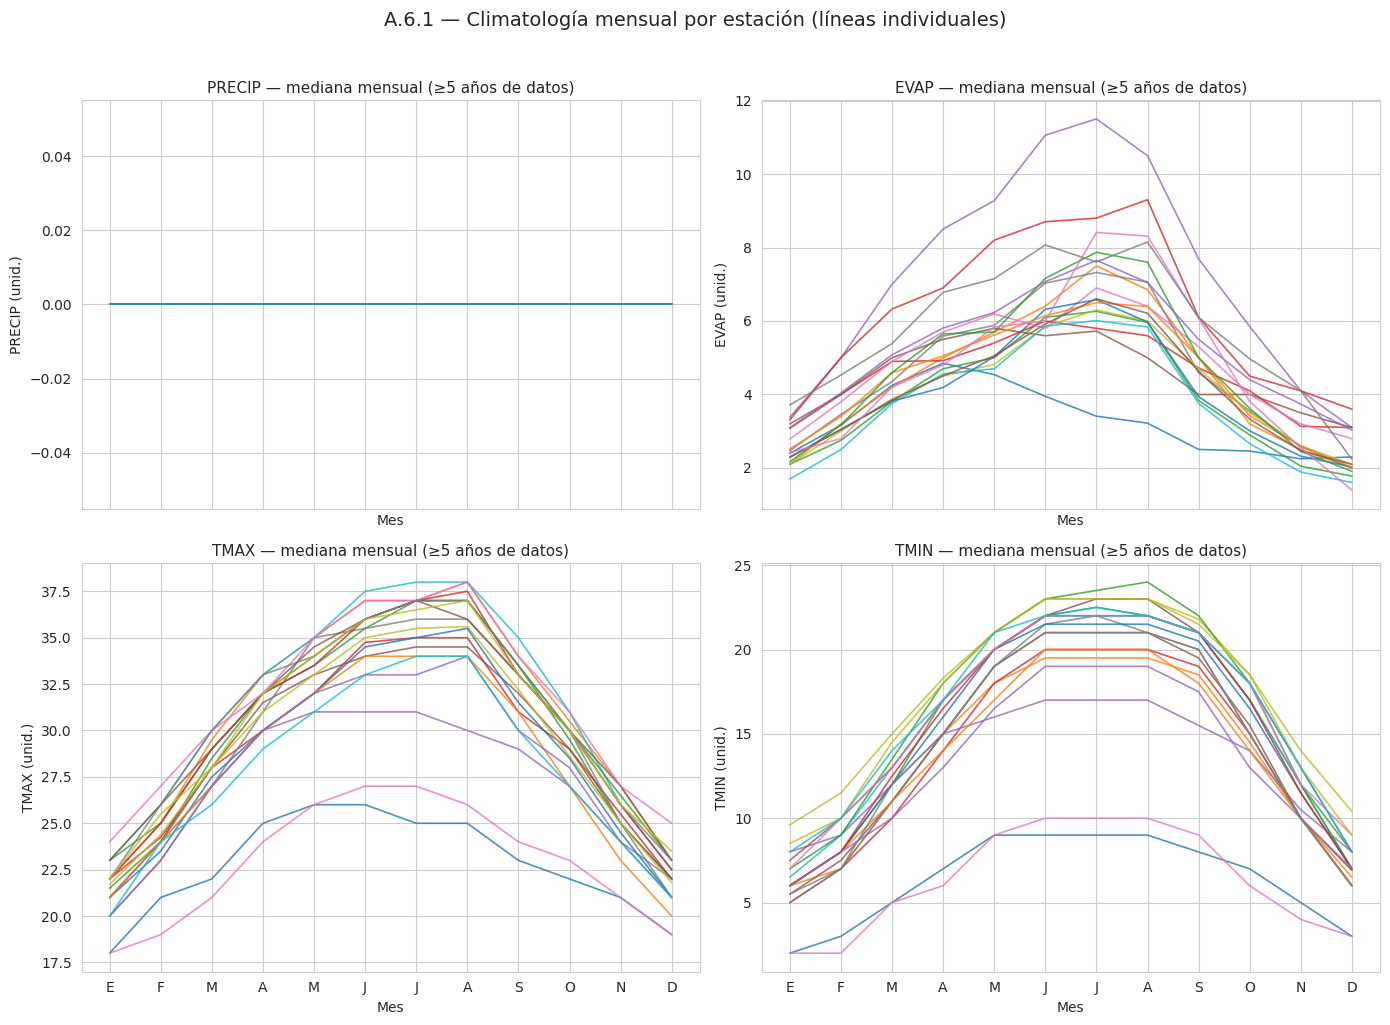

In [22]:
# ===== A.6.1 — Climatología mensual (todas las estaciones) =====

df = records_std.copy()   # diario, ya estandarizado (A.2)

# --- parámetros ---
vars_plot = [v for v in ["PRECIP","EVAP","TMAX","TMIN"] if v in df.columns]
min_years_equiv = 5         # exigir al menos ~5 años de datos válidos por estación/variable
min_days = 365 * min_years_equiv
month_labels = ["E","F","M","A","M","J","J","A","S","O","N","D"]

sns.set_style("whitegrid")

# pre-cálculo: días válidos por estación/variable
valid_days = (
    df.melt(id_vars=["FECHA","Clave"], value_vars=vars_plot, var_name="variable", value_name="valor")
      .assign(is_valid=lambda x: x["valor"].notna().astype(int))
      .groupby(["Clave","variable"], as_index=False)["is_valid"].sum()
      .rename(columns={"is_valid":"n_valid_days"})
)

# figura 2x2
n_panels = len(vars_plot)
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
axes = axes.flatten()

for i, VAR in enumerate(vars_plot):
    ax = axes[i]

    # filtrar estaciones con datos suficientes
    ok_stations = set(valid_days.query("variable == @VAR and n_valid_days >= @min_days")["Clave"].astype(int))
    sub = df.loc[df["Clave"].isin(ok_stations), ["FECHA","Clave",VAR]].dropna()
    if sub.empty:
        ax.set_visible(False)
        continue

    sub["MES"] = sub["FECHA"].dt.month

    # climatología mensual robusta (mediana) por estación
    clim = (sub.groupby(["Clave","MES"])[VAR]
                .median()
                .reset_index()
                .pivot(index="Clave", columns="MES", values=VAR)
                .reindex(columns=range(1,13)))

    # trazar una línea por estación
    x = np.arange(1, 13)
    for clave, row in clim.iterrows():
        ax.plot(x, row.values, lw=1.2, alpha=0.8)

    ax.set_title(f"{VAR} — mediana mensual (≥{min_years_equiv} años de datos)", fontsize=11)
    ax.set_xticks(x)
    ax.set_xticklabels(month_labels)
    ax.set_xlabel("Mes")
    ax.set_ylabel(f"{VAR} (unid.)")

# ocultar paneles vacíos si faltaran variables
for j in range(n_panels, 4):
    axes[j].axis("off")

plt.suptitle("A.6.1 — Climatología mensual por estación (líneas individuales)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


Se observa un fuerte patron estacional. Temperatura y evaporacion aumentan siginificativamente de mayo a agosto. Alcanzando un pico en julio, lo que coincide con el verano. y es perfectamente coherente pues a mayor temperatura mayor evaporacion. La Precipitacion no se observa pues al calcular mediana, y tener tantos 0 se hace 0. Por ello se hizo un calculo distinto:

Ocurrencia (% de días húmedos): proporción de días con PRECIP ≥ 1 mm.

Monto condicional (mm/día húmedo): media en días húmedos (excluye ceros).

Total mensual típico (mm/mes): sumar por mes-año y luego tomar mediana (o media) entre años.

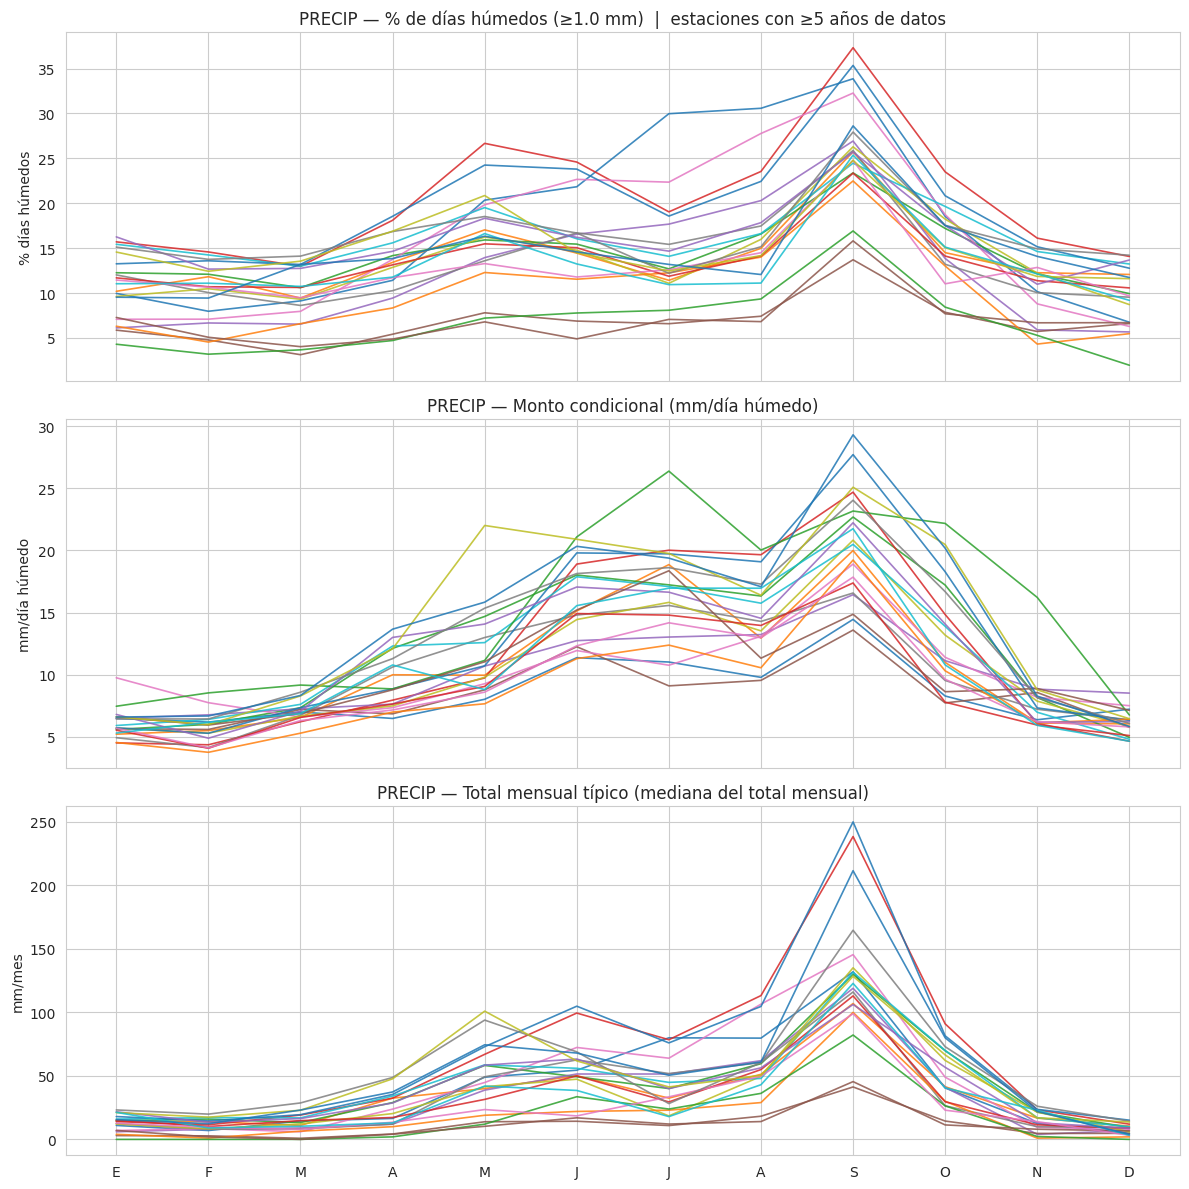

In [23]:
# ===== A.6.1 (ajuste para PRECIP) — Ocurrencia, monto condicional y total mensual =====

df = records_std.copy()
assert {"FECHA","Clave","PRECIP"}.issubset(df.columns)

min_years_equiv = 5
min_days = 365 * min_years_equiv
wet_thr = 1.0  # mm

sns.set_style("whitegrid")
month_labels = ["E","F","M","A","M","J","J","A","S","O","N","D"]

# Filtrar estaciones con datos suficientes para PRECIP
valid_days = (
    df[["FECHA","Clave","PRECIP"]]
      .assign(is_valid=lambda x: x["PRECIP"].notna().astype(int))
      .groupby("Clave", as_index=False)["is_valid"].sum()
      .rename(columns={"is_valid":"n_valid_days"})
)
ok_stations = set(valid_days.query("n_valid_days >= @min_days")["Clave"].astype(int))

sub = df.loc[df["Clave"].isin(ok_stations), ["FECHA","Clave","PRECIP"]].dropna()
sub["AÑO"] = sub["FECHA"].dt.year
sub["MES"] = sub["FECHA"].dt.month
sub["wet"] = (sub["PRECIP"] >= wet_thr).astype(int)

# 1) Ocurrencia: % de días húmedos por estación y mes
occ = (sub.groupby(["Clave","MES"])["wet"].mean()*100).reset_index(name="occ_pct")
occ_pivot = occ.pivot(index="Clave", columns="MES", values="occ_pct").reindex(columns=range(1,13))

# 2) Monto condicional (mm/día húmedo)
cond = (sub.loc[sub["wet"]==1]
        .groupby(["Clave","MES"])["PRECIP"].mean()
        .reset_index(name="cond_mm"))
cond_pivot = cond.pivot(index="Clave", columns="MES", values="cond_mm").reindex(columns=range(1,13))

# 3) Total mensual típico (sumar por mes-año y luego mediana entre años)
monthly_tot = (sub.groupby(["Clave","AÑO","MES"])["PRECIP"].sum()
                  .reset_index(name="tot_mm"))
tot = (monthly_tot.groupby(["Clave","MES"])["tot_mm"].median()
                  .reset_index(name="tot_med_mm"))
tot_pivot = tot.pivot(index="Clave", columns="MES", values="tot_med_mm").reindex(columns=range(1,13))

# --- Graficar (3 paneles, líneas por estación) ---
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
x = np.arange(1, 13)

# Panel 1: % días húmedos
for clave, row in occ_pivot.iterrows():
    axes[0].plot(x, row.values, lw=1.2, alpha=0.85)
axes[0].set_title(f"PRECIP — % de días húmedos (≥{wet_thr} mm)  |  estaciones con ≥{min_years_equiv} años de datos")
axes[0].set_ylabel("% días húmedos")

# Panel 2: mm por día húmedo
for clave, row in cond_pivot.iterrows():
    axes[1].plot(x, row.values, lw=1.2, alpha=0.85)
axes[1].set_title("PRECIP — Monto condicional (mm/día húmedo)")
axes[1].set_ylabel("mm/día húmedo")

# Panel 3: total mensual típico (mediana entre años)
for clave, row in tot_pivot.iterrows():
    axes[2].plot(x, row.values, lw=1.2, alpha=0.85)
axes[2].set_title("PRECIP — Total mensual típico (mediana del total mensual)")
axes[2].set_ylabel("mm/mes")
axes[2].set_xticks(x); axes[2].set_xticklabels(month_labels)

plt.tight_layout()
plt.show()


Los tres indicadores confirman el comportamiento de lluvias característico de la ZMM:

Ocurrencia (% de días húmedos): aumenta progresivamente desde abril, con máximo entre julio y septiembre (≈25–35 % de días con lluvia).

Monto condicional (mm/día húmedo): valores medios entre 10 y 25 mm día⁻¹, también con pico en agosto–septiembre, lo que indica eventos de lluvia más intensos en la temporada cálida.

Total mensual típico: concentraciones máximas entre agosto y septiembre (150–250 mm mes⁻¹) y valores mínimos de enero a marzo (< 30 mm mes⁻¹).

No se observan anomalías sistemáticas ni estaciones con comportamiento inverso o fuera de fase, lo cual sugiere una coherencia temporal adecuada del ciclo estacional en las series de precipitación y temperatura.

In [24]:
# ===== A.6.2 — Rupturas/discontinuidades: anual → década + detección heurística (corregido) =====

df_daily = records_std.copy()

VAR_RULES = {"PRECIP":"sum","EVAP":"sum","TMAX":"mean","TMIN":"mean"}
vars_present = [v for v in VAR_RULES if v in df_daily.columns]
assert {"FECHA","Clave"}.issubset(df_daily.columns) and vars_present

# --- 1) Series ANUALES por estación/variable (corregido)
def make_annual(df):
    d = df.copy()
    d["YEAR"] = d["FECHA"].dt.year
    long = d.melt(id_vars=["Clave","YEAR"], value_vars=vars_present,
                  var_name="variable", value_name="valor").dropna()

    sum_vars  = [v for v in vars_present if VAR_RULES[v] == "sum"]
    mean_vars = [v for v in vars_present if VAR_RULES[v] == "mean"]

    parts = []
    if sum_vars:
        parts.append(long[long["variable"].isin(sum_vars)]
                     .groupby(["Clave","YEAR","variable"], as_index=False)["valor"].sum())
    if mean_vars:
        parts.append(long[long["variable"].isin(mean_vars)]
                     .groupby(["Clave","YEAR","variable"], as_index=False)["valor"].mean())

    return pd.concat(parts, ignore_index=True)

annual_df = make_annual(df_daily)

# --- 2) Resumen por DÉCADA
annual_df["DECADE"] = (annual_df["YEAR"] // 10) * 10
decadal = (annual_df.groupby(["Clave","variable","DECADE"])["valor"]
                    .mean().reset_index(name="dec_mean"))

# --- 3) Detección HEURÍSTICA de rupturas entre décadas adyacentes
THRESH_C_ABS = 1.5     # °C para TMAX/TMIN
THRESH_MM_ABS = 50.0   # mm para PRECIP/EVAP (anual)
THRESH_REL = 0.25      # 25% relativo

def detect_decadal_breaks(decadal_df):
    out = []
    for (clave, var), g in decadal_df.groupby(["Clave","variable"]):
        g = g.sort_values("DECADE")
        for (d0, m0), (d1, m1) in zip(g[["DECADE","dec_mean"]].values[:-1],
                                      g[["DECADE","dec_mean"]].values[1:]):
            if pd.isna(m0) or pd.isna(m1):
                continue
            abs_jump = float(m1 - m0)
            rel_jump = float(abs_jump / m0) if m0 != 0 else np.inf
            if var in ("TMAX","TMIN"):
                flag = (abs(abs_jump) >= THRESH_C_ABS)
            else:
                flag = (abs(abs_jump) >= THRESH_MM_ABS) or (abs(rel_jump) >= THRESH_REL)
            out.append({
                "Clave": int(clave), "variable": var,
                "decade_from": int(d0), "decade_to": int(d1),
                "dec_mean_from": m0, "dec_mean_to": m1,
                "abs_jump": abs_jump, "rel_jump": rel_jump,
                "suspected_break": bool(flag),
            })
    return pd.DataFrame(out)

breaks_df = detect_decadal_breaks(decadal)
candidates = (breaks_df.query("suspected_break")
                       .sort_values(["variable","Clave","decade_from"])
                       .reset_index(drop=True))

print("A.6.2 listo.")
print("Series anuales:", annual_df.shape, "| Por década:", decadal.shape)
print("Candidatos a ruptura:", candidates.shape[0])
display(candidates.head(20))

# --- 4) Gráfico para inspección por estación/variable
def plot_station_variable_annual(clave, variable):
    a = annual_df[(annual_df["Clave"]==clave) & (annual_df["variable"]==variable)]
    if a.empty:
        print(f"Sin datos para {clave}-{variable}"); return
    d = decadal[(decadal["Clave"]==clave) & (decadal["variable"]==variable)]
    b = breaks_df[(breaks_df["Clave"]==clave) & (breaks_df["variable"]==variable)]

    fig, ax = plt.subplots(figsize=(10,4))
    sns.lineplot(data=a, x="YEAR", y="valor", marker="o", lw=1, ax=ax, label="Anual")
    for _, r in d.iterrows():
        ax.hlines(r["dec_mean"], r["DECADE"], r["DECADE"]+9, colors="tab:orange", lw=2)
        ax.text(r["DECADE"]+4.5, r["dec_mean"], f"{int(r['DECADE'])}s",
                color="tab:orange", fontsize=8, ha="center", va="bottom")
    for _, r in b[b["suspected_break"]].iterrows():
        xmid = (r["decade_from"] + r["decade_to"])/2
        ax.axvline(x=xmid, color="crimson", linestyle="--", alpha=0.7)
        ax.text(xmid, ax.get_ylim()[1], "ruptura?", color="crimson",
                fontsize=8, ha="center", va="top", rotation=90)
    ax.set_title(f"Estación {clave} — {variable}: anual + medias por década")
    ax.set_xlabel("Año"); ax.set_ylabel(variable)
    plt.tight_layout(); plt.show()




A.6.2 listo.
Series anuales: (3582, 5) | Por década: (467, 4)
Candidatos a ruptura: 203


Clave variable  decade_from  decade_to  dec_mean_from  dec_mean_to  \
0   19002     EVAP         1970       1980     400.650000   483.061667   
1   19002     EVAP         1980       1990     483.061667  1158.455556   
2   19002     EVAP         2000       2010    1203.512000  1014.741111   
3   19002     EVAP         2010       2020    1014.741111   412.360000   
4   19008     EVAP         1950       1960    1884.533333  1549.990000   
5   19008     EVAP         1970       1980    1558.570000   701.100000   
6   19015     EVAP         1980       1990     828.217000  1117.985000   
7   19015     EVAP         1990       2000    1117.985000   842.728571   
8   19015     EVAP         2000       2010     842.728571  1383.263000   
9   19015     EVAP         2010       2020    1383.263000  1090.538333   
10  19018     EVAP         1960       1970      36.300000   788.800000   
11  19018     EVAP         1970       1980     788.800000   965.926667   
12  19018     EVAP         1980       1990     965.926667  1237.218333   
13  19018     EVAP         1990       2000    1237.218333   731.660000   
14  19026     EVAP         1950       1960    1726.183333  2475.159000   
15  19026     EVAP         1960       1970    2475.159000  2205.037500   
16  19026     EVAP         1970       1980    2205.037500  2449.971000   
17  19026     EVAP         1990       2000    2414.006000  1680.153333   
18  19026     EVAP         2010       2020    1710.203333  1415.710000   
19  19033     EVAP         1950       1960     956.900000  1513.090000   

      abs_jump   rel_jump  suspected_break  
0    82.411667   0.205695             True  
1   675.393889   1.398153             True  
2  -188.770889  -0.156850             True  
3  -602.381111  -0.593630             True  
4  -334.543333  -0.177521             True  
5  -857.470000  -0.550165             True  
6   289.768000   0.349870             True  
7  -275.256429  -0.246208             True  
8   540.534429   0.641410             True  
9  -292.724667  -0.211619             True  
10  752.500000  20.730028             True  
11  177.126667   0.224552             True  
12  271.291667   0.280862             True  
13 -505.558333  -0.408625             True  
14  748.975667   0.433891             True  
15 -270.121500  -0.109133             True  
16  244.933500   0.111079             True  
17 -733.852667  -0.303998             True  
18 -294.493333  -0.172198             True  
19  556.190000   0.581242             True

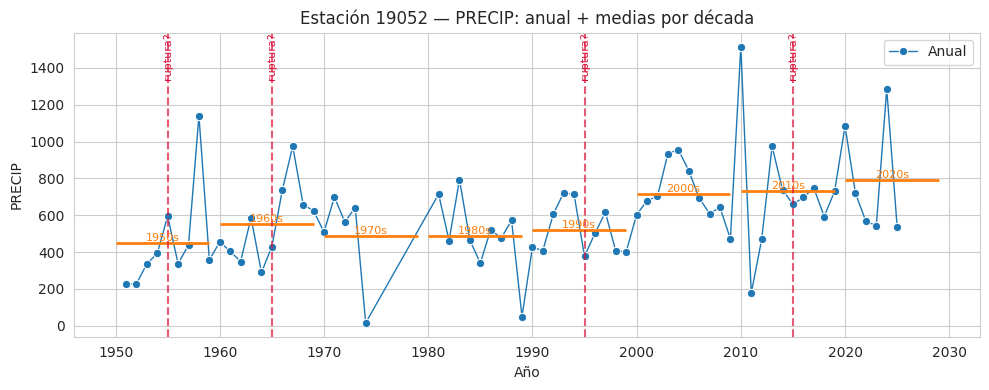

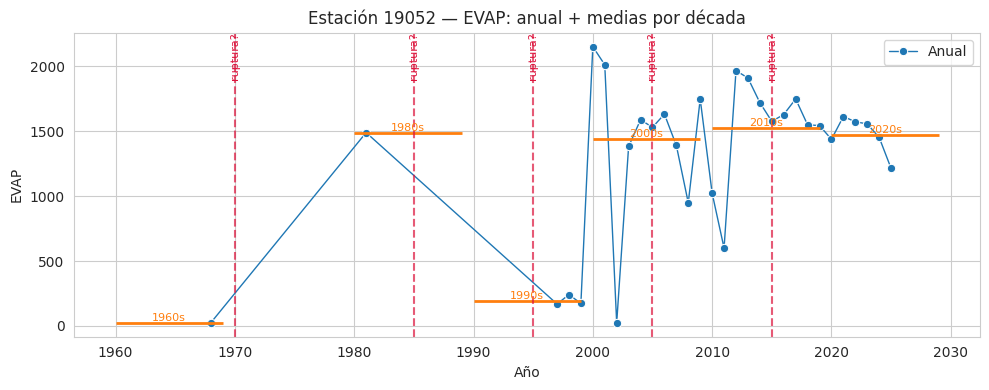

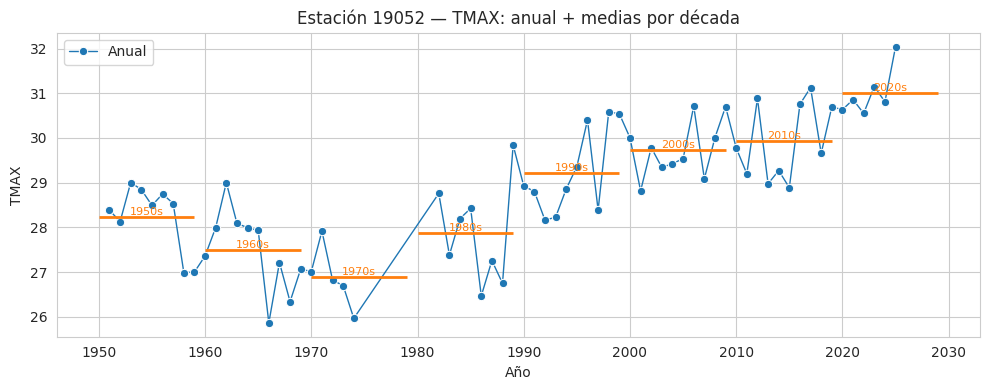

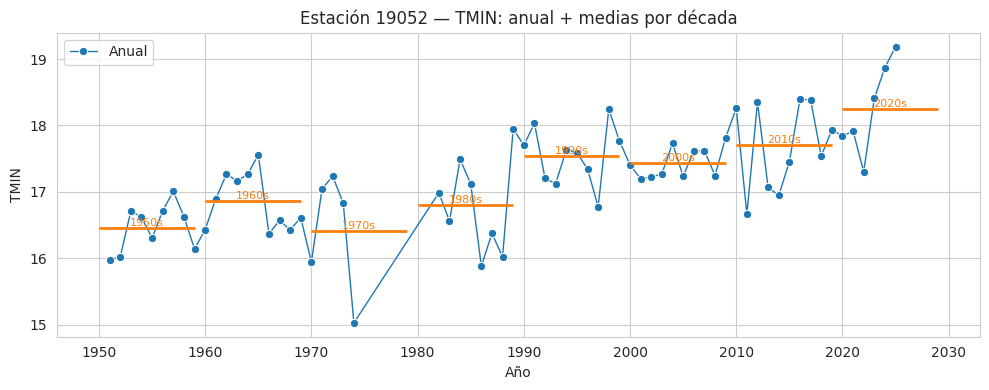

In [25]:

 plot_station_variable_annual(19052, "PRECIP")
 plot_station_variable_annual(19052, "EVAP")
plot_station_variable_annual(19052, "TMAX")
plot_station_variable_annual(19052, "TMIN")

No se detectaron rupturas severas (> umbral) en PRECIP, TMAX, TMIN.

Se detecto una ruptura significativa en EVAP (intervalo 1990–2000) asociada a reanudación de medición.

Todas las series mantienen coherencia temporal aceptable conforme a WMO (2018, §3.3.8).
se marcara el periodo sin datos de EVAP (1980–2000) como bloque inactivo y no incluirlo en calibraciones o promedios multidecadales.

##A.7 Coherencia Espacial






In [26]:
# ===== A.7.1 — Preselección de estaciones vecinas por distancia (Haversine) =====

# --- Parámetros ---
TARGET = 19052          # estación objetivo (Monterrey-Obs)
MAX_RADIUS_KM = 30    # radio máximo para considerar vecinas
K_NEIGHBORS  = 10       # máximo de vecinas a devolver
VAR_FILTER   = "PRECIP" # variable para filtrar por disponibilidad (opcional)
MIN_AVAIL_PCT = 70.0    # % mínimo de disponibilidad para la variable (opcional)

# --- 1) Coordenadas (usa tu stations_df ya creado en A.2)
coords = stations_df.dropna(subset=["lat","lon"]).copy()
coords["Clave"] = coords["Clave"].astype(int)

# (Opcional) incorporar disponibilidad por variable desde miss_rate_station_var (A.5.1)
if "miss_rate_station_var" in globals():
    avail = (miss_rate_station_var
             .assign(avail_pct=lambda d: d["avail_%"])
             .loc[lambda d: d["variable"]==VAR_FILTER, ["Clave","avail_pct"]]
             .drop_duplicates("Clave"))
    coords = coords.merge(avail, how="left", on="Clave")
else:
    coords["avail_pct"] = np.nan

# --- 2) Haversine vectorizado (km)
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    p1 = np.radians(lat1); p2 = np.radians(lat2)
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2.0)**2 + np.cos(p1)*np.cos(p2)*np.sin(dlon/2.0)**2
    return 2*R*np.arcsin(np.sqrt(a))

# --- 3) Función para obtener vecinas de una estación dada
def get_neighbors(clave_objetivo, max_radius_km=MAX_RADIUS_KM, k=K_NEIGHBORS,
                  min_avail_pct=MIN_AVAIL_PCT):
    if clave_objetivo not in coords["Clave"].values:
        raise KeyError(f"Clave {clave_objetivo} no está en stations_df con lat/lon.")
    row0 = coords.loc[coords["Clave"]==clave_objetivo].iloc[0]
    lat0, lon0 = row0["lat"], row0["lon"]

    df = coords.copy()
    df["dist_km"] = haversine_km(lat0, lon0, df["lat"].values, df["lon"].values)
    # excluir la propia estación
    df = df[df["Clave"] != clave_objetivo]

    # filtro de radio
    df = df[df["dist_km"] <= max_radius_km]

    # filtro opcional de disponibilidad por variable
    if not df["avail_pct"].isna().all():
        df = df[df["avail_pct"].fillna(0) >= min_avail_pct]

    # ordenar por distancia y tomar top-k
    df = (df.sort_values("dist_km")
            .head(k)
            .reset_index(drop=True))

    # columnas útiles
    cols = ["Clave","Nombre Estación","Municipio","lat","lon","dist_km","avail_pct"]
    return df[[c for c in cols if c in df.columns]]

# --- 4) Ejemplo: vecinas para 19052 (PRECIP con ≥70% de disponibilidad, ≤30 km)

neighbors_19052 = get_neighbors(TARGET)
print(f"Vecinas preseleccionadas para {TARGET} (≤{MAX_RADIUS_KM} km, top {K_NEIGHBORS}):")
display(neighbors_19052)


Vecinas preseleccionadas para 19052 (≤30 km, top 10):


Clave   Nombre Estación         Municipio        lat         lon  \
0  19185         EL CANADA  GENERAL ESCOBEDO  25.800556 -100.275556   
1  19004           APODACA           APODACA  25.793611 -100.197222   
2  19096    LA HUASTEQUITA    SANTA CATARINA  25.638611 -100.455000   
3  19134  SALINAS VICTORIA  SALINAS VICTORIA  25.959167 -100.292778   
4  19015        EL CERRITO          SANTIAGO  25.510000 -100.193333   
5  19018        EL PAJONAL    SANTA CATARINA  25.489722 -100.388889   
6  19200        LA CIENEGA            JUÁREZ  25.536389 -100.119167   

     dist_km  avail_pct  
0   7.996369      79.50  
1  12.664971      77.93  
2  18.394492      93.31  
3  25.109101      94.04  
4  27.257335      84.22  
5  28.402003      95.88  
6  28.756885      85.19

Se tomo en cuenta de acuerdo a la literatura un radio de 30km por ser una zona urbana con una red bastante densa

In [27]:
# ===== A.7.2 — Correlación mensual/estacional con vecinas (selección de vecinas fuertes) =====


TARGET = 19052                # estación objetivo
VAR    = "PRECIP"             # variable a comparar
SEASON = [7,8,9]              # temporada húmeda local (JAS). Cambia o pon None.
MIN_OVERLAP_MONTHS = 60       # mínimo de meses en común para considerar la correlación
STRONG_R = 0.60               # umbral de "vecina fuerte" (ajústalo 0.5–0.7)

# --- 0) vecinas preseleccionadas (usa la salida del paso A.7.1)
if 'neighbors_19052' not in globals():
    # si no existe, obtén vecinas con tu función get_neighbors(...)
    neighbors_19052 = get_neighbors(TARGET)

neighbor_ids = neighbors_19052["Clave"].astype(int).tolist()

# --- 1) Agregación mensual por estación (mensual total para PRECIP; para T/E usar mean)
df = records_std.copy()
assert {"FECHA","Clave",VAR}.issubset(df.columns)

df["Y"] = df["FECHA"].dt.year
df["M"] = df["FECHA"].dt.month

if VAR in ("PRECIP","EVAP"):
    monthly = (df.groupby(["Clave","Y","M"], as_index=False)[VAR].sum())
else:
    monthly = (df.groupby(["Clave","Y","M"], as_index=False)[VAR].mean())

# --- 2) Climatología mensual por estación (para quitar estacionalidad)
clim = (monthly.groupby(["Clave","M"], as_index=False)[VAR].mean()
        .rename(columns={VAR: "clim_month"}))

mon = monthly.merge(clim, on=["Clave","M"], how="left")
mon["anom"] = mon[VAR] - mon["clim_month"]

# --- 3) Función: correlación entre TARGET y un vecino
def corr_with_neighbor(df_mon, target_id, nei_id, season_months=None):
    sub = df_mon[df_mon["Clave"].isin([target_id, nei_id])].copy()
    if season_months is not None:
        sub = sub[sub["M"].isin(season_months)]
    # pasar a ancho
    wide_tot = sub.pivot_table(index=["Y","M"], columns="Clave", values=VAR)
    wide_anm = sub.pivot_table(index=["Y","M"], columns="Clave", values="anom")
    # emparejar meses donde estén ambos
    xy_tot = wide_tot[[target_id, nei_id]].dropna()
    xy_anm = wide_anm[[target_id, nei_id]].dropna()

    def _pearson(df2):
        if df2.shape[0] < 3:  # muy poco solape
            return np.nan, 0
        r = df2[target_id].corr(df2[nei_id])
        return float(r), int(df2.shape[0])

    r_tot, n_tot   = _pearson(xy_tot)
    r_anm, n_anm   = _pearson(xy_anm)
    return {"r_monthly": r_tot, "n_months": n_tot,
            "r_anom": r_anm,   "n_months_anom": n_anm}

# --- 4) Calcular correlaciones para todas las vecinas
rows = []
for nei in neighbor_ids:
    base = corr_with_neighbor(mon, TARGET, nei, season_months=None)
    jas  = corr_with_neighbor(mon, TARGET, nei, season_months=SEASON) if SEASON else {"r_monthly":np.nan,"n_months":np.nan,"r_anom":np.nan,"n_months_anom":np.nan}
    rows.append({
        "Clave_target": TARGET,
        "Clave_vecina": nei,
        "dist_km": float(neighbors_19052.loc[neighbors_19052["Clave"]==nei, "dist_km"].values[0])
                    if "dist_km" in neighbors_19052.columns else np.nan,
        "avail_pct": float(neighbors_19052.loc[neighbors_19052["Clave"]==nei, "avail_pct"].values[0])
                    if "avail_pct" in neighbors_19052.columns else np.nan,
        "r_monthly_all": base["r_monthly"],
        "overlap_all":   base["n_months"],
        "r_anom_all":    base["r_anom"],
        "overlap_anom":  base["n_months_anom"],
        "r_monthly_season": jas["r_monthly"],
        "overlap_season":   jas["n_months"],
        "r_anom_season":    jas["r_anom"],
        "overlap_anom_season": jas["n_months_anom"],
    })

corr_tbl = pd.DataFrame(rows)

# --- 5) Selección de "vecinas fuertes"
# criterio: suficiente solape y alta correlación (anom o mensual)
corr_tbl["strong_flag"] = (
    (corr_tbl[["overlap_all","overlap_anom","overlap_season","overlap_anom_season"]]
        .max(axis=1) >= MIN_OVERLAP_MONTHS) &
    (corr_tbl[["r_anom_season","r_monthly_season","r_anom_all","r_monthly_all"]]
        .max(axis=1) >= STRONG_R)
)

corr_ranked = corr_tbl.sort_values(
    ["strong_flag","r_anom_season","r_anom_all","r_monthly_season","r_monthly_all"],
    ascending=[False, False, False, False, False]
).reset_index(drop=True)

print("A.7.2 completado — correlaciones vs vecinas (mensual y anomalías).")
display(corr_ranked)

# --- (Opcional) Lista final de vecinas fuertes (top 4–6)
TOP_KEEP = 6
neighbors_strong = (corr_ranked[corr_ranked["strong_flag"]]
                    .head(TOP_KEEP)
                    .reset_index(drop=True))
print(f"\nVecinas fuertes sugeridas (umbral r ≥ {STRONG_R}, solape ≥ {MIN_OVERLAP_MONTHS} meses):")
display(neighbors_strong)


A.7.2 completado — correlaciones vs vecinas (mensual y anomalías).


Clave_target  Clave_vecina    dist_km  avail_pct  r_monthly_all  \
0         19052         19134  25.109101      94.04       0.771792   
1         19052         19200  28.756885      85.19       0.765784   
2         19052         19096  18.394492      93.31       0.700210   
3         19052         19185   7.996369      79.50       0.689117   
4         19052         19004  12.664971      77.93       0.637221   
5         19052         19015  27.257335      84.22       0.644523   
6         19052         19018  28.402003      95.88       0.590756   

   overlap_all  r_anom_all  overlap_anom  r_monthly_season  overlap_season  \
0          549    0.705139           549          0.780822             138   
1          324    0.636051           324          0.759893              81   
2          582    0.588144           582          0.710938             144   
3          334    0.550743           334          0.704274              82   
4          724    0.528227           724          0.648864             180   
5          820    0.525718           820          0.564029             207   
6          799    0.446093           799          0.506775             201   

   r_anom_season  overlap_anom_season  strong_flag  
0       0.737107                  138         True  
1       0.666522                   81         True  
2       0.653533                  144         True  
3       0.626427                   82         True  
4       0.593640                  180         True  
5       0.497647                  207         True  
6       0.445090                  201        False


Vecinas fuertes sugeridas (umbral r ≥ 0.6, solape ≥ 60 meses):


Clave_target  Clave_vecina    dist_km  avail_pct  r_monthly_all  \
0         19052         19134  25.109101      94.04       0.771792   
1         19052         19200  28.756885      85.19       0.765784   
2         19052         19096  18.394492      93.31       0.700210   
3         19052         19185   7.996369      79.50       0.689117   
4         19052         19004  12.664971      77.93       0.637221   
5         19052         19015  27.257335      84.22       0.644523   

   overlap_all  r_anom_all  overlap_anom  r_monthly_season  overlap_season  \
0          549    0.705139           549          0.780822             138   
1          324    0.636051           324          0.759893              81   
2          582    0.588144           582          0.710938             144   
3          334    0.550743           334          0.704274              82   
4          724    0.528227           724          0.648864             180   
5          820    0.525718           820          0.564029             207   

   r_anom_season  overlap_anom_season  strong_flag  
0       0.737107                  138         True  
1       0.666522                   81         True  
2       0.653533                  144         True  
3       0.626427                   82         True  
4       0.593640                  180         True  
5       0.497647                  207         True

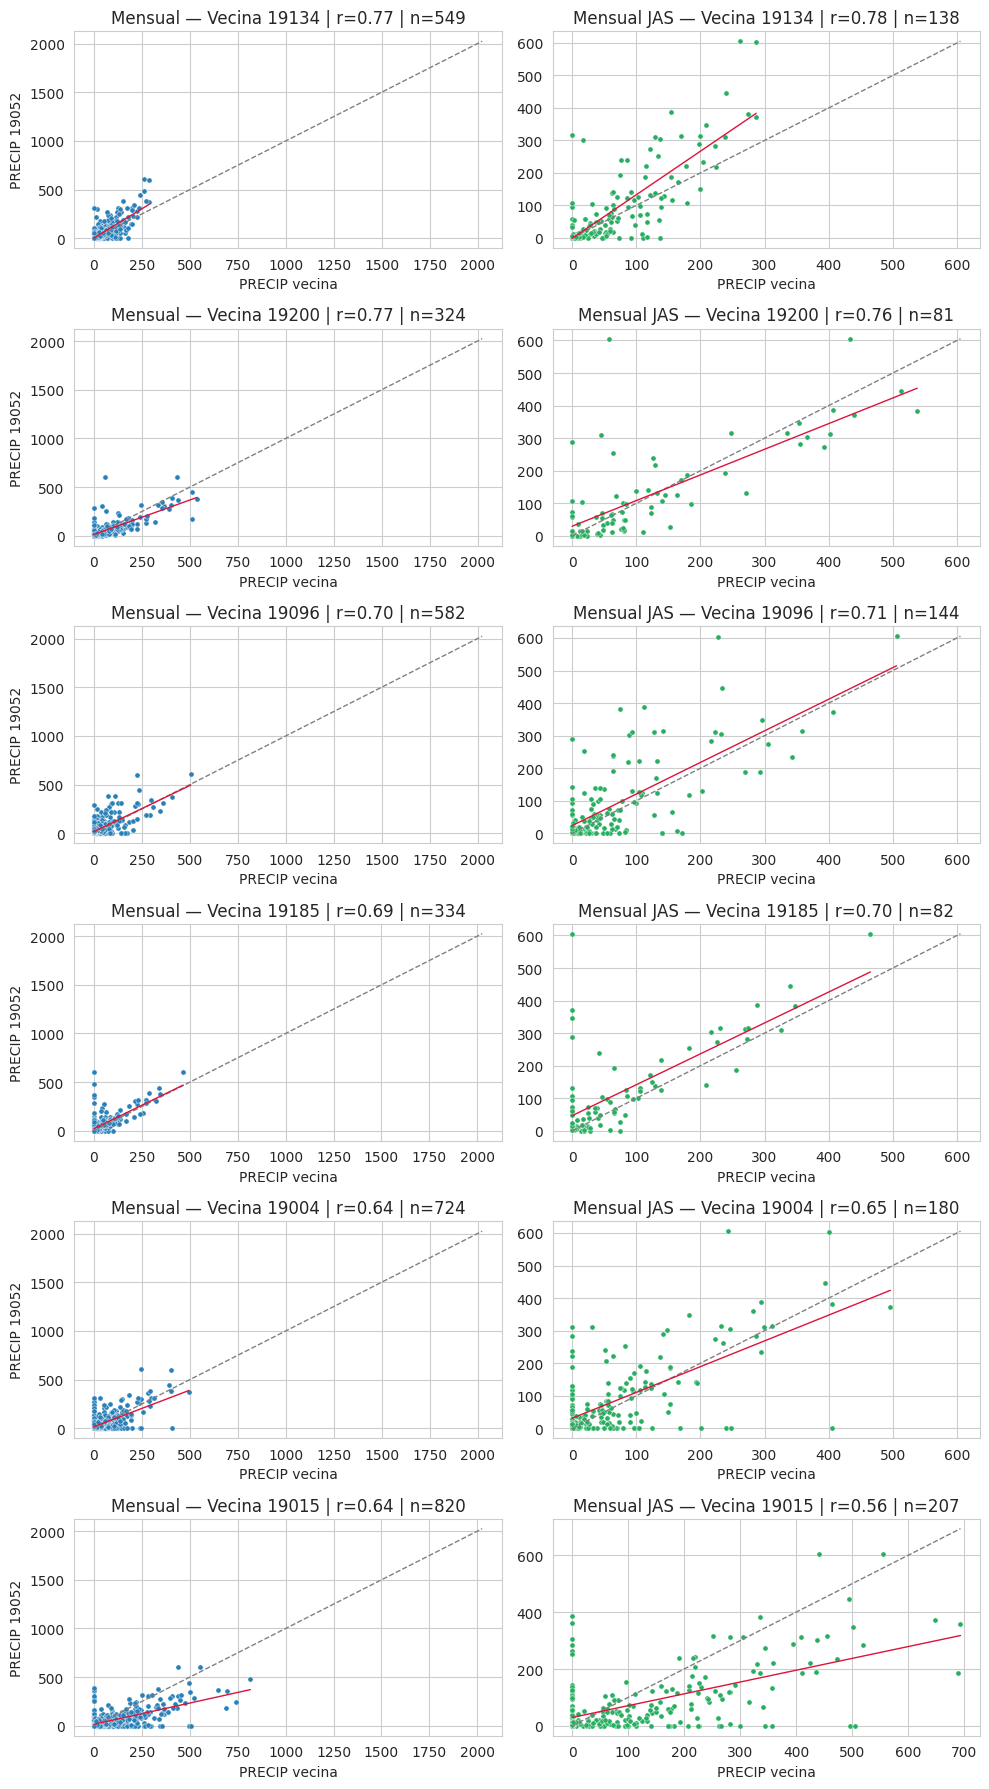

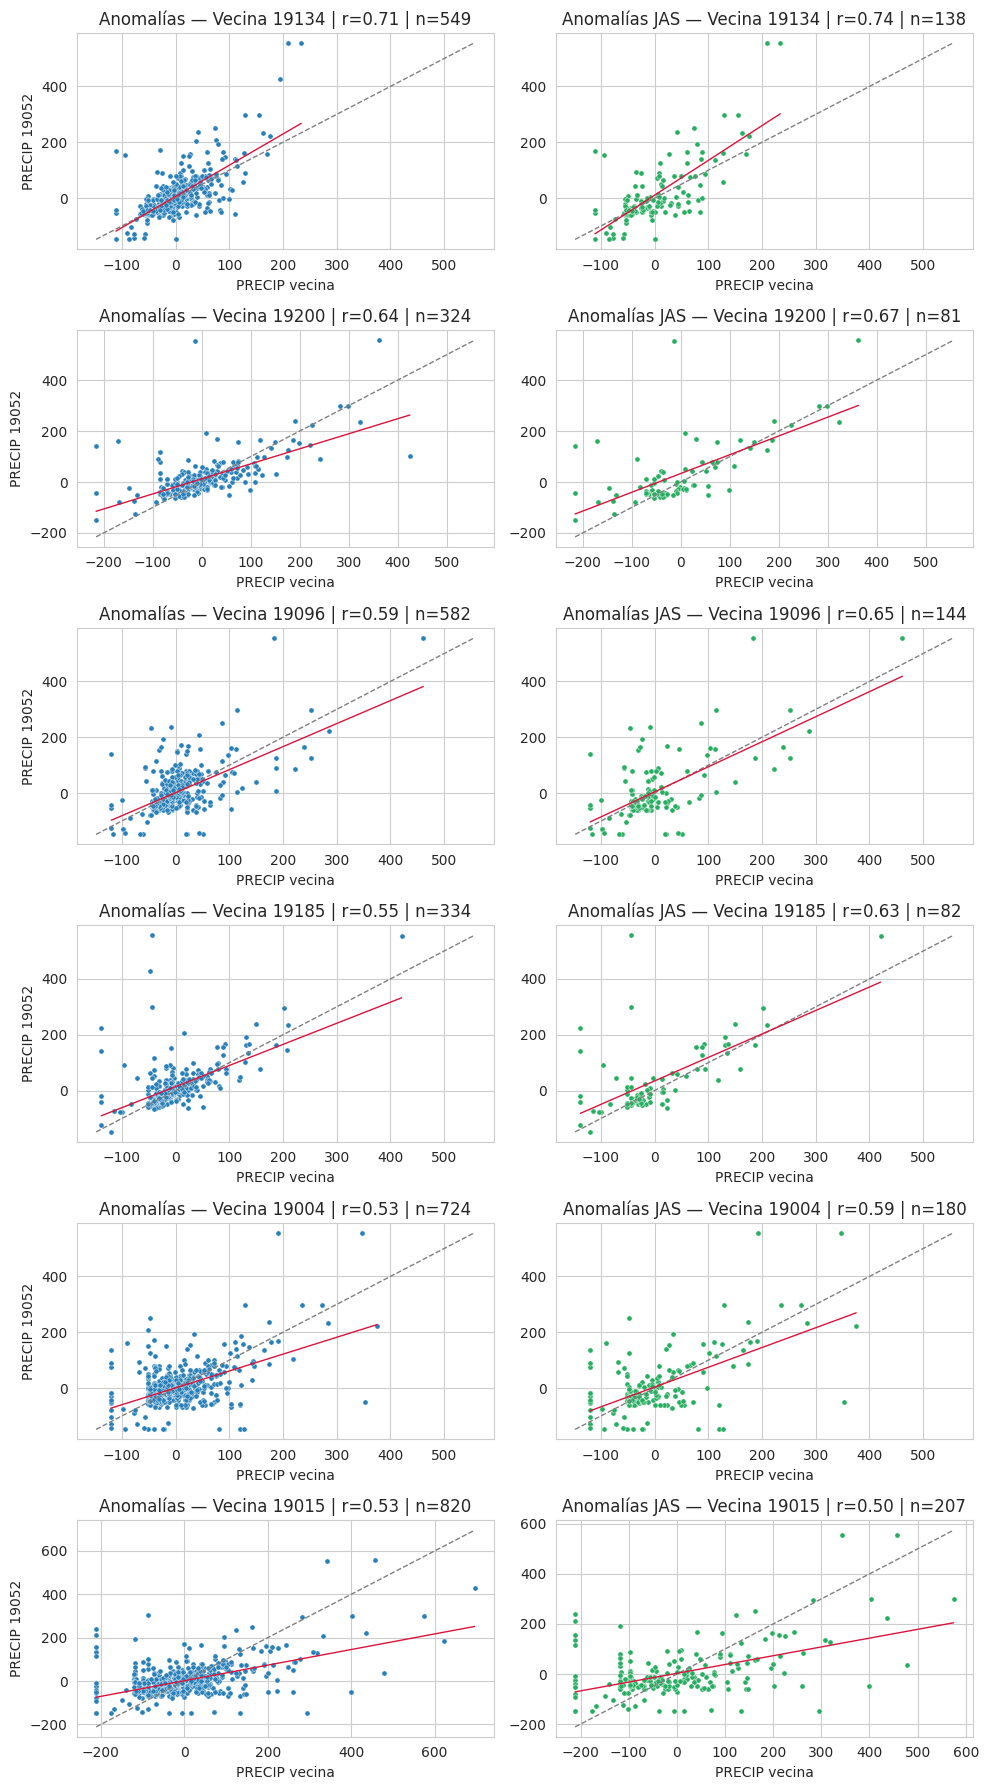

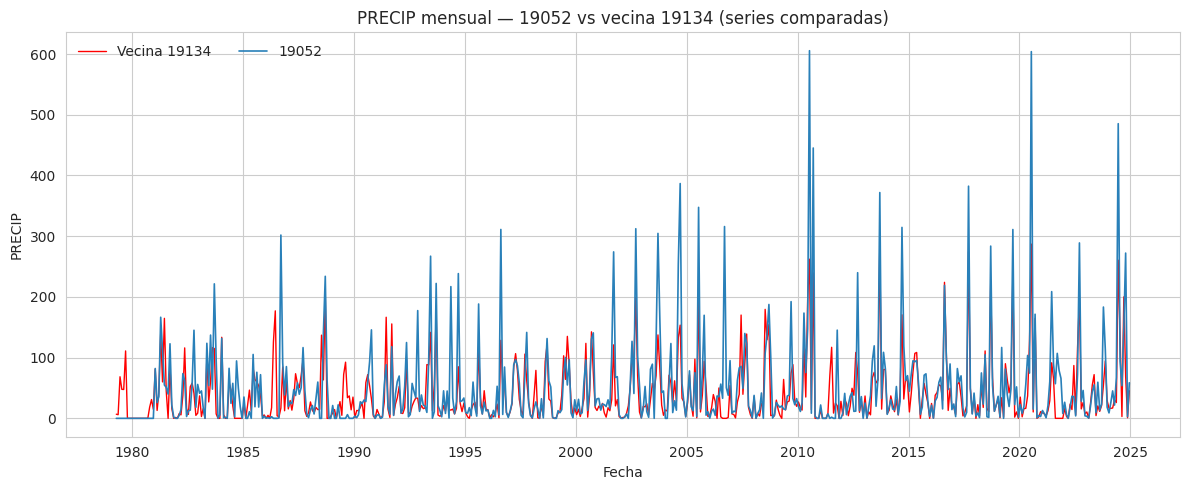

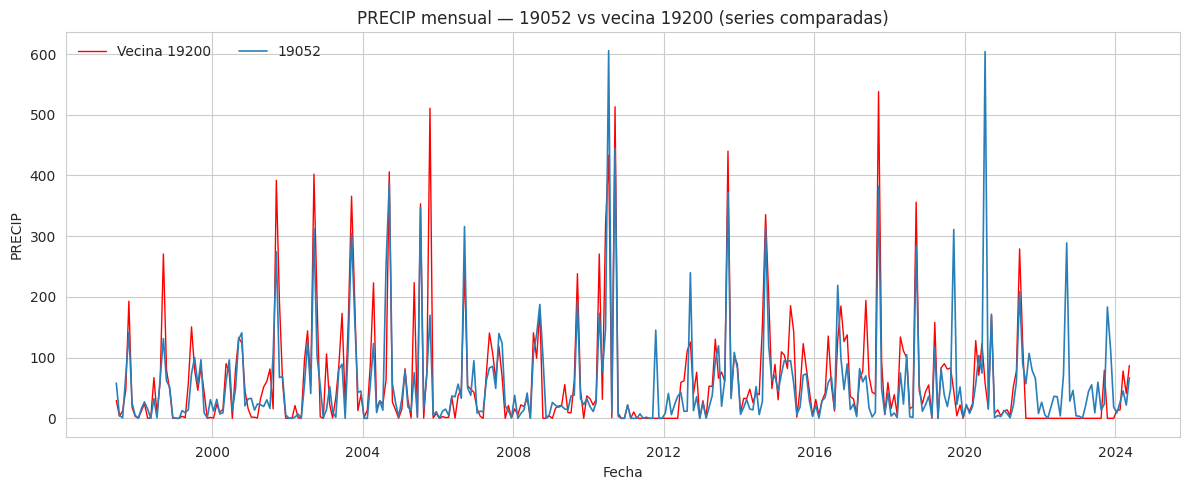

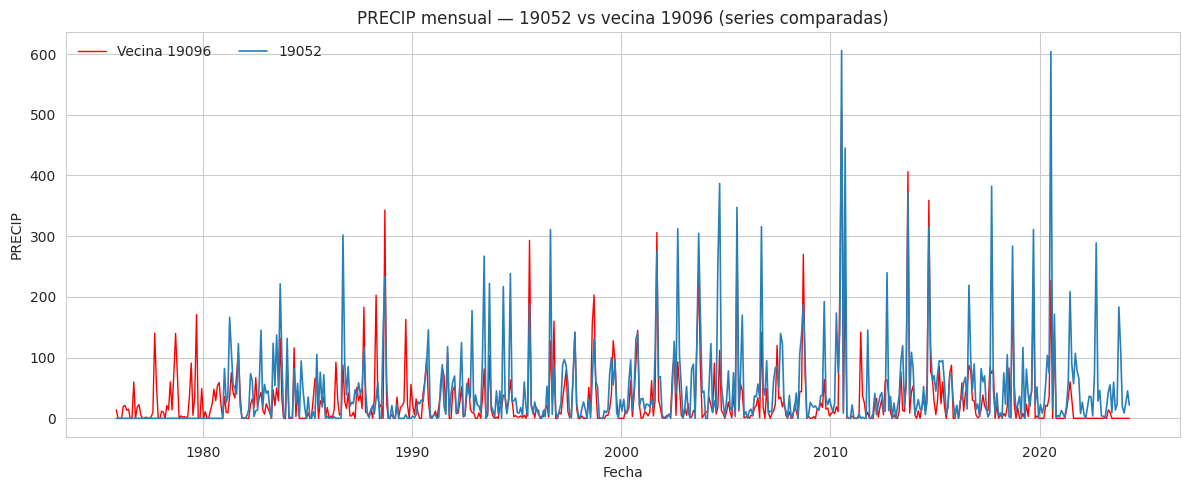

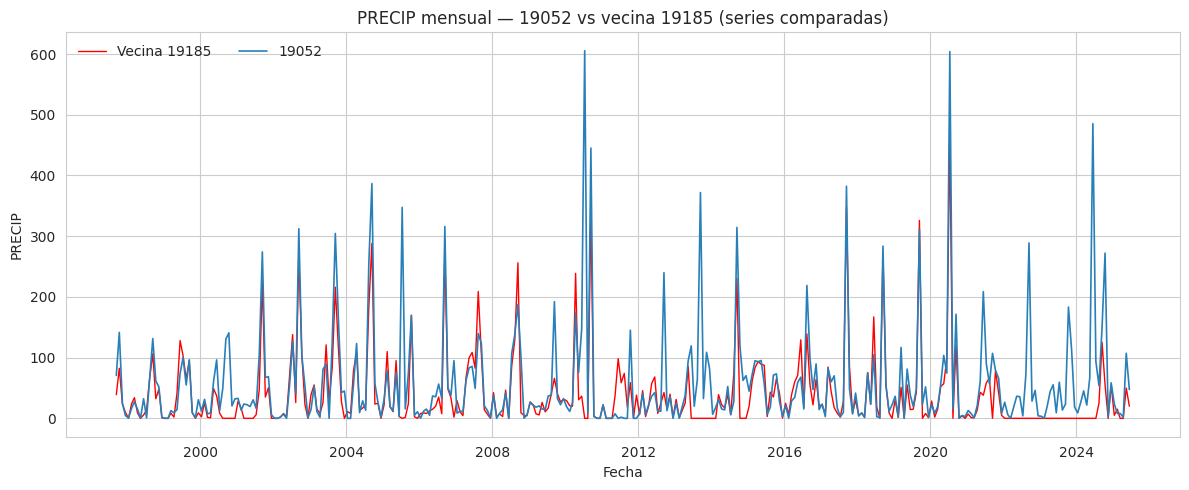

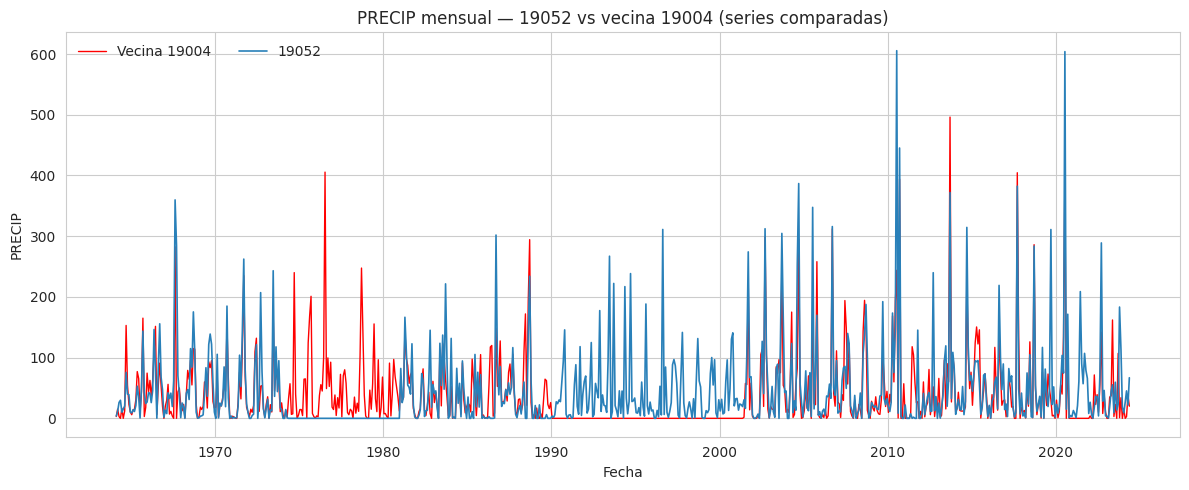

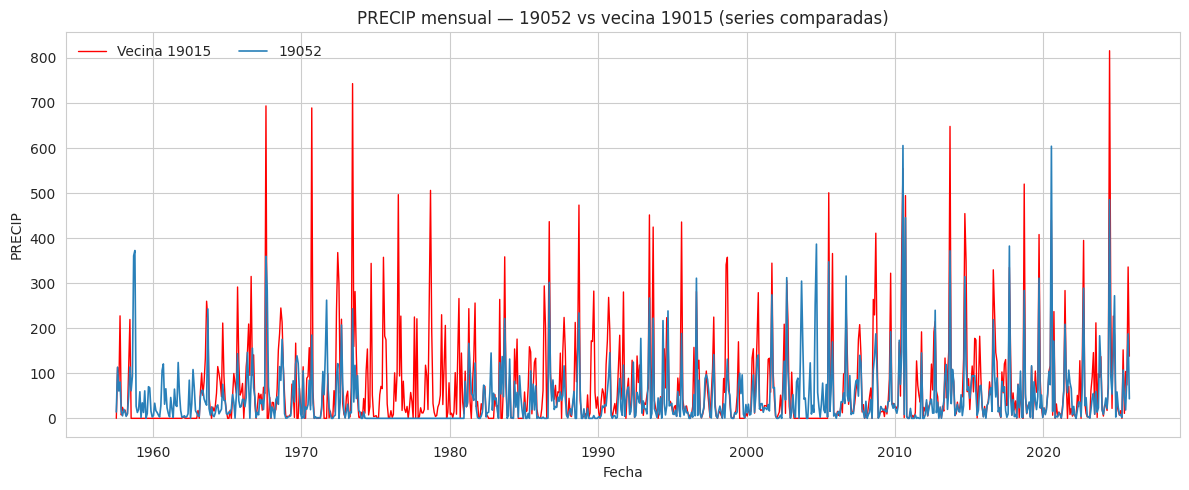

In [28]:
# ===== A.7.3 — Dispersión y series comparadas con vecinas fuertes =====

TARGET = 19052
VAR    = "PRECIP"       # cambia a EVAP/TMAX/TMIN si quieres
SEASON = [7,8,9]        # meses JAS; pon None si no quieres filtrar
MAX_PANELS = 6          # cuántas vecinas graficar (top por r)

# --- Preparar mensual y anomalías (reutiliza lo de A.7.2)
df = records_std.copy()
assert {"FECHA","Clave",VAR}.issubset(df.columns)
df["Y"] = df["FECHA"].dt.year
df["M"] = df["FECHA"].dt.month

if VAR in ("PRECIP","EVAP"):
    monthly = df.groupby(["Clave","Y","M"], as_index=False)[VAR].sum()
else:
    monthly = df.groupby(["Clave","Y","M"], as_index=False)[VAR].mean()

clim = (monthly.groupby(["Clave","M"], as_index=False)[VAR].mean()
        .rename(columns={VAR:"clim"}))
mon = monthly.merge(clim, on=["Clave","M"], how="left")
mon["anom"] = mon[VAR] - mon["clim"]

def build_pair(mon_df, target_id, nei_id, season=None, use_anom=False):
    sub = mon_df[mon_df["Clave"].isin([target_id, nei_id])].copy()
    if season is not None:
        sub = sub[sub["M"].isin(season)]
    valcol = "anom" if use_anom else VAR
    wide = sub.pivot_table(index=["Y","M"], columns="Clave", values=valcol)
    xy = wide[[target_id, nei_id]].dropna().rename(columns={target_id:"target", nei_id:"neighbor"})
    return xy.reset_index()

# --- Tomar vecinas fuertes (de A.7.2); si no existe, usa las más correlacionadas por distancia
if 'neighbors_strong' in globals() and not neighbors_strong.empty:
    neigh_ids = neighbors_strong["Clave_vecina"].astype(int).tolist()[:MAX_PANELS]
else:
    neigh_ids = neighbors_19052["Clave"].astype(int).tolist()[:MAX_PANELS]

# ===== 1) Dispersión: totales/medias mensuales (ALL vs JAS) =====
sns.set_style("whitegrid")
for use_anom in [False, True]:
    label = "Anomalías" if use_anom else "Mensual"
    fig, axes = plt.subplots(len(neigh_ids), 2 if SEASON else 1,
                             figsize=(10 if SEASON else 5, 3*len(neigh_ids)),
                             sharex=False, sharey=False)
    if len(neigh_ids) == 1:
        axes = np.array([axes]).reshape(1, -1)

    for i, nei in enumerate(neigh_ids):
        # ALL
        d_all = build_pair(mon, TARGET, nei, season=None, use_anom=use_anom)
        r_all = d_all["target"].corr(d_all["neighbor"]) if len(d_all) >= 3 else np.nan

        ax = axes[i,0] if SEASON else axes[i,0]
        sns.scatterplot(data=d_all, x="neighbor", y="target", s=14, ax=ax, color="#2980B9")
        # 1:1 y ajuste
        lim = [min(d_all.min().min(), 0), max(d_all.max().max(), 1)] if not use_anom else \
              [min(d_all[["neighbor","target"]].min()) , max(d_all[["neighbor","target"]].max())]
        ax.plot(lim, lim, "--", color="gray", lw=1)
        if len(d_all) >= 3:
            m, b = np.polyfit(d_all["neighbor"], d_all["target"], 1)
            xline = np.linspace(min(d_all["neighbor"]), max(d_all["neighbor"]), 50)
            ax.plot(xline, m*xline + b, color="crimson", lw=1)
        ax.set_title(f"{label} — Vecina {nei} | r={r_all:.2f} | n={len(d_all)}")
        ax.set_xlabel(f"{VAR} vecina"); ax.set_ylabel(f"{VAR} 19052")

        # JAS
        if SEASON:
            d_se = build_pair(mon, TARGET, nei, season=SEASON, use_anom=use_anom)
            r_se = d_se["target"].corr(d_se["neighbor"]) if len(d_se) >= 3 else np.nan
            ax2 = axes[i,1]
            sns.scatterplot(data=d_se, x="neighbor", y="target", s=14, ax=ax2, color="#27AE60")
            lim2 = [min(d_se[["neighbor","target"]].min()), max(d_se[["neighbor","target"]].max())] if not d_se.empty else [0,1]
            ax2.plot(lim2, lim2, "--", color="gray", lw=1)
            if len(d_se) >= 3:
                m2, b2 = np.polyfit(d_se["neighbor"], d_se["target"], 1)
                xline2 = np.linspace(min(d_se["neighbor"]), max(d_se["neighbor"]), 50)
                ax2.plot(xline2, m2*xline2 + b2, color="crimson", lw=1)
            ax2.set_title(f"{label} JAS — Vecina {nei} | r={r_se:.2f} | n={len(d_se)}")
            ax2.set_xlabel(f"{VAR} vecina"); ax2.set_ylabel("")

    plt.tight_layout()
    plt.show()

# ===== 2) Series comparadas (overlay) — totales/medias mensuales =====
for nei in neigh_ids:
    d_all = build_pair(mon, TARGET, nei, season=None, use_anom=False)
    if d_all.empty:
        continue
    d_all["date"] = pd.to_datetime(d_all["Y"].astype(str) + "-" + d_all["M"].astype(str) + "-15")
    fig, ax = plt.subplots(figsize=(12,5))
    ax.plot(d_all["date"], d_all["neighbor"], color="red", lw=1, label=f"Vecina {nei}")
    ax.plot(d_all["date"], d_all["target"], color="#2980B9", lw=1.2, label="19052")
    ax.set_title(f"{VAR} mensual — 19052 vs vecina {nei} (series comparadas)")
    ax.set_xlabel("Fecha"); ax.set_ylabel(VAR)
    ax.legend(frameon=False, ncol=2)
    plt.tight_layout()
    plt.show()


A pesar de que la estacion 19015 tiene una r aceptable en temporada humeda, la r general y la grafica temporal muestran que no estan tan relacionada por lo que se usara solo como estacion de soporte


##A8 Preimputacion NO se hizo

##A.9 Homogeneidad

In [29]:
# ===== A.9 — Bitácora de homogeneidad: compilar candidatos =====


# Insumos previos esperados:
# - records_std (diario)
# - breaks_df (A.6.2, tabla de rupturas década vs década)
# - res_runs (A.5.3, rachas de faltantes por estación/variable)

# Si no existieran, lanza mensajes claros
if 'breaks_df' not in globals():
    raise RuntimeError("Falta 'breaks_df' (A.6.2). Ejecute A.6.2 antes.")
if 'res_runs' not in globals():
    raise RuntimeError("Falta 'res_runs' (A.5.3). Ejecute A.5.3 antes.")

# --- 1) Candidatos por RUPTURA (décadas adyacentes)
cand_breaks = breaks_df.copy()
if not cand_breaks.empty:
    # fecha candidata = primer día de la nueva década
    cand_breaks["date_from"] = pd.to_datetime(cand_breaks["decade_from"].astype(int).astype(str) + "-01-01")
    cand_breaks["date_to"]   = pd.to_datetime(cand_breaks["decade_to"].astype(int).astype(str) + "-01-01")
    cand_breaks["cp_date"]   = cand_breaks["date_to"]  # cambio entre décadas
    cand_breaks = cand_breaks.assign(
        source="decadal_break",
        magnitude_abs=cand_breaks["abs_jump"],
        magnitude_rel=cand_breaks["rel_jump"],
        notes="Cambio de media entre décadas adyacentes (heurístico)"
    )[["Clave","variable","source","cp_date","magnitude_abs","magnitude_rel",
       "decade_from","decade_to","dec_mean_from","dec_mean_to","notes"]]
else:
    cand_breaks = pd.DataFrame(columns=["Clave","variable","source","cp_date","magnitude_abs",
                                        "magnitude_rel","decade_from","decade_to","dec_mean_from","dec_mean_to","notes"])

# --- 2) Candidatos por BLOQUES LARGOS DE FALTA (runs)
# Umbrales útiles para marcar periodos críticos
RUN_THRESHOLDS = (90, 180, 365*3)  # 3 meses, 6 meses, 3 años
runs_long = []
if 'res_runs' in globals() and not res_runs.empty:
    for t in RUN_THRESHOLDS[::-1]:  # de largo a corto
        sel = res_runs.query("max_run_days >= @t").copy()
        sel["run_flag"] = f"max_run_ge_{t}d"
        runs_long.append(sel)
runs_long = pd.concat(runs_long, ignore_index=True) if runs_long else pd.DataFrame()

# Necesitamos las fechas exactas de esos bloques. Si guardaste A.5.3c por estación (runs detallados),
# úsalo. Si no, derivamos los top-runs ahora para cada par estación/variable.

def top_runs_for_station_var(df_daily, clave, var, min_days=90, topn=3):
    sub = df_daily.loc[df_daily["Clave"]==clave, ["FECHA", var]].copy()
    if sub.empty or var not in sub.columns:
        return pd.DataFrame(columns=["start","end","days"])
    sub = sub.sort_values("FECHA").reset_index(drop=True)

    s = sub[var].isna().astype(int).values
    dates = sub["FECHA"]

    if len(s) == 0:
        return pd.DataFrame(columns=["start","end","days"])

    change = np.r_[True, s[1:] != s[:-1], True]
    idx = np.flatnonzero(change)
    lengths = np.diff(idx)
    states  = s[idx[:-1]] == 1
    starts  = idx[:-1][states]
    ends    = idx[1:][states] - 1

    if len(starts) == 0:
        return pd.DataFrame(columns=["start","end","days"])

    runs = pd.DataFrame({
        "start": dates.iloc[starts].values,
        "end":   dates.iloc[ends].values
    })

    # días como ENTERO (no timedelta)
    runs["days"] = (pd.to_datetime(runs["end"]) - pd.to_datetime(runs["start"])).dt.days + 1
    runs["days"] = runs["days"].astype(int)

    runs = runs[runs["days"] >= int(min_days)].sort_values("days", ascending=False).head(topn).reset_index(drop=True)
    return runs

rows_gap = []
if 'res_runs' in globals() and not res_runs.empty:
    pairs = res_runs[["Clave","variable"]].drop_duplicates().values
    for clave, var in pairs:
        tr = top_runs_for_station_var(records_std, int(clave), var, min_days=90, topn=3)
        for _, r in tr.iterrows():
            rows_gap.append({
                "Clave": int(clave), "variable": var, "source": "long_gap",
                "gap_start": r["start"], "gap_end": r["end"], "gap_days": int(r["days"]),
                "notes": f"Bloque de falta ≥90d ({int(r['days'])} días)"
            })
gaps_df = pd.DataFrame(rows_gap) if rows_gap else pd.DataFrame(
    columns=["Clave","variable","source","gap_start","gap_end","gap_days","notes"]
)

# --- 3) Unir candidatos en una bitácora editable
def make_homog_log(cand_breaks, gaps_df):
    # Estructura común
    a = cand_breaks.copy()
    a = a.rename(columns={"cp_date":"date"})
    a["start"] = pd.NaT; a["end"] = pd.NaT; a["days"] = np.nan
    a["type"] = "candidate_break"
    a = a[["Clave","variable","type","source","date","start","end","days",
           "magnitude_abs","magnitude_rel","notes"]]

    b = gaps_df.copy()
    b["date"] = pd.NaT
    b = b.rename(columns={"gap_start":"start","gap_end":"end","gap_days":"days"})
    b["magnitude_abs"] = np.nan; b["magnitude_rel"] = np.nan
    b["type"] = "missing_block"
    b = b[["Clave","variable","type","source","date","start","end","days",
           "magnitude_abs","magnitude_rel","notes"]]

    log = pd.concat([a, b], ignore_index=True)
    log["status"] = "pending"   # pending | confirmed | discarded
    log = log.sort_values(["Clave","variable","type","date","start"]).reset_index(drop=True)
    return log

homog_log = make_homog_log(cand_breaks, gaps_df)

print("A.9 — Bitácora de homogeneidad (candidatos) creada.")
display(homog_log.head(12))

# Guardar para edición manual (puedes abrirlo en Excel y completar 'status' y 'notes')
homog_log.to_csv("A9_homogeneidad_log.csv", index=False)


A.9 — Bitácora de homogeneidad (candidatos) creada.


Clave variable             type         source       date      start  \
0   19002     EVAP  candidate_break  decadal_break 1980-01-01        NaT   
1   19002     EVAP  candidate_break  decadal_break 1990-01-01        NaT   
2   19002     EVAP  candidate_break  decadal_break 2000-01-01        NaT   
3   19002     EVAP  candidate_break  decadal_break 2010-01-01        NaT   
4   19002     EVAP  candidate_break  decadal_break 2020-01-01        NaT   
5   19002     EVAP    missing_block       long_gap        NaT 1957-05-01   
6   19002     EVAP    missing_block       long_gap        NaT 1973-09-01   
7   19002     EVAP    missing_block       long_gap        NaT 2021-06-01   
8   19002   PRECIP  candidate_break  decadal_break 1960-01-01        NaT   
9   19002   PRECIP  candidate_break  decadal_break 1970-01-01        NaT   
10  19002   PRECIP  candidate_break  decadal_break 1980-01-01        NaT   
11  19002   PRECIP  candidate_break  decadal_break 1990-01-01        NaT   

          end    days  magnitude_abs  magnitude_rel  \
0         NaT     NaN      82.411667       0.205695   
1         NaT     NaN     675.393889       1.398153   
2         NaT     NaN      45.056444       0.038894   
3         NaT     NaN    -188.770889      -0.156850   
4         NaT     NaN    -602.381111      -0.593630   
5  1972-10-31  5663.0            NaN            NaN   
6  1983-07-31  3621.0            NaN            NaN   
7  2023-12-31   944.0            NaN            NaN   
8         NaT     NaN     178.033333       1.019372   
9         NaT     NaN     137.127778       0.388813   
10        NaT     NaN     -52.808611      -0.107814   
11        NaT     NaN     201.101944       0.460185   

                                                notes   status  
0   Cambio de media entre décadas adyacentes (heur...  pending  
1   Cambio de media entre décadas adyacentes (heur...  pending  
2   Cambio de media entre décadas adyacentes (heur...  pending  
3   Cambio de media entre décadas adyacentes (heur...  pending  
4   Cambio de media entre décadas adyacentes (heur...  pending  
5                    Bloque de falta ≥90d (5663 días)  pending  
6                    Bloque de falta ≥90d (3621 días)  pending  
7                     Bloque de falta ≥90d (944 días)  pending  
8   Cambio de media entre décadas adyacentes (heur...  pending  
9   Cambio de media entre décadas adyacentes (heur...  pending  
10  Cambio de media entre décadas adyacentes (heur...  pending  
11  Cambio de media entre décadas adyacentes (heur...  pending

##A.10 Consistencia inter-variable

In [30]:
# ===== A.10 — Consistencia inter-variable (flags diarios) =====

df = records_std.copy()
assert {"FECHA","Clave"}.issubset(df.columns)

# Variables disponibles
hasP  = "PRECIP" in df.columns
hasE  = "EVAP"   in df.columns
hasTX = "TMAX"   in df.columns
hasTN = "TMIN"   in df.columns

# Parámetros (ajústalos si quieres)
P_Q   = 0.95   # umbral de "lluvia alta": percentil 95 por estación-mes
E_Q   = 0.95   # umbral de "EVAP alta": percentil 95 por estación-mes
T_Q   = 0.90   # umbral de "T alta":    percentil 90 por estación-mes
MIN_N = 30     # mínimo de días válidos por grupo para calcular percentiles

df["MES"] = df["FECHA"].dt.month

# Función percentil por grupo con control de tamaño
def group_quantile(s, q, min_n=MIN_N):
    s = s.dropna()
    if s.size < min_n:
        return np.nan
    return float(s.quantile(q))

# Umbrales por estación-mes
if hasP:
    df["thrP_hi"]  = df.groupby(["Clave","MES"])["PRECIP"].transform(lambda s: group_quantile(s, P_Q))
if hasE:
    df["thrE_hi"]  = df.groupby(["Clave","MES"])["EVAP"].transform(lambda s: group_quantile(s, E_Q))
if hasTX:
    df["thrTX_hi"] = df.groupby(["Clave","MES"])["TMAX"].transform(lambda s: group_quantile(s, T_Q))
if hasTN:
    df["thrTN_hi"] = df.groupby(["Clave","MES"])["TMIN"].transform(lambda s: group_quantile(s, T_Q))

# Banderas de consistencia inter-variable
df["flag_p_evap_hi"] = False
df["flag_p_tmax_hi"] = False
df["flag_p_tmin_hi"] = False

if hasP and hasE:
    df["flag_p_evap_hi"] = (
        df["PRECIP"].notna() & df["EVAP"].notna() &
        df["thrP_hi"].notna() & df["thrE_hi"].notna() &
        (df["PRECIP"] >= df["thrP_hi"]) & (df["EVAP"] >= df["thrE_hi"])
    )

if hasP and hasTX:
    df["flag_p_tmax_hi"] = (
        df["PRECIP"].notna() & df["TMAX"].notna() &
        df["thrP_hi"].notna() & df["thrTX_hi"].notna() &
        (df["PRECIP"] >= df["thrP_hi"]) & (df["TMAX"] >= df["thrTX_hi"])
    )

if hasP and hasTN:
    df["flag_p_tmin_hi"] = (
        df["PRECIP"].notna() & df["TMIN"].notna() &
        df["thrP_hi"].notna() & df["thrTN_hi"].notna() &
        (df["PRECIP"] >= df["thrP_hi"]) & (df["TMIN"] >= df["thrTN_hi"])
    )

# Bandera compuesta
intv_cols = [c for c in ["flag_p_evap_hi","flag_p_tmax_hi","flag_p_tmin_hi"] if c in df.columns]
df["flag_intervar_any"] = df[intv_cols].any(axis=1) if intv_cols else False

# Resumen por estación
agg_map = {"flag_intervar_any":"sum"}
for c in intv_cols:
    agg_map[c] = "sum"
res_a10 = df.groupby("Clave").agg(agg_map).reset_index().sort_values("flag_intervar_any", ascending=False)

# Muestra de casos marcados
preview_a10 = df.loc[df["flag_intervar_any"],
                     ["FECHA","Clave","PRECIP","EVAP","TMAX","TMIN"] + intv_cols] \
                .sort_values(["Clave","FECHA"]).head(30)

# Salidas (mantén el DataFrame con flags; no altera valores originales)
records_a10 = df.drop(columns=[c for c in ["thrP_hi","thrE_hi","thrTX_hi","thrTN_hi"] if c in df.columns])

print("A.10 completado — flags de consistencia inter-variable.")
pd.set_option('display.max_rows', None)
display(res_a10)
display(preview_a10)


A.10 completado — flags de consistencia inter-variable.


Clave  flag_intervar_any  flag_p_evap_hi  flag_p_tmax_hi  flag_p_tmin_hi
3   19015                241              71              26             164
6   19033                225               6              81             153
9   19056                219              52              53             141
10  19069                206              42              37             163
5   19026                201              18              47             157
11  19096                182              25              47             127
0   19002                181              22              35             136
17  19173                167              43              28             109
13  19134                156              35              31             106
4   19018                155               7              64             110
14  19140                149              24              25             119
1   19004                145               0              53             103
7   19044                131              19              33              91
18  19174                126               8              29             100
16  19170                122              28              20              81
8   19052                121              24              29              91
20  19200                 99               2              16              87
2   19008                 88              11              12              76
15  19165                 73               8              21              48
19  19185                 73               4              18              65
12  19123                  0               0               0               0

FECHA  Clave  PRECIP  EVAP  TMAX  TMIN  flag_p_evap_hi  \
5679  1972-11-17  19002     8.0  1.00  26.0   6.0           False   
5942  1973-08-07  19002    20.0  3.20  25.0  12.0           False   
8464  1980-07-03  19002    28.0   NaN  32.0  10.5           False   
8465  1980-07-04  19002    19.0   NaN  30.0  16.0           False   
8475  1980-07-14  19002    28.0   NaN  30.0  16.0           False   
8572  1980-10-19  19002    19.4   NaN  28.0  10.0           False   
8622  1980-12-08  19002    21.0   NaN  22.0  13.0           False   
8627  1980-12-13  19002     2.0   NaN  21.0   9.0           False   
9614  1983-08-27  19002    16.0  5.40  30.0   8.0           False   
9638  1983-09-20  19002    36.0   NaN  29.0   4.0           False   
9659  1983-10-11  19002    27.0   NaN  29.0   6.0           False   
9764  1984-01-24  19002    19.0  3.80  15.0   8.0           False   
9765  1984-01-25  19002    16.0  3.60   8.0   6.0           False   
9905  1984-06-13  19002    16.0   NaN  32.0  10.0           False   
9931  1984-07-09  19002    26.0  4.20  30.0  10.0           False   
9944  1984-07-22  19002    20.0  5.00  30.0   9.0           False   
9946  1984-07-24  19002    20.0  4.10  30.0   8.0           False   
9947  1984-07-25  19002    20.0  5.00  30.0   9.0           False   
9948  1984-07-26  19002    20.0  4.90  31.0   9.0           False   
9949  1984-07-27  19002    19.5  4.50  31.0   6.0           False   
10122 1985-01-16  19002    25.0  2.30  19.0   7.0           False   
10274 1985-06-17  19002    21.0   NaN  31.0   9.0           False   
10284 1985-06-27  19002    16.0   NaN  26.0  13.0           False   
10306 1985-07-19  19002    20.0   NaN  30.0   9.0           False   
10326 1985-08-08  19002    40.0   NaN  31.0   7.0           False   
10346 1985-08-28  19002    16.0   NaN  31.0   6.0           False   
10750 1986-10-06  19002    19.0  1.58  25.0  22.0           False   
10755 1986-10-11  19002    11.0  8.74  25.0  20.0            True   
10779 1986-11-04  19002    15.0   NaN  27.0   6.0           False   
10962 1987-05-06  19002    16.0   NaN  33.0   0.0           False   

       flag_p_tmax_hi  flag_p_tmin_hi  
5679             True           False  
5942            False            True  
8464             True           False  
8465             True            True  
8475             True            True  
8572             True           False  
8622            False            True  
8627            False            True  
9614             True           False  
9638             True           False  
9659             True           False  
9764            False            True  
9765            False            True  
9905             True           False  
9931             True           False  
9944             True           False  
9946             True           False  
9947             True           False  
9948             True           False  
9949             True           False  
10122           False            True  
10274            True           False  
10284           False            True  
10306            True           False  
10326            True           False  
10346            True           False  
10750           False            True  
10755           False            True  
10779            True           False  
10962            True           False

In [31]:
pd.reset_option('display.max_rows')


Clave  MES  flag_p_evap_hi  flag_p_tmax_hi  flag_p_tmin_hi
0   19002    1               0               0               9
1   19002    2               2               0               5
2   19002    3               0               1               6
3   19002    4               1               4               6
4   19002    5               2               1               8
5   19002    6               1               3              18
6   19002    7               1              11              13
7   19002    8               3               5              14
8   19002    9               5               3              21
9   19002   10               3               4              13
10  19002   11               0               3              11
11  19002   12               4               0              12

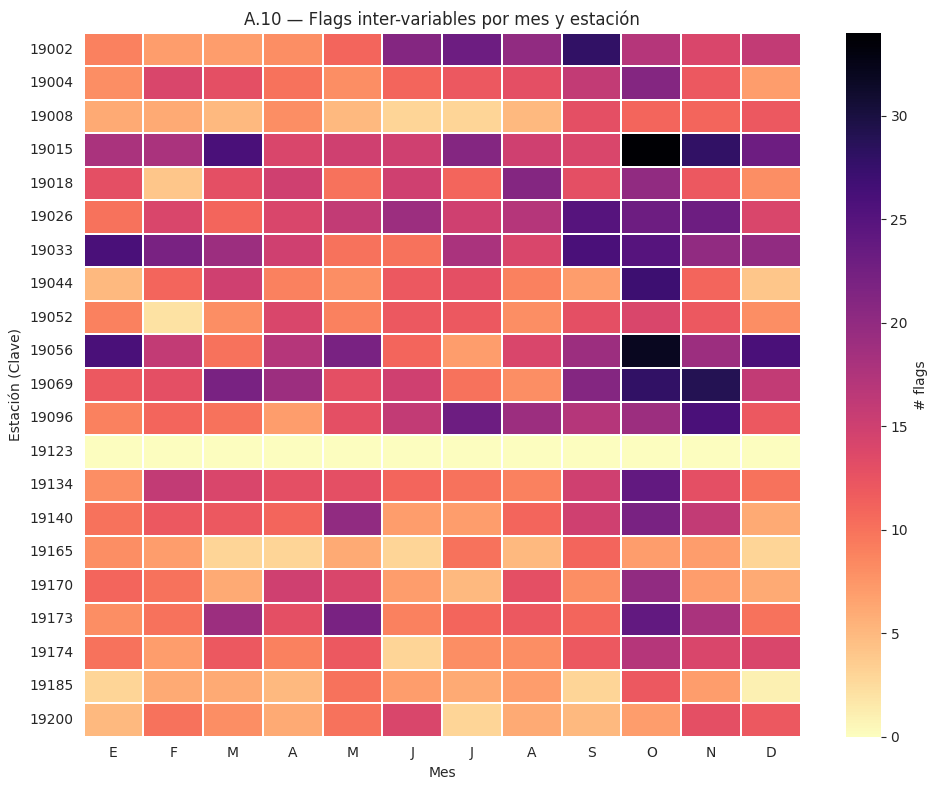

In [32]:
# ===== A.10 — Resumen mensual de flags por estación (meses con inicial) =====

assert 'records_a10' in globals(), "Falta records_a10 (A.10)."
df = records_a10.copy()
df["MES"] = df["FECHA"].dt.month

flag_cols = [c for c in ["flag_p_evap_hi","flag_p_tmax_hi","flag_p_tmin_hi"] if c in df.columns]
assert flag_cols, "No se encontraron columnas de flags en records_a10."

# 1) Tabla: conteo mensual por estación y flag
res_mes_flag = (
    df.groupby(["Clave","MES"])[flag_cols]
      .sum()
      .reset_index()
      .sort_values(["Clave","MES"])
)
display(res_mes_flag.head(12))

# 2) Heatmap: total de flags por estación×mes (con iniciales de mes)
res_mes_total = (
    df.assign(flag_any=df[flag_cols].any(axis=1))
      .groupby(["Clave","MES"])["flag_any"].sum()
      .reset_index(name="n_flags")
)

# Pivot y orden de meses 1..12
heat = (res_mes_total
        .pivot(index="Clave", columns="MES", values="n_flags")
        .reindex(columns=range(1,13))
        .fillna(0))

month_labels = ["E","F","M","A","M","J","J","A","S","O","N","D"]

plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    heat, cmap="magma_r", linewidths=.2, linecolor="white",
    cbar_kws={"label":"# flags"}
)
ax.set_title("A.10 — Flags inter-variables por mes y estación")
ax.set_xlabel("Mes"); ax.set_ylabel("Estación (Clave)")
# aplicar iniciales
ax.set_xticks(np.arange(heat.shape[1]) + 0.5)
ax.set_xticklabels(month_labels, rotation=0)
plt.tight_layout(); plt.show()


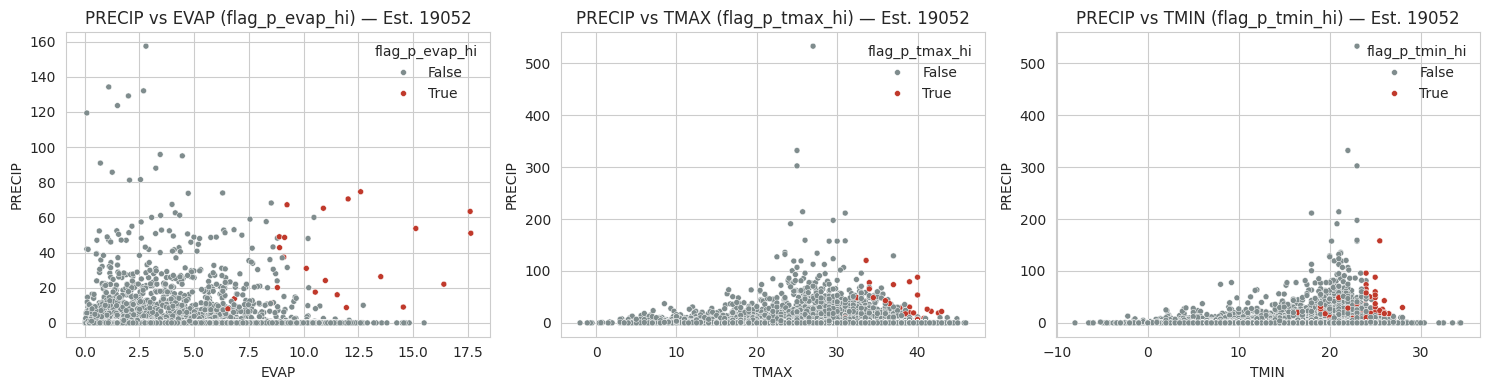

In [33]:
# ===== A.10 — Dispersión PRECIP vs (EVAP, TMAX, TMIN) con color por flag =====


TARGET = 19052  # cambia la estación
assert 'records_a10' in globals(), "Falta records_a10 (A.10)."
d0 = records_a10[records_a10["Clave"]==TARGET].copy()

pairs = []
if {"PRECIP","EVAP"}.issubset(d0.columns) and "flag_p_evap_hi" in d0.columns:
    pairs.append(("EVAP", "flag_p_evap_hi", "PRECIP vs EVAP (flag_p_evap_hi)"))
if {"PRECIP","TMAX"}.issubset(d0.columns) and "flag_p_tmax_hi" in d0.columns:
    pairs.append(("TMAX", "flag_p_tmax_hi", "PRECIP vs TMAX (flag_p_tmax_hi)"))
if {"PRECIP","TMIN"}.issubset(d0.columns) and "flag_p_tmin_hi" in d0.columns:
    pairs.append(("TMIN", "flag_p_tmin_hi", "PRECIP vs TMIN (flag_p_tmin_hi)"))

n = len(pairs)
assert n>0, "No hay pares disponibles para graficar."

sns.set_style("whitegrid")
fig, axes = plt.subplots(1, n, figsize=(5*n, 4), sharey=False)
if n == 1: axes = [axes]

for ax, (xvar, fcol, title) in zip(axes, pairs):
    sub = d0[[xvar, "PRECIP", fcol]].dropna()
    if sub.empty:
        ax.text(0.5, 0.5, "Sin datos", ha="center"); ax.set_axis_off(); continue
    sns.scatterplot(data=sub, x=xvar, y="PRECIP", hue=fcol, palette={False:"#7f8c8d", True:"#c0392b"},
                    s=18, ax=ax)
    ax.set_title(f"{title} — Est. {TARGET}")
    ax.legend(title=fcol, loc="best", frameon=False)

plt.tight_layout(); plt.show()


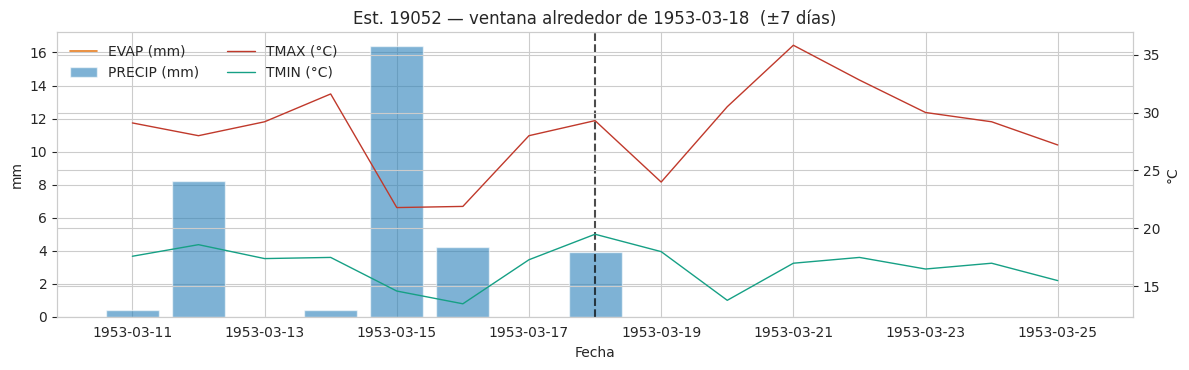

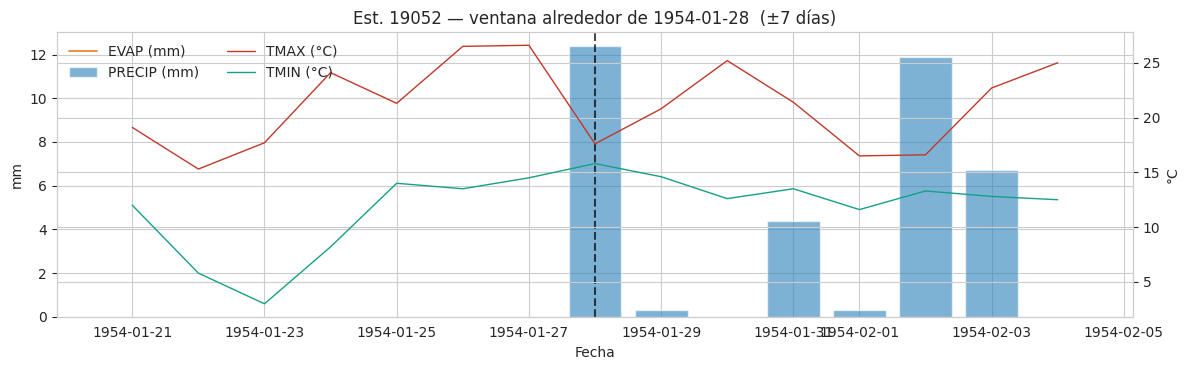

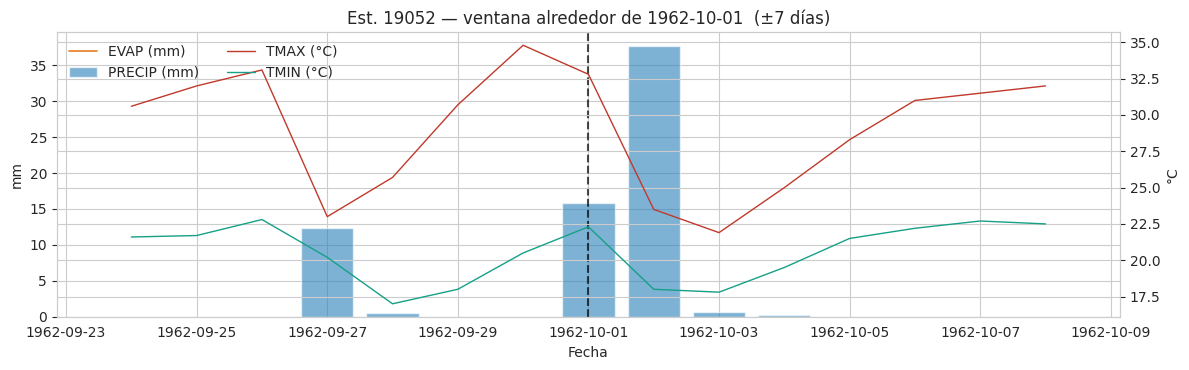

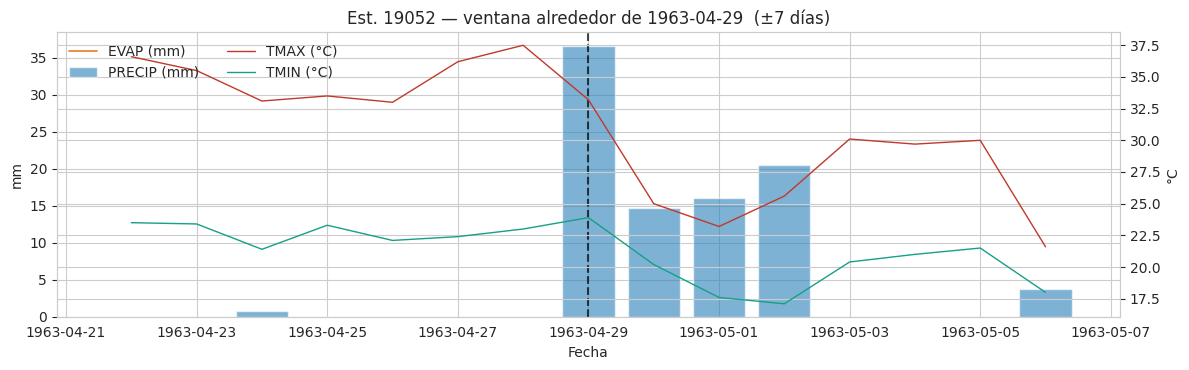

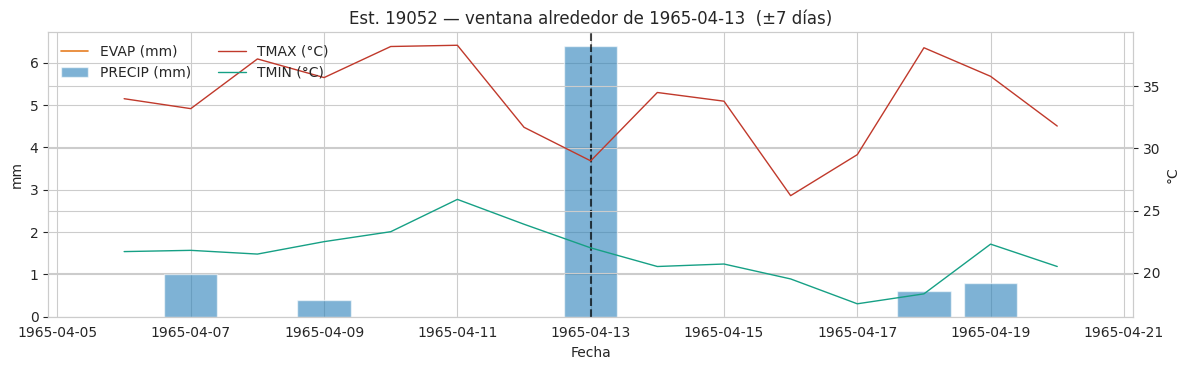

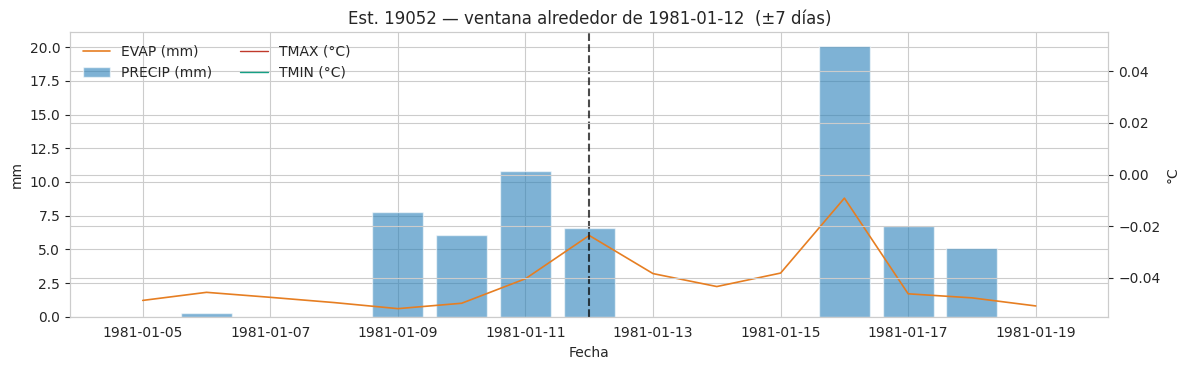

In [34]:
# ===== A.10 — Muestrario de días marcados (ventanas temporales) =====

TARGET = 19052       # estación a inspeccionar
WINDOW_DAYS = 7      # días a cada lado
N_SAMPLES = 6        # cuántas fechas marcadas mostrar

assert 'records_a10' in globals(), "Falta records_a10 (A.10)."
df = records_a10[records_a10["Clave"]==TARGET].copy()

flag_cols = [c for c in ["flag_p_evap_hi","flag_p_tmax_hi","flag_p_tmin_hi"] if c in df.columns]
assert flag_cols, "No hay columnas de flags."
df["flag_any"] = df[flag_cols].any(axis=1)

marked = df[df["flag_any"]].sort_values("FECHA")
if marked.empty:
    raise RuntimeError(f"No hay días marcados en la estación {TARGET}.")

# tomar muestra (primeros N o aleatorio)
sample_dates = marked["FECHA"].drop_duplicates().head(N_SAMPLES).tolist()

vars_to_plot = [v for v in ["PRECIP","EVAP","TMAX","TMIN"] if v in df.columns]

for d in sample_dates:
    win_start = d - pd.Timedelta(days=WINDOW_DAYS)
    win_end   = d + pd.Timedelta(days=WINDOW_DAYS)
    w = df[(df["FECHA"]>=win_start) & (df["FECHA"]<=win_end)].copy()

    fig, ax = plt.subplots(figsize=(12, 3.8))
    # PRECIP como barras si existe
    if "PRECIP" in vars_to_plot:
        ax.bar(w["FECHA"], w["PRECIP"], color="#2980B9", alpha=0.6, label="PRECIP (mm)")
    # EVAP
    if "EVAP" in vars_to_plot:
        ax.plot(w["FECHA"], w["EVAP"], color="#E67E22", lw=1.2, label="EVAP (mm)")
    # TMAX/TMIN (eje secundario)
    ax2 = ax.twinx()
    if "TMAX" in vars_to_plot:
        ax2.plot(w["FECHA"], w["TMAX"], color="#C0392B", lw=1.0, label="TMAX (°C)")
    if "TMIN" in vars_to_plot:
        ax2.plot(w["FECHA"], w["TMIN"], color="#16A085", lw=1.0, label="TMIN (°C)")

    # Línea vertical en la fecha marcada
    ax.axvline(d, color="black", linestyle="--", alpha=0.7)

    # Leyendas combinadas
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1+lines2, labels1+labels2, loc="upper left", frameon=False, ncol=2)

    ax.set_title(f"Est. {TARGET} — ventana alrededor de {d.date()}  (±{WINDOW_DAYS} días)")
    ax.set_xlabel("Fecha"); ax.set_ylabel("mm"); ax2.set_ylabel("°C")
    plt.tight_layout(); plt.show()


Se hizo flag de situaciones atipicas como alta evaporacion en dias con baja precipitacion o alta precipitacion en dias con alta temperatura. estas flags pueden significar errores. Sin embargo de acuerdo a las fechas, estos flags sucedieron antes de 1982, por lo que son irrelevantes ya que solo se trabajara a partir de 1982 dados los patrones de datos faltantes.

##A.11 Trazabilidad

In [35]:
# ===== A.11 — Trazabilidad y versionado de datos y decisiones =====
import os, json, hashlib, platform, sys, datetime as dt
import pandas as pd
from pathlib import Path

# --- Parámetros del snapshot ---
RUN_TS   = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
RUN_NAME = f"qc_snapshot_{RUN_TS}"
BASE_DIR = Path("outputs") / RUN_NAME
DIRS = {
    "raw":   BASE_DIR / "raw",     # crudo parseado (concatenado desde TXT)
    "qc":    BASE_DIR / "qc",      # estandarizado + artefactos QC (A.2–A.9/10)
    "ready": BASE_DIR / "ready",   # listo para análisis/modelado (previo a exclusiones A.9)
    "logs":  BASE_DIR / "logs",    # bitácoras, listas, correlaciones, etc.
}
for d in DIRS.values():
    d.mkdir(parents=True, exist_ok=True)

# --- Utilidades de hash/trazabilidad ---
def df_fingerprint(df: pd.DataFrame) -> str:
    h = pd.util.hash_pandas_object(df.sort_index(axis=1), index=True).values
    return hashlib.sha256(h.tobytes()).hexdigest()

def save_parquet(df, path: Path):
    df.to_parquet(path, index=False)

def manifest_entry(name, df, role, notes=""):
    return {
        "name": name,
        "role": role,  # raw | qc | ready | log
        "rows": int(df.shape[0]),
        "cols": int(df.shape[1]),
        "columns": list(map(str, df.columns)),
        "hash_sha256": df_fingerprint(df),
        "notes": notes,
    }

# --- Recolectar objetos existentes en sesión (según lo que tengas) ---
objs = {}

# RAW
if 'records_df_all' in globals():
    objs["raw/records_df_all.parquet"] = ("raw", records_df_all, "Concatenado de TXT (sin reindex calendario)")
elif 'records_df' in globals():
    objs["raw/records_df.parquet"] = ("raw", records_df, "Serie única parseada")

# QC (A.2–A.10)
if 'records_std' in globals():
    objs["qc/records_std.parquet"] = ("qc", records_std, "Calendario diario continuo por estación (A.2)")
if 'qc_log_df' in globals():
    objs["qc/qc_log_df.parquet"] = ("qc", qc_log_df, "Bitácora A.2 por estación (completitud por variable)")
if 'records_a4' in globals():
    objs["qc/records_a4.parquet"] = ("qc", records_a4, "Banderas de outliers (A.4)")
if 'res_a4' in globals():
    objs["qc/res_a4.parquet"] = ("qc", res_a4, "Resumen outliers por estación (A.4)")
if 'res_runs' in globals():
    objs["qc/res_runs.parquet"] = ("qc", res_runs, "Rachas/bloques de faltantes (A.5.3)")
if 'annual_df' in globals():
    objs["qc/annual_df.parquet"] = ("qc", annual_df, "Series anuales por estación/variable (A.6.2)")
if 'decadal' in globals():
    objs["qc/decadal.parquet"] = ("qc", decadal, "Medias por década (A.6.2)")
if 'breaks_df' in globals():
    objs["qc/breaks_df.parquet"] = ("qc", breaks_df, "Rupturas década-a-década (heurístico, A.6.2)")
if 'corr_ranked' in globals():
    objs["qc/corr_ranked.parquet"] = ("qc", corr_ranked, "Correlaciones espaciales (A.7.2)")
if 'neighbors_final' in globals():
    objs["qc/neighbors_final.parquet"] = ("qc", neighbors_final, "Vecinas finales sugeridas (A.7.4)")
# A.10 (consistencia inter-variable, renumerado)
if 'records_a10' in globals():
    objs["qc/records_a10.parquet"] = ("qc", records_a10, "Flags inter-variables (A.10)")
if 'res_a10' in globals():
    objs["qc/res_a10.parquet"] = ("qc", res_a10, "Resumen flags inter-variables por estación (A.10)")

# READY (puedes dejar records_std como base ready o incluir uno filtrado si lo generas)
if 'records_std' in globals():
    objs["ready/base_ready.parquet"] = ("ready", records_std, "Base lista para análisis (antes de exclusiones A.9)")

# LOGS (bitácoras/decisiones)
if 'homog_log' in globals():
    objs["logs/homog_log.parquet"] = ("logs", homog_log, "Bitácora de homogeneidad (A.9)")
if 'miss_rate_station_var' in globals():
    objs["logs/miss_rate_station_var.parquet"] = ("logs", miss_rate_station_var, "Tasa de faltantes por estación/variable (A.5.1)")

# --- Guardado y manifiesto ---
manifest = {
    "run_name": RUN_NAME,
    "timestamp": RUN_TS,
    "env": {"python": sys.version.split()[0], "pandas": pd.__version__, "platform": platform.platform()},
    "params": {
        "k_iqr_outliers": 3.5,
        "min_group_for_iqr": 8,
        "wet_threshold_mm": 1.0,
        "neighbors_max_radius_km": 30.0,
        "neighbors_k": 8,
        "corr_min_overlap_months": 60,
        "corr_strong_r": 0.60,
        "A10_P_Q": 0.95, "A10_E_Q": 0.95, "A10_T_Q": 0.90, "A10_MIN_N": 30,
    },
    "artifacts": [],
}

for rel_path, (role, df, note) in objs.items():
    full_path = DIRS[role] / Path(rel_path).name
    save_parquet(df, full_path)
    manifest["artifacts"].append(manifest_entry(str(Path(role)/Path(rel_path).name), df, role, note))

# Graba manifiesto JSON
with open(BASE_DIR / "manifest.json", "w", encoding="utf-8") as f:
    json.dump(manifest, f, ensure_ascii=False, indent=2)

# README breve
readme = f"""# Snapshot de QA/QC — {RUN_NAME}

Estructura:
- raw/: datos crudos parseados desde TXT.
- qc/: datos estandarizados (A.2) y artefactos QA/QC (A.3–A.10).
- ready/: base lista para análisis/modelado (previo a exclusiones A.9).
- logs/: bitácoras de homogeneidad y métricas de disponibilidad.

Consulta manifest.json para hashes, formas, columnas y parámetros usados.
"""

with open(BASE_DIR / "README.txt", "w", encoding="utf-8") as f:
    f.write(readme)

print(f"✓ Snapshot creado en: {BASE_DIR.resolve()}")
print("Archivos incluidos:")
for a in manifest["artifacts"]:
    print(" -", a["name"], f"({a['rows']}x{a['cols']})", a["hash_sha256"][:12], "…")


✓ Snapshot creado en: /content/outputs/qc_snapshot_20251102_213909
Archivos incluidos:
 - raw/records_df_all.parquet (363223x6) a7346f866b98 …
 - qc/records_std.parquet (420244x6) dec1a25f9bf2 …
 - qc/qc_log_df.parquet (21x9) f25254ebbadb …
 - qc/records_a4.parquet (420244x11) 9c24c484ceb1 …
 - qc/res_a4.parquet (21x6) ed600dfeb1a5 …
 - qc/res_runs.parquet (84x7) 2bcdc06c09f1 …
 - qc/annual_df.parquet (3582x5) 77e3d5893767 …
 - qc/decadal.parquet (467x4) 9f6607a25f98 …
 - qc/breaks_df.parquet (387x9) 67507de9a9d8 …
 - qc/corr_ranked.parquet (7x13) 6def432705ec …
 - qc/records_a10.parquet (420244x11) c4760edb7d2b …
 - qc/res_a10.parquet (21x5) 24baeb6ad0a5 …
 - ready/base_ready.parquet (420244x6) dec1a25f9bf2 …
 - logs/homog_log.parquet (617x12) 0c17beafb717 …
 - logs/miss_rate_station_var.parquet (84x6) d43e68fc432e …


In [36]:
#generar dataframe listo despues de QC para EDA

In [37]:
# ===== Base EDA =====
assert 'records_a10' in globals(), "Falta records_a10 (ejecuta A.10 primero)."
records_ready_eda = records_a10.copy()
print("Base EDA lista: records_ready_eda  →  ", records_ready_eda.shape)


Base EDA lista: records_ready_eda  →   (420244, 11)


#EDA


Se filtro para solo enfocar el EDA en la estacion de interes (Monterrey 19052) y las vecinas relevantes

In [38]:
# ===== Base EDA enfocada: 19052 + 6 vecinas fuertes =====


assert 'records_ready_eda' in globals(), "Falta records_ready_eda. Ejecuta la celda de 'Base EDA' primero."

TARGET = 19052
N_NEI = 6

# 1) Resolver lista de vecinas
neighbor_ids = []

if 'neighbors_final' in globals() and isinstance(neighbors_final, pd.DataFrame) and not neighbors_final.empty:
    neighbor_ids = neighbors_final['Clave_vecina'].astype(int).tolist()[:N_NEI]
elif 'neighbors_strong' in globals() and isinstance(neighbors_strong, pd.DataFrame) and not neighbors_strong.empty:
    neighbor_ids = neighbors_strong['Clave_vecina'].astype(int).tolist()[:N_NEI]
elif 'neighbors_19052' in globals() and isinstance(neighbors_19052, pd.DataFrame) and not neighbors_19052.empty:
    # si no se definió la lista final, usa las más cercanas como aproximación
    neighbor_ids = neighbors_19052['Clave'].astype(int).tolist()[:N_NEI]
else:
    # <-- alternativa manual (rellena si hiciera falta)
    # manual_neighbors = [19004, 19008, 19018, 19033, 19044, 19069]
    manual_neighbors = []
    neighbor_ids = manual_neighbors

if not neighbor_ids:
    raise RuntimeError("No se pudo resolver la lista de vecinas. Define 'neighbors_final'/'neighbors_strong' o rellena 'manual_neighbors'.")

# 2) Filtrar el DataFrame a 19052 + vecinas
keep_ids = sorted(set([TARGET] + neighbor_ids))
records_eda = records_ready_eda[records_ready_eda['Clave'].isin(keep_ids)].copy()
print(f"Estaciones incluidas para EDA: {keep_ids}")
print("Shape:", records_eda.shape)

# 3) (Opcional) mostrar tabla de estaciones seleccionadas con nombre si existe stations_df
try:
    sel_meta = stations_df[stations_df['Clave'].astype(int).isin(keep_ids)].copy()
    cols_show = [c for c in ["Clave","Nombre Estación","Municipio","lat","lon"] if c in sel_meta.columns]
    print("\nEstaciones seleccionadas:")
    display(sel_meta[cols_show].sort_values("Clave"))
except Exception:
    pass

# 4) Resumen rápido de cobertura (días válidos por variable)
vars_present = [v for v in ["PRECIP","EVAP","TMAX","TMIN"] if v in records_eda.columns]
cov = (records_eda
       .melt(id_vars=["Clave","FECHA"], value_vars=vars_present, var_name="variable", value_name="valor")
       .assign(valid=lambda d: d["valor"].notna().astype(int))
       .groupby(["Clave","variable"], as_index=False)["valid"].sum()
       .rename(columns={"valid":"n_dias_validos"}))
print("\nCobertura (días válidos) por estación y variable:")
display(cov.pivot(index="Clave", columns="variable", values="n_dias_validos").fillna(0).astype(int))


Estaciones incluidas para EDA: [19004, 19015, 19052, 19096, 19134, 19185, 19200]
Shape: (128689, 11)

Estaciones seleccionadas:


Clave   Nombre Estación                 Municipio        lat         lon
1   19004           APODACA                   APODACA  25.793611 -100.197222
5   19015        EL CERRITO                  SANTIAGO  25.510000 -100.193333
15  19052   MONTERREY (OBS)  SAN NICOLÁS DE LOS GARZA  25.733611 -100.304722
12  19096    LA HUASTEQUITA            SANTA CATARINA  25.638611 -100.455000
17  19134  SALINAS VICTORIA          SALINAS VICTORIA  25.959167 -100.292778
4   19185         EL CANADA          GENERAL ESCOBEDO  25.800556 -100.275556
11  19200        LA CIENEGA                    JUÁREZ  25.536389 -100.119167


Cobertura (días válidos) por estación y variable:


variable   EVAP  PRECIP   TMAX   TMIN
Clave                                
19004         0   17160  17118  17118
19015     11928   20998  15358  15358
19052      8561   24499  23604  23604
19096      8671   16529  14878  14878
19134      8456   15694  15679  15679
19185      4397    8072   8204   8204
19200      1822    8401   8297   8297

In [39]:
#Filtrar unicamente mty.
TARGET = 19052
N_NEI = 6

keep_ids = sorted(set([TARGET] ))
records_edamty = records_ready_eda[records_ready_eda['Clave'].isin(keep_ids)].copy()

print(f"Estaciones incluidas para EDA: {keep_ids}")
print("Shape:", records_eda.shape)




Estaciones incluidas para EDA: [19052]
Shape: (128689, 11)


In [40]:
records_edamty.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27318 entries, 198933 to 226250
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   FECHA              27318 non-null  datetime64[ns]
 1   PRECIP             24499 non-null  float64       
 2   EVAP               8561 non-null   float64       
 3   TMAX               23604 non-null  float64       
 4   TMIN               23604 non-null  float64       
 5   Clave              27318 non-null  int64         
 6   MES                27318 non-null  int32         
 7   flag_p_evap_hi     27318 non-null  bool          
 8   flag_p_tmax_hi     27318 non-null  bool          
 9   flag_p_tmin_hi     27318 non-null  bool          
 10  flag_intervar_any  27318 non-null  bool          
dtypes: bool(4), datetime64[ns](1), float64(4), int32(1), int64(1)
memory usage: 1.7 MB


##b1.	Tendencia central, variabilidad y forma:

In [41]:
records_edamty.describe()

FECHA        PRECIP         EVAP          TMAX  \
count                27318  24499.000000  8561.000000  23604.000000   
mean   1988-05-24 12:00:00      1.661772     4.743835     28.883876   
min    1951-01-01 00:00:00      0.000000     0.020000     -2.000000   
25%    1969-09-12 06:00:00      0.000000     2.530000     24.500000   
50%    1988-05-24 12:00:00      0.000000     4.460000     30.000000   
75%    2007-02-03 18:00:00      0.000000     6.680000     34.400000   
max    2025-10-16 00:00:00    533.000000    17.630000     46.000000   
std                    NaN      8.901458     2.757843      7.192337   

               TMIN    Clave           MES  
count  23604.000000  27318.0  27318.000000  
mean      17.226825  19052.0      6.509847  
min       -8.000000  19052.0      1.000000  
25%       13.000000  19052.0      4.000000  
50%       18.700000  19052.0      7.000000  
75%       22.200000  19052.0      9.000000  
max       34.400000  19052.0     12.000000  
std        5.965732      0.0      3.444458

##Umbral de Dias Humedos

Ya que se sabe que la serie de precipitacion tiene muchos ceros, de acuerdo a la literatura es util separar la ocurrencia del monto y analizar la distribucion y tendencia de los dias con ocurrencia para evitar que los ceros sesguen los resutlados.

Aunque el umbral “climatológico” de día húmedo (wet day) para índices climatologicos WMO emplea PRECIP ≥ 1 mm, para la imputación con fines hidrológicos adoptamos RR ≥ 0.2 mm, consistente con las prácticas instrumentales WMO: la Guía WMO-No. 8 indica que los totales diarios se leen al 0.2 mm y, si es factible, al 0.1 mm, considerando < 0.1 mm como traza (en EE. UU. < 0.2 mm). Las Normas Mexicanas NMX-AA-166 (CONAGUA/SMN) alinean especificaciones y operación con WMO-No. 8; en la práctica, los pluviómetros de cubeta en México operan en 0.2 mm (y 0.1 mm en algunos sitios), por lo que PRECIP ≥ 0.2 mm es un umbral que permite tomar en cuenta lluvias acumuladas medibles y relevantes para escorrentía, manteniendo compatibilidad con la instrumentación. Es decir no clasifica como "trazas" o secos mediciones pequenas

In [42]:
wet_thr = 0.2  # mm Este es el umbral seleccionado.

In [43]:
# ===== B.1 — PRECIP (solo estación 19052) =====
dfm = records_edamty.copy()
assert {"FECHA","Clave","PRECIP"}.issubset(dfm.columns)


p = dfm[["FECHA","PRECIP"]].dropna().copy()
p["wet"] = (p["PRECIP"] >= wet_thr).astype(int)

# 1) Ocurrencia
occ_pct = round(p["wet"].mean()*100, 2)

# 2) Monto condicional
pw = p.loc[p["wet"]==1, "PRECIP"].copy()
if pw.empty:
    precip_cond_stats = pd.Series({
        "n_wet": 0, "mean": np.nan, "median": np.nan, "std": np.nan,
        "IQR": np.nan, "CV": np.nan, "skew": np.nan, "kurt": np.nan,
        "p95": np.nan, "p99": np.nan
    })
else:
    precip_cond_stats = pd.Series({
        "n_wet": int(pw.size),
        "mean": float(pw.mean()),
        "median": float(pw.median()),
        "std": float(pw.std()),
        "IQR": float(pw.quantile(0.75) - pw.quantile(0.25)),
        "CV":  float(pw.std()/pw.mean()) if pw.mean()!=0 else np.nan,
        "skew": float(pw.skew()),
        "kurt": float(pw.kurt()),
        "p95": float(pw.quantile(0.95)),
        "p99": float(pw.quantile(0.99)),
    })

print(f"B.1 PRECIP — % días con lluvia (≥{wet_thr} mm): {occ_pct}%")
display(precip_cond_stats.to_frame("PRECIP_cond (>={wet_thr}mm)").T)


B.1 PRECIP — % días con lluvia (≥0.2 mm): 18.12%


n_wet      mean  median       std  IQR  \
PRECIP_cond (>={wet_thr}mm)  4440.0  9.163324     3.2  19.19748  8.6   

                                   CV      skew        kurt   p95     p99  
PRECIP_cond (>={wet_thr}mm)  2.095034  9.357096  172.058601  37.0  78.771

Baja frecuencia de días lluviosos (18.1 % con valores ≥ 0.2 mm), lo que evidencia una marcada intermitencia en la ocurrencia de lluvia. Los eventos húmedos presentan alta variabilidad (CV ≈ 2.1) y una distribución fuertemente asimétrica (skew ≈ 9.4; kurtosis ≈ 172), con predominio de lluvias de baja magnitud y pocos episodios intensos que elevan el promedio. Los cuantiles altos (p95 ≈ 37 mm y p99 ≈ 78.8 mm) confirman la presencia ocasional de eventos extremos.

In [44]:
# ===== B.1 — EVAP / TMAX / TMIN (solo estación 19052) =====


dfm = records_edamty.copy()
vars_cts = [v for v in ["EVAP","TMAX","TMIN"] if v in dfm.columns]

def stats_cont(s):
    s = s.dropna()
    if s.empty:
        return pd.Series({"n":0,"mean":np.nan,"median":np.nan,"std":np.nan,"IQR":np.nan,
                          "CV":np.nan,"skew":np.nan,"kurt":np.nan,
                          "p5":np.nan,"p25":np.nan,"p50":np.nan,"p75":np.nan,"p95":np.nan,"p99":np.nan})
    return pd.Series({
        "n": int(s.size),
        "mean": float(s.mean()),
        "median": float(s.median()),
        "std": float(s.std()),
        "IQR": float(s.quantile(0.75) - s.quantile(0.25)),
        "CV":  float(s.std()/s.mean()) if s.mean()!=0 else np.nan,
        "skew": float(s.skew()),
        "kurt": float(s.kurt()),
        "p5":  float(s.quantile(0.05)),
        "p25": float(s.quantile(0.25)),
        "p50": float(s.quantile(0.50)),
        "p75": float(s.quantile(0.75)),
        "p95": float(s.quantile(0.95)),
        "p99": float(s.quantile(0.99)),
    })

rows = []
for var in vars_cts:
    rows.append(stats_cont(dfm[var]).rename(var))
summary_cts_mty = pd.DataFrame(rows)
display(summary_cts_mty)


n       mean  median       std   IQR        CV      skew  \
EVAP   8561.0   4.743835    4.46  2.757843  4.15  0.581353  0.451656   
TMAX  23604.0  28.883876   30.00  7.192337  9.90  0.249009 -0.758586   
TMIN  23604.0  17.226825   18.70  5.965732  9.20  0.346305 -0.693982   

          kurt     p5    p25    p50    p75   p95    p99  
EVAP -0.339044   0.76   2.53   4.46   6.68   9.6  11.39  
TMAX  0.267551  15.00  24.50  30.00  34.40  38.5  40.50  
TMIN -0.340723   6.00  13.00  18.70  22.20  24.4  25.50

La serie muestra distinta cobertura: EVAP (n≈8,561) frente a TMAX y TMIN (n≈23,604). Las medianas indican un régimen cálido (TMAX ≈ 30.0 °C; TMIN ≈ 18.7 °C) y evaporación típica de 4.46 mm día⁻¹. La variabilidad relativa es mayor en EVAP (CV≈0.58) que en TMAX (0.25) y TMIN (0.35). Las temperaturas presentan asimetría ligera negativa (colas hacia valores bajos), mientras que EVAP es levemente asimétrica positiva. Los cuantiles altos confirman extremos puntuales: TMAX p95 ≈ 40.5 °C, TMIN p5 ≈ 13 °C y EVAP p95 ≈ 11.4 mm día⁻¹. Estos patrones sugieren estacionalidad marcada y la conveniencia de modelar EVAP con especial atención a su mayor dispersión.

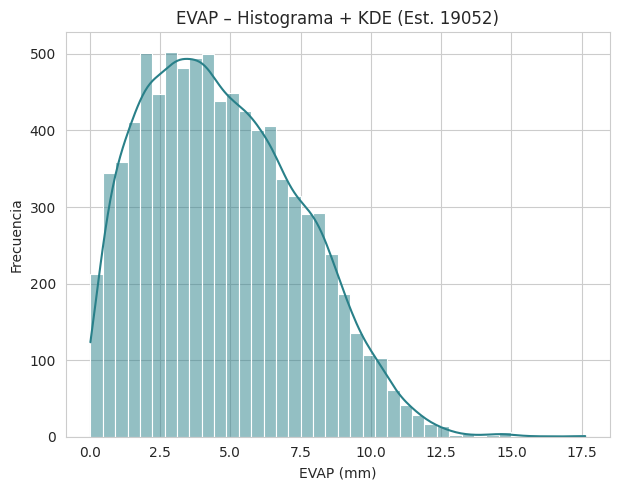

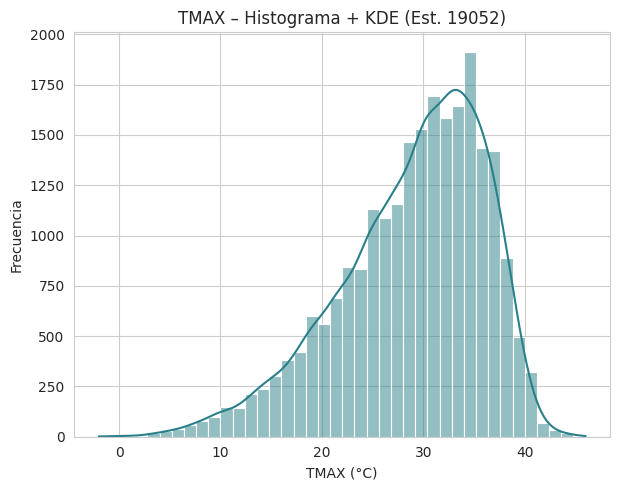

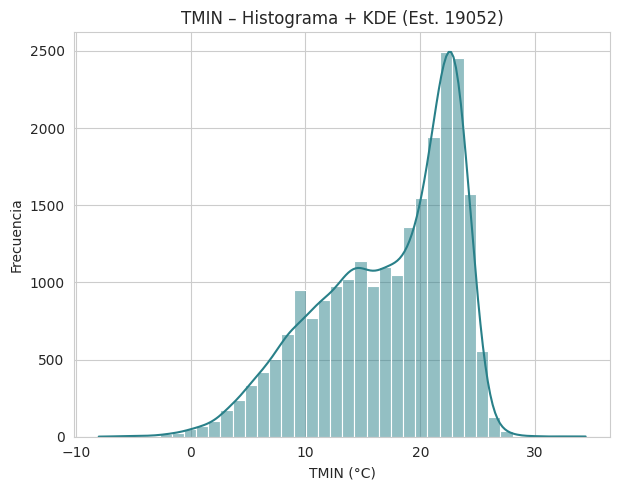

In [45]:
# B.1.2 – Histogramas + KDE (EVAP, TMAX, TMIN) – MTY (19052)

dfm = records_edamty.copy()
vars_cts = [v for v in ["TMAX", "TMIN"] if v in dfm.columns]

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

# Ejemplo individual (opcional)
VAR = "EVAP"
plt.figure(figsize=(6.3, 5))
sns.histplot(data=dfm, x=VAR, bins=40, kde=True, color="#298089")
plt.title(f"{VAR} – Histograma + KDE (Est. 19052)")
plt.xlabel(f"{VAR} (mm)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()


for VAR in vars_cts:
    plt.figure(figsize=(6.3, 5))
    sns.histplot(data=dfm, x=VAR, bins=40, kde=True, color="#298089")
    plt.title(f"{VAR} – Histograma + KDE (Est. 19052)")
    plt.xlabel(f"{VAR} (°C)")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()


% de días con lluvia (≥0.2 mm): 18.12%


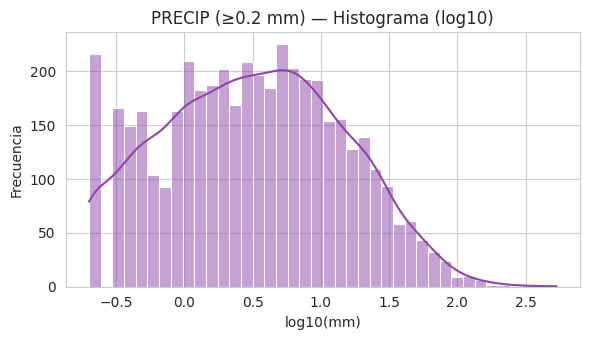

In [46]:
#Histograma Precipitacion + KDE
# Reusa variables de B.1: wet_thr, p (PRECIP sin NaN) y p["wet"]

# % de días con lluvia (coincide con B.1)
wet = p["wet"].mean() * 100
print(f"% de días con lluvia (≥{wet_thr} mm): {wet:.2f}%")

# Histograma de montos en días húmedos (≥ wet_thr), en log10
pw = p.loc[p["wet"] == 1, "PRECIP"]
if not pw.empty:
    plt.figure(figsize=(6,3.5))
    sns.histplot(np.log10(pw), bins=40, kde=True, color="#8E44AD")
    plt.title(f"PRECIP (≥{wet_thr} mm) — Histograma (log10)")
    plt.xlabel("log10(mm)")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()
else:
    print("No hay días húmedos con el umbral especificado.")



EVAP — Histograma + KDE: Distribución unimodal con asimetría positiva: muchos días con 2–6 mm y una cola derecha que alcanza >10 mm. Coherente con el CV alto y p95 ≈ 11.4 mm/día; sugiere estacionalidad marcada y episodios puntuales de evaporación elevada.

TMAX — Histograma + KDE: Masa principal entre 28–35 °C, con asimetría ligera a la izquierda y decaimiento rápido hacia >40 °C. En línea con mediana ≈ 30 °C y p95 ≈ 40–41 °C; patrón típico de clima cálido con calor extremo ocasional.

TMIN — Histograma + KDE: Distribución más concentrada en 18–24 °C, también con sesgo leve a la izquierda (noches frescas esporádicas) y poca presencia de valores muy bajos; consistente con p5 ≈ 13 °C.

PRECIP (≥0.2 mm) — Histograma en log10: Montos “en días húmedos” con forma cercana a log-normal (cola derecha pesada), muchos eventos pequeños y pocos grandes; coincide con skew alto, kurtosis elevada y cuantiles superiores (p95 ≈ 37 mm, p99 ≈ 79 mm).

Resumen: Lluvia intermitente y sesgada (cola pesada), temperaturas cálidas con variabilidad moderada y evaporación más variable que TMAX/TMIN. Esto respalda el enfoque en dos etapas (ocurrencia y monto) y el cuidado con extremos al modelar o imputar.

/tmp/ipython-input-2908143962.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=dfm["EVAP"], palette="pastel")


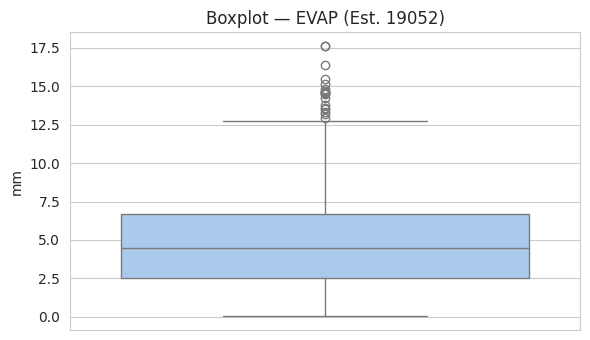

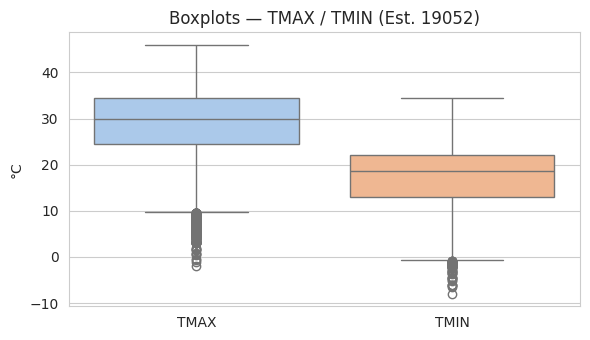

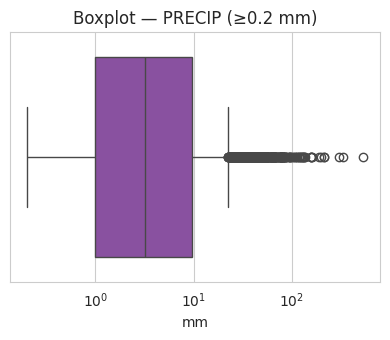

In [47]:
# B.1.2 — Boxplots simples (EVAP, TMAX, TMIN, PRECIP>0) — MTY (19052)

dfm = records_edamty.copy()
vars_cts = [v for v in ["TMAX","TMIN"] if v in dfm.columns]

#BOXPLOT EVAP
plt.figure(figsize=(6,3.5))
sns.boxplot(data=dfm["EVAP"], palette="pastel")
plt.title("Boxplot — EVAP (Est. 19052)")
plt.ylabel("mm")
plt.tight_layout(); plt.show()

# A) Boxplots simples (T)
if vars_cts:
    plt.figure(figsize=(6,3.5))
    sns.boxplot(data=dfm[vars_cts], palette="pastel")
    plt.title("Boxplots — TMAX / TMIN (Est. 19052)")
    plt.ylabel("°C")
    plt.tight_layout(); plt.show()

if not pw.empty:
    plt.figure(figsize=(4,3.5))
    sns.boxplot(x=pw, color="#8E44AD")
    plt.title(f"Boxplot — PRECIP (≥{wet_thr} mm)")
    plt.xlabel("mm")
    plt.xscale("log")
    plt.tight_layout(); plt.show()


En EVAP, la mediana se sitúa cerca de 4.5–5 mm día⁻¹ y el IQR alrededor de 3–6.5 mm; la presencia de numerosos outliers altos (≈13–18 mm) confirma la cola derecha y episodios puntuales de evaporación muy elevada. En TMAX/TMIN, las medianas (~30 °C y ~19 °C) y sus IQR (≈25–34 °C; 15–22 °C) indican régimen cálido con variabilidad moderada; aparecen pocos extremos cálidos (TMAX > 40 °C) y outliers fríos aislados (incluidos valores <0 °C) que conviene revisar como posible QC. El boxplot de PRECIP (escala log10, días ≥0.2 mm) muestra un IQR concentrado en montos bajos y una cola superior larga con muchos outliers, coherente con la distribución sesgada de la lluvia: predominan eventos pequeños y pocos episodios intensos. Estos patrones respaldan análisis robustos a outliers y, para precipitación, un enfoque en dos etapas (ocurrencia y monto).

/tmp/ipython-input-827243907.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=dfm, x="MES", y="TMAX", palette="Greens")


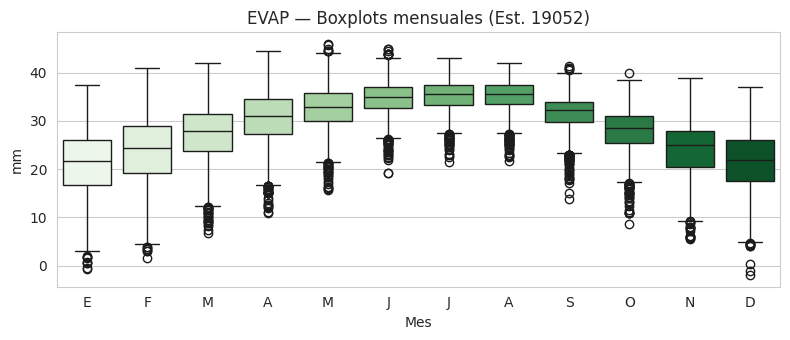

/tmp/ipython-input-827243907.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=dfm, x="MES", y="TMAX", palette="Reds")


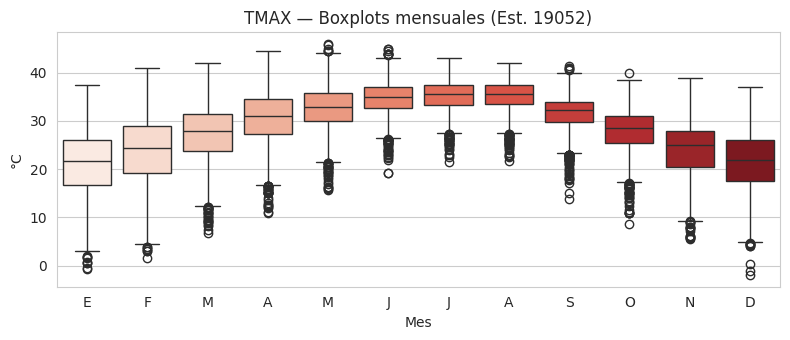

/tmp/ipython-input-827243907.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=dfm, x="MES", y="TMAX", palette="Blues")


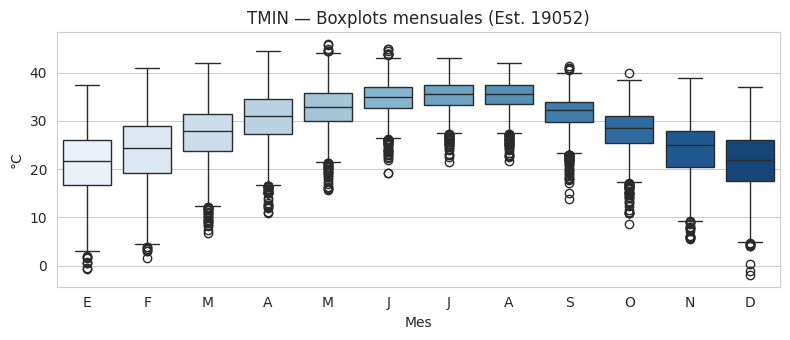

In [48]:
# B)  Boxplots mensuales para estacionalidad
if "FECHA" in dfm.columns:
    dfm["MES"] = dfm["FECHA"].dt.month
    month_labels = ["E","F","M","A","M","J","J","A","S","O","N","D"]

        # EVAP
    if "EVAP" in dfm.columns:
        plt.figure(figsize=(8,3.5))
        sns.boxplot(data=dfm, x="MES", y="TMAX", palette="Greens")
        plt.title("EVAP — Boxplots mensuales (Est. 19052)")
        plt.xlabel("Mes"); plt.ylabel("mm")
        plt.xticks(ticks=range(12), labels=month_labels)
        plt.tight_layout(); plt.show()

    # Ejemplo: TMAX por mes
    if "TMAX" in dfm.columns:
        plt.figure(figsize=(8,3.5))
        sns.boxplot(data=dfm, x="MES", y="TMAX", palette="Reds")
        plt.title("TMAX — Boxplots mensuales (Est. 19052)")
        plt.xlabel("Mes"); plt.ylabel("°C")
        plt.xticks(ticks=range(12), labels=month_labels)
        plt.tight_layout(); plt.show()

    # tmin
    if "TMIN" in dfm.columns:
        plt.figure(figsize=(8,3.5))
        sns.boxplot(data=dfm, x="MES", y="TMAX", palette="Blues")
        plt.title("TMIN — Boxplots mensuales (Est. 19052)")
        plt.xlabel("Mes"); plt.ylabel("°C")
        plt.xticks(ticks=range(12), labels=month_labels)
        plt.tight_layout(); plt.show()



 Los boxplots mensuales evidencian una señal estacional clara: EVAP aumenta desde finales de invierno hasta verano (J–A) y desciende en otoño–invierno, en concordancia con el ciclo térmico. En TMAX se observan medianas y cuartiles más altos en verano y más bajos en invierno, con mayor dispersión en meses de transición (M–M y S–O), donde aparecen tanto días templados como episodios cálidos. TMIN muestra un patrón similar, con noches más cálidas en verano y noches más frescas en D–F; los outliers fríos invernales sugieren revisar calidad de datos y/o condiciones locales (advecciones, microclima). La presencia de outliers altos en EVAP y TMAX confirma episodios extremos esporádicos. Estos patrones justifican análisis estratificados por mes/estación y el uso de modelos que permitan heterocedasticidad estacional.

/tmp/ipython-input-1727619133.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


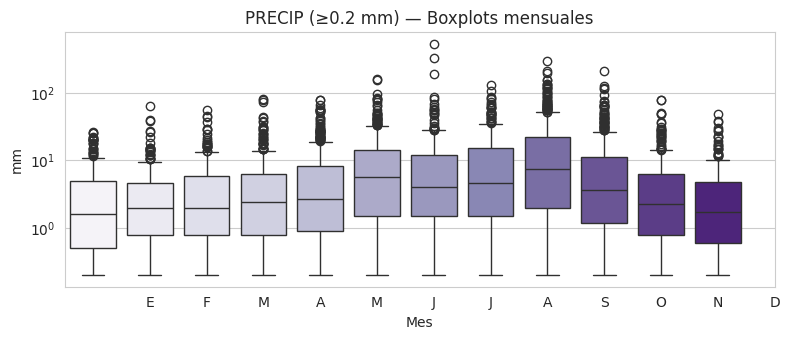

In [49]:
# ===== Boxplots mensuales — PRECIP (≥ wet_thr) =====
# (opcional) si ya definiste wet_thr antes, se respeta; si no, se fija en 0.2
try:
    wet_thr
except NameError:
    wet_thr = 0.2  # mm

# (opcional) filtra estación si corresponde
# dfm = dfm[dfm["Clave"] == 19052].copy()

# Asegura tipo datetime y crea MES
dfm = dfm.copy()
dfm["FECHA"] = pd.to_datetime(dfm["FECHA"], errors="coerce")

# Filtra días húmedos y elimina NaN de PRECIP y FECHA
df_wet = dfm.loc[dfm["PRECIP"] >= wet_thr, ["FECHA", "PRECIP"]].dropna(subset=["FECHA","PRECIP"])
df_wet["MES"] = df_wet["FECHA"].dt.month

# Etiquetas de meses (1–12)
month_labels = ["E","F","M","A","M","J","J","A","S","O","N","D"]

if not df_wet.empty:
    plt.figure(figsize=(8,3.5))
    sns.boxplot(
        data=df_wet, x="MES", y="PRECIP",
        order=list(range(1,13)), palette="Purples"
    )
    plt.title(f"PRECIP (≥{wet_thr} mm) — Boxplots mensuales")
    plt.xlabel("Mes"); plt.ylabel("mm")
    plt.xticks(ticks=range(1,13), labels=month_labels)
    plt.yscale("log")
    plt.tight_layout(); plt.show()
else:
    print(f"No hay datos de PRECIP ≥ {wet_thr} mm para graficar.")


Pie de figura. Boxplots mensuales de PRECIP (≥0.2 mm) en escala log10 muestran estacionalidad marcada: medianas e IQR más altos de mayo a septiembre (pico en J–A), y valores más bajos en invierno (D–F). En todos los meses la distribución es asimétrica con cola superior larga, pero la dispersión y la frecuencia de outliers (eventos intensos) aumentan en verano. La escala logarítmica resalta que, aun en los meses húmedos, predominan montos pequeños y pocos episodios grandes. Estos patrones sugieren usar estadísticos robustos y, para modelar, un enfoque en dos etapas (ocurrencia y monto condicional).

##B2 estacionalidad y dependencia

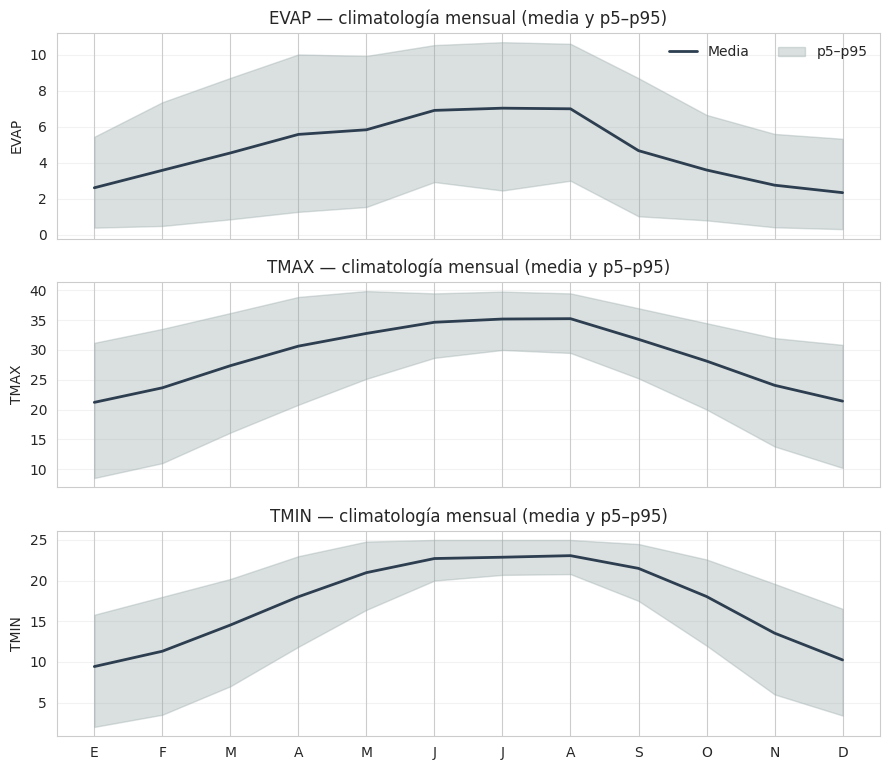

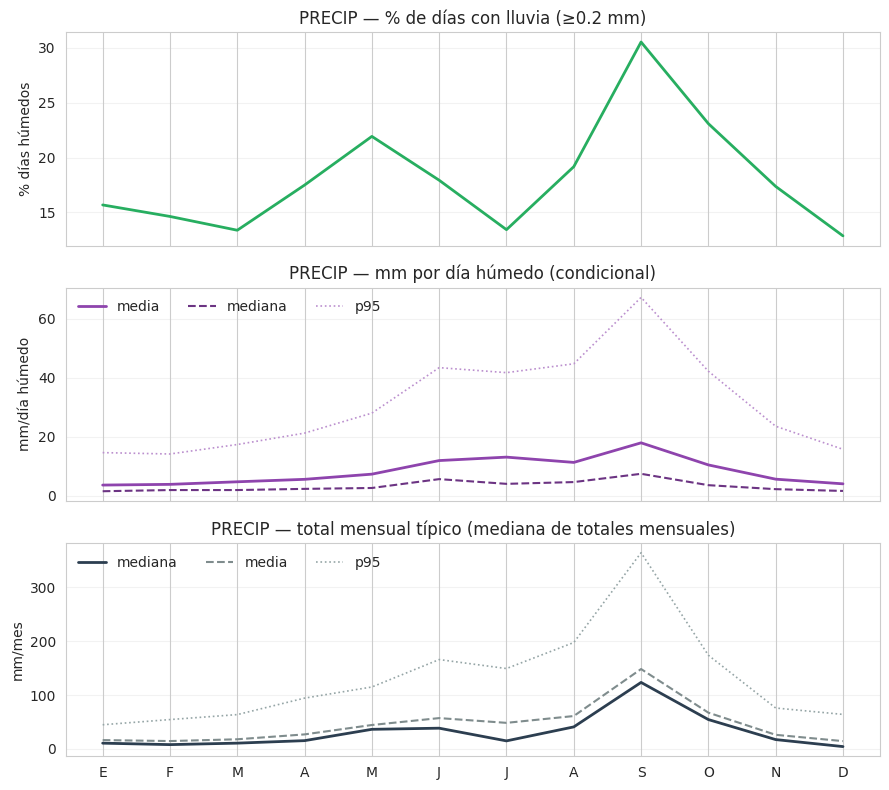

In [50]:
# ===== B.2.1 — Climatología mensual “rica” (Estación 19052) =====
try:
    wet_thr
except NameError:
    wet_thr = 0.2  # mm

sns.set_style("whitegrid")

dfm = records_edamty.copy()
assert {"FECHA","Clave"}.issubset(dfm.columns)
# Seguridad: asegurar 19052 solamente
if dfm["Clave"].nunique() != 1 or int(dfm["Clave"].unique()[0]) != 19052:
    raise RuntimeError("records_edamty no está filtrado a 19052.")

dfm["MES"] = dfm["FECHA"].dt.month
month_labels = ["E","F","M","A","M","J","J","A","S","O","N","D"]

# -----------------------------------------------------------
# 1) EVAP / TMAX / TMIN: media mensual + banda p5–p95
# -----------------------------------------------------------
vars_cts = [v for v in ["EVAP","TMAX","TMIN"] if v in dfm.columns]
ct_stats = {}
for VAR in vars_cts:
    g = (dfm[["MES", VAR]]
         .dropna()
         .groupby("MES")[VAR]
         .agg(mean="mean",
              p05=lambda s: s.quantile(0.05),
              p95=lambda s: s.quantile(0.95),
              n="count")
         .reindex(range(1,13)))
    ct_stats[VAR] = g

# --- Gráfica (hasta 3 paneles apilados) ---
if vars_cts:
    fig, axes = plt.subplots(len(vars_cts), 1, figsize=(9, 2.6*len(vars_cts)), sharex=True)
    if len(vars_cts) == 1:
        axes = [axes]
    for ax, VAR in zip(axes, vars_cts):
        g = ct_stats[VAR]
        ax.plot(range(1,13), g["mean"], color="#2C3E50", lw=2, label="Media")
        ax.fill_between(range(1,13), g["p05"], g["p95"], color="#95A5A6", alpha=0.35, label="p5–p95")
        ax.set_title(f"{VAR} — climatología mensual (media y p5–p95)")
        ax.set_ylabel(VAR)
        ax.grid(True, axis="y", alpha=0.25)
    axes[-1].set_xticks(range(1,13)); axes[-1].set_xticklabels(month_labels)
    axes[0].legend(frameon=False, ncol=2, loc="upper right")
    plt.tight_layout(); plt.show()

# -----------------------------------------------------------
# 2) PRECIP: ocurrencia, monto condicional y total mensual típico
# -----------------------------------------------------------
if "PRECIP" in dfm.columns:


    # Ocurrencia (% de días con lluvia) por MES (sobre días válidos)
    p = dfm[["FECHA","MES","PRECIP"]].copy()
    p["is_valid"] = p["PRECIP"].notna()
    p["wet"] = (p["PRECIP"] >= wet_thr) & p["is_valid"]

    occ = (p.groupby("MES")
             .agg(n_days=("is_valid","sum"),
                  n_wet =("wet","sum"))
             .assign(occ_pct=lambda d: np.where(d["n_days"]>0, 100*d["n_wet"]/d["n_days"], np.nan))
             .reindex(range(1,13)))

    # Monto condicional (mm/día húmedo)
    cond = (p.loc[p["wet"]]
              .groupby("MES")["PRECIP"]
              .agg(cond_mean="mean", cond_median="median", cond_p95=lambda s: s.quantile(0.95))
              .reindex(range(1,13)))

    # Total mensual típico (sumar por mes-año y mediana entre años)
    p["AÑO"] = p["FECHA"].dt.year
    monthly_tot = (p.groupby(["AÑO","MES"])["PRECIP"].sum().reset_index(name="tot_mm"))
    tot_typ = (monthly_tot.groupby("MES")["tot_mm"]
                        .agg(tot_med="median", tot_mean="mean", tot_p95=lambda s: s.quantile(0.95))
                        .reindex(range(1,13)))

    # --- Gráfica de 3 paneles (ocurrencia / condicional / total típico) ---
    fig, axes = plt.subplots(3, 1, figsize=(9, 8), sharex=True)

    # (1) Ocurrencia
    axes[0].plot(range(1,13), occ["occ_pct"], color="#27AE60", lw=2)
    axes[0].set_title(f"PRECIP — % de días con lluvia (≥{wet_thr} mm)")
    axes[0].set_ylabel("% días húmedos")
    axes[0].grid(True, axis="y", alpha=0.25)

    # (2) Monto condicional
    axes[1].plot(range(1,13), cond["cond_mean"], color="#8E44AD", lw=2, label="media")
    axes[1].plot(range(1,13), cond["cond_median"], color="#6C3483", lw=1.5, linestyle="--", label="mediana")
    axes[1].plot(range(1,13), cond["cond_p95"], color="#BB8FCE", lw=1.2, linestyle=":", label="p95")
    axes[1].set_title("PRECIP — mm por día húmedo (condicional)")
    axes[1].set_ylabel("mm/día húmedo"); axes[1].legend(frameon=False, ncol=3)
    axes[1].grid(True, axis="y", alpha=0.25)

    # (3) Total mensual típico
    axes[2].plot(range(1,13), tot_typ["tot_med"], color="#2C3E50", lw=2, label="mediana")
    axes[2].plot(range(1,13), tot_typ["tot_mean"], color="#7F8C8D", lw=1.5, linestyle="--", label="media")
    axes[2].plot(range(1,13), tot_typ["tot_p95"], color="#95A5A6", lw=1.2, linestyle=":", label="p95")
    axes[2].set_title("PRECIP — total mensual típico (mediana de totales mensuales)")
    axes[2].set_ylabel("mm/mes"); axes[2].legend(frameon=False, ncol=3)
    axes[2].grid(True, axis="y", alpha=0.25)

    axes[2].set_xticks(range(1,13)); axes[2].set_xticklabels(month_labels)
    plt.tight_layout(); plt.show()
else:
    print("PRECIP no está disponible en records_edamty.")


Climatología mensual de EVAP, TMAX y TMIN (media y banda p5–p95). Se aprecia una estacionalidad nítida: EVAP aumenta desde primavera y alcanza un máximo en J–A, para luego descender en O–F. TMAX y TMIN siguen el mismo ciclo térmico, con mesetas cálidas en verano y mínimos invernales. Las bandas p5–p95 se ensanchan en meses de transición (M–M y S–O), indicando mayor dispersión intra-mensual, y se estrechan en verano, cuando el régimen térmico es más estable.

PRECIP — ocurrencia, monto condicional y total mensual típico. El % de días húmedos (≥0.2 mm) aumenta hacia el verano y culmina en septiembre, cuando también se observa el pico del monto condicional (medias y p95 más altos), señal de eventos más intensos en esa época. La mediana del total mensual reproduce ese patrón, con máximos en S–O y mínimos en D–F. En conjunto, la estación muestra una temporada seca invernal y una temporada lluviosa tardía, con pocos días de lluvia pero de mayor intensidad en su pico estacional.

In [51]:
##B2.2 NORMALES 30 ANIOS Y ANOMALIAS MENSUALES.

# --- CONFIGURACIÓN ---
BASE_START, BASE_END = 1991, 2020   # este periodo se elige de acuerdo a los lineamientos de la WMO donde deben usarse decadas completas juntando 30 anios

df0 = records_edamty.copy()
assert (df0["Clave"].nunique()==1) and (int(df0["Clave"].iloc[0])==19052)

# Temperatura media diaria
df0["TMEAN"] = (df0["TMAX"] + df0["TMIN"]) / 2.0

# ------------------- utilidades de calidad mensual -------------------
def mes_valido_promedio(s_diaria):
    # inválido si >10 NaN o si hay racha de NaN >=5
    n_nan = s_diaria.isna().sum()
    if n_nan > 10:
        return False
    consec = (s_diaria.isna().astype(int)
              .groupby((s_diaria.notna()).astype(int).cumsum()).sum()).max()
    return consec < 5

def mensual_con_calidad(df, var, es_suma=False):
    """Agrega por mes-año y pone NaN si el mes no cumple calidad."""
    x = df.set_index("FECHA")[var].copy()
    # agrupación por mes-año
    res = []
    for (y, m), g in x.groupby([x.index.year, x.index.month]):
        if es_suma:
            # para sumas (PRECIP) usamos versión estricta: todos los días presentes
            valido = g.isna().sum() == 0
            val = g.sum(min_count=len(g)) if valido else np.nan
        else:
            valido = mes_valido_promedio(g)
            val = g.mean() if valido else np.nan
        res.append(pd.Series(val, index=[pd.Period(freq="M", year=y, month=m)]))
    return pd.concat(res).sort_index()

def climatologia_mensual(serie_m, base=(BASE_START, BASE_END)):
    idx = (serie_m.index.year>=base[0]) & (serie_m.index.year<=base[1])
    base_s = serie_m[idx].copy()
    d = base_s.to_timestamp().to_frame("valor")
    d["MES"] = d.index.month
    return d.groupby("MES")["valor"].mean()

def anomalias_mensuales(serie_m, clim_mes):
    d = serie_m.to_timestamp().to_frame("valor")
    d["MES"] = d.index.month
    d = d.join(clim_mes.rename("normal"), on="MES")
    d["anom"] = d["valor"] - d["normal"]
    return d["anom"].to_period("M"), d["normal"]

# ------------------- ejecutar para tus variables -------------------
mensuales = {}

# PRECIP (suma estricta por mes)
if "PRECIP" in df0.columns:
    pr_m = mensual_con_calidad(df0, "PRECIP", es_suma=True)
    pr_anom, pr_clim = anomalias_mensuales(pr_m, climatologia_mensual(pr_m))
    mensuales["PRECIP"] = {"mensual": pr_m, "anom": pr_anom, "clim": pr_clim}

# TMEAN (promedio mensual con calidad)
tm_m = mensual_con_calidad(df0, "TMEAN", es_suma=False)
tm_anom, tm_clim = anomalias_mensuales(tm_m, climatologia_mensual(tm_m))
mensuales["TMEAN"] = {"mensual": tm_m, "anom": tm_anom, "clim": tm_clim}

# Si quieres también EVAP/TMAX/TMIN:
for var in ["EVAP","TMAX","TMIN"]:
    if var in df0.columns:
        m = mensual_con_calidad(df0, var, es_suma=False)
        a, c = anomalias_mensuales(m, climatologia_mensual(m))
        mensuales[var] = {"mensual": m, "anom": a, "clim": c}


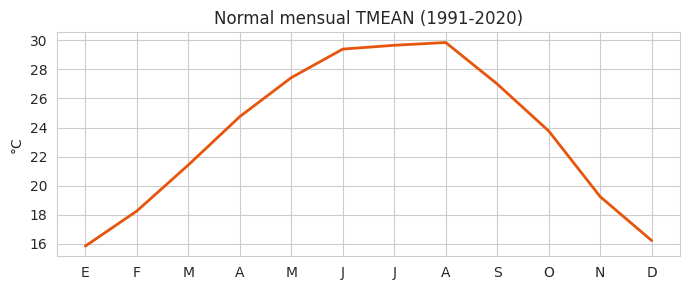

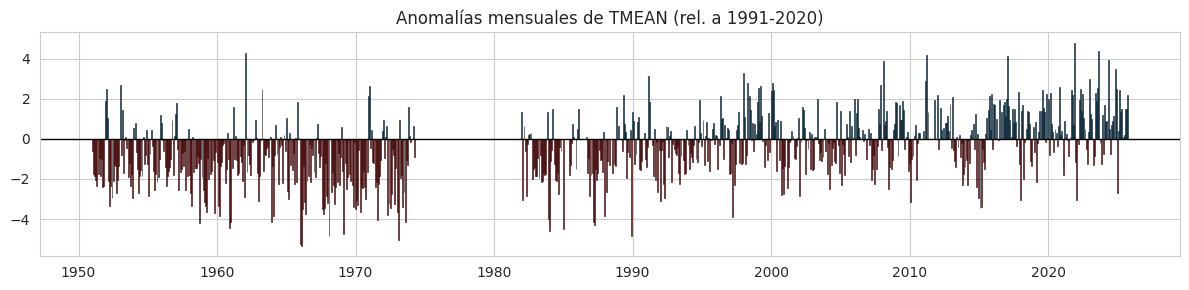

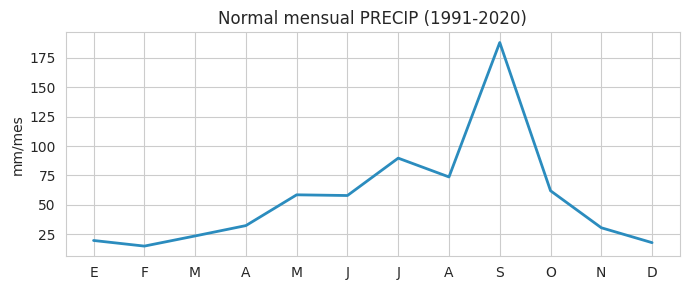

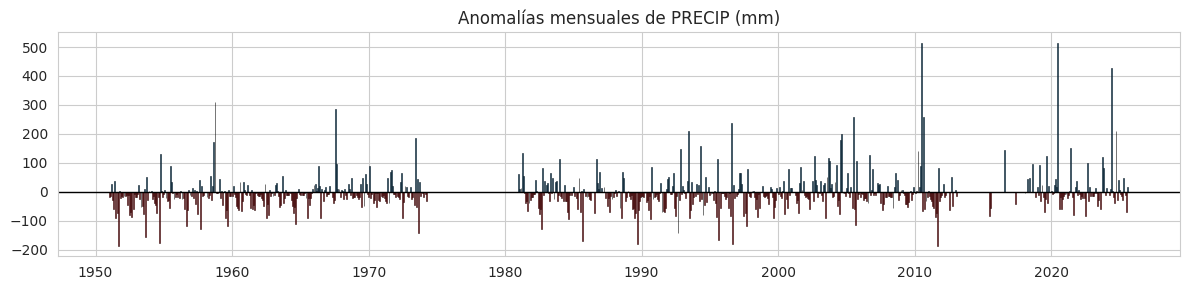

In [52]:
def plot_ciclo(clim_series, titulo, unidad, color):
    s = clim_series.copy()
    # si no son 12 valores, colapsar por mes calendario
    if len(s) != 12:
        # intentar sacar el mes del índice (PeriodIndex o DatetimeIndex)
        if hasattr(s.index, "month"):
            s = s.groupby(s.index.month).mean()
        else:
            s = s.to_timestamp().groupby(lambda i: i.month).mean()
    s = s.reindex(range(1,13))
    meses = range(1,13)
    plt.figure(figsize=(7,3))
    plt.plot(meses, s.values, color=color, lw=2)
    plt.xticks(meses, ["E","F","M","A","M","J","J","A","S","O","N","D"])
    plt.title(titulo); plt.ylabel(unidad); plt.tight_layout(); plt.show()

def plot_anom(anom, titulo):
    s = anom.to_timestamp().dropna()
    if s.empty:
        print("No hay anomalías válidas para graficar."); return
    plt.figure(figsize=(12,3))
    colors = np.where(s.values >= 0, "#1f78b4", "#e31a1c")  # azul/rojo fuertes
    plt.bar(s.index, s.values, width=25, color=colors, edgecolor="black", linewidth=0.4, alpha=0.95)
    plt.axhline(0, color="black", lw=1)
    plt.title(titulo)
    plt.tight_layout(); plt.show()


# ejemplos
plot_ciclo(mensuales["TMEAN"]["clim"], "Normal mensual TMEAN (1991-2020)", "°C", "#e6550d")
plot_anom(mensuales["TMEAN"]["anom"], "Anomalías mensuales de TMEAN (rel. a 1991-2020)")

if "PRECIP" in mensuales:
    plot_ciclo(mensuales["PRECIP"]["clim"], "Normal mensual PRECIP (1991-2020)", "mm/mes", "#2b8cbe")
    plot_anom(mensuales["PRECIP"]["anom"], "Anomalías mensuales de PRECIP (mm)")


TMEAN (2005-2025): ciclo anual claro, con máximos en jul–ago (29–30 °C) y mínimos en invierno (16–17 °C).
Anomalías muestran más meses cálidos desde fines de los 90 y menos episodios fríos; se nota persistencia térmica.

PRECIP (2005-2025): estacionalidad marcada, pico en septiembre y mínimos invernales.
Anomalías con alta variabilidad interanual, alternancia de meses muy secos y húmedos; desde ~2000 hay más meses con lluvias intensas, sin tendencia definida.


Las anomalías mensuales de precipitación muestran una sucesión de meses secos y  eventos de lluvia intensa, reflejando la alternancia sequía–lluvia fuerte típica de Monterrey.

In [53]:
## b2.2 AUTOCORRELACION

from statsmodels.tsa.stattools import acf

def acf_plot(series, nlags=60, titulo="ACF"):
    # Serie numérica 1D
    s = pd.Series(series).astype(float).copy()
    if s.isna().any():
        s = s.interpolate(limit_direction='both')
    s = s.dropna()
    if len(s) < 3:
        print("Serie demasiado corta para ACF:", titulo); return

    nl = int(min(nlags, len(s) - 2))  # evitar errores con nlags > n-1
    ac_vals, confint = acf(s.values, nlags=nl, fft=True, alpha=0.05, missing='drop')
    lags = np.arange(len(ac_vals))

    plt.figure(figsize=(10,3.2))
    # barras + puntos (versión compatible)
    plt.vlines(lags, 0, ac_vals, color="#1f77b4", lw=1.1)
    plt.scatter(lags, ac_vals, color="#1f77b4", s=18, zorder=3)
    # banda de confianza 95%
    plt.fill_between(lags, confint[:,0], confint[:,1], color="#cce5ff", alpha=0.7, label="IC 95%")
    plt.axhline(0, color="k", lw=1)
    plt.title(titulo); plt.xlabel("Lag"); plt.ylabel("ACF")
    plt.legend(frameon=False); plt.tight_layout(); plt.show()




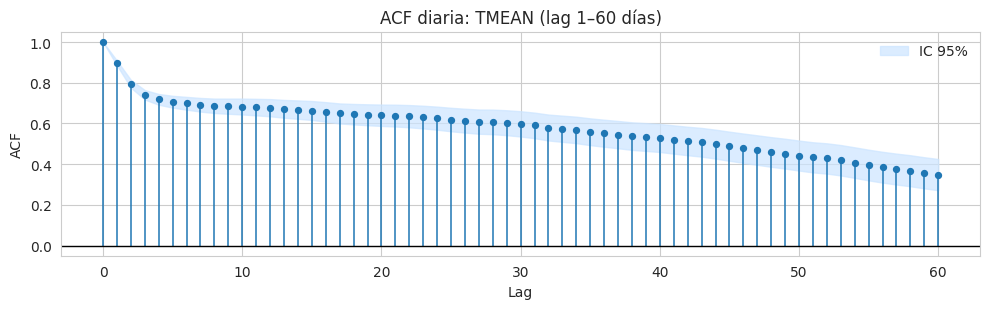

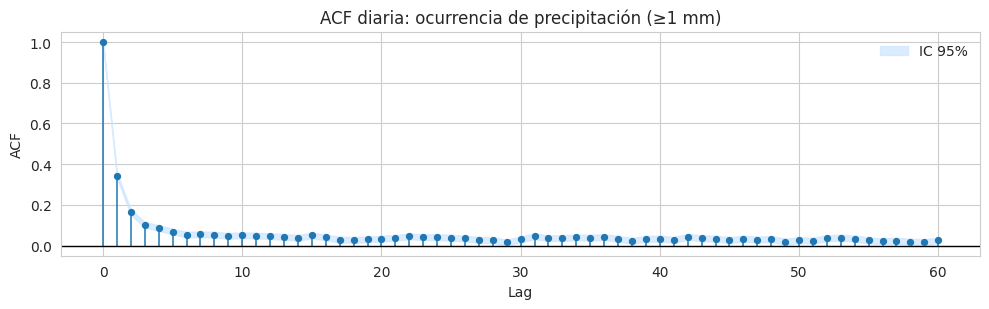

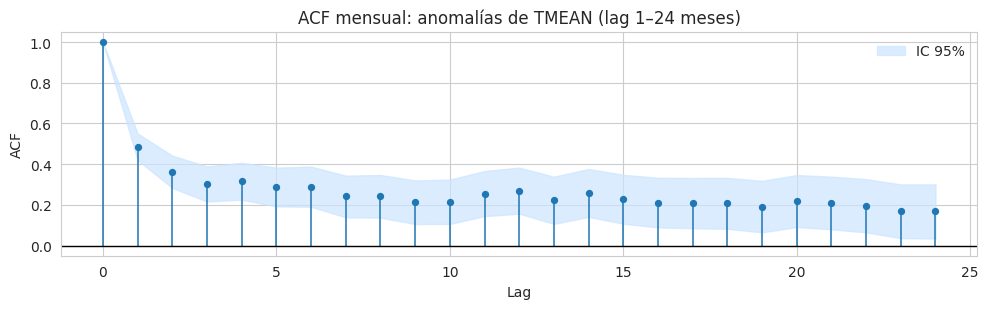

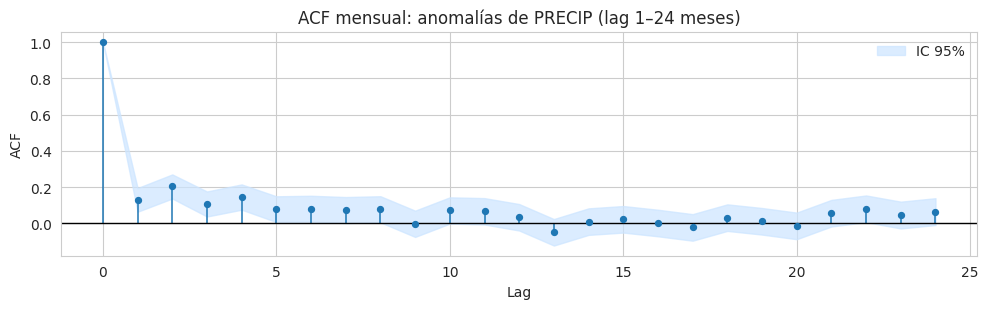

In [54]:
# --- ACF diaria ---
dfd = records_edamty.set_index("FECHA").asfreq("D").copy()
dfd["TMEAN"] = (dfd["TMAX"] + dfd["TMIN"]) / 2.0

acf_plot(dfd["TMEAN"], nlags=60, titulo="ACF diaria: TMEAN (lag 1–60 días)")

if "PRECIP" in dfd.columns:
    wet = (dfd["PRECIP"] >= 1.0).astype(float)
    acf_plot(wet, nlags=60, titulo="ACF diaria: ocurrencia de precipitación (≥1 mm)")

# --- ACF mensual (anomalías) ---
tm_anom_ts = mensuales["TMEAN"]["anom"].to_timestamp()
acf_plot(tm_anom_ts, nlags=24, titulo="ACF mensual: anomalías de TMEAN (lag 1–24 meses)")

if "PRECIP" in mensuales:
    pr_anom_ts = mensuales["PRECIP"]["anom"].to_timestamp()
    acf_plot(pr_anom_ts, nlags=24, titulo="ACF mensual: anomalías de PRECIP (lag 1–24 meses)")


In [55]:
from statsmodels.tsa.stattools import acf

# ---------- utilidades ----------
def _prep_series(x):
    s = pd.Series(x).astype(float).copy()
    if s.isna().any():
        s = s.interpolate(limit_direction="both")
    return s.dropna()

def acf_summary(series_dict, lags_interes=(1,2,12), nlags=60):
    """
    series_dict: dict {nombre: serie_1D}
    Devuelve DataFrame con ACF y IC95% en lags de interés.
    """
    rows = []
    for name, x in series_dict.items():
        s = _prep_series(x)
        if len(s) < 3:
            rows.append({"serie": name, "lag": np.nan, "ACF": np.nan,
                         "IC95_lo": np.nan, "IC95_hi": np.nan, "n": len(s)})
            continue
        nl = int(min(nlags, len(s) - 2))
        ac_vals, conf = acf(s.values, nlags=nl, fft=True, alpha=0.05, missing='drop')
        for L in lags_interes:
            if L <= nl:
                rows.append({
                    "serie": name, "lag": L, "ACF": ac_vals[L],
                    "IC95_lo": conf[L,0], "IC95_hi": conf[L,1], "n": len(s)
                })
    out = pd.DataFrame(rows)
    if not out.empty:
        out = out.pivot_table(index=["serie","n"], columns="lag",
                              values=["ACF","IC95_lo","IC95_hi"])
        # ordenar columnas por lag
        out = out.reindex(sorted(out.columns, key=lambda t: t[1]), axis=1)
    return out

# ---------- construir series con tus datos ----------
# DIARIA
dfd = records_edamty.set_index("FECHA").asfreq("D").copy()
dfd["TMEAN"] = (dfd["TMAX"] + dfd["TMIN"]) / 2.0
series_diarias = {"TMEAN diaria": dfd["TMEAN"]}
if "PRECIP" in dfd.columns:
    series_diarias["Ocurrencia PRECIP diaria (>=1 mm)"] = (dfd["PRECIP"] >= 1.0).astype(float)

# MENSUAL (ANOMALÍAS)
series_mensuales = {"TMEAN anom mensual": mensuales["TMEAN"]["anom"].to_timestamp()}
if "PRECIP" in mensuales:
    series_mensuales["PRECIP anom mensual"] = mensuales["PRECIP"]["anom"].to_timestamp()

# ---------- tablas ----------
tabla_diaria   = acf_summary(series_diarias,  lags_interes=(1,2,12), nlags=60)
tabla_mensual  = acf_summary(series_mensuales, lags_interes=(1,2,12), nlags=24)

print("ACF diaria (lags 1,2,12 días):")
display(tabla_diaria.style.format("{:.3f}"))

print("ACF mensual (anomalías; lags 1,2,12 meses):")
display(tabla_mensual.style.format("{:.3f}"))

# Opcional: exportar a CSV
# tabla_diaria.to_csv("acf_diaria_resumen.csv")
# tabla_mensual.to_csv("acf_mensual_resumen.csv")


ACF diaria (lags 1,2,12 días):


ACF mensual (anomalías; lags 1,2,12 meses):


ACF diaria

TMEAN: autocorrelación muy alta y de decaimiento lento hasta 60 días fuerte persistencia diaria y señal estacional; la memoria térmica se extiende por semanas.

Ocurrencia de precipitación (≥1 mm): pico en lag 1–2 y caída rápida a ~0 desde lag 3–5 → la ocurrencia es poco persistente; días lluviosos tienden a ser eventos aislados o rachas cortas.

ACF mensual (anomalías)

TMEAN (anomalías): autocorrelación positiva en los primeros 2–3 meses y leve repunte cerca de lag 12, coherente con estacionalidad anual y cierta persistencia intermensual.

PRECIP (anomalías): valores pequeños y erráticos, cercanos al IC, con señal débil y, a lo sumo, un indicio anual tenue → alta variabilidad interanual sin memoria marcada.

Implicaciones rápidas

Para temperatura: modelos que capturen persistencia y estacionalidad (p. ej., términos estacionales, AR con componente anual).

Para precipitación: modelar ocurrencia por separado y evitar suponer dependencia larga; usar predictores exógenos (mes/estación) antes que estructura AR prolongada.

##B3 Patron de Faltantes

% faltante
EVAP     68.661688
TMAX     13.595432
TMIN     13.595432
PRECIP   10.319203

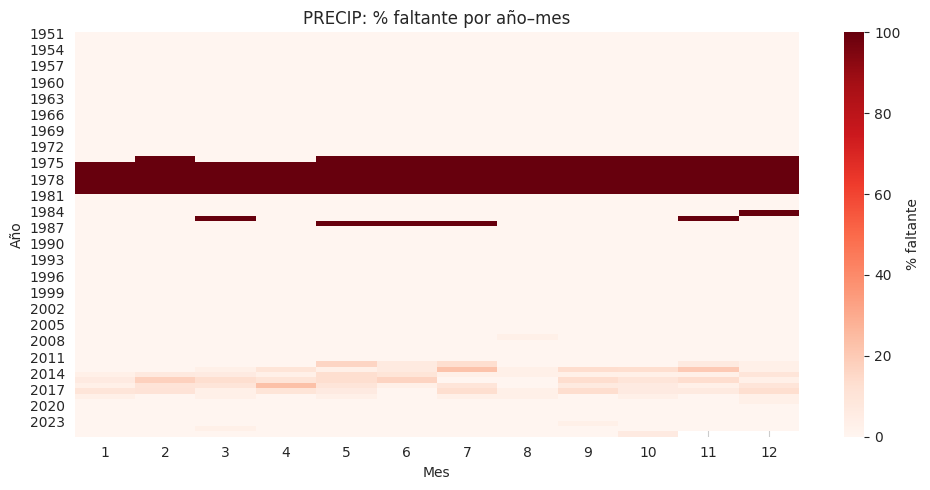

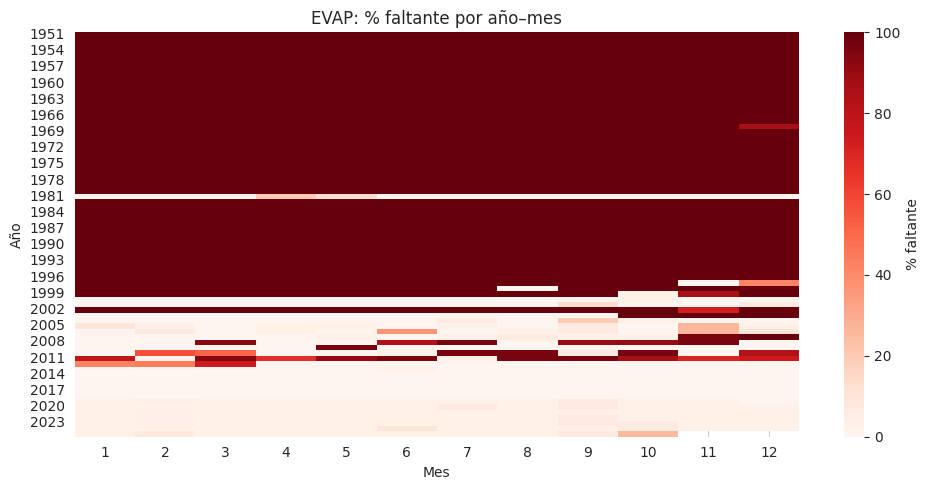

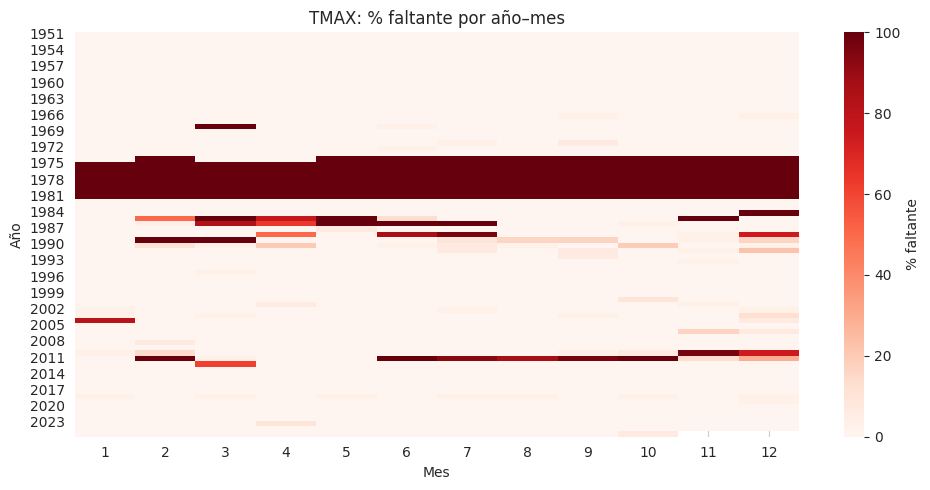

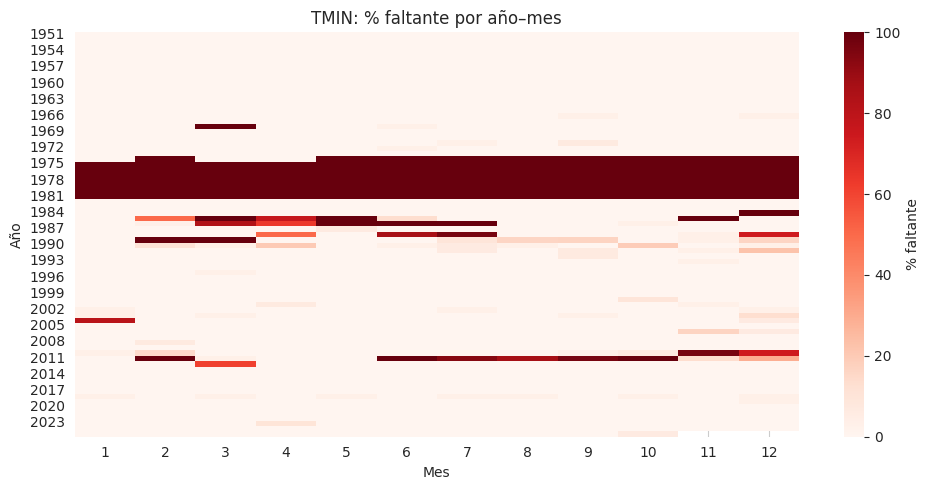

In [56]:

df = records_edamty.copy()
df = df.sort_values("FECHA")
df["AÑO"] = df["FECHA"].dt.year
df["MES"] = df["FECHA"].dt.month

vars_met = [v for v in ["PRECIP","EVAP","TMAX","TMIN"] if v in df.columns]

# % faltante total por variable
falt_total = (df[vars_met].isna().mean().sort_values(ascending=False)*100).rename("% faltante")
display(falt_total.to_frame())

# % faltante por MES (agregando sobre todos los años)
falt_mes = df.groupby("MES")[vars_met].apply(lambda d: d.isna().mean()*100)
falt_mes = falt_mes.reindex(range(1,13))
display(falt_mes.style.background_gradient(cmap="Reds"))

# Heatmap año–mes del % faltante
falt_anomes = (df.groupby(["AÑO","MES"])[vars_met]
                 .apply(lambda d: d.isna().mean()*100)
                 .reset_index())
for v in vars_met:
    tabla = falt_anomes.pivot(index="AÑO", columns="MES", values=v)
    plt.figure(figsize=(10,5))
    sns.heatmap(tabla, cmap="Reds", vmin=0, vmax=100, cbar_kws={"label":"% faltante"})
    plt.title(f"{v}: % faltante por año–mes"); plt.xlabel("Mes"); plt.ylabel("Año")
    plt.tight_layout(); plt.show()


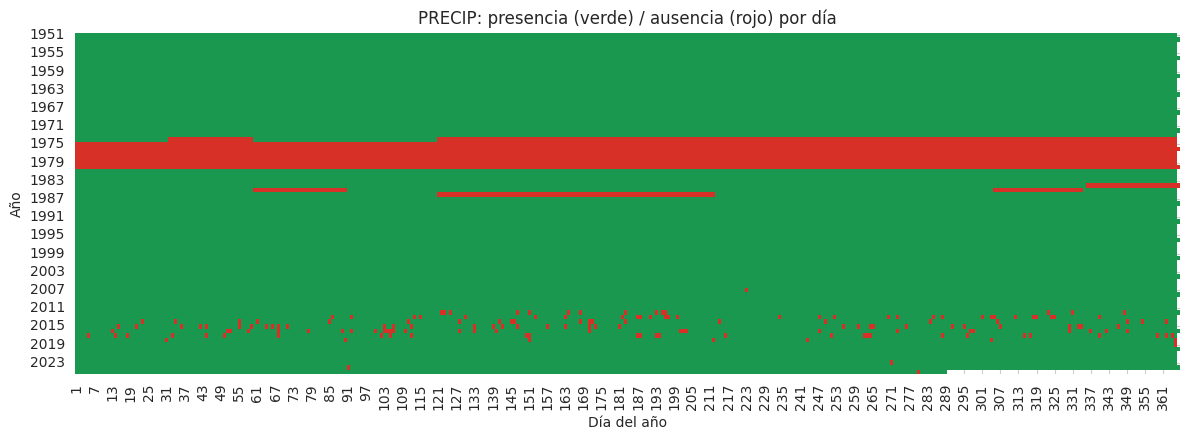

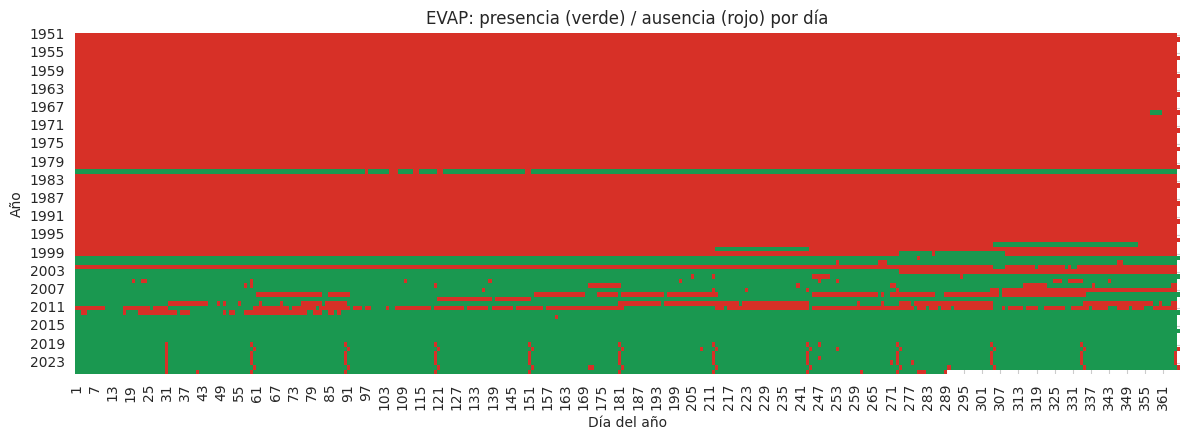

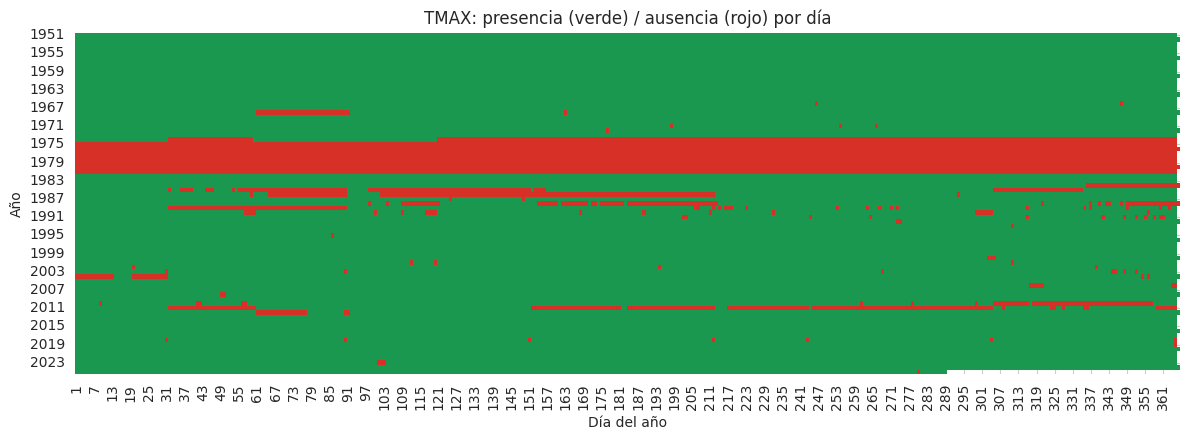

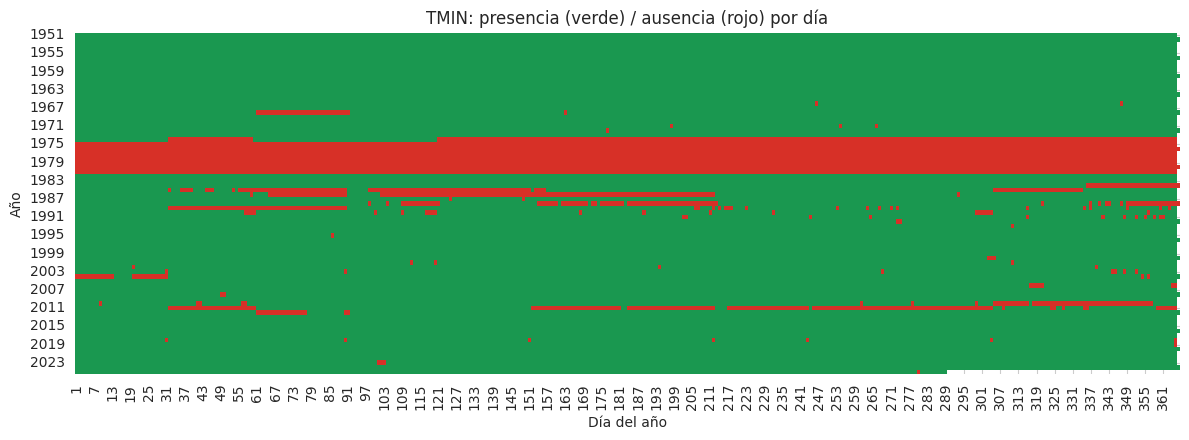

In [57]:
def calendario_binario(df, var):
    s = df.set_index("FECHA")[var].notna().astype(int).rename("presencia")
    # matriz año × día_del_año
    d = s.to_frame().copy()
    d["AÑO"] = d.index.year
    d["DOY"] = d.index.dayofyear
    # ajustar por años bisiestos: limitar a 366, rellenar faltantes a NaN (no cuenta como ausencia de medición)
    tabla = d.pivot_table(index="AÑO", columns="DOY", values="presencia", aggfunc="mean")
    plt.figure(figsize=(12,4.5))
    sns.heatmap(tabla, cmap=sns.color_palette(["#d73027","#1a9850"], as_cmap=True),
                vmin=0, vmax=1, cbar=False)
    plt.title(f"{var}: presencia (verde) / ausencia (rojo) por día")
    plt.xlabel("Día del año"); plt.ylabel("Año"); plt.tight_layout(); plt.show()

for v in vars_met:
    calendario_binario(df, v)


Magnitud total: EVAP presenta faltante muy alto (69%), mientras que TMAX/TMIN (13.6%) y PRECIP (10.3%) son moderados. Esto condiciona cualquier análisis que use EVAP (normales, tendencias, modelos).

Patrón mensual: En PRECIP el faltante es bajo y casi uniforme todo el año (8–12%). En EVAP es sistemáticamente elevado en todos los meses (≈67–71%), con ligera mayor carencia en invierno–primavera.

Patrón año–mes:

PRECIP: existen bloques completos ausentes en 1975–1979 y vacíos puntuales (1984, 1987, 1990s).

EVAP: muy escasa cobertura antes de ~1990 y faltantes recurrentes por meses aún en 2000–2015.

TMAX/TMIN: bandas extensas de faltantes a mediados de los 70s y huecos intermitentes en 1980s–2000s; mejora notable desde ~2010.

Implicaciones:

Para climatologías y tendencias, verifica el número de años efectivos por mes; en EVAP, la normal 1991–2020 puede quedar sesgada por poca muestra.

Para modelado/imputación, trata EVAP aparte (posible exclusión de décadas tempranas o imputación con predictores externos/estaciones vecinas); en PRECIP y TMAX/TMIN es viable imputar huecos cortos, pero documenta y excluye bloques largos (p. ej., 1975–1979).


PRECIP — top 10 rachas de faltantes (días):


racha_id  long_días     inicio        fin
0         2       2437 1974-05-01 1980-12-31
1         6         92 1986-05-01 1986-07-31
2         4         31 1985-03-01 1985-03-31
3         3         31 1984-12-01 1984-12-31
4         5         30 1985-11-01 1985-11-30
5         1         28 1974-02-01 1974-02-28
6       105          4 2016-04-12 2016-04-15
7       111          3 2016-07-19 2016-07-21
8       134          3 2017-09-19 2017-09-21
9        89          2 2015-09-21 2015-09-22

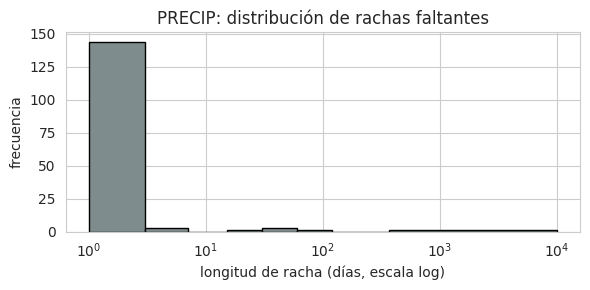


EVAP — top 10 rachas de faltantes (días):


racha_id  long_días     inicio        fin
0         1       6565 1951-01-01 1968-12-21
1         8       5783 1982-01-01 1997-10-31
2         2       4389 1968-12-26 1980-12-31
3        10        395 1998-09-01 1999-09-30
4        17        304 2002-01-01 2002-10-31
5         9        225 1997-12-19 1998-07-31
6        22         92 2003-10-01 2003-12-31
7        53         58 2007-11-04 2007-12-31
8        12         57 1999-11-05 1999-12-31
9       101         34 2011-09-02 2011-10-05

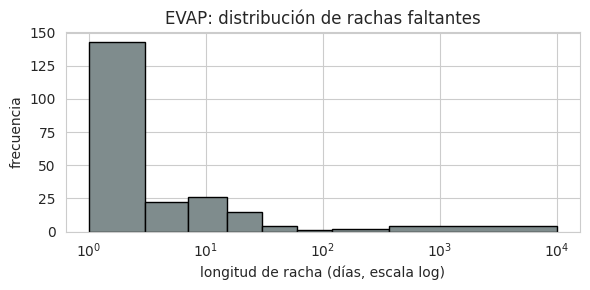


TMAX — top 10 rachas de faltantes (días):


racha_id  long_días     inicio        fin
0        10       2802 1974-05-01 1981-12-31
1        22        111 1986-04-12 1986-07-31
2       112         60 2011-09-02 2011-10-31
3        40         59 1989-02-01 1989-03-31
4        17         54 1985-04-08 1985-05-31
5       107         40 2010-11-14 2010-12-23
6        16         36 1985-02-24 1985-03-31
7         3         31 1968-03-01 1968-03-31
8        11         31 1984-12-01 1984-12-31
9        33         30 1988-07-02 1988-07-31

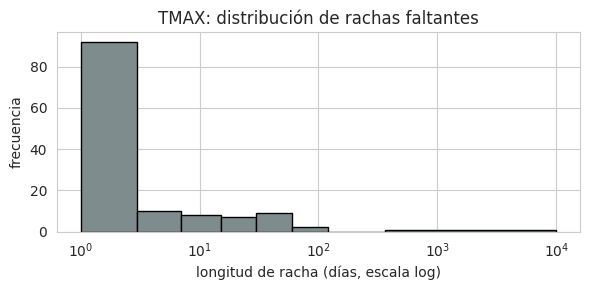


TMIN — top 10 rachas de faltantes (días):


racha_id  long_días     inicio        fin
0        10       2802 1974-05-01 1981-12-31
1        22        111 1986-04-12 1986-07-31
2       112         60 2011-09-02 2011-10-31
3        40         59 1989-02-01 1989-03-31
4        17         54 1985-04-08 1985-05-31
5       107         40 2010-11-14 2010-12-23
6        16         36 1985-02-24 1985-03-31
7         3         31 1968-03-01 1968-03-31
8        11         31 1984-12-01 1984-12-31
9        33         30 1988-07-02 1988-07-31

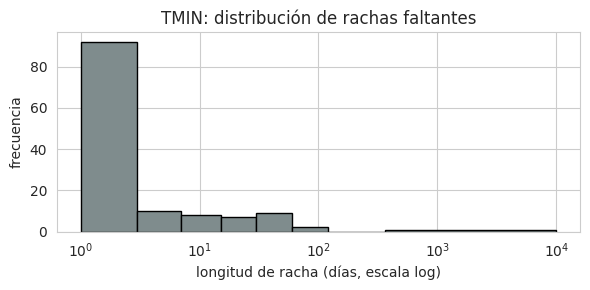

In [58]:
def rachas_faltantes(df, var):
    s = df.set_index("FECHA")[var].isna().astype(int)
    # identificar inicios de racha (0->1)
    cambio = s.diff().fillna(s.iloc[0]).astype(int)
    # id de racha
    rid = (cambio.eq(1)).cumsum() * s  # 0 fuera de racha
    # longitudes por racha
    lens = rid[rid>0].groupby(rid).size().sort_values(ascending=False)
    # tabla con inicio/fin
    idx = df.set_index("FECHA").index
    info = []
    for r, L in lens.items():
        mask = rid.eq(r)
        fechas = idx[mask.values]
        info.append({"racha_id": int(r), "long_días": int(L),
                     "inicio": fechas.min(), "fin": fechas.max()})
    tabla = pd.DataFrame(info).sort_values("long_días", ascending=False)
    return tabla, lens

res_rachas = {}
for v in vars_met:
    tabla, lens = rachas_faltantes(df, v)
    res_rachas[v] = tabla
    print(f"\n{v} — top 10 rachas de faltantes (días):")
    display(tabla.head(10))

    # histograma de longitudes
    plt.figure(figsize=(6,3))
    plt.hist(lens.values, bins=[1,3,7,15,30,60,120,365,9999], color="#7f8c8d", edgecolor="black")
    plt.xscale("log"); plt.xlabel("longitud de racha (días, escala log)")
    plt.ylabel("frecuencia"); plt.title(f"{v}: distribución de rachas faltantes")
    plt.tight_layout(); plt.show()



Los histogramas muestran que, en todas las variables, la mayoría de las **rachas** son **cortas (1–3 días)**, pero existen **colas largas** con huecos extensos. En **PRECIP** destaca una racha **multianual (1974–1980)** y varios bloques de 1–4 meses en los 80s y 2010s; en **TMAX/TMIN** aparece el mismo **bloque 1974–1981** y rachas mensuales adicionales; en **EVAP** predominan **lagunas prolongadas** (1951–1968, 1982–1997, 1968–1970, etc.), lo que explica su alta tasa global de faltantes. Este patrón mixto implica dos tratamientos: (i) **imputación ligera** para huecos cortos (p. ej., interpolación/vecinos cercanos, siempre con control de sesgo) y (ii) **manejo conservador de bloques largos** (excluir de ciertos análisis, o imputar con modelos específicos y fuentes externas si están disponibles), documentando los periodos críticos y su impacto en climatologías y tendencias.


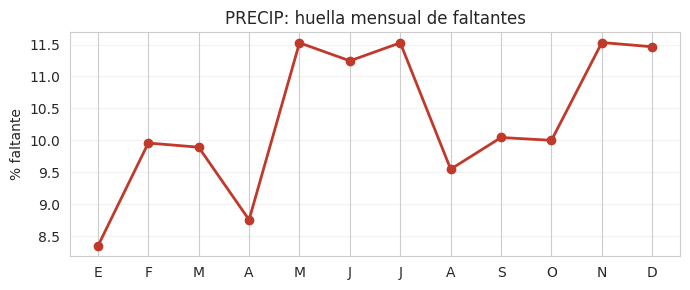

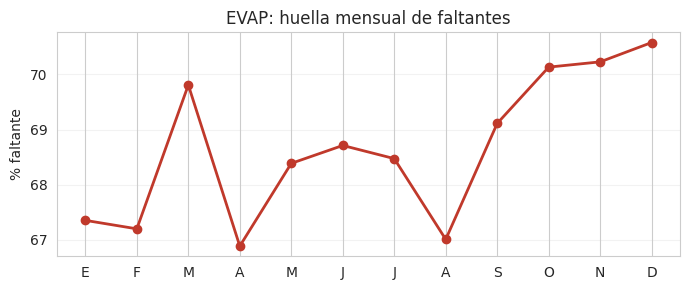

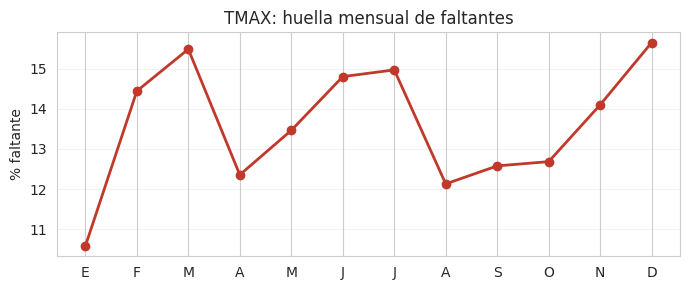

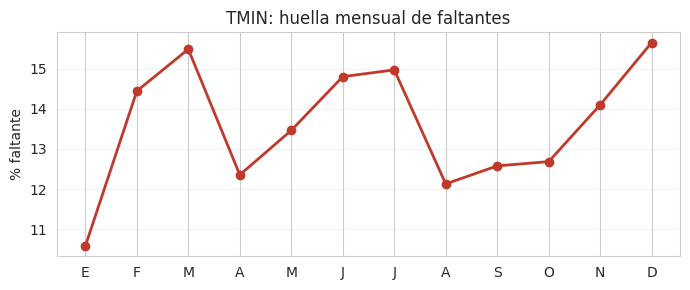

In [59]:
def huella_mensual(df, var):
    d = df[["FECHA", var]].copy()
    d["MES"] = d["FECHA"].dt.month
    g = d.groupby("MES")[var].apply(lambda s: s.isna().mean()*100).reindex(range(1,13))
    plt.figure(figsize=(7,3))
    plt.plot(range(1,13), g.values, color="#c0392b", lw=2, marker="o")
    plt.xticks(range(1,13), list("EFMAMJJASOND"))
    plt.ylabel("% faltante"); plt.title(f"{var}: huella mensual de faltantes")
    plt.grid(axis="y", alpha=0.25); plt.tight_layout(); plt.show()
    return g

huellas = {v: huella_mensual(df, v) for v in vars_met}


El faltante de PRECIP es bajo y casi uniforme (≈9–12%), con leve aumento en J–D. En EVAP la carencia es sistemáticamente alta (≈67–71%) todo el año, con mínimos relativos en A–J y repunte en O–D. Para TMAX/TMIN se observa un patrón en U suave: faltantes mayores en F–M y N–D, y menores en A–S.

In [60]:
def resumen_patrones(df, var):
    s = df.set_index("FECHA")[var]
    n = len(s); n_na = s.isna().sum()
    pct = 100*n_na/n
    # racha máxima y cuántas rachas >=30/60 días
    tabla, lens = rachas_faltantes(df, var)
    max_run = 0 if lens.empty else lens.max()
    n30 = (lens>=30).sum(); n60 = (lens>=60).sum()
    return pd.Series({"n": n, "n_NaN": n_na, "%NaN": pct,
                      "racha_max_d": max_run, "n_rachas>=30d": n30, "n_rachas>=60d": n60})

resumen = pd.DataFrame({v: resumen_patrones(df, v) for v in vars_met}).T.sort_values("%NaN", ascending=False)
display(resumen.style.format({"%NaN":"{:.1f}"}))


El resumen confirma diferencias notables en la calidad de las series: EVAP presenta la mayor proporción de datos faltantes (≈68.7%) y una racha máxima de 6,565 días (approx 18 años), con múltiples bloques prolongados (>30 días). En contraste, TMAX y TMIN muestran carencias moderadas (≈13.6%), con rachas largas asociadas al periodo 1974–1981. PRECIP tiene la menor proporción de faltantes (≈10.3%), aunque incluye una racha extensa (approx6.7 años) en los setenta. Este patrón sugiere buena continuidad en precipitación y temperatura recientes, mientras que evaporación requiere imputación intensiva o exclusión parcial para evitar sesgos en el análisis climático.

In [61]:
#funcion para definir patron de faltantes en un rango de fechas
from statsmodels.stats.diagnostic import acorr_ljungbox

df = records_edamty.copy().sort_values("FECHA")
df["AÑO"] = df["FECHA"].dt.year
df["MES"] = df["FECHA"].dt.month

def resumen_patron(df, var, lags_lb=30, inicio=1995, fin=2025):
    """Diagnóstico rápido del patrón de faltantes de una variable diaria en un rango de años."""
    # --- filtrar por rango de años ---
    df2 = df[(df["FECHA"].dt.year >= inicio) & (df["FECHA"].dt.year <= fin)].copy()

    # seguridad: si no hay datos en el rango, devuelve algo informativo
    if df2.empty or var not in df2.columns:
        return {
            "variable": var, "%NA": np.nan, "racha_max_d": 0,
            "n_rachas≥30d": 0, "n_rachas≥60d": 0,
            "LB_pmin": np.nan, "CV_mes_NA": np.nan,
            "veredicto": "SIN DATOS EN RANGO",
            "criterios": "no hay observaciones entre los años indicados"
        }

    # asegurar columna MES por si la función se usa con otro df
    if "MES" not in df2.columns:
        df2["MES"] = df2["FECHA"].dt.month

    # --- serie objetivo ---
    s = df2.set_index("FECHA")[var]
    n = len(s); n_na = s.isna().sum()
    pct = 100*n_na/n if n > 0 else np.nan

    # --- rachas de faltantes ---
    miss = s.isna().astype(int)
    cambio = miss.diff().fillna(miss.iloc[0]).astype(int)
    rid = (cambio.eq(1)).cumsum() * miss  # id de racha (0 fuera de racha)
    lens = rid[rid > 0].groupby(rid).size().sort_values(ascending=False)
    racha_max = int(lens.max()) if not lens.empty else 0
    n_30 = int((lens >= 30).sum()) if not lens.empty else 0
    n_60 = int((lens >= 60).sum()) if not lens.empty else 0

    # --- autocorrelación de faltantes (Ljung–Box sobre indicador 0/1) ---
    if 0 < n_na < n - 2:
        lb = acorr_ljungbox(miss, lags=min(lags_lb, max(5, int(np.sqrt(n)))), return_df=True)
        pmin = float(lb['lb_pvalue'].min())  # p-valor mínimo
    else:
        pmin = np.nan

    # --- estacionalidad de ausencias (variación por mes) ---
    by_m = df2.groupby("MES")[var].apply(lambda x: x.isna().mean())
    cv_mes = float(by_m.std() / (by_m.mean() + 1e-12)) if by_m.notna().any() else np.nan

    # --- veredicto ---
    razones = []
    flag_bloques = False
    if racha_max >= 30 or n_60 >= 1:
        flag_bloques = True; razones.append(f"racha_max={racha_max} d; n_≥60d={n_60}")
    if not np.isnan(pmin) and pmin < 0.05:
        flag_bloques = True; razones.append(f"Ljung–Box pmin={pmin:.3g} (<0.05)")
    if cv_mes > 0.5:
        flag_bloques = True; razones.append(f"estacionalidad de NA (CV_mes={cv_mes:.2f})")

    veredicto = "PATRÓN CRONOLÓGICO / BLOQUES" if flag_bloques else "DISPERSO (tipo MCAR)"
    return {
        "variable": var, "%NA": round(pct, 1), "racha_max_d": racha_max,
        "n_rachas≥30d": n_30, "n_rachas≥60d": n_60,
        "LB_pmin": pmin, "CV_mes_NA": cv_mes, "veredicto": veredicto,
        "criterios": "; ".join(razones) if razones else "sin evidencia de bloques"
    }

vars_met = [v for v in ["PRECIP","EVAP","TMAX","TMIN"] if v in df.columns]
diag = pd.DataFrame([resumen_patron(df, v, inicio=1995, fin=2025) for v in vars_met])
display(diag)


variable   %NA  racha_max_d  n_rachas≥30d  n_rachas≥60d        LB_pmin  \
0   PRECIP   1.5            4             0             0  3.340301e-286   
1     EVAP  27.1         1035             9             5   0.000000e+00   
2     TMAX   3.0           60             3             1   0.000000e+00   
3     TMIN   3.0           60             3             1   0.000000e+00   

   CV_mes_NA                     veredicto  \
0   0.305757  PATRÓN CRONOLÓGICO / BLOQUES   
1   0.111812  PATRÓN CRONOLÓGICO / BLOQUES   
2   0.468426  PATRÓN CRONOLÓGICO / BLOQUES   
3   0.468426  PATRÓN CRONOLÓGICO / BLOQUES   

                                           criterios  
0                   Ljung–Box pmin=3.34e-286 (<0.05)  
1  racha_max=1035 d; n_≥60d=5; Ljung–Box pmin=0 (...  
2  racha_max=60 d; n_≥60d=1; Ljung–Box pmin=0 (<0...  
3  racha_max=60 d; n_≥60d=1; Ljung–Box pmin=0 (<0...

##B4 Estructura Espacial. Eleccion de vecinos fuertes.
Ver apartado 1.7 Coherencial Espacial. En dicho apartado se seleccionan vecinos fuertes para estacion 19052 Monterrey Obs

En una red densa como la del área metropolitana de Monterrey, la estructura espacial de la precipitación se caracterizó mediante la selección de vecinas próximas y con alta coherencia espacio-temporal respecto a la estación objetivo (19052). Operativamente, se preseleccionaron estaciones dentro de un radio de 30 km y con al menos 70 % de disponibilidad en precipitación; después se evaluó su relación con 19052 a partir de (i) correlación de totales mensuales para todo el año y para la temporada húmeda (JAS), y (ii) correlación de anomalías mensuales (señal con la estacionalidad removida). Este enfoque—basado en distancia, solape temporal suficiente y asociación estadística mensual/estacional—es consistente con prácticas recientes en la imputación de lluvia, donde se recomiendan vecinas próximas y comparaciones en escala mensual y por temporada para asegurar predictibilidad y reducir sesgos derivados del ciclo anual (Navarro et al., 2023; Chivers et al., 2020; Bellido-Jiménez et al., 2021).

Aplicando estos criterios (solape ≥ 60 meses y umbral de correlación r ≥ 0.60), se obtuvieron como vecinas fuertes de 19052: 19134, 19200, 19096, 19185, 19004 y 19015. La estación 19015, si bien presenta una r aceptable en JAS, muestra una coherencia temporal más débil en el conjunto anual y en las series superpuestas; por ello se conservará solo como estación de soporte. Esta decisión es coherente con la evidencia de que la calidad de las vecinas debe ponderarse no solo por la distancia, sino también por su estabilidad temporal y por el comportamiento en la estación de interés (Navarro et al., 2023; Bellido-Jiménez et al., 2021). En conjunto, la vecindad seleccionada proporciona una base sólida para los modelos de imputación posteriores, que podrán combinar información de varias vecinas (p. ej., regresión múltiple o métodos afines) y, cuando proceda, contrastarse con fuentes auxiliares como satélite a escala mensual o diaria (Chivers et al., 2020; Duarte et al., 2022).

##B5 decision de modelos y subproblemas
Diaria PRECIP → dos subproblemas de ML:

Clasificación de ocurrencia (llueve/no llueve).

Regresión del monto (solo en días húmedos).
(Este enfoque de dos pasos es el estándar para lluvia diaria en ML)【】.

Mensual PRECIP → totales y anomalías (para controlar ciclo y sesgo).

El control de calidad y el análisis exploratorio de la estación 19052 muestran precipitación diaria con alta intermitencia, inflación de ceros, estacionalidad marcada y faltantes en bloque, además de coherencia espacial utilizable con vecinas cercanas. Estas características exigen, por un lado, un esquema en dos etapas para precipitación diaria —clasificar ocurrencia (llueve/no llueve) y, condicionado a lluvia, estimar el monto— y, por otro, el uso de modelos no paramétricos capaces de capturar no linealidades e integrar predictores de estaciones vecinas, evitando fuga temporal y espacial mediante validación por bloques (Chivers et al., 2020; WMO, 2018; Navarro et al., 2023; Lupi et al., 2023). En este marco, se propone comparar un único candidato de aprendizaje automático, Random Forest (RF), frente a kriging como línea base geoestadística. RF es adecuado para ambas tareas del esquema en dos etapas, pues maneja interacciones complejas sin supuestos paramétricos rígidos y ha mostrado desempeño estable en marcos multivariables con múltiples estaciones y tasas de faltantes, manteniendo buenos errores medios y capacidad de generalización (Li et al., 2023; Lupi et al., 2023). La elección de kriging como baseline es pertinente porque, en comparativas mexicanas por región climática, métodos espaciales pueden resultar óptimos en contextos semiáridos, de modo que cuantificar la mejora relativa de ML debe hacerse contra un referente espacial sólido (Navarro et al., 2023; Duarte et al., 2022).

Técnicamente, la implementación seguirá: i) un clasificador de ocurrencia con predictores locales y de vecinas en rezagos cortos y acumulados 3–7 días (consistentes con la memoria hidrológica de corto plazo), variables auxiliares disponibles y estacionalidad; y ii) un regresor de monto condicionado a lluvia con el mismo conjunto de predictores. La evaluación usará “verdad oculta” mediante máscaras que replican faltantes aleatorios y en bloque, con validación temporal por bloques contiguos y embargo para evitar fuga de información. Las métricas se orientan al uso hidrológico: error absoluto medio (Mean Absolute Error, MAE) y raíz del error cuadrático medio (Root Mean Squared Error, RMSE) por temporada, sesgo porcentual (Percent Bias, Pbias), ocurrencia (p. ej., F1 lluvia/no lluvia) y extremos (error en cuantiles altos y pico diario), además de coherencia espacial post-imputación frente a vecinas (WMO, 2018; Chivers et al., 2020; Duarte et al., 2022; Navarro et al., 2023; Lupi et al., 2023). Esta configuración está alineada con la evidencia que muestra que el enfoque en dos etapas mejora la detección de eventos y la representación de extremos frente a interpoladores puramente espaciales, y que RF ofrece un equilibrio favorable entre precisión, robustez y costo de ajuste cuando se integra información multifuente y se valida sin fuga temporal ni espacial (Chivers et al., 2020; Li et al., 2023; Lupi et al., 2023).

# Preparacion de datos para el modelo de ML


##Verificacion de Dataset


Se  verificó la presencia de columnas mínimas (FECHA, Clave, PRECIP, TMAX, TMIN). Se verifico los tipos de datos  (FECHA a datetime y Clave a entero) y se cerifico que no hubiera duplicados a nivel (Clave, FECHA). Además, se revisó la cobertura temporal por estación y se confirmó la existencia de la estación objetivo (TARGET).

Posteriormente, se agregaron coordenadas (lat, lon) , utilizando la información de stations_df. También se construyó la variable binaria wet a partir de la precipitación con un umbral de 0.2 mm, manejando adecuadamente valores faltantes, y se generó la columna MES para usarla en estacionalidad.

Se mostró el conjunto final de columnas, concluyendo así la verificación de los datos.

In [62]:
# === Parámetros mínimos ===
WET_THR = 0.2  # mm
TARGET = 19052

# === 1) Chequeos básicos (SIN tocar records_eda) ===
assert 'records_eda' in globals(), "No encuentro records_eda en la sesión."
df = records_eda.copy()
# records_modelo = df.copy()

need_cols = {'FECHA','Clave','PRECIP','TMAX','TMIN'}
missing = need_cols - set(df.columns)
if missing:
    raise RuntimeError(f"Faltan columnas mínimas en records_eda: {sorted(missing)}")

# Tipos
df['FECHA'] = pd.to_datetime(df['FECHA'], errors='coerce')
df['Clave'] = df['Clave'].astype(int)

# Duplicados
dups = df.duplicated(subset=['Clave','FECHA']).sum()
print(f"Duplicados (Clave,FECHA) = {dups}")

# Cobertura temporal por estación
print("\nRango temporal por estación:")
print(df.groupby('Clave')['FECHA'].agg(['min','max','count']))

# Presencia de target
if TARGET not in df['Clave'].unique():
    raise RuntimeError(f"La estación TARGET {TARGET} no está en records_eda.")

# === 2) Añadir lat/lon  ===
if not {'lat','lon'}.issubset(df.columns):
    assert 'stations_df' in globals(), "No encuentro stations_df para anexar lat/lon."
    sd = stations_df[['Clave','lat','lon']].drop_duplicates().copy()
    sd['Clave'] = sd['Clave'].astype(int)
    before = df.shape[1]
    df = df.merge(sd, on='Clave', how='left')
    print(f"\nCoords añadidas: columnas {before} → {df.shape[1]}")

# === 3) Bandera wet (binaria) y MES, sin sesgos por NaN ===
created = []
if 'wet' not in df.columns:
    wet = np.where(
        df['PRECIP'].notna() & (df['PRECIP'] >= float(WET_THR)), 1,
        np.where(df['PRECIP'].notna(), 0, np.nan)
    )
    df['wet'] = pd.Series(wet, index=df.index, dtype='Int8')  # 0/1/<NA>
    created.append('wet')

if 'MES' not in df.columns:
    df['MES'] = df['FECHA'].dt.month.astype('Int8')
    created.append('MES')

if created:
    print("\nColumnas creadas:", created)
else:
    print("\nNo fue necesario crear columnas adicionales.")

# === 4) Resúmenes rápidos ===
print("\nWet rate por estación (solo días observados, dropna):")
wet_rate_obs = (
    df.groupby('Clave', as_index=True)['wet']
      .apply(lambda s: s.dropna().mean())
      .round(3)
)
print(wet_rate_obs)

print("\nWet rate por estación (tratando faltantes como NO-lluvia):")
wet_rate_na_as_dry = df.groupby('Clave')['wet'].apply(lambda s: s.fillna(0).mean()).round(3)
print(wet_rate_na_as_dry)

# Target específico
wr_obs_target = df.loc[df['Clave']==TARGET, 'wet'].dropna().mean()
wr_na0_target  = df.loc[df['Clave']==TARGET, 'wet'].fillna(0).mean()
print(f"\nTARGET {TARGET} — wet_rate observado-only: {wr_obs_target:.3f}  |  con NaN→0: {wr_na0_target:.3f}")

print("\nColumnas finales:")
print(sorted(df.columns.tolist()))

print("\n Verificación lista. ")


Duplicados (Clave,FECHA) = 0

Rango temporal por estación:
             min        max  count
Clave                             
19004 1964-02-17 2024-05-31  22020
19015 1957-07-15 2025-10-17  24932
19052 1951-01-01 2025-10-16  27318
19096 1975-11-01 2024-04-30  17714
19134 1979-04-24 2024-12-31  16689
19185 1997-09-01 2025-06-19  10154
19200 1997-06-01 2024-05-31   9862

Coords añadidas: columnas 11 → 13

Columnas creadas: ['wet']

Wet rate por estación (solo días observados, dropna):
Clave
19004    0.144
19015    0.236
19052    0.181
19096    0.102
19134    0.150
19185    0.152
19200    0.184
Name: wet, dtype: float64

Wet rate por estación (tratando faltantes como NO-lluvia):
Clave
19004    0.112
19015    0.198
19052    0.163
19096    0.095
19134    0.141
19185    0.121
19200    0.157
Name: wet, dtype: float64

TARGET 19052 — wet_rate observado-only: 0.181  |  con NaN→0: 0.163

Columnas finales:
['Clave', 'EVAP', 'FECHA', 'MES', 'PRECIP', 'TMAX', 'TMIN', 'flag_intervar_any', 'flag_p

##Recorte temporal y reanilisis de vecinas

Tomando en cuenta el analisis de datos faltantes del EDA, se tomo la decisiopn de recortar desde 1982 eliminando un tramo masivo de NA en la target que sesgaría los lags/rollings. De igual forma a partir de esta fecha se decidio filtrar vecinas por cobertura (% de faltantes menor a 70%) garantizando que los predictores espaciales no estén dominados por faltantes . Con esto se busco  estabilizar el entrenamiento y la comparación RF vs. kriging.

In [63]:
# A. Ventana de trabajo (post-1982) para TODAS las estaciones
import pandas as pd
CUT_START = pd.Timestamp("1982-01-01")

df = df[df["FECHA"] >= CUT_START].copy()

print("Ventana de trabajo:", df["FECHA"].min(), "→", df["FECHA"].max())
print("Estaciones en df (post-1982):", sorted(df["Clave"].unique().tolist()))


Ventana de trabajo: 1982-01-01 00:00:00 → 2025-10-17 00:00:00
Estaciones en df (post-1982): [19004, 19015, 19052, 19096, 19134, 19185, 19200]


In [64]:
# B. Medir cobertura de PRECIP (observado) y quedarnos con estaciones ≥70% de la target
TARGET = 19052

# Días observados de la target en el periodo post-1982
target_days_obs = df[(df["Clave"]==TARGET) & df["PRECIP"].notna()]["FECHA"].nunique()
if target_days_obs == 0:
    raise RuntimeError("La estación target no tiene días observados de PRECIP después de 1982-01-01.")

# Cobertura por estación (ratio respecto a la target)
cov = (
    df[df["PRECIP"].notna()]
      .groupby("Clave")["FECHA"].nunique()
      .rename("obs_days")
      .reset_index()
)
cov["coverage_ratio"] = cov["obs_days"] / float(target_days_obs)

# Filtro ≥70% (si alguna vecina no aparece por no tener observaciones, su ratio será NaN y quedará fuera)
COV_TH = 0.70
keep_ids = cov.loc[cov["coverage_ratio"] >= COV_TH, "Clave"].astype(int).tolist()

# Aseguramos que la target siempre esté incluida
if TARGET not in keep_ids:
    keep_ids = sorted(set(keep_ids + [TARGET]))

# Reporte ordenado: primero la target, luego vecinas
cov_report = cov.copy()
cov_report["Clave"] = cov_report["Clave"].astype(int)
cov_report = cov_report.sort_values(by=["Clave"])
print("\nCobertura (obs_days y ratio respecto a TARGET):")
print(cov_report)

neighbor_ids_all = sorted(df["Clave"].unique().tolist())
neighbor_ids_kept = [i for i in keep_ids if i != TARGET]

print("\nEstaciones que se conservan (≥70%):", keep_ids)
print("Vecinas elegidas (≥70%):", neighbor_ids_kept)

# Dejamos df solo con TARGET + vecinas elegidas
df = df[df["Clave"].isin(keep_ids)].copy()
print("\nShape post-filtro (TARGET + vecinas ≥70%):", df.shape)



Cobertura (obs_days y ratio respecto a TARGET):
   Clave  obs_days  coverage_ratio
0  19004     10759        0.687872
1  19015     14193        0.907423
2  19052     15641        1.000000
3  19096     14430        0.922575
4  19134     15108        0.965923
5  19185      8072        0.516080
6  19200      8401        0.537114

Estaciones que se conservan (≥70%): [19015, 19052, 19096, 19134]
Vecinas elegidas (≥70%): [19015, 19096, 19134]

Shape post-filtro (TARGET + vecinas ≥70%): (63158, 14)


## Construcción de variables predictoras

Se partió de df (copia de records_eda) y se definió TARGET=19052. Se identificaron todas las estaciones presentes y se determinó el conjunto de vecinas excluyendo el TARGET.

Se construyeron features locales del TARGET sin fuga de información: se generaron rezagos (lag1 para PRECIP, TMAX y TMIN; lag2 para PRECIP) y acumulados rodantes cerrados a la izquierda (PRECIP_roll3 y PRECIP_roll7 usando shift(1)). Asimismo, se incorporó estacionalidad mediante sinMES y cosMES. Después, se filtró el DataFrame para conservar únicamente los registros de la estación objetivo.

Se crearon features de estaciones vecinas alineadas por fecha (nivel del día t). Para ello, se pivotearon las variables básicas (PRECIP, TMAX, TMIN) a formato ancho por FECHA y Clave, y se reindexaron sobre las fechas del TARGET, añadiendo a df_target las columnas PRECIP_nei{r}, TMAX_nei{r} y TMIN_nei{r} para cada vecina en orden.

Se definió el conjunto final de predictores combinando las variables locales (rezagos, acumulados y términos estacionales) con todas las variables de vecinas disponibles. Se establecieron las variables objetivo: y_cls = 'wet' para ocurrencia (0/1/<NA>, a usar con dropna() en entrenamiento/evaluación) y y_reg = 'PRECIP' para el monto condicionado. Finalmente, se imprimieron conteos de vecinas, número total de features, número de filas del TARGET y una vista de las primeras features, verificando así la correcta preparación del set de modelado.

In [65]:
assert 'df' in globals(), "No encuentro df (copia de records_eda)."
TARGET = 19052

# 2.0 Vecinas: tomar TODAS las estaciones en df excepto TARGET
all_ids = sorted(df['Clave'].unique().tolist())
neighbor_ids = [i for i in all_ids if i != TARGET]
print("TARGET:", TARGET)
print("Vecinas en df:", neighbor_ids)

# 2.1 Features locales del TARGET (sin fuga)
def make_local_features(df_in, target):
    d = df_in.copy().sort_values(['Clave','FECHA'])
    # lags y rollings "closed=left" (usando shift(1)) → SIN FUGA
    for c in ['PRECIP','TMAX','TMIN']:
        d[f'{c}_lag1'] = d.groupby('Clave')[c].shift(1)
    d['PRECIP_lag2']  = d.groupby('Clave')['PRECIP'].shift(2)
    d['PRECIP_roll3'] = (d.groupby('Clave')['PRECIP'].shift(1)
                           .rolling(3).sum().reset_index(0,drop=True))
    d['PRECIP_roll7'] = (d.groupby('Clave')['PRECIP'].shift(1)
                           .rolling(7).sum().reset_index(0,drop=True))
    # estacionalidad
    m = d['MES'].astype(float)
    d['sinMES'] = np.sin(2*np.pi*m/12)
    d['cosMES'] = np.cos(2*np.pi*m/12)
    # quedarnos solo con el TARGET
    return d[d['Clave']==target].copy()

df_target = make_local_features(df, TARGET)

# 2.2 Features de vecinas alineadas por fecha (niveles del día t)
base_cols = ['FECHA','Clave','PRECIP','TMAX','TMIN']
wide = df[base_cols].pivot(index='FECHA', columns='Clave')  # columnas MultiIndex (var, clave)

for rank, nid in enumerate(neighbor_ids, start=1):
    for var in ['PRECIP','TMAX','TMIN']:
        df_target[f'{var}_nei{rank}'] = wide[(var, nid)].reindex(df_target['FECHA']).values

# 2.3 Selección de columnas finales
feature_cols = [
    # locales
    'PRECIP_lag1','PRECIP_lag2','PRECIP_roll3','PRECIP_roll7',
    'TMAX_lag1','TMIN_lag1','sinMES','cosMES',
]
# agregar vecinas (todas las presentes en df)
for rank in range(1, len(neighbor_ids)+1):
    feature_cols += [f'PRECIP_nei{rank}', f'TMAX_nei{rank}', f'TMIN_nei{rank}']

y_cls = 'wet'       # ocurrencia (0/1/<NA>) — usaremos dropna() al entrenar/evaluar
y_reg = 'PRECIP'    # monto condicionado

print("n vecinas:", len(neighbor_ids))
print("N features:", len(feature_cols))
print("Filas TARGET:", df_target.shape[0])
print("Primeras features:", feature_cols[:10])


TARGET: 19052
Vecinas en df: [19015, 19096, 19134]
n vecinas: 3
N features: 17
Filas TARGET: 15995
Primeras features: ['PRECIP_lag1', 'PRECIP_lag2', 'PRECIP_roll3', 'PRECIP_roll7', 'TMAX_lag1', 'TMIN_lag1', 'sinMES', 'cosMES', 'PRECIP_nei1', 'TMAX_nei1']


In [66]:
pd.set_option('display.max_columns', None)

In [67]:
df_target.head(5)


FECHA  PRECIP  EVAP  TMAX  TMIN  Clave  MES  flag_p_evap_hi  \
58275 1982-01-01     0.0   NaN  23.4  15.6  19052    1           False   
58276 1982-01-02     0.0   NaN  31.5  13.6  19052    1           False   
58277 1982-01-03     0.0   NaN  33.3  13.4  19052    1           False   
58278 1982-01-04     0.0   NaN  19.0   8.2  19052    1           False   
58279 1982-01-05     0.0   NaN  25.3  18.5  19052    1           False   

       flag_p_tmax_hi  flag_p_tmin_hi  flag_intervar_any        lat  \
58275           False           False              False  25.733611   
58276           False           False              False  25.733611   
58277           False           False              False  25.733611   
58278           False           False              False  25.733611   
58279           False           False              False  25.733611   

              lon  wet  PRECIP_lag1  TMAX_lag1  TMIN_lag1  PRECIP_lag2  \
58275 -100.304722    0          NaN        NaN        NaN          NaN   
58276 -100.304722    0          0.0       23.4       15.6          NaN   
58277 -100.304722    0          0.0       31.5       13.6          0.0   
58278 -100.304722    0          0.0       33.3       13.4          0.0   
58279 -100.304722    0          0.0       19.0        8.2          0.0   

       PRECIP_roll3  PRECIP_roll7  sinMES    cosMES  PRECIP_nei1  TMAX_nei1  \
58275           0.0           0.0     0.5  0.866025          0.0       23.0   
58276           0.0           0.0     0.5  0.866025          0.0       30.5   
58277           0.0           0.0     0.5  0.866025          0.0       31.0   
58278           0.0           0.0     0.5  0.866025          0.0       29.5   
58279           0.0           0.0     0.5  0.866025          0.0       26.0   

       TMIN_nei1  PRECIP_nei2  TMAX_nei2  TMIN_nei2  PRECIP_nei3  TMAX_nei3  \
58275        3.0          0.0       31.0        6.0          0.0       35.0   
58276        2.5          0.0       25.0        8.0          0.0       36.0   
58277        3.0          0.0       31.0        9.0          0.0       34.5   
58278        1.5          0.0       35.0       10.0          0.0       20.0   
58279        1.0          0.0       25.0        3.0          0.0       23.0   

       TMIN_nei3  
58275       10.0  
58276        6.0  
58277        9.0  
58278        8.0  
58279        9.0

In [68]:
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')

##Folds Temporales y mascaras de faltantes

Se definieron dos folds temporales contiguos mediante una fecha de corte (CUTOFF), separando el conjunto objetivo en dos segmentos: uno anterior y otro posterior a dicha fecha. Para evitar fuga de información por proximidad temporal, se aplicó un embargo de 7 días, removiendo registros cercanos al límite entre ambos segmentos en las particiones de entrenamiento.

Posteriormente, se construyeron dos esquemas de validación cruzada temporal:

Entrenamiento en el segmento anterior (A) y prueba en el posterior (B).

Entrenamiento en el segmento posterior (B) y prueba en el anterior (A).

In [69]:
# Definimos dos folds contiguos con embargo de 7 días
import pandas as pd

CUTOFF = pd.Timestamp("2010-01-01")
EMBARGO_DAYS = 7

def temporal_folds_with_embargo(dfT, cutoff, embargo_days=7):
    c = pd.to_datetime(cutoff)
    A = dfT[dfT['FECHA'] <= c].copy()
    B = dfT[dfT['FECHA'] >  c].copy()
    e = pd.Timedelta(days=embargo_days)
    A_train = A[A['FECHA'] <= A['FECHA'].max() - e]
    B_train = B[B['FECHA'] >= B['FECHA'].min() + e]
    return (A_train, B), (B_train, A)

(A_train, B_test), (B_train, A_test) = temporal_folds_with_embargo(df_target, CUTOFF, EMBARGO_DAYS)

print("Fold A→B:", A_train['FECHA'].min(), "→", A_train['FECHA'].max(), "||", B_test['FECHA'].min(), "→", B_test['FECHA'].max())
print("Fold B→A:", B_train['FECHA'].min(), "→", B_train['FECHA'].max(), "||", A_test['FECHA'].min(), "→", A_test['FECHA'].max())


Fold A→B: 1982-01-01 00:00:00 → 2009-12-25 00:00:00 || 2010-01-02 00:00:00 → 2025-10-16 00:00:00
Fold B→A: 2010-01-09 00:00:00 → 2025-10-16 00:00:00 || 1982-01-01 00:00:00 → 2010-01-01 00:00:00


Se simuló la pérdida de información bajo un mecanismo MCAR (Missing Completely At Random) afectando al 15 % de los días con precipitación observada en cada conjunto de prueba. Para ello, se seleccionaron únicamente índices correspondientes a registros con valores no nulos de PRECIP, y se muestreó aleatoriamente un subconjunto mediante una semilla fija, garantizando reproducibilidad. Se generaron dos máscaras independientes: una aplicada al fold A→B y otra al fold B→A, y se reportó el tamaño de cada conjunto de valores ocultados.

In [70]:
# MCAR 15% sobre días con PRECIP observado en cada TEST
import numpy as np

def mcar_mask_index(df_split, frac=0.15, seed=42):
    idx = df_split.index[df_split['PRECIP'].notna()]  # solo días con verdad
    n = int(len(idx)*frac)
    rs = np.random.RandomState(seed)
    return set(rs.choice(idx, n, replace=False))

mcar_A = mcar_mask_index(B_test, frac=0.15, seed=202)  # para fold A→B
mcar_B = mcar_mask_index(A_test, frac=0.15, seed=303)  # para fold B→A

print("MCAR sizes → A:", len(mcar_A), "| B:", len(mcar_B))


MCAR sizes → A: 839 | B: 1506


Se simuló la pérdida de datos en bloque dentro de cada conjunto de prueba, seleccionando un período contiguo de aproximadamente 30 días a partir de una fecha inicial predefinida. Para cada fold, se definió una fecha de inicio diferente con el fin de representar posibles temporadas húmedas o eventos relevantes. Dentro de dicho intervalo, únicamente se consideraron registros con precipitación observada, generando así un subconjunto de índices afectados. Finalmente, se informó el tamaño de cada bloque simulado para ambos esquemas de validación (A→B y B→A), permitiendo evaluar la robustez del modelo ante ausencias concentradas en el tiempo.

In [71]:
# Bloque ~30 días en SEPTIEMBRE dentro del TEST (solo donde hay verdad)
import pandas as pd

def september_block_mask(df_split, length_days=30):
    # Fechas únicas del split
    dates = pd.to_datetime(df_split['FECHA'].unique())
    if dates.size == 0:
        return set(), None  # split vacío

    # Rango del split
    dmin, dmax = dates.min(), dates.max()

    # Candidatos: todos los días de septiembre en el split (cualquier año)
    sept_days = sorted(d for d in dates if d.month == 9)
    if not sept_days:
        return set(), None  # no hay septiembre en este split

    # Elegir el primer inicio que deje caber length_days, si no, el último posible en sept
    start = None
    for d0 in sept_days:
        d1 = d0 + pd.Timedelta(days=length_days-1)
        if d1 <= dmax:
            start = d0
            break
    if start is None:
        # tomar el último día de septiembre que aún esté en el split y retroceder
        last_sept = max(sept_days)
        start = last_sept - pd.Timedelta(days=length_days-1)
        # si se sale por la izquierda, clipear a dmin
        if start < dmin:
            start = dmin

    end = start + pd.Timedelta(days=length_days-1)

    # ÍNDICES del bloque con verdad observada
    idx = df_split.index[
        (df_split['FECHA'] >= start) &
        (df_split['FECHA'] <= end) &
        (df_split['PRECIP'].notna())
    ]
    return set(idx), (start, end)

# Aplica a ambos TEST
block_A, (ba_s, ba_e) = september_block_mask(B_test, length_days=30)  # fold A→B
block_B, (bb_s, bb_e) = september_block_mask(A_test, length_days=30)  # fold B→A

print(f"BLOQUE A→B: {ba_s.date()} → {ba_e.date()} | idx={len(block_A)}")
print(f"BLOQUE B→A: {bb_s.date()} → {bb_e.date()} | idx={len(block_B)}")

# (Opcional) proporción del test con verdad cubierta por el bloque
prop_A = len(block_A) / max(1, B_test['PRECIP'].notna().sum())
prop_B = len(block_B) / max(1, A_test['PRECIP'].notna().sum())
print(f"Proporción del TEST cubierta (verdad observada) — A→B: {prop_A:.3f} | B→A: {prop_B:.3f}")


BLOQUE A→B: 2010-09-01 → 2010-09-30 | idx=30
BLOQUE B→A: 1982-09-01 → 1982-09-30 | idx=30
Proporción del TEST cubierta (verdad observada) — A→B: 0.005 | B→A: 0.003


# Modelo ML Random Forest

## Helpers para preparar X/y (clasificación y regresión)
Se definieron funciones de apoyo para preparar los datos del modelo en dos etapas: primero, se filtraron registros completos para clasificar si llovió (wet), y luego se seleccionaron únicamente días con lluvia para estimar el monto de precipitación observado. También se creó una máscara para identificar filas de prueba con todas las features disponibles. Por último, se ajustó el umbral de decisión buscando el mejor puntaje F1 en una serie de valores predefinidos.

In [72]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import ParameterSampler

y_cls = "wet"
y_reg = "PRECIP"

# === Helper para RMSE (evita usar squared=False) ===
def rmse_fn(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred))) if len(y_true) else np.nan

# === Fit: calcula medianas por MES y medianas globales (solo en TRAIN) ===
def fit_month_medians(df_train, feature_cols):
    med_by_month = df_train.groupby('MES')[feature_cols].median(numeric_only=True)
    med_global   = df_train[feature_cols].median(numeric_only=True)
    return med_by_month, med_global

# === Transform: aplica medianas por MES; remanentes -> mediana global TRAIN ===
def transform_with_month_medians(df_split, feature_cols, med_by_month, med_global):
    X = df_split[feature_cols].copy()
    m = df_split['MES'].astype(int)
    for mes in med_by_month.index:
        idx = (m == mes)
        if idx.any():
            X.loc[idx, feature_cols] = X.loc[idx, feature_cols].fillna(med_by_month.loc[mes])
    # Fallback global (por si algún MES no existió en TRAIN o quedan NaN)
    X = X.fillna(med_global)
    return X

# === Helpers de datos (ya NO exigimos features completas; la imputación se encarga) ===
def get_train_clf(df_train, feature_cols):
    ymask = df_train[y_cls].notna()
    X = df_train.loc[ymask, feature_cols]
    y = df_train.loc[ymask, y_cls].astype(int)
    return X, y, ymask

def get_train_reg(df_train, feature_cols):
    ymask = (df_train[y_cls] == 1) & df_train[y_reg].notna()
    X = df_train.loc[ymask, feature_cols]
    y = df_train.loc[ymask, y_reg]
    return X, y, ymask



## Optimizacion Random Search + Grid Search

Randomized Search en A→B (MCAR)

 SE probaron 20 combinaciones para clasificador (F1 con threshold tuning) y regresor (MAE, reporta RMSE). Evalúa en B_test sólo en filas con features completas.

In [73]:
RNG = 42

space_clf = {
    "n_estimators": [300],
    "max_depth": [6, 8, 10, None],
    "min_samples_leaf": [1, 2, 4, 8],
    "min_samples_split": [2, 5, 10],
    "max_features": ["sqrt", 0.3, 0.5],
    "class_weight": ["balanced", "balanced_subsample"],
}

space_reg = {
    "n_estimators": [500],
    "max_depth": [8, 12, None],
    "min_samples_leaf": [1, 2, 4, 8],
    "min_samples_split": [2, 5, 10],
    "max_features": ["sqrt", 0.3, 0.5],
}

def _tune_threshold_f1(y_true, proba, grid=(0.3, 0.4, 0.5, 0.6, 0.7)):
    best_thr, best_f1 = 0.5, -1
    for thr in grid:
        f1 = f1_score(y_true, (proba >= thr).astype(int))
        if f1 > best_f1:
            best_thr, best_f1 = thr, f1
    return best_thr, best_f1

def randomized_search_clf(A_train, B_test, feature_cols, n_iter=20):
    # Imputación (fit en TRAIN)
    med_m, med_g = fit_month_medians(A_train, feature_cols)

    # TRAIN
    Xtr_raw, ytr, ymask_tr = get_train_clf(A_train, feature_cols)
    Xtr = transform_with_month_medians(A_train.loc[ymask_tr], feature_cols, med_m, med_g)

    # TEST
    ymask_te = B_test[y_cls].notna()
    Xte = transform_with_month_medians(B_test.loc[ymask_te], feature_cols, med_m, med_g)
    yte = B_test.loc[ymask_te, y_cls].astype(int)

    results = []
    for params in ParameterSampler(space_clf, n_iter=n_iter, random_state=RNG):
        clf = RandomForestClassifier(random_state=RNG, n_jobs=-1, **params).fit(Xtr, ytr)
        proba = clf.predict_proba(Xte)[:, 1]
        thr, f1 = _tune_threshold_f1(yte, proba)
        results.append({"params": params, "thr": thr, "F1": f1})

    return sorted(results, key=lambda d: d["F1"], reverse=True)

def randomized_search_reg(A_train, B_test, feature_cols, n_iter=20):
    # Imputación (fit en TRAIN)
    med_m, med_g = fit_month_medians(A_train, feature_cols)

    # TRAIN
    Xtr_raw, ytr, ymask_tr = get_train_reg(A_train, feature_cols)
    Xtr = transform_with_month_medians(A_train.loc[ymask_tr], feature_cols, med_m, med_g)

    # TEST solo días wet=1 con PRECIP observado
    ymask_te = (B_test[y_cls] == 1) & B_test[y_reg].notna()
    Xte = transform_with_month_medians(B_test.loc[ymask_te], feature_cols, med_m, med_g)
    yte = B_test.loc[ymask_te, y_reg]

    results = []
    for params in ParameterSampler(space_reg, n_iter=n_iter, random_state=RNG):
        reg = RandomForestRegressor(random_state=RNG, n_jobs=-1, **params).fit(Xtr, ytr)
        pred = reg.predict(Xte)
        mae = mean_absolute_error(yte, pred) if len(yte) else np.nan
        rmse = rmse_fn(yte, pred) if len(yte) else np.nan
        results.append({"params": params, "MAE": mae, "RMSE": rmse})

    return sorted(results, key=lambda d: d["MAE"])


In [74]:
# Ejecuta RS
rs_clf = randomized_search_clf(A_train, B_test, feature_cols, n_iter=20)
rs_reg = randomized_search_reg(A_train, B_test, feature_cols, n_iter=20)

print("CLF top-3:");  [print(r) for r in rs_clf[:3]]
print("\nREG top-3:"); [print(r) for r in rs_reg[:3]]


CLF top-3:
{'params': {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 0.5, 'max_depth': 6, 'class_weight': 'balanced'}, 'thr': 0.6, 'F1': 0.7630989699955217}
{'params': {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.3, 'max_depth': 6, 'class_weight': 'balanced_subsample'}, 'thr': 0.6, 'F1': 0.7629151291512916}
{'params': {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 8, 'class_weight': 'balanced'}, 'thr': 0.6, 'F1': 0.7610872675250357}

REG top-3:
{'params': {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 0.5, 'max_depth': 8}, 'MAE': 8.419483696585054, 'RMSE': 22.10684072177517}
{'params': {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.5, 'max_depth': 12}, 'MAE': 8.494371835067286, 'RMSE': 22.248444472898633}
{'params': {'n_estimators': 500, 'min_samples_split': 2, 'min_sample

[None, None, None]

Grid Search

con los resultados del random search se refina la busqueda con un grid search.

In [75]:
from itertools import product

def grid_search_clf(A_train, B_test, feature_cols, best_params, thr_grid=(0.3,0.4,0.5,0.6,0.7)):
    # Imputación (fit en TRAIN)
    med_m, med_g = fit_month_medians(A_train, feature_cols)
    Xtr_raw, ytr, ymask_tr = get_train_clf(A_train, feature_cols)
    Xtr = transform_with_month_medians(A_train.loc[ymask_tr], feature_cols, med_m, med_g)

    ymask_te = B_test[y_cls].notna()
    Xte = transform_with_month_medians(B_test.loc[ymask_te], feature_cols, med_m, med_g)
    yte = B_test.loc[ymask_te, y_cls].astype(int)

    md  = best_params["max_depth"]
    msl = best_params["min_samples_leaf"]
    mss = best_params["min_samples_split"]
    mf  = best_params["max_features"]
    cw  = best_params["class_weight"]

    grid = {
        "max_depth": [v for v in [md-2, md-1, md, md+1, md+2] if isinstance(v,int) and v>=1] or [None],
        "min_samples_leaf": sorted(set([max(1, msl//2), msl, msl*2])) if isinstance(msl,int) else [1,2,4],
        "min_samples_split": sorted(set([2, mss, 10])) if isinstance(mss,int) else [2,5,10],
        "max_features": [mf] if mf in ["sqrt",0.3,0.5] else ["sqrt",0.3,0.5],
        "class_weight": [cw] if cw in ["balanced","balanced_subsample"] else ["balanced","balanced_subsample"],
    }

    results=[]
    for md_, msl_, mss_, mf_, cw_ in product(grid["max_depth"], grid["min_samples_leaf"], grid["min_samples_split"], grid["max_features"], grid["class_weight"]):
        params = dict(n_estimators=300, max_depth=md_, min_samples_leaf=msl_, min_samples_split=mss_, max_features=mf_, class_weight=cw_)
        clf = RandomForestClassifier(random_state=42, n_jobs=-1, **params).fit(Xtr, ytr)
        proba = clf.predict_proba(Xte)[:,1]
        thr, f1 = _tune_threshold_f1(yte, proba, thr_grid)
        results.append({"params":params, "thr":thr, "F1":f1})
    return sorted(results, key=lambda d: d["F1"], reverse=True)

def grid_search_reg(A_train, B_test, feature_cols, best_params):
    # Imputación (fit en TRAIN)
    med_m, med_g = fit_month_medians(A_train, feature_cols)
    Xtr_raw, ytr, ymask_tr = get_train_reg(A_train, feature_cols)
    Xtr = transform_with_month_medians(A_train.loc[ymask_tr], feature_cols, med_m, med_g)

    ymask_te = (B_test[y_cls]==1) & B_test[y_reg].notna()
    Xte = transform_with_month_medians(B_test.loc[ymask_te], feature_cols, med_m, med_g)
    yte = B_test.loc[ymask_te, y_reg]

    md  = best_params["max_depth"]
    msl = best_params["min_samples_leaf"]
    mss = best_params["min_samples_split"]
    mf  = best_params["max_features"]

    grid = {
        "max_depth": [v for v in [md-2, md-1, md, md+1, md+2] if isinstance(v,int) and v>=1] or [None],
        "min_samples_leaf": sorted(set([max(1, msl//2), msl, msl*2])) if isinstance(msl,int) else [1,2,4],
        "min_samples_split": sorted(set([2, mss, 10])) if isinstance(mss,int) else [2,5,10],
        "max_features": [mf] if mf in ["sqrt",0.3,0.5] else ["sqrt",0.3,0.5],
    }

    results=[]
    for md_, msl_, mss_, mf_ in product(grid["max_depth"], grid["min_samples_leaf"], grid["min_samples_split"], grid["max_features"]):
        params = dict(n_estimators=500, max_depth=md_, min_samples_leaf=msl_, min_samples_split=mss_, max_features=mf_)
        reg = RandomForestRegressor(random_state=42, n_jobs=-1, **params).fit(Xtr, ytr)
        pred = reg.predict(Xte)
        results.append({"params":params, "MAE": mean_absolute_error(yte, pred) if len(yte) else np.nan,
                        "RMSE": rmse_fn(yte, pred) if len(yte) else np.nan})
    return sorted(results, key=lambda d: d["MAE"])

# Ejecuta GS local
best_clf_params = rs_clf[0]["params"]
best_reg_params = rs_reg[0]["params"]

gs_clf = grid_search_clf(A_train, B_test, feature_cols, best_clf_params)
gs_reg = grid_search_reg(A_train, B_test, feature_cols, best_reg_params)

print("GRID CLF top-3:");  [print(r) for r in gs_clf[:3]]
print("\nGRID REG top-3:"); [print(r) for r in gs_reg[:3]]

theta_star = {
    "clf": {"params": gs_clf[0]["params"], "thr": gs_clf[0]["thr"], "F1": gs_clf[0]["F1"]},
    "reg": {"params": gs_reg[0]["params"], "MAE": gs_reg[0]["MAE"], "RMSE": gs_reg[0]["RMSE"]},
}
theta_star


GRID CLF top-3:
{'params': {'n_estimators': 300, 'max_depth': 4, 'min_samples_leaf': 16, 'min_samples_split': 2, 'max_features': 0.5, 'class_weight': 'balanced'}, 'thr': 0.6, 'F1': 0.7700091996320148}
{'params': {'n_estimators': 300, 'max_depth': 4, 'min_samples_leaf': 16, 'min_samples_split': 10, 'max_features': 0.5, 'class_weight': 'balanced'}, 'thr': 0.6, 'F1': 0.7700091996320148}
{'params': {'n_estimators': 300, 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 2, 'max_features': 0.5, 'class_weight': 'balanced'}, 'thr': 0.6, 'F1': 0.7694431661297745}

GRID REG top-3:
{'params': {'n_estimators': 500, 'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 2, 'max_features': 0.5}, 'MAE': 8.388338913694687, 'RMSE': 22.13477894658469}
{'params': {'n_estimators': 500, 'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 2, 'max_features': 0.5}, 'MAE': 8.403303743590328, 'RMSE': 22.08389562169892}
{'params': {'n_estimators': 500, 'max_depth': 7, 'min_samples_leaf': 4

{'clf': {'params': {'n_estimators': 300,
   'max_depth': 4,
   'min_samples_leaf': 16,
   'min_samples_split': 2,
   'max_features': 0.5,
   'class_weight': 'balanced'},
  'thr': 0.6,
  'F1': 0.7700091996320148},
 'reg': {'params': {'n_estimators': 500,
   'max_depth': 6,
   'min_samples_leaf': 4,
   'min_samples_split': 2,
   'max_features': 0.5},
  'MAE': 8.388338913694687,
  'RMSE': 22.13477894658469}}

El RF de ocurrencia salió muy regularizado (profundidad 4, hoja 16). Esto suele estabilizar y reduce sobreajuste temporal; tiene sentido con imputación por mes y con clase desbalanceada (por eso también class_weight='balanced').

Umbral 0.6: el mejor F1 no es a 0.5 sino un poco más alto → el modelo es conservador al declarar “lluvia”, lo que mejora precisión a costa de algo de recall. Es típico en lluvia intermitente.

Regresor moderadamente somero (profundidad 6, hoja 4) + max_features=0.5: buen compromiso sesgo-varianza; sugiere que la señal está, pero hay ruido inevitable en montos diarios.

En CLF top-2 hay empate exacto de F1: toma el más parsimonioso (tu elección es correcta: mismos hiperparámetros salvo min_samples_split, y además el de split=2 es un toque más simple).

##Escenarios RF Con vecinas
una vez establecidos los parametros, se prueban distintos escenarios.
Se definieron los hiperparámetros óptimos para la etapa de clasificación y regresión, incluyendo el umbral de decisión recomendado. Luego, se evaluó el desempeño del modelo bajo cuatro escenarios: pérdida aleatoria de datos (MCAR) y pérdida en bloque, tanto para el fold A→B como para el fold B→A. En cada caso, se utilizaron las máscaras correspondientes y se obtuvieron métricas comparables entre configuraciones.

In [76]:
def fit_eval_with_params_imputed(
    TR, TE, feature_cols, params_clf, params_reg,
    thr_grid=(0.3,0.4,0.5,0.6,0.7), restrict_idx=None
):
    # ---- imputación (fit solo en TRAIN) ----
    med_m, med_g = fit_month_medians(TR, feature_cols)

    # ---- CLASIFICACIÓN (wet) ----
    Xtr_raw, ytr, ymask_tr = get_train_clf(TR, feature_cols)
    Xtr = transform_with_month_medians(TR.loc[ymask_tr], feature_cols, med_m, med_g)
    clf = RandomForestClassifier(random_state=42, n_jobs=-1, **params_clf).fit(Xtr, ytr)

    ymask_te_cls = TE[y_cls].notna()
    Xte_cls = transform_with_month_medians(TE.loc[ymask_te_cls], feature_cols, med_m, med_g)
    yte_cls = TE.loc[ymask_te_cls, y_cls].astype(int)
    proba = clf.predict_proba(Xte_cls)[:, 1]

    thr, _ = _tune_threshold_f1(yte_cls, proba, thr_grid)
    wet_hat_all = np.full(len(TE), np.nan)
    wet_hat_all[ymask_te_cls.values] = (proba >= thr).astype(int)

    # ---- REGRESIÓN (monto | wet=1) ----
    Xtr_r_raw, ytr_r, ymask_tr_r = get_train_reg(TR, feature_cols)
    Xtr_r = transform_with_month_medians(TR.loc[ymask_tr_r], feature_cols, med_m, med_g)
    reg = RandomForestRegressor(random_state=42, n_jobs=-1, **params_reg).fit(Xtr_r, ytr_r)

    Xte_all = transform_with_month_medians(TE, feature_cols, med_m, med_g)
    amt_pred_all = reg.predict(Xte_all)

    # ensamble final
    precip_pred = np.where(
        np.isnan(wet_hat_all), np.nan,
        np.where(wet_hat_all==1, np.maximum(0.0, amt_pred_all), 0.0)
    )

    # ---- métricas (opcionalmente restringidas a la máscara) ----
    idx_mask = np.ones(len(TE), dtype=bool) if restrict_idx is None else TE.index.isin(restrict_idx)

    m_cls = TE[y_cls].notna() & idx_mask
    F1 = f1_score(TE.loc[m_cls, y_cls].astype(int), wet_hat_all[m_cls].astype(int)) if m_cls.any() else np.nan

    m_reg = (TE[y_cls]==1) & TE[y_reg].notna() & idx_mask
    y_true = TE.loc[m_reg, y_reg].values
    y_pred = precip_pred[m_reg.values]
    MAE  = mean_absolute_error(y_true, y_pred) if len(y_true) else np.nan
    RMSE = rmse_fn(y_true, y_pred) if len(y_true) else np.nan
    PBias = 100*(y_pred.sum()-y_true.sum())/(y_true.sum() if len(y_true) else 1e-9)
    CC = np.corrcoef(y_true, y_pred)[0,1] if len(y_true)>1 else np.nan

    return dict(F1=F1, MAE=MAE, RMSE=RMSE, PBias=PBias, CC=CC, thr=thr)


In [77]:
# Ejecuta evaluación con θ* re-optimizando el umbral por TEST
theta_star = {
    "clf": {"params": {'n_estimators':300,'max_depth':4,'min_samples_leaf':16,'min_samples_split':2,'max_features':0.5,'class_weight':'balanced'}},
    "reg": {"params": {'n_estimators':500,'max_depth':6,'min_samples_leaf':4,'min_samples_split':2,'max_features':0.5}}
}

metrics_AB_MCAR  = fit_eval_with_params_imputed(A_train, B_test, feature_cols,
                                                theta_star["clf"]["params"], theta_star["reg"]["params"],
                                                restrict_idx=mcar_A)
metrics_AB_BLOCK = fit_eval_with_params_imputed(A_train, B_test, feature_cols,
                                                theta_star["clf"]["params"], theta_star["reg"]["params"],
                                                restrict_idx=block_A)
metrics_BA_MCAR  = fit_eval_with_params_imputed(B_train, A_test, feature_cols,
                                                theta_star["clf"]["params"], theta_star["reg"]["params"],
                                                restrict_idx=mcar_B)
metrics_BA_BLOCK = fit_eval_with_params_imputed(B_train, A_test, feature_cols,
                                                theta_star["clf"]["params"], theta_star["reg"]["params"],
                                                restrict_idx=block_B)

print("A→B | MCAR :", metrics_AB_MCAR)
print("A→B | BLOQ :", metrics_AB_BLOCK)
print("B→A | MCAR :", metrics_BA_MCAR)
print("B→A | BLOQ :", metrics_BA_BLOCK)


A→B | MCAR : {'F1': 0.7579617834394905, 'MAE': 6.992257772542831, 'RMSE': 12.943047040089231, 'PBias': np.float64(-14.818135909653464), 'CC': np.float64(0.5198453289863691), 'thr': 0.6}
A→B | BLOQ : {'F1': 0.8, 'MAE': 21.88243450119835, 'RMSE': 27.698961757211965, 'PBias': np.float64(-28.785520400473256), 'CC': np.float64(0.6216621309058531), 'thr': 0.6}
B→A | MCAR : {'F1': 0.6158730158730159, 'MAE': 7.798148150864552, 'RMSE': 14.151836184921052, 'PBias': np.float64(-6.422225682010966), 'CC': np.float64(0.4611653746168437), 'thr': 0.5}
B→A | BLOQ : {'F1': 0.5714285714285714, 'MAE': 8.656505551114936, 'RMSE': 10.482626692707756, 'PBias': np.float64(-51.882319659000274), 'CC': np.float64(0.4385372943068253), 'thr': 0.5}


Lectura rápida de métricas

A→B | MCAR: F1=0.758, MAE≈7.0, PBias −14.8%, CC≈0.52 → razonable, pero subestima (sesgo negativo).

A→B | BLOQ (sept): F1=0.80, MAE≈21.9, PBias −28.8% → el bloque húmedo de septiembre trae picos y el RF subestima fuerte.

B→A | MCAR: F1=0.616, MAE≈7.8, PBias −6.4%, CC≈0.46 → peor F1 (cambio de prevalencia/estacionalidad).

B→A | BLOQ (sept): F1=0.571, MAE≈8.7, PBias −51.9% → subestimación severa en bloque húmedo (típico de RF en colas pesadas de precipitación).

In [78]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

def predict_with_params_imputed(TR, TE, feature_cols, params_clf, params_reg,
                                thr_grid=(0.3,0.4,0.5,0.6,0.7), restrict_idx=None, thr_fixed=None):
    # Imputación (fit solo en TRAIN)
    med_m, med_g = fit_month_medians(TR, feature_cols)

    # ---- Clasificación ----
    Xtr_raw, ytr, ymask_tr = get_train_clf(TR, feature_cols)
    Xtr = transform_with_month_medians(TR.loc[ymask_tr], feature_cols, med_m, med_g)
    clf = RandomForestClassifier(random_state=42, n_jobs=-1, **params_clf).fit(Xtr, ytr)

    ymask_te_cls = TE[y_cls].notna()
    Xte_cls = transform_with_month_medians(TE.loc[ymask_te_cls], feature_cols, med_m, med_g)
    yte_cls = TE.loc[ymask_te_cls, y_cls].astype(int)
    proba = clf.predict_proba(Xte_cls)[:,1]

    if thr_fixed is None:
        thr, _ = _tune_threshold_f1(yte_cls, proba, thr_grid)
    else:
        thr = float(thr_fixed)

    wet_hat = np.full(len(TE), np.nan)
    wet_proba = np.full(len(TE), np.nan)
    wet_hat[ymask_te_cls.values] = (proba >= thr).astype(int)
    wet_proba[ymask_te_cls.values] = proba

    # ---- Regresión ----
    Xtr_r_raw, ytr_r, ymask_tr_r = get_train_reg(TR, feature_cols)
    Xtr_r = transform_with_month_medians(TR.loc[ymask_tr_r], feature_cols, med_m, med_g)
    reg = RandomForestRegressor(random_state=42, n_jobs=-1, **params_reg).fit(Xtr_r, ytr_r)

    Xte_all = transform_with_month_medians(TE, feature_cols, med_m, med_g)
    amt_pred_all = reg.predict(Xte_all)

    precip_pred = np.where(np.isnan(wet_hat), np.nan,
                           np.where(wet_hat==1, np.maximum(0.0, amt_pred_all), 0.0))

    out = TE[['FECHA', y_cls, y_reg]].copy()
    out.rename(columns={y_cls:'wet_true', y_reg:'precip_true'}, inplace=True)
    out['wet_proba'] = wet_proba
    out['wet_hat'] = wet_hat
    out['precip_pred'] = precip_pred

    if restrict_idx is not None:
        out = out.loc[out.index.isin(restrict_idx)].copy()

    out.attrs['thr_used'] = thr
    return out


In [79]:
import matplotlib.pyplot as plt
import numpy as np

def plot_timeseries(df_pred, title="Serie temporal (TEST)", max_days=400):
    d = df_pred.sort_values('FECHA').copy()
    d = d.iloc[-max_days:]  # recorta para que sea legible
    plt.figure(figsize=(10,4))
    plt.plot(d['FECHA'], d['precip_true'], label='Obs')
    plt.plot(d['FECHA'], d['precip_pred'], label='RF')
    plt.title(title)
    plt.xlabel('Fecha'); plt.ylabel('Precip (mm)')
    plt.legend(); plt.tight_layout(); plt.show()

def plot_scatter(d, title="Dispersión (wet=1)"):
    m = (d['wet_true']==1) & d['precip_true'].notna() & d['precip_pred'].notna()
    x = d.loc[m, 'precip_true'].values
    y = d.loc[m, 'precip_pred'].values
    if len(x)==0:
        print("No hay pares (obs, pred) para graficar.")
        return
    lim = [0, max(np.nanmax(x), np.nanmax(y))*1.05]
    plt.figure(figsize=(4,4))
    plt.scatter(x, y, s=8, alpha=0.6)
    plt.plot(lim, lim, linestyle='--')
    plt.title(title)
    plt.xlabel('Obs (mm)'); plt.ylabel('RF (mm)')
    plt.xlim(lim); plt.ylim(lim)
    plt.tight_layout(); plt.show()

def plot_qq(d, title="Q–Q (wet=1)"):
    m = (d['wet_true']==1) & d['precip_true'].notna() & d['precip_pred'].notna()
    x = np.sort(d.loc[m, 'precip_true'].values)
    y = np.sort(d.loc[m, 'precip_pred'].values)
    n = min(len(x), len(y))
    if n==0:
        print("No hay datos para Q–Q.")
        return
    x = x[-n:]; y = y[-n:]
    lim = [0, max(x.max(), y.max())*1.05]
    plt.figure(figsize=(4,4))
    plt.plot(x, y, marker='o', linestyle='', markersize=4, alpha=0.7)
    plt.plot(lim, lim, linestyle='--')
    plt.title(title)
    plt.xlabel('Quantiles Obs'); plt.ylabel('Quantiles RF')
    plt.xlim(lim); plt.ylim(lim)
    plt.tight_layout(); plt.show()


Umbral usado (A→B MCAR): 0.6


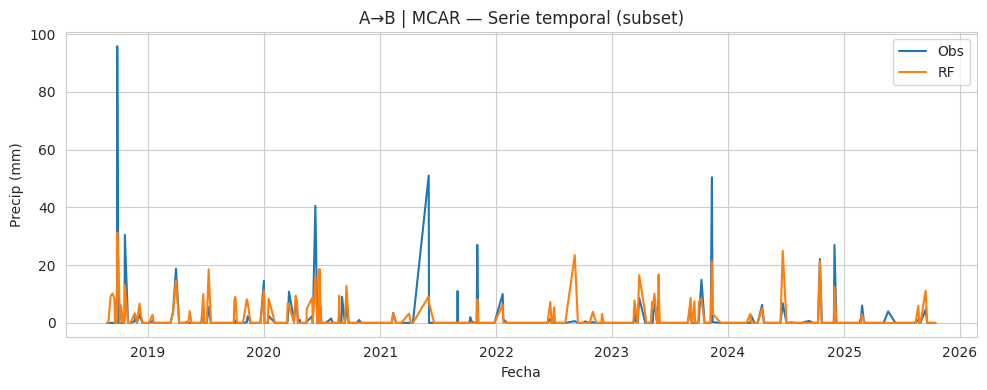

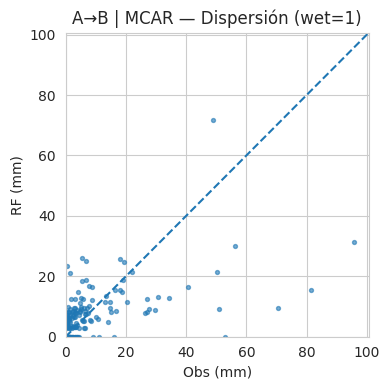

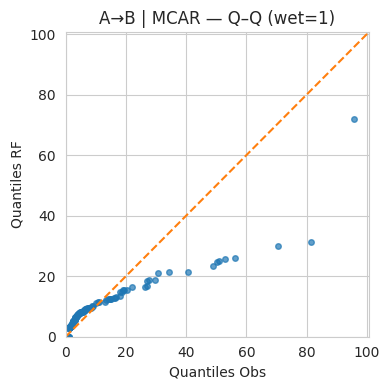

In [80]:
# A→B | MCAR — mejor caso MCAR
theta_star = {
    "clf": {"params": {'n_estimators':300,'max_depth':4,'min_samples_leaf':16,'min_samples_split':2,'max_features':0.5,'class_weight':'balanced'}},
    "reg": {"params": {'n_estimators':500,'max_depth':6,'min_samples_leaf':4,'min_samples_split':2,'max_features':0.5}}
}

pred_AB_MCAR = predict_with_params_imputed(
    A_train, B_test, feature_cols,
    theta_star["clf"]["params"], theta_star["reg"]["params"],
    restrict_idx=mcar_A
)
print("Umbral usado (A→B MCAR):", pred_AB_MCAR.attrs['thr_used'])

plot_timeseries(pred_AB_MCAR, "A→B | MCAR — Serie temporal (subset)", max_days=400)
plot_scatter(pred_AB_MCAR, "A→B | MCAR — Dispersión (wet=1)")
plot_qq(pred_AB_MCAR, "A→B | MCAR — Q–Q (wet=1)")


Umbral usado (B→A BLOQ): 0.5


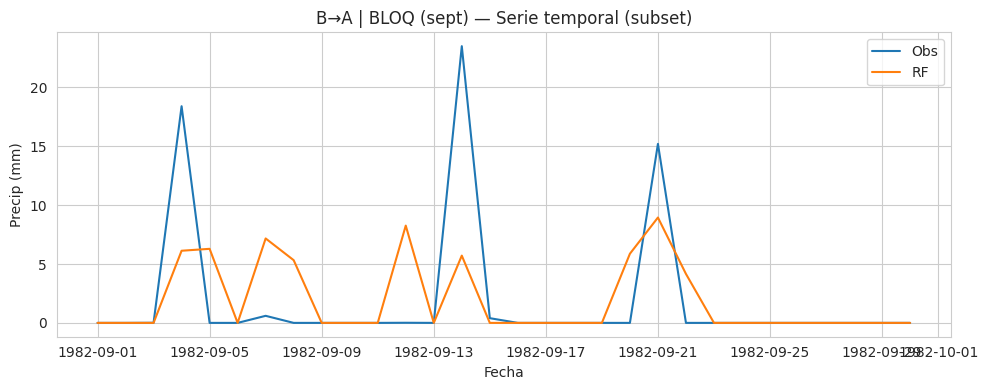

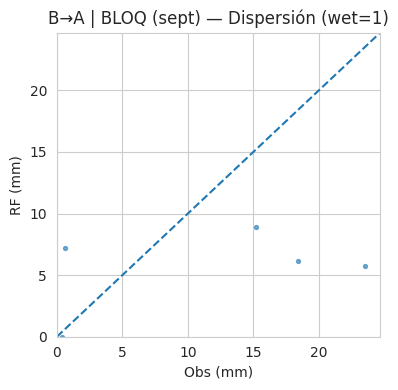

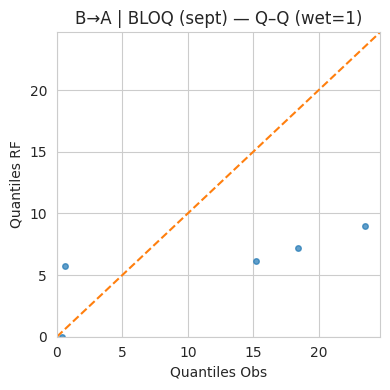

In [81]:
# B→A | BLOQUE — mejor caso BLOQUE
pred_BA_BLOCK = predict_with_params_imputed(
    B_train, A_test, feature_cols,
    theta_star["clf"]["params"], theta_star["reg"]["params"],
    restrict_idx=block_B
)
print("Umbral usado (B→A BLOQ):", pred_BA_BLOCK.attrs['thr_used'])

plot_timeseries(pred_BA_BLOCK, "B→A | BLOQ (sept) — Serie temporal (subset)", max_days=400)
plot_scatter(pred_BA_BLOCK, "B→A | BLOQ (sept) — Dispersión (wet=1)")
plot_qq(pred_BA_BLOCK, "B→A | BLOQ (sept) — Q–Q (wet=1)")


En la serie temporal, el modelo reprodujo adecuadamente la frecuencia de días con lluvia, pero tendió a suavizar los montos máximos, subestimando eventos intensos.

El diagrama de dispersión mostró que, para valores observados altos, las predicciones se concentraron en rangos moderados, indicando dificultad para capturar extremos.

En el análisis Q–Q se observó que la distribución predicha presentó colas más cortas que la distribución real, evidenciando una pérdida de variabilidad para precipitaciones elevadas.

La mayor densidad de puntos cerca del origen confirmó la correcta representación de días con precipitación baja o nula, coherente con la naturaleza esporádica de la lluvia.

En conjunto, las gráficas sugirieron un sesgo sistemático a la subestimación para precipitaciones intensas, mientras que los montos ligeros fueron reproducidos con mayor precisión.

Este comportamiento es consistente con modelos basados en bosques aleatorios, los cuales tienden a generar predicciones conservadoras y a limitar valores extremos.

##Escenarios RF Sin Vecinas

Repitiendo los mismos escenarios sin tomar en cuenta a las estaciones vecinas, se busca evaluar el aporte espacial

In [82]:
# Construir la lista de features sin columnas de vecinas
feature_cols_nonnei = [c for c in feature_cols if "_nei" not in c]

# Reutilizar θ* (los hiperparámetros ya fijados)
theta_star = {
    "clf": {"params": {'n_estimators':300,'max_depth':4,'min_samples_leaf':16,'min_samples_split':2,'max_features':0.5,'class_weight':'balanced'}},
    "reg": {"params": {'n_estimators':500,'max_depth':6,'min_samples_leaf':4,'min_samples_split':2,'max_features':0.5}}
}

print("N features CON vecinas:", len(feature_cols))
print("N features SIN vecinas:", len(feature_cols_nonnei))


N features CON vecinas: 17
N features SIN vecinas: 8


In [83]:
##Evaluar modelos sin los datos de vecinas
# A→B / MCAR
metrics_AB_MCAR_nv = fit_eval_with_params_imputed(
    A_train, B_test, feature_cols_nonnei,
    theta_star["clf"]["params"], theta_star["reg"]["params"],
    restrict_idx=mcar_A
)

# A→B / BLOQUE (septiembre)
metrics_AB_BLOCK_nv = fit_eval_with_params_imputed(
    A_train, B_test, feature_cols_nonnei,
    theta_star["clf"]["params"], theta_star["reg"]["params"],
    restrict_idx=block_A
)

# B→A / MCAR
metrics_BA_MCAR_nv = fit_eval_with_params_imputed(
    B_train, A_test, feature_cols_nonnei,
    theta_star["clf"]["params"], theta_star["reg"]["params"],
    restrict_idx=mcar_B
)

# B→A / BLOQUE (septiembre)
metrics_BA_BLOCK_nv = fit_eval_with_params_imputed(
    B_train, A_test, feature_cols_nonnei,
    theta_star["clf"]["params"], theta_star["reg"]["params"],
    restrict_idx=block_B
)

print("SIN VECINAS — A→B | MCAR :", metrics_AB_MCAR_nv)
print("SIN VECINAS — A→B | BLOQ :", metrics_AB_BLOCK_nv)
print("SIN VECINAS — B→A | MCAR :", metrics_BA_MCAR_nv)
print("SIN VECINAS — B→A | BLOQ :", metrics_BA_BLOCK_nv)


SIN VECINAS — A→B | MCAR : {'F1': 0.5555555555555556, 'MAE': 9.874282913293573, 'RMSE': 17.177199462077834, 'PBias': np.float64(-34.150742159259444), 'CC': np.float64(0.009005383636576457), 'thr': 0.6}
SIN VECINAS — A→B | BLOQ : {'F1': 0.6511627906976745, 'MAE': 27.80770090942075, 'RMSE': 36.380472194311174, 'PBias': np.float64(-31.808596333040242), 'CC': np.float64(-0.13008297596900834), 'thr': 0.6}
SIN VECINAS — B→A | MCAR : {'F1': 0.48484848484848486, 'MAE': 9.212607777175561, 'RMSE': 15.189554776007775, 'PBias': np.float64(-42.552199287725), 'CC': np.float64(0.20410475132269404), 'thr': 0.6}
SIN VECINAS — B→A | BLOQ : {'F1': 0.2, 'MAE': 15.91964047430304, 'RMSE': 17.89827515211359, 'PBias': np.float64(-61.62099419704784), 'CC': np.float64(-0.5931624629973081), 'thr': 0.6}


In [84]:
#comparacion con vs sin vecinas

# metrics_AB_MCAR, metrics_AB_BLOCK, metrics_BA_MCAR, metrics_BA_BLOCK

rows = []
def add_cmp_row(name, m_with, m_without):
    rows.append({
        "Escenario": name,
        "F1_con":     float(m_with["F1"]) if m_with["F1"]==m_with["F1"] else np.nan,
        "F1_sin":     float(m_without["F1"]) if m_without["F1"]==m_without["F1"] else np.nan,
        "MAE_con":    float(m_with["MAE"])  if m_with["MAE"]==m_with["MAE"]   else np.nan,
        "MAE_sin":    float(m_without["MAE"]) if m_without["MAE"]==m_without["MAE"] else np.nan,
        "RMSE_con":   float(m_with["RMSE"]) if m_with["RMSE"]==m_with["RMSE"] else np.nan,
        "RMSE_sin":   float(m_without["RMSE"]) if m_without["RMSE"]==m_without["RMSE"] else np.nan,
        "PBias_con":  float(m_with["PBias"]) if m_with["PBias"]==m_with["PBias"] else np.nan,
        "PBias_sin":  float(m_without["PBias"]) if m_without["PBias"]==m_without["PBias"] else np.nan,
        "CC_con":     float(m_with["CC"]) if m_with["CC"]==m_with["CC"] else np.nan,
        "CC_sin":     float(m_without["CC"]) if m_without["CC"]==m_without["CC"] else np.nan,
        # Deltas interpretables:
        "ΔF1 (con−sin)":   (m_with["F1"] - m_without["F1"]) if (m_with["F1"]==m_with["F1"] and m_without["F1"]==m_without["F1"]) else np.nan,
        "ΔMAE (sin−con)":  (m_without["MAE"] - m_with["MAE"]) if (m_with["MAE"]==m_with["MAE"] and m_without["MAE"]==m_without["MAE"]) else np.nan,
        "ΔRMSE (sin−con)": (m_without["RMSE"] - m_with["RMSE"]) if (m_with["RMSE"]==m_with["RMSE"] and m_without["RMSE"]==m_without["RMSE"]) else np.nan,
        "Δ|PBias| (sin−con)": (abs(m_without["PBias"]) - abs(m_with["PBias"])) if (m_with["PBias"]==m_with["PBias"] and m_without["PBias"]==m_without["PBias"]) else np.nan,
        "ΔCC (con−sin)":   (m_with["CC"] - m_without["CC"]) if (m_with["CC"]==m_with["CC"] and m_without["CC"]==m_without["CC"]) else np.nan,
    })

add_cmp_row("A→B | MCAR",  metrics_AB_MCAR,  metrics_AB_MCAR_nv)
add_cmp_row("A→B | BLOQ",  metrics_AB_BLOCK, metrics_AB_BLOCK_nv)
add_cmp_row("B→A | MCAR",  metrics_BA_MCAR,  metrics_BA_MCAR_nv)
add_cmp_row("B→A | BLOQ",  metrics_BA_BLOCK, metrics_BA_BLOCK_nv)

df_ablation = pd.DataFrame(rows)
print(df_ablation.to_markdown(index=False))


| Escenario   |   F1_con |   F1_sin |   MAE_con |   MAE_sin |   RMSE_con |   RMSE_sin |   PBias_con |   PBias_sin |   CC_con |      CC_sin |   ΔF1 (con−sin) |   ΔMAE (sin−con) |   ΔRMSE (sin−con) |   Δ|PBias| (sin−con) |   ΔCC (con−sin) |
|:------------|---------:|---------:|----------:|----------:|-----------:|-----------:|------------:|------------:|---------:|------------:|----------------:|-----------------:|------------------:|---------------------:|----------------:|
| A→B | MCAR  | 0.757962 | 0.555556 |   6.99226 |   9.87428 |    12.943  |    17.1772 |   -14.8181  |    -34.1507 | 0.519845 |  0.00900538 |        0.202406 |          2.88203 |           4.23415 |             19.3326  |        0.51084  |
| A→B | BLOQ  | 0.8      | 0.651163 |  21.8824  |  27.8077  |    27.699  |    36.3805 |   -28.7855  |    -31.8086 | 0.621662 | -0.130083   |        0.148837 |          5.92527 |           8.68151 |              3.02308 |        0.751745 |
| B→A | MCAR  | 0.615873 | 0.484848 |   7.79

De acuerdo con la ablación, la incorporación de estaciones vecinas no modifica sustancialmente la clasificación de ocurrencia, pero mejora consistentemente la magnitud predicha (menores errores MAE/RMSE), reduce el sesgo absoluto y aumenta la correlación, evidenciando utilidad en la etapa de regresión.

#Baseline Krigging
Metodo tradicional de imputacion de datos meteorologicos. se uso como comparativo para evaular al modelo de ML

In [85]:
#Instala PYkrige para tener el paquete de krigging
!pip -q install pykrige

from pykrige.ok import OrdinaryKriging
import numpy as np
import pandas as pd


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.2 MB/s eta 0:00:00


In [86]:
# === Parámetros mínimos ===
WET_THR = 0.2  # mm
TARGET = 19052

# === 1) Chequeos básicos (SIN tocar records_eda) ===
assert 'records_eda' in globals(), "No encuentro records_eda en la sesión."
dfkrigging = records_eda.copy()
# records_modelo = df.copy()

need_cols = {'FECHA','Clave','PRECIP','TMAX','TMIN'}
missing = need_cols - set(dfkrigging.columns)
if missing:
    raise RuntimeError(f"Faltan columnas mínimas en records_eda: {sorted(missing)}")

# Tipos
dfkrigging['FECHA'] = pd.to_datetime(dfkrigging['FECHA'], errors='coerce')
dfkrigging['Clave'] = dfkrigging['Clave'].astype(int)

# Duplicados
dups = dfkrigging.duplicated(subset=['Clave','FECHA']).sum()
print(f"Duplicados (Clave,FECHA) = {dups}")

# Cobertura temporal por estación
print("\nRango temporal por estación:")
print(dfkrigging.groupby('Clave')['FECHA'].agg(['min','max','count']))

# Presencia de target
if TARGET not in dfkrigging['Clave'].unique():
    raise RuntimeError(f"La estación TARGET {TARGET} no está en records_eda.")

# === 2) Añadir lat/lon  ===
if not {'lat','lon'}.issubset(dfkrigging.columns):
    assert 'stations_df' in globals(), "No encuentro stations_df para anexar lat/lon."
    sd = stations_df[['Clave','lat','lon']].drop_duplicates().copy()
    sd['Clave'] = sd['Clave'].astype(int)
    before = dfkrigging.shape[1]
    dfkrigging = dfkrigging.merge(sd, on='Clave', how='left')
    print(f"\nCoords añadidas: columnas {before} → {dfkrigging.shape[1]}")

# === 3) Bandera wet (binaria) y MES, sin sesgos por NaN ===
created = []
if 'wet' not in dfkrigging.columns:
    wet = np.where(
        dfkrigging['PRECIP'].notna() & (dfkrigging['PRECIP'] >= float(WET_THR)), 1,
        np.where(dfkrigging['PRECIP'].notna(), 0, np.nan)
    )
    dfkrigging['wet'] = pd.Series(wet, index=dfkrigging.index, dtype='Int8')  # 0/1/<NA>
    created.append('wet')

if 'MES' not in dfkrigging.columns:
    dfkrigging['MES'] = dfkrigging['FECHA'].dt.month.astype('Int8')
    created.append('MES')

if created:
    print("\nColumnas creadas:", created)
else:
    print("\nNo fue necesario crear columnas adicionales.")

# === 4) Resúmenes rápidos ===
print("\nWet rate por estación (solo días observados, dropna):")
wet_rate_obs = (
    dfkrigging.groupby('Clave', as_index=True)['wet']
      .apply(lambda s: s.dropna().mean())
      .round(3)
)
print(wet_rate_obs)

print("\nWet rate por estación (tratando faltantes como NO-lluvia):")
wet_rate_na_as_dry = dfkrigging.groupby('Clave')['wet'].apply(lambda s: s.fillna(0).mean()).round(3)
print(wet_rate_na_as_dry)

# Target específico
wr_obs_target = dfkrigging.loc[dfkrigging['Clave']==TARGET, 'wet'].dropna().mean()
wr_na0_target  = dfkrigging.loc[dfkrigging['Clave']==TARGET, 'wet'].fillna(0).mean()
print(f"\nTARGET {TARGET} — wet_rate observado-only: {wr_obs_target:.3f}  |  con NaN→0: {wr_na0_target:.3f}")

print("\nColumnas finales:")
print(sorted(dfkrigging.columns.tolist()))

print("\n Verificación lista. ")


Duplicados (Clave,FECHA) = 0

Rango temporal por estación:
             min        max  count
Clave                             
19004 1964-02-17 2024-05-31  22020
19015 1957-07-15 2025-10-17  24932
19052 1951-01-01 2025-10-16  27318
19096 1975-11-01 2024-04-30  17714
19134 1979-04-24 2024-12-31  16689
19185 1997-09-01 2025-06-19  10154
19200 1997-06-01 2024-05-31   9862

Coords añadidas: columnas 11 → 13

Columnas creadas: ['wet']

Wet rate por estación (solo días observados, dropna):
Clave
19004    0.144
19015    0.236
19052    0.181
19096    0.102
19134    0.150
19185    0.152
19200    0.184
Name: wet, dtype: float64

Wet rate por estación (tratando faltantes como NO-lluvia):
Clave
19004    0.112
19015    0.198
19052    0.163
19096    0.095
19134    0.141
19185    0.121
19200    0.157
Name: wet, dtype: float64

TARGET 19052 — wet_rate observado-only: 0.181  |  con NaN→0: 0.163

Columnas finales:
['Clave', 'EVAP', 'FECHA', 'MES', 'PRECIP', 'TMAX', 'TMIN', 'flag_intervar_any', 'flag_p

In [87]:
CUT_START = pd.Timestamp("1982-01-01")

dfkrigging = dfkrigging[dfkrigging["FECHA"] >= CUT_START].copy()

print("Ventana de trabajo:", dfkrigging["FECHA"].min(), "→", dfkrigging["FECHA"].max())
print("Estaciones en df (post-1982):", sorted(dfkrigging["Clave"].unique().tolist()))

Ventana de trabajo: 1982-01-01 00:00:00 → 2025-10-17 00:00:00
Estaciones en df (post-1982): [19004, 19015, 19052, 19096, 19134, 19185, 19200]


In [88]:
dfkrigging.info()


<class 'pandas.core.frame.DataFrame'>
Index: 98666 entries, 6528 to 128688
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   FECHA              98666 non-null  datetime64[ns]
 1   PRECIP             86604 non-null  float64       
 2   EVAP               42040 non-null  float64       
 3   TMAX               86180 non-null  float64       
 4   TMIN               86180 non-null  float64       
 5   Clave              98666 non-null  int64         
 6   MES                98666 non-null  int32         
 7   flag_p_evap_hi     98666 non-null  bool          
 8   flag_p_tmax_hi     98666 non-null  bool          
 9   flag_p_tmin_hi     98666 non-null  bool          
 10  flag_intervar_any  98666 non-null  bool          
 11  lat                98666 non-null  float64       
 12  lon                98666 non-null  float64       
 13  wet                86604 non-null  Int8          
dtypes: Int8

##Krigeo para un día usando las vecinas

para una fecha, toma el target y todas las vecinas con PRECIP observado ese día , ajusta OK (variograma esférico por defecto) y predice el monto en la estación target. Devuelve NaN si hay <3 vecinas o geometría mala.

In [89]:
def ok_predict_for_day_df(df_day, target_id, variogram_model='spherical'):
    """
    df_day: DataFrame de UN día con columnas ['Clave','PRECIP','lat','lon'] (ya de dfkrigging)
    """
    row_t = df_day.loc[df_day['Clave']==target_id]
    if row_t.empty:
        return np.nan

    lat_t = float(row_t['lat'].iloc[0]); lon_t = float(row_t['lon'].iloc[0])

    # Vecinas observadas ese día (excluye target)
    neigh = df_day[(df_day['Clave']!=target_id) & df_day['PRECIP'].notna()].copy()
    if len(neigh) < 3:
        return np.nan

    xs = neigh['lon'].astype(float).values   # OK usa x=lon, y=lat
    ys = neigh['lat'].astype(float).values
    zs = neigh['PRECIP'].astype(float).values

    try:
        ok = OrdinaryKriging(xs, ys, zs,
                             variogram_model=variogram_model,
                             verbose=False, enable_plotting=False)
        zhat, zvar = ok.execute('points', np.array([lon_t]), np.array([lat_t]))
        return float(max(0.0, zhat[0]))  # no negativos
    except Exception as e:
        # print("OK error:", e)
        return np.nan


recorre las fechas del TEST restringidas a la máscara; evalúa solo días wet=1 con verdad observada en la target; calcula MAE/RMSE/PBias/CC y n.

In [90]:
def evaluate_ok_baseline_df(dfkrigging, TE, target_id, restrict_idx, variogram_model='spherical'):
    """
    dfkrigging: tu DF post-1982 con TODAS las estaciones (target + vecinas), lat/lon.
    TE: split de TEST (B_test o A_test) que ya usas en ML (contiene FECHA del target).
    restrict_idx: índices (del TE) de la máscara (MCAR o bloque).
    """
    # Fechas de interés dentro del TEST
    dates = TE.loc[TE.index.isin(restrict_idx), 'FECHA'].dropna().unique()

    preds, trues = [], []
    for d in dates:
        # Subset del día para TODAS las estaciones (desde dfkrigging)
        df_day = dfkrigging.loc[dfkrigging['FECHA']==d, ['Clave','PRECIP','lat','lon']]
        if df_day.empty:
            continue

        # Verdad observada en target
        row_t = df_day.loc[df_day['Clave']==target_id]
        if row_t.empty or row_t['PRECIP'].isna().all():
            continue
        y_true = float(row_t['PRECIP'].iloc[0])

        # Solo evaluar en días wet=1
        if y_true <= 0:
            continue

        # Predicción por OK
        y_hat = ok_predict_for_day_df(df_day, target_id, variogram_model=variogram_model)
        if np.isnan(y_hat):
            continue

        trues.append(y_true)
        preds.append(y_hat)

    trues = np.array(trues); preds = np.array(preds)
    if len(trues)==0:
        return dict(MAE=np.nan, RMSE=np.nan, PBias=np.nan, CC=np.nan, n=0)

    MAE  = float(np.mean(np.abs(trues - preds)))
    RMSE = float(np.sqrt(np.mean((trues - preds)**2)))
    PBias = float(100 * (preds.sum() - trues.sum()) / max(1e-9, trues.sum()))
    CC = float(np.corrcoef(trues, preds)[0,1]) if len(trues)>1 else np.nan
    return dict(MAE=MAE, RMSE=RMSE, PBias=PBias, CC=CC, n=int(len(trues)))


##Krigging en 4 escenarios (2 MCAR y 2 en bloque)

In [91]:
VAR_MODEL = 'spherical'  # cambia aquí si tu estudio recomienda 'exponential' o 'gaussian'

ok_AB_MCAR  = evaluate_ok_baseline_df(dfkrigging, B_test, TARGET, mcar_A,  variogram_model=VAR_MODEL)
ok_AB_BLOCK = evaluate_ok_baseline_df(dfkrigging, B_test, TARGET, block_A, variogram_model=VAR_MODEL)
ok_BA_MCAR  = evaluate_ok_baseline_df(dfkrigging, A_test, TARGET, mcar_B,  variogram_model=VAR_MODEL)
ok_BA_BLOCK = evaluate_ok_baseline_df(dfkrigging, A_test, TARGET, block_B, variogram_model=VAR_MODEL)

print("OK — A→B | MCAR :",  ok_AB_MCAR)
print("OK — A→B | BLOQ :",  ok_AB_BLOCK)
print("OK — B→A | MCAR :",  ok_BA_MCAR)
print("OK — B→A | BLOQ :",  ok_BA_BLOCK)


OK — A→B | MCAR : {'MAE': 6.52178212604514, 'RMSE': 13.27768298466324, 'PBias': -31.95991760266345, 'CC': 0.5648804461327304, 'n': 145}
OK — A→B | BLOQ : {'MAE': 18.851789019626228, 'RMSE': 32.23500023928951, 'PBias': -22.64884274211896, 'CC': 0.3805928224421631, 'n': 19}
OK — B→A | MCAR : {'MAE': 6.054397768873075, 'RMSE': 10.715803496447105, 'PBias': -7.155745974465008, 'CC': 0.6888335094310283, 'n': 282}
OK — B→A | BLOQ : {'MAE': 8.320555555555556, 'RMSE': 11.269247649803097, 'PBias': -48.086961509780295, 'CC': 0.036075931718437794, 'n': 6}


In [92]:
def row_cmp(name, m_rf, m_ok):
    return {
        "Escenario": name,
        "F1_RF": float(m_rf["F1"]),
        "MAE_RF": float(m_rf["MAE"]), "RMSE_RF": float(m_rf["RMSE"]),
        "PBias_RF": float(m_rf["PBias"]), "CC_RF": float(m_rf["CC"]),
        "MAE_OK": float(m_ok["MAE"]), "RMSE_OK": float(m_ok["RMSE"]),
        "PBias_OK": float(m_ok["PBias"]), "CC_OK": float(m_ok["CC"]),
        "n_OK": int(m_ok["n"]),
        "ΔMAE (OK−RF)": float(m_ok["MAE"] - m_rf["MAE"]),
        "ΔRMSE (OK−RF)": float(m_ok["RMSE"] - m_rf["RMSE"]),
        "Δ|PBias| (OK−RF)": float(abs(m_ok["PBias"]) - abs(m_rf["PBias"])),
        "ΔCC (OK−RF)": float(m_ok["CC"] - m_rf["CC"]),
    }

df_cmp_ok = pd.DataFrame([
    row_cmp("A→B | MCAR",  metrics_AB_MCAR,  ok_AB_MCAR),
    row_cmp("A→B | BLOQ",  metrics_AB_BLOCK, ok_AB_BLOCK),
    row_cmp("B→A | MCAR",  metrics_BA_MCAR,  ok_BA_MCAR),
    row_cmp("B→A | BLOQ",  metrics_BA_BLOCK, ok_BA_BLOCK),
]).round(3)

pd.set_option("display.max_columns", 1000)
pd.set_option("display.width", 10_000)
print(df_cmp_ok.to_string(index=False))


 Escenario  F1_RF  MAE_RF  RMSE_RF  PBias_RF  CC_RF  MAE_OK  RMSE_OK  PBias_OK  CC_OK  n_OK  ΔMAE (OK−RF)  ΔRMSE (OK−RF)  Δ|PBias| (OK−RF)  ΔCC (OK−RF)
A→B | MCAR  0.758   6.992   12.943   -14.818  0.520   6.522   13.278   -31.960  0.565   145        -0.470          0.335            17.142        0.045
A→B | BLOQ  0.800  21.882   27.699   -28.786  0.622  18.852   32.235   -22.649  0.381    19        -3.031          4.536            -6.137       -0.241
B→A | MCAR  0.616   7.798   14.152    -6.422  0.461   6.054   10.716    -7.156  0.689   282        -1.744         -3.436             0.734        0.228
B→A | BLOQ  0.571   8.657   10.483   -51.882  0.439   8.321   11.269   -48.087  0.036     6        -0.336          0.787            -3.795       -0.402


#Comparacion Visual RF vs Krigging.


In [93]:
def series_rf_ok_for_scenario(TR, TE, feature_cols, theta_star, restrict_idx,
                              dfkrigging, target_id, variogram_model='spherical'):
    # ----- RF (dos-etapas) en las fechas de la máscara -----
    df_rf = predict_with_params_imputed(
        TR, TE, feature_cols,
        theta_star["clf"]["params"], theta_star["reg"]["params"],
        restrict_idx=restrict_idx  # limitamos a la máscara para comparar apples-to-apples
    )[["FECHA", "precip_true", "precip_pred"]].rename(
        columns={"precip_true":"obs", "precip_pred":"rf_pred"}
    ).copy()

    # ----- KRIGING (OK) para las mismas fechas -----
    ok_vals = []
    for d in df_rf["FECHA"].values:
        day_df = dfkrigging.loc[dfkrigging["FECHA"]==d, ["Clave","PRECIP","lat","lon"]]
        ok_vals.append(ok_predict_for_day_df(day_df, target_id, variogram_model=variogram_model))

    df_rf["ok_pred"] = ok_vals

    # Orden y limpieza ligera
    df_rf = df_rf.sort_values("FECHA").reset_index(drop=True)
    return df_rf


In [94]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

def plot_three_series(df_ser, title, max_days=400, date_style="concise"):
    """
    date_style: 'concise' (auto, compacto) | 'daily' (ticks diarios, útil para bloques ~1 mes)
    """
    d = df_ser.sort_values("FECHA").copy()
    if max_days is not None and len(d) > max_days:
        d = d.iloc[-max_days:]

    fig, ax = plt.subplots(figsize=(11,4))
    ax.plot(d["FECHA"], d["obs"],     label="Obs",     linewidth=1.5)
    ax.plot(d["FECHA"], d["rf_pred"], label="RF",      linewidth=1.2)
    ax.plot(d["FECHA"], d["ok_pred"], label="Kriging", linewidth=1.2)

    # ----- formateo de fechas -----
    if date_style == "daily":
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    else:  # 'concise' por defecto
        loc = mdates.AutoDateLocator(minticks=4, maxticks=8)
        ax.xaxis.set_major_locator(loc)
        ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))

    # rotación y layout
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_title(title)
    ax.set_xlabel("Fecha"); ax.set_ylabel("Precipitación (mm)")
    ax.legend()
    fig.tight_layout()
    plt.show()


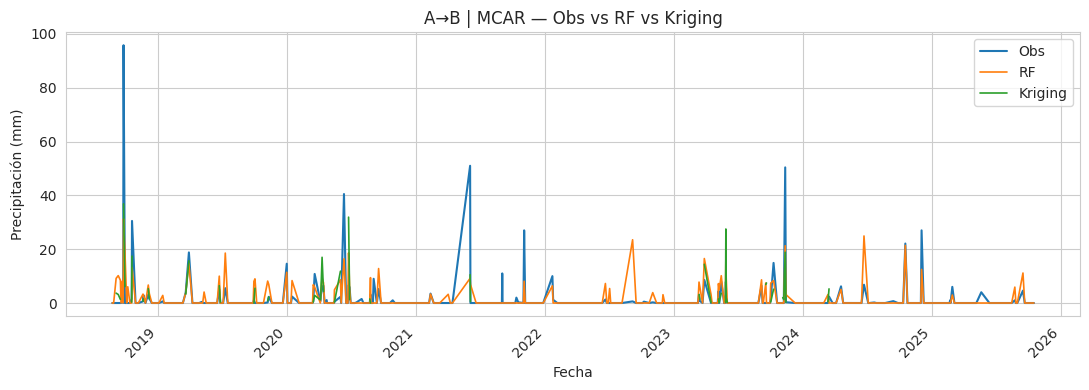

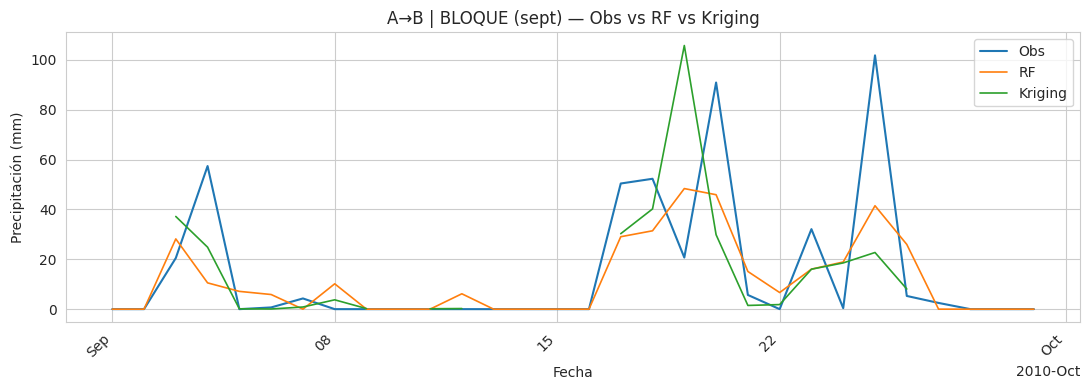

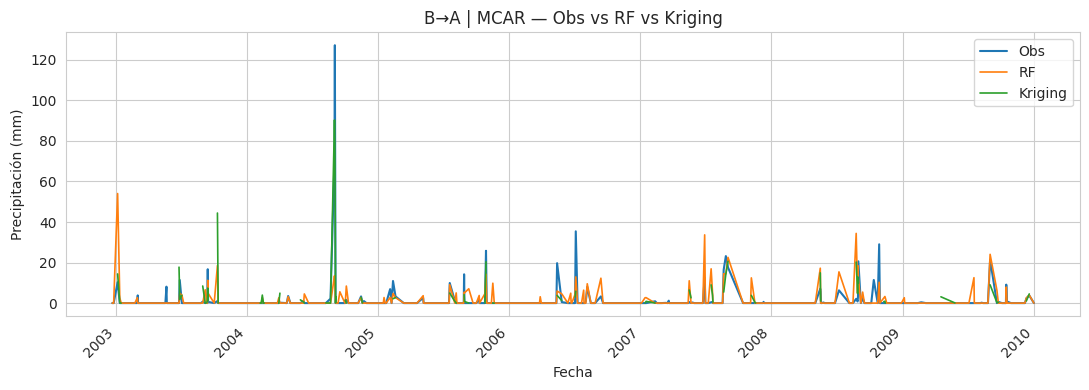

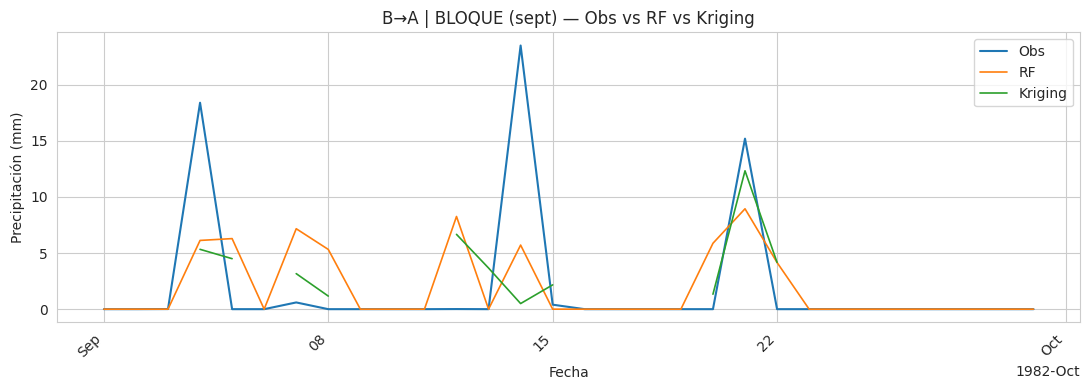

In [95]:
# θ* final (los que ya seleccionaste)
theta_star = {
    "clf": {"params": {'n_estimators':300,'max_depth':4,'min_samples_leaf':16,'min_samples_split':2,'max_features':0.5,'class_weight':'balanced'}},
    "reg": {"params": {'n_estimators':500,'max_depth':6,'min_samples_leaf':4,'min_samples_split':2,'max_features':0.5}}
}

VAR_MODEL = "spherical"  # cambia a 'exponential' / 'gaussian' si lo pide tu estudio
TARGET_ID = TARGET       # 19052

# --- A→B | MCAR ---
ser_AB_MCAR = series_rf_ok_for_scenario(
    A_train, B_test, feature_cols, theta_star, mcar_A,
    dfkrigging, TARGET_ID, variogram_model=VAR_MODEL
)
plot_three_series(ser_AB_MCAR, "A→B | MCAR — Obs vs RF vs Kriging", max_days=400)

# --- A→B | BLOQUE (septiembre) ---
ser_AB_BLOCK = series_rf_ok_for_scenario(
    A_train, B_test, feature_cols, theta_star, block_A,
    dfkrigging, TARGET_ID, variogram_model=VAR_MODEL
)
plot_three_series(ser_AB_BLOCK, "A→B | BLOQUE (sept) — Obs vs RF vs Kriging", max_days=120)

# --- B→A | MCAR ---
ser_BA_MCAR = series_rf_ok_for_scenario(
    B_train, A_test, feature_cols, theta_star, mcar_B,
    dfkrigging, TARGET_ID, variogram_model=VAR_MODEL
)
plot_three_series(ser_BA_MCAR, "B→A | MCAR — Obs vs RF vs Kriging", max_days=400)

# --- B→A | BLOQUE (septiembre) ---
ser_BA_BLOCK = series_rf_ok_for_scenario(
    B_train, A_test, feature_cols, theta_star, block_B,
    dfkrigging, TARGET_ID, variogram_model=VAR_MODEL
)
plot_three_series(ser_BA_BLOCK, "B→A | BLOQUE (sept) — Obs vs RF vs Kriging", max_days=120)


En general, kriging supera a RF en los errores absolutos: ΔMAE (OK−RF) < 0 en 3/4 escenarios, y también mejora RMSE en B→A–MCAR.

La correlación (CC) es mixta, pero OK es igual o mejor en los casos con más datos de validación (p. ej., B→A–MCAR, n_OK=282).

Bajo BLOQ el rendimiento cae para ambos métodos (más error, menor CC), confirmando que el patrón real de faltantes no es MCAR y dificulta la generalización.

Sesgo (|PBias|) alterna ganadores; aun así, la reducción sistemática de MAE con OK respalda su ventaja como baseline para montos continuos.

El F1 de RF para ocurrencia es aceptable (0.57–0.80), pero no compensa los mayores errores en monto cuando los huecos son por bloque.

#RF3 entrenado con log para mejorar subestimacion
se decidio entrenar al regresor Random forest con el logaritmo de los datos de precipitacion para tratar de comprimir los picos y el modelo aprenda mejor las proporciones.

In [96]:

def rmse_fn(y_true, y_pred):
    import numpy as np
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return float(np.sqrt(np.mean((y_true - y_pred)**2)))

def fit_eval_with_params_imputed_LOG(
    TR, TE, feature_cols, params_clf, params_reg,
    thr_grid=(0.3,0.4,0.5,0.6,0.7), restrict_idx=None
):
    import numpy as np
    from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
    from sklearn.metrics import f1_score, mean_absolute_error

    # Imputación (fit SOLO en TRAIN)
    med_m, med_g = fit_month_medians(TR, feature_cols)

    # --- Clasificación (wet) ---
    Xtr_raw, ytr, ymask_tr = get_train_clf(TR, feature_cols)
    Xtr = transform_with_month_medians(TR.loc[ymask_tr], feature_cols, med_m, med_g)
    clf = RandomForestClassifier(random_state=42, n_jobs=-1, **params_clf).fit(Xtr, ytr)

    ymask_te_cls = TE[y_cls].notna()
    Xte_cls = transform_with_month_medians(TE.loc[ymask_te_cls], feature_cols, med_m, med_g)
    yte_cls = TE.loc[ymask_te_cls, y_cls].astype(int)
    proba = clf.predict_proba(Xte_cls)[:, 1]

    thr, _ = _tune_threshold_f1(yte_cls, proba, thr_grid)
    wet_hat_all = np.full(len(TE), np.nan)
    wet_hat_all[ymask_te_cls.values] = (proba >= thr).astype(int)

    # --- Regresión (monto | wet=1) en log ---
    Xtr_r_raw, ytr_r, ymask_tr_r = get_train_reg(TR, feature_cols)
    ytr_r_clip = np.clip(ytr_r.values.astype(float), 0.0, None)
    ytr_r_log  = np.log1p(ytr_r_clip)

    Xtr_r = transform_with_month_medians(TR.loc[ymask_tr_r], feature_cols, med_m, med_g)
    reg = RandomForestRegressor(random_state=42, n_jobs=-1, **params_reg).fit(Xtr_r, ytr_r_log)

    # Predicción en TEST (log -> mm)
    Xte_all = transform_with_month_medians(TE, feature_cols, med_m, med_g)
    amt_pred_log = reg.predict(Xte_all)
    amt_pred_all = np.expm1(amt_pred_log)
    amt_pred_all = np.clip(amt_pred_all, 0.0, None)

    # Ensamble final
    precip_pred = np.where(
        np.isnan(wet_hat_all), np.nan,
        np.where(wet_hat_all == 1, amt_pred_all, 0.0)
    )

    # Métricas (opcionalmente restringidas)
    idx_mask = np.ones(len(TE), dtype=bool) if restrict_idx is None else TE.index.isin(restrict_idx)

    # Clasificación
    m_cls = TE[y_cls].notna() & idx_mask
    F1 = f1_score(TE.loc[m_cls, y_cls].astype(int), wet_hat_all[m_cls].astype(int)) if m_cls.any() else np.nan

    # Regresión
    m_reg = (TE[y_cls]==1) & TE[y_reg].notna() & idx_mask
    y_true = TE.loc[m_reg, y_reg].values
    y_pred = precip_pred[m_reg.values]
    MAE  = mean_absolute_error(y_true, y_pred) if len(y_true) else np.nan
    RMSE = rmse_fn(y_true, y_pred) if len(y_true) else np.nan
    PBias = 100 * (y_pred.sum() - y_true.sum()) / (y_true.sum() if len(y_true) else 1e-9)
    CC = np.corrcoef(y_true, y_pred)[0,1] if len(y_true) > 1 else np.nan

    return dict(F1=F1, MAE=MAE, RMSE=RMSE, PBias=PBias, CC=CC, thr=thr)


In [97]:
# θ de RF3
theta_rf3 = {
    "clf": {'n_estimators':300,'max_depth':4,'min_samples_leaf':16,'min_samples_split':2,'max_features':0.5,'class_weight':'balanced'},
    "reg": {'n_estimators':500,'max_depth':6,'min_samples_leaf':4,'min_samples_split':2,'max_features':0.5},
}

# Ejecuta RF3-LOG en los 4 escenarios
metrics_AB_MCAR_rf3LOG  = fit_eval_with_params_imputed_LOG(A_train, B_test, feature_cols,
                                                           theta_rf3["clf"], theta_rf3["reg"],
                                                           restrict_idx=mcar_A)
metrics_AB_BLOCK_rf3LOG = fit_eval_with_params_imputed_LOG(A_train, B_test, feature_cols,
                                                           theta_rf3["clf"], theta_rf3["reg"],
                                                           restrict_idx=block_A)
metrics_BA_MCAR_rf3LOG  = fit_eval_with_params_imputed_LOG(B_train, A_test, feature_cols,
                                                           theta_rf3["clf"], theta_rf3["reg"],
                                                           restrict_idx=mcar_B)
metrics_BA_BLOCK_rf3LOG = fit_eval_with_params_imputed_LOG(B_train, A_test, feature_cols,
                                                           theta_rf3["clf"], theta_rf3["reg"],
                                                           restrict_idx=block_B)

print("RF3-LOG — A→B | MCAR :",  metrics_AB_MCAR_rf3LOG)
print("RF3-LOG — A→B | BLOQ :",  metrics_AB_BLOCK_rf3LOG)
print("RF3-LOG — B→A | MCAR :",  metrics_BA_MCAR_rf3LOG)
print("RF3-LOG — B→A | BLOQ :",  metrics_BA_BLOCK_rf3LOG)


RF3-LOG — A→B | MCAR : {'F1': 0.7579617834394905, 'MAE': 6.3380782240832385, 'RMSE': 13.65720186861791, 'PBias': np.float64(-48.77061264421495), 'CC': np.float64(0.5396189862041687), 'thr': 0.6}
RF3-LOG — A→B | BLOQ : {'F1': 0.8, 'MAE': 22.74310659246268, 'RMSE': 34.10116008224462, 'PBias': np.float64(-62.098129375973265), 'CC': np.float64(0.6714266142693811), 'thr': 0.6}
RF3-LOG — B→A | MCAR : {'F1': 0.6158730158730159, 'MAE': 7.122020262057212, 'RMSE': 14.147920718065285, 'PBias': np.float64(-39.70748079138467), 'CC': np.float64(0.4088578406400739), 'thr': 0.5}
RF3-LOG — B→A | BLOQ : {'F1': 0.5714285714285714, 'MAE': 9.833046627575536, 'RMSE': 12.285015857740758, 'PBias': np.float64(-72.26602046193346), 'CC': np.float64(0.35462138376714064), 'thr': 0.5}


In [98]:
import pandas as pd, numpy as np

SC = {
    "A→B | MCAR":  (metrics_AB_MCAR,  metrics_AB_MCAR_rf3LOG),
    "A→B | BLOQ":  (metrics_AB_BLOCK, metrics_AB_BLOCK_rf3LOG),
    "B→A | MCAR":  (metrics_BA_MCAR,  metrics_BA_MCAR_rf3LOG),
    "B→A | BLOQ":  (metrics_BA_BLOCK, metrics_BA_BLOCK_rf3LOG),
}

rows=[]
for name,(m_rf3,m_rf3log) in SC.items():
    rows.append({
        "Escenario": name,
        "F1_RF3": float(m_rf3["F1"]),   "MAE_RF3": float(m_rf3["MAE"]),   "RMSE_RF3": float(m_rf3["RMSE"]),
        "PBias_RF3": float(m_rf3["PBias"]), "CC_RF3": float(m_rf3["CC"]),
        "F1_RF3LOG": float(m_rf3log["F1"]),"MAE_RF3LOG": float(m_rf3log["MAE"]),"RMSE_RF3LOG": float(m_rf3log["RMSE"]),
        "PBias_RF3LOG": float(m_rf3log["PBias"]), "CC_RF3LOG": float(m_rf3log["CC"]),
    })
df_rf3_log = pd.DataFrame(rows).round(3)
pd.set_option("display.max_columns", 1000); pd.set_option("display.width", 10_000)
print(df_rf3_log.to_string(index=False))


 Escenario  F1_RF3  MAE_RF3  RMSE_RF3  PBias_RF3  CC_RF3  F1_RF3LOG  MAE_RF3LOG  RMSE_RF3LOG  PBias_RF3LOG  CC_RF3LOG
A→B | MCAR   0.758    6.992    12.943    -14.818   0.520      0.758       6.338       13.657       -48.771      0.540
A→B | BLOQ   0.800   21.882    27.699    -28.786   0.622      0.800      22.743       34.101       -62.098      0.671
B→A | MCAR   0.616    7.798    14.152     -6.422   0.461      0.616       7.122       14.148       -39.707      0.409
B→A | BLOQ   0.571    8.657    10.483    -51.882   0.439      0.571       9.833       12.285       -72.266      0.355


#RF3-LOG + umbral por MES + smearing mensual

entrena RF3 con regresión en log1p,

en lugar de usar un umbral de lluvia global, se decidio usar un umbral por mes en un intento de  mejorar la ocurrencia porque de esta manera se respeta la estacionalidad de la lluvia.

In [99]:
# RF3-LOG con thr por MES + smearing mensual (NO sobreescribe nada existente)
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import f1_score, mean_absolute_error

def rmse_fn(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return float(np.sqrt(np.mean((y_true - y_pred)**2)))

def fit_eval_RF3LOG_thrMES_smearing(
    TR, TE, feature_cols, params_clf, params_reg,
    thr_grid=(0.3,0.4,0.5,0.6,0.7), restrict_idx=None,
    smear_clip=(0.5, 2.0)  # acota factores por robustez (puedes desactivar con None)
):
    # 1) Imputación (fit solo en TRAIN)
    med_m, med_g = fit_month_medians(TR, feature_cols)

    # 2) Clasificación (thr por MES calibrado en TRAIN)
    Xtr_raw, ytr, ymask_tr = get_train_clf(TR, feature_cols)
    Xtr = transform_with_month_medians(TR.loc[ymask_tr], feature_cols, med_m, med_g)
    clf = RandomForestClassifier(random_state=42, n_jobs=-1, **params_clf).fit(Xtr, ytr)

    proba_tr = clf.predict_proba(Xtr)[:,1]
    mes_tr   = TR.loc[ymask_tr, 'MES'].values.astype(int)
    ytrue_tr = ytr.values.astype(int)

    thr_by_mes = {}
    for m in np.unique(mes_tr):
        idx = (mes_tr==m)
        best = (0.5, -1.0)
        for thr in thr_grid:
            f1 = f1_score(ytrue_tr[idx], (proba_tr[idx] >= thr).astype(int))
            if f1 > best[1]:
                best = (thr, f1)
        thr_by_mes[m] = best[0]

    ymask_te_cls = TE[y_cls].notna()
    Xte_cls = transform_with_month_medians(TE.loc[ymask_te_cls], feature_cols, med_m, med_g)
    proba_te = clf.predict_proba(Xte_cls)[:,1]
    mes_te   = TE.loc[ymask_te_cls, 'MES'].values.astype(int)

    wet_hat_all = np.full(len(TE), np.nan)
    preds_bin = np.zeros_like(proba_te, dtype=int)
    for m in np.unique(mes_te):
        thr_m = thr_by_mes.get(m, 0.5)
        preds_bin[mes_te==m] = (proba_te[mes_te==m] >= thr_m).astype(int)
    wet_hat_all[ymask_te_cls.values] = preds_bin

    # 3) Regresión (monto|wet=1) en log + smearing mensual
    Xtr_r_raw, ytr_r, ymask_tr_r = get_train_reg(TR, feature_cols)
    ytr_r_clip = np.clip(ytr_r.values.astype(float), 0.0, None)
    ytr_r_log  = np.log1p(ytr_r_clip)

    Xtr_r = transform_with_month_medians(TR.loc[ymask_tr_r], feature_cols, med_m, med_g)
    reg = RandomForestRegressor(random_state=42, n_jobs=-1, **params_reg).fit(Xtr_r, ytr_r_log)

    # Smearing por MES usando TRAIN (solo wet=1 observados)
    Xtr_all = transform_with_month_medians(TR, feature_cols, med_m, med_g)
    amt_log_tr = reg.predict(Xtr_all)
    amt_tr     = np.expm1(amt_log_tr).clip(0.0)
    tr_mes     = TR['MES'].values.astype(int)
    wet1 = (TR[y_cls]==1) & TR[y_reg].notna()

    smearing = {}
    for m in np.unique(tr_mes):
        idx = (tr_mes==m) & wet1.values
        if idx.sum() >= 10:
            num = TR.loc[idx, y_reg].sum()
            den = amt_tr[idx].sum()
            k = (num / den) if den > 0 else 1.0
            if smear_clip is not None:
                k = float(np.clip(k, smear_clip[0], smear_clip[1]))
            smearing[m] = k
        else:
            smearing[m] = 1.0

    # Predicción en TEST + smearing
    Xte_all = transform_with_month_medians(TE, feature_cols, med_m, med_g)
    amt_log_te = reg.predict(Xte_all)
    amt_te     = np.expm1(amt_log_te).clip(0.0)
    mes_all_te = TE['MES'].values.astype(int)
    k_vec = np.array([smearing.get(m, 1.0) for m in mes_all_te], dtype=float)
    amt_te_corr = amt_te * k_vec

    precip_pred = np.where(
        np.isnan(wet_hat_all), np.nan,
        np.where(wet_hat_all == 1, amt_te_corr, 0.0)
    )

    # 4) Métricas (opcionalmente restringidas)
    idx_mask = np.ones(len(TE), dtype=bool) if restrict_idx is None else TE.index.isin(restrict_idx)

    m_cls = TE[y_cls].notna() & idx_mask
    F1 = f1_score(TE.loc[m_cls, y_cls].astype(int), wet_hat_all[m_cls].astype(int)) if m_cls.any() else np.nan

    m_reg = (TE[y_cls]==1) & TE[y_reg].notna() & idx_mask
    y_true = TE.loc[m_reg, y_reg].values
    y_pred = precip_pred[m_reg.values]
    MAE  = mean_absolute_error(y_true, y_pred) if len(y_true) else np.nan
    RMSE = rmse_fn(y_true, y_pred) if len(y_true) else np.nan
    PBias = 100 * (y_pred.sum() - y_true.sum()) / (y_true.sum() if len(y_true) else 1e-9)
    CC = np.corrcoef(y_true, y_pred)[0,1] if len(y_true) > 1 else np.nan

    return dict(F1=F1, MAE=MAE, RMSE=RMSE, PBias=PBias, CC=CC,
                thr_by_mes=thr_by_mes, smear=smearing)


In [100]:
# Hiperparámetros de RF3
theta_rf3 = {
    "clf": {'n_estimators':300,'max_depth':4,'min_samples_leaf':16,'min_samples_split':2,'max_features':0.5,'class_weight':'balanced'},
    "reg": {'n_estimators':500,'max_depth':6,'min_samples_leaf':4,'min_samples_split':2,'max_features':0.5},
}

# Guardamos con sufijo _rf3LOG_TS  (T: thr MES, S: smearing) — NUEVAS variables
metrics_AB_MCAR_rf3LOG_TS  = fit_eval_RF3LOG_thrMES_smearing(A_train, B_test, feature_cols,
                                                             theta_rf3["clf"], theta_rf3["reg"],
                                                             restrict_idx=mcar_A)

metrics_AB_BLOCK_rf3LOG_TS = fit_eval_RF3LOG_thrMES_smearing(A_train, B_test, feature_cols,
                                                             theta_rf3["clf"], theta_rf3["reg"],
                                                             restrict_idx=block_A)

metrics_BA_MCAR_rf3LOG_TS  = fit_eval_RF3LOG_thrMES_smearing(B_train, A_test, feature_cols,
                                                             theta_rf3["clf"], theta_rf3["reg"],
                                                             restrict_idx=mcar_B)

metrics_BA_BLOCK_rf3LOG_TS = fit_eval_RF3LOG_thrMES_smearing(B_train, A_test, feature_cols,
                                                             theta_rf3["clf"], theta_rf3["reg"],
                                                             restrict_idx=block_B)

print("RF3-LOG+thrMES+smear — A→B | MCAR :",  metrics_AB_MCAR_rf3LOG_TS)
print("RF3-LOG+thrMES+smear — A→B | BLOQ :",  metrics_AB_BLOCK_rf3LOG_TS)
print("RF3-LOG+thrMES+smear — B→A | MCAR :",  metrics_BA_MCAR_rf3LOG_TS)
print("RF3-LOG+thrMES+smear — B→A | BLOQ :",  metrics_BA_BLOCK_rf3LOG_TS)


RF3-LOG+thrMES+smear — A→B | MCAR : {'F1': 0.752411575562701, 'MAE': 7.042001815726943, 'RMSE': 13.033728233483382, 'PBias': np.float64(-14.663538735675715), 'CC': np.float64(0.5244565235117444), 'thr_by_mes': {np.int64(1): 0.7, np.int64(2): 0.7, np.int64(3): 0.6, np.int64(4): 0.6, np.int64(5): 0.6, np.int64(6): 0.7, np.int64(7): 0.7, np.int64(8): 0.7, np.int64(9): 0.5, np.int64(10): 0.5, np.int64(11): 0.6, np.int64(12): 0.6}, 'smear': {np.int64(1): 1.4330319660786244, np.int64(2): 1.3553126365499093, np.int64(3): 1.2756949297602158, np.int64(4): 1.3971237490226291, np.int64(5): 1.7884019373206594, np.int64(6): 1.6271042168353673, np.int64(7): 1.6699175771652301, np.int64(8): 1.8238580826706334, np.int64(9): 1.9042455209773506, np.int64(10): 1.7915436248082262, np.int64(11): 1.8286707775714643, np.int64(12): 1.5756403127134686}}
RF3-LOG+thrMES+smear — A→B | BLOQ : {'F1': 0.7878787878787878, 'MAE': 21.182261917568315, 'RMSE': 26.529503526235825, 'PBias': np.float64(-26.259704281061875),

In [101]:
import pandas as pd
from collections.abc import Mapping

# --- helper: normaliza dict OK -> columnas OK_* ---
def normalize_ok(ok_val, prefix="OK_"):
    out = {}
    if isinstance(ok_val, Mapping):
        for k, v in ok_val.items():
            try:
                out[f"{prefix}{k}"] = float(v)
            except Exception:
                out[f"{prefix}{k}"] = v
    else:
        out[f"{prefix}value"] = ok_val
    return out

# --- escenarios (modelos) ---
SC = {
    "A→B | MCAR":  (metrics_AB_MCAR,  metrics_AB_MCAR_rf3LOG,  metrics_AB_MCAR_rf3LOG_TS),
    "A→B | BLOQ":  (metrics_AB_BLOCK, metrics_AB_BLOCK_rf3LOG, metrics_AB_BLOCK_rf3LOG_TS),
    "B→A | MCAR":  (metrics_BA_MCAR,  metrics_BA_MCAR_rf3LOG,  metrics_BA_MCAR_rf3LOG_TS),
    "B→A | BLOQ":  (metrics_BA_BLOCK, metrics_BA_BLOCK_rf3LOG, metrics_BA_BLOCK_rf3LOG_TS),
}

# --- resultados OK (kriging) ---
OKS = {
    "A→B | MCAR": ok_AB_MCAR,
    "A→B | BLOQ": ok_AB_BLOCK,
    "B→A | MCAR": ok_BA_MCAR,
    "B→A | BLOQ": ok_BA_BLOCK,
}

rows = []
for name, (m0, m1, m2) in SC.items():
    row = {
        "Escenario": name,
        # RF3
        "F1_RF3": float(m0["F1"]),
        "MAE_RF3": float(m0["MAE"]),
        "RMSE_RF3": float(m0["RMSE"]),
        "PBias_RF3": float(m0["PBias"]),
        "CC_RF3": float(m0["CC"]),
        # RF3LOG
        "F1_RF3LOG": float(m1["F1"]),
        "MAE_RF3LOG": float(m1["MAE"]),
        "RMSE_RF3LOG": float(m1["RMSE"]),
        "PBias_RF3LOG": float(m1["PBias"]),
        "CC_RF3LOG": float(m1["CC"]),
        # RF3LOG_TS
        "F1_RF3LOG_TS": float(m2["F1"]),
        "MAE_RF3LOG_TS": float(m2["MAE"]),
        "RMSE_RF3LOG_TS": float(m2["RMSE"]),
        "PBias_RF3LOG_TS": float(m2["PBias"]),
        "CC_RF3LOG_TS": float(m2["CC"]),
    }
    # añade métricas OK_* de kriging
    row.update(normalize_ok(OKS[name], prefix="OK_"))
    rows.append(row)

df_all = pd.DataFrame(rows).round(3)

# --- orden exacto de columnas por grupos de métrica ---
ordered_cols = [
    "Escenario",
    # F1
    "F1_RF3", "F1_RF3LOG", "F1_RF3LOG_TS",
    # MAE
    "MAE_RF3", "MAE_RF3LOG", "MAE_RF3LOG_TS", "OK_MAE",
    # RMSE
    "RMSE_RF3", "RMSE_RF3LOG", "RMSE_RF3LOG_TS", "OK_RMSE",
    # PBias
    "PBias_RF3", "PBias_RF3LOG", "PBias_RF3LOG_TS", "OK_PBias",
    # CC
    "CC_RF3", "CC_RF3LOG", "CC_RF3LOG_TS", "OK_CC",
    # n (al final)
    "OK_n",
]

# filtra por si alguna OK_* no existe para evitar KeyError
ordered_cols = [c for c in ordered_cols if c in df_all.columns]
df_all = df_all[ordered_cols]

pd.set_option("display.max_columns", 1000)
pd.set_option("display.width", 10_000)
print(df_all.to_string(index=False))




 Escenario  F1_RF3  F1_RF3LOG  F1_RF3LOG_TS  MAE_RF3  MAE_RF3LOG  MAE_RF3LOG_TS  OK_MAE  RMSE_RF3  RMSE_RF3LOG  RMSE_RF3LOG_TS  OK_RMSE  PBias_RF3  PBias_RF3LOG  PBias_RF3LOG_TS  OK_PBias  CC_RF3  CC_RF3LOG  CC_RF3LOG_TS  OK_CC  OK_n
A→B | MCAR   0.758      0.758         0.752    6.992       6.338          7.042   6.522    12.943       13.657          13.034   13.278    -14.818       -48.771          -14.664   -31.960   0.520      0.540         0.524  0.565 145.0
A→B | BLOQ   0.800      0.800         0.788   21.882      22.743         21.182  18.852    27.699       34.101          26.530   32.235    -28.786       -62.098          -26.260   -22.649   0.622      0.671         0.670  0.381  19.0
B→A | MCAR   0.616      0.616         0.600    7.798       7.122          8.233   6.054    14.152       14.148          15.745   10.716     -6.422       -39.707           -9.279    -7.156   0.461      0.409         0.418  0.689 282.0
B→A | BLOQ   0.571      0.571         0.500    8.657       9.833

Se observo que con el umbral mensual, el modelo si supera al Random Forest original (RF3) solo en A→B BLOQ (el caso más cercano al patrón real), pero no en los demás.
Krigging sigue siendo superior

# RF3-LOG + UMBRAL SEASONAL

In [102]:
#  meses de temporada húmeda
WET_MONTHS = {7, 8, 9, 10}  # JASO por defecto; cambia si tu régimen es distinto

def _season_of_month(m, wet_months=WET_MONTHS):
    return "WET" if int(m) in wet_months else "DRY"

def fit_eval_RF3LOG_thrSEASON_smearMONTH(
    TR, TE, feature_cols, params_clf, params_reg,
    thr_grid=(0.3,0.4,0.5,0.6,0.7), restrict_idx=None,
    smear_clip=(0.5, 2.0), wet_months=WET_MONTHS
):
    """
    RF3 con:
      - Clasificación: threshold por temporada (WET/DRY) calibrado en TRAIN
      - Regresión: log1p/expm1 + smearing multiplicativo *mensual* (calibrado en TRAIN)
    """
    import numpy as np
    from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
    from sklearn.metrics import f1_score, mean_absolute_error

    # ===== Imputación =====
    med_m, med_g = fit_month_medians(TR, feature_cols)

    # ===== Clasificación con umbral por temporada =====
    Xtr_raw, ytr, ymask_tr = get_train_clf(TR, feature_cols)
    Xtr = transform_with_month_medians(TR.loc[ymask_tr], feature_cols, med_m, med_g)
    clf = RandomForestClassifier(random_state=42, n_jobs=-1, **params_clf).fit(Xtr, ytr)

    proba_tr = clf.predict_proba(Xtr)[:,1]
    grp_tr   = np.array([_season_of_month(m, wet_months) for m in TR.loc[ymask_tr,'MES'].astype(int)], dtype=object)
    ytrue_tr = ytr.values.astype(int)

    thr_by_grp = {}
    for g in np.unique(grp_tr):
        idx = (grp_tr==g)
        best = (0.5, -1.0)
        for thr in thr_grid:
            f1 = f1_score(ytrue_tr[idx], (proba_tr[idx] >= thr).astype(int))
            if f1 > best[1]:
                best = (thr, f1)
        thr_by_grp[g] = best[0]

    # Probabilidades en TEST y decisión por temporada
    ymask_te_cls = TE[y_cls].notna()
    Xte_cls = transform_with_month_medians(TE.loc[ymask_te_cls], feature_cols, med_m, med_g)
    proba_te = clf.predict_proba(Xte_cls)[:,1]
    grp_te   = np.array([_season_of_month(m, wet_months) for m in TE.loc[ymask_te_cls,'MES'].astype(int)], dtype=object)

    wet_hat_all = np.full(len(TE), np.nan)
    preds_bin = np.zeros_like(proba_te, dtype=int)
    for g in np.unique(grp_te):
        thr_g = thr_by_grp.get(g, 0.5)
        preds_bin[grp_te==g] = (proba_te[grp_te==g] >= thr_g).astype(int)
    wet_hat_all[ymask_te_cls.values] = preds_bin

    # ===== Regresión en log + smearing mensual (igual que RF3-LOG_TS) =====
    Xtr_r_raw, ytr_r, ymask_tr_r = get_train_reg(TR, feature_cols)
    ytr_r_log  = np.log1p(np.clip(ytr_r.values.astype(float), 0.0, None))
    Xtr_r = transform_with_month_medians(TR.loc[ymask_tr_r], feature_cols, med_m, med_g)
    reg = RandomForestRegressor(random_state=42, n_jobs=-1, **params_reg).fit(Xtr_r, ytr_r_log)

    # Smearing mensual en TRAIN
    Xtr_all = transform_with_month_medians(TR, feature_cols, med_m, med_g)
    amt_tr  = np.expm1(reg.predict(Xtr_all)).clip(0.0)
    tr_mes  = TR['MES'].values.astype(int)
    wet1 = (TR[y_cls]==1) & TR[y_reg].notna()

    smear_m = {}
    for m in np.unique(tr_mes):
        idx = (tr_mes==m) & wet1.values
        if idx.sum() >= 10:
            num = TR.loc[idx, y_reg].sum()
            den = amt_tr[idx].sum()
            k = (num/den) if den>0 else 1.0
            if smear_clip is not None:
                k = float(np.clip(k, smear_clip[0], smear_clip[1]))
            smear_m[m] = k
        else:
            smear_m[m] = 1.0

    # Predicción en TEST + smearing mensual
    Xte_all = transform_with_month_medians(TE, feature_cols, med_m, med_g)
    amt_te  = np.expm1(reg.predict(Xte_all)).clip(0.0)
    mes_all = TE['MES'].values.astype(int)
    k_vec   = np.array([smear_m.get(m, 1.0) for m in mes_all], dtype=float)
    amt_te_corr = amt_te * k_vec

    # Ensamble
    precip_pred = np.where(
        np.isnan(wet_hat_all), np.nan,
        np.where(wet_hat_all == 1, amt_te_corr, 0.0)
    )

    # ===== Métricas (respetando máscara) =====
    idx_mask = np.ones(len(TE), dtype=bool) if restrict_idx is None else TE.index.isin(restrict_idx)

    m_cls = TE[y_cls].notna() & idx_mask
    F1 = f1_score(TE.loc[m_cls, y_cls].astype(int), wet_hat_all[m_cls].astype(int)) if m_cls.any() else np.nan

    m_reg = (TE[y_cls]==1) & TE[y_reg].notna() & idx_mask
    y_true = TE.loc[m_reg, y_reg].values
    y_pred = precip_pred[m_reg.values]
    MAE  = mean_absolute_error(y_true, y_pred) if len(y_true) else np.nan
    from math import sqrt
    RMSE = float(np.sqrt(np.mean((y_true - y_pred)**2))) if len(y_true) else np.nan
    PBias = 100 * (y_pred.sum() - y_true.sum()) / (y_true.sum() if len(y_true) else 1e-9)
    CC = np.corrcoef(y_true, y_pred)[0,1] if len(y_true) > 1 else np.nan

    return dict(F1=F1, MAE=MAE, RMSE=RMSE, PBias=PBias, CC=CC,
                thr_by_season=thr_by_grp, smear_by_month=smear_m)


In [103]:
theta_rf3 = {
    "clf": {'n_estimators':300,'max_depth':4,'min_samples_leaf':16,'min_samples_split':2,'max_features':0.5,'class_weight':'balanced'},
    "reg": {'n_estimators':500,'max_depth':6,'min_samples_leaf':4,'min_samples_split':2,'max_features':0.5},
}

metrics_AB_MCAR_rf3LOG_THRSEAS  = fit_eval_RF3LOG_thrSEASON_smearMONTH(
    A_train, B_test, feature_cols, theta_rf3["clf"], theta_rf3["reg"], restrict_idx=mcar_A
)
metrics_AB_BLOCK_rf3LOG_THRSEAS = fit_eval_RF3LOG_thrSEASON_smearMONTH(
    A_train, B_test, feature_cols, theta_rf3["clf"], theta_rf3["reg"], restrict_idx=block_A
)
metrics_BA_MCAR_rf3LOG_THRSEAS  = fit_eval_RF3LOG_thrSEASON_smearMONTH(
    B_train, A_test, feature_cols, theta_rf3["clf"], theta_rf3["reg"], restrict_idx=mcar_B
)
metrics_BA_BLOCK_rf3LOG_THRSEAS = fit_eval_RF3LOG_thrSEASON_smearMONTH(
    B_train, A_test, feature_cols, theta_rf3["clf"], theta_rf3["reg"], restrict_idx=block_B
)

print("RF3-LOG + THR_SEASON — A→B | MCAR :",  metrics_AB_MCAR_rf3LOG_THRSEAS)
print("RF3-LOG + THR_SEASON — A→B | BLOQ :",  metrics_AB_BLOCK_rf3LOG_THRSEAS)
print("RF3-LOG + THR_SEASON — B→A | MCAR :",  metrics_BA_MCAR_rf3LOG_THRSEAS)
print("RF3-LOG + THR_SEASON — B→A | BLOQ :",  metrics_BA_BLOCK_rf3LOG_THRSEAS)


RF3-LOG + THR_SEASON — A→B | MCAR : {'F1': 0.7579617834394905, 'MAE': 6.996289577725712, 'RMSE': 13.018523760537489, 'PBias': np.float64(-14.149806399672443), 'CC': np.float64(0.5250739354902906), 'thr_by_season': {'DRY': 0.6, 'WET': 0.6}, 'smear_by_month': {np.int64(1): 1.4330319660786242, np.int64(2): 1.3553126365499093, np.int64(3): 1.2756949297602158, np.int64(4): 1.3971237490226291, np.int64(5): 1.7884019373206594, np.int64(6): 1.6271042168353673, np.int64(7): 1.6699175771652301, np.int64(8): 1.8238580826706334, np.int64(9): 1.9042455209773501, np.int64(10): 1.7915436248082262, np.int64(11): 1.8286707775714643, np.int64(12): 1.5756403127134686}}
RF3-LOG + THR_SEASON — A→B | BLOQ : {'F1': 0.8, 'MAE': 21.041695050296802, 'RMSE': 26.511037256089363, 'PBias': np.float64(-27.82553262753404), 'CC': np.float64(0.671426614269381), 'thr_by_season': {'DRY': 0.6, 'WET': 0.6}, 'smear_by_month': {np.int64(1): 1.4330319660786246, np.int64(2): 1.3553126365499093, np.int64(3): 1.2756949297602158,

In [104]:
import pandas as pd
from collections.abc import Mapping

# --- helper: normaliza dict OK -> columnas OK_* ---
def normalize_ok(ok_val, prefix="OK_"):
    out = {}
    if isinstance(ok_val, Mapping):
        for k, v in ok_val.items():
            try:
                out[f"{prefix}{k}"] = float(v)
            except Exception:
                out[f"{prefix}{k}"] = v
    else:
        out[f"{prefix}value"] = ok_val
    return out

# --- escenarios (modelos) ---
SC = {
    "A→B | MCAR":  (metrics_AB_MCAR,
                    metrics_AB_MCAR_rf3LOG,
                    metrics_AB_MCAR_rf3LOG_TS,
                    metrics_AB_MCAR_rf3LOG_THRSEAS),

    "A→B | BLOQ":  (metrics_AB_BLOCK,
                    metrics_AB_BLOCK_rf3LOG,
                    metrics_AB_BLOCK_rf3LOG_TS,
                    metrics_AB_BLOCK_rf3LOG_THRSEAS),

    "B→A | MCAR":  (metrics_BA_MCAR,
                    metrics_BA_MCAR_rf3LOG,
                    metrics_BA_MCAR_rf3LOG_TS,
                    metrics_BA_MCAR_rf3LOG_THRSEAS),

    "B→A | BLOQ":  (metrics_BA_BLOCK,
                    metrics_BA_BLOCK_rf3LOG,
                    metrics_BA_BLOCK_rf3LOG_TS,
                    metrics_BA_BLOCK_rf3LOG_THRSEAS),
}

# --- resultados OK (kriging) ---
OKS = {
    "A→B | MCAR": ok_AB_MCAR,
    "A→B | BLOQ": ok_AB_BLOCK,
    "B→A | MCAR": ok_BA_MCAR,
    "B→A | BLOQ": ok_BA_BLOCK,
}

rows = []
for name, (m0, m1, m2, m3) in SC.items():
    row = {
        "Escenario": name,
        # RF3
        "F1_RF3": float(m0["F1"]),
        "MAE_RF3": float(m0["MAE"]),
        "RMSE_RF3": float(m0["RMSE"]),
        "PBias_RF3": float(m0["PBias"]),
        "CC_RF3": float(m0["CC"]),
        # RF3LOG
        "F1_RF3LOG": float(m1["F1"]),
        "MAE_RF3LOG": float(m1["MAE"]),
        "RMSE_RF3LOG": float(m1["RMSE"]),
        "PBias_RF3LOG": float(m1["PBias"]),
        "CC_RF3LOG": float(m1["CC"]),
        # RF3LOG_TS
        "F1_RF3LOG_TS": float(m2["F1"]),
        "MAE_RF3LOG_TS": float(m2["MAE"]),
        "RMSE_RF3LOG_TS": float(m2["RMSE"]),
        "PBias_RF3LOG_TS": float(m2["PBias"]),
        "CC_RF3LOG_TS": float(m2["CC"]),
        # RF3LOG_THRSEAS
        "F1_RF3LOG_THRSEAS": float(m3["F1"]),
        "MAE_RF3LOG_THRSEAS": float(m3["MAE"]),
        "RMSE_RF3LOG_THRSEAS": float(m3["RMSE"]),
        "PBias_RF3LOG_THRSEAS": float(m3["PBias"]),
        "CC_RF3LOG_THRSEAS": float(m3["CC"]),
    }
    row.update(normalize_ok(OKS[name], prefix="OK_"))
    rows.append(row)

df_all = pd.DataFrame(rows).round(3)

# --- orden exacto de columnas por grupos de métrica ---
ordered_cols = [
    "Escenario",

    # F1
    "F1_RF3", "F1_RF3LOG", "F1_RF3LOG_TS", "F1_RF3LOG_THRSEAS",

    # MAE
    "MAE_RF3", "MAE_RF3LOG", "MAE_RF3LOG_TS", "MAE_RF3LOG_THRSEAS", "OK_MAE",

    # RMSE
    "RMSE_RF3", "RMSE_RF3LOG", "RMSE_RF3LOG_TS", "RMSE_RF3LOG_THRSEAS", "OK_RMSE",

    # PBias
    "PBias_RF3", "PBias_RF3LOG", "PBias_RF3LOG_TS", "PBias_RF3LOG_THRSEAS", "OK_PBias",

    # CC
    "CC_RF3", "CC_RF3LOG", "CC_RF3LOG_TS", "CC_RF3LOG_THRSEAS", "OK_CC",

    # n
    "OK_n",
]

ordered_cols = [c for c in ordered_cols if c in df_all.columns]
df_all = df_all[ordered_cols]

pd.set_option("display.max_columns", 1000)
pd.set_option("display.width", 10_000)
print(df_all.to_string(index=False))


 Escenario  F1_RF3  F1_RF3LOG  F1_RF3LOG_TS  F1_RF3LOG_THRSEAS  MAE_RF3  MAE_RF3LOG  MAE_RF3LOG_TS  MAE_RF3LOG_THRSEAS  OK_MAE  RMSE_RF3  RMSE_RF3LOG  RMSE_RF3LOG_TS  RMSE_RF3LOG_THRSEAS  OK_RMSE  PBias_RF3  PBias_RF3LOG  PBias_RF3LOG_TS  PBias_RF3LOG_THRSEAS  OK_PBias  CC_RF3  CC_RF3LOG  CC_RF3LOG_TS  CC_RF3LOG_THRSEAS  OK_CC  OK_n
A→B | MCAR   0.758      0.758         0.752              0.758    6.992       6.338          7.042               6.996   6.522    12.943       13.657          13.034               13.019   13.278    -14.818       -48.771          -14.664               -14.150   -31.960   0.520      0.540         0.524              0.525  0.565 145.0
A→B | BLOQ   0.800      0.800         0.788              0.800   21.882      22.743         21.182              21.042  18.852    27.699       34.101          26.530               26.511   32.235    -28.786       -62.098          -26.260               -27.826   -22.649   0.622      0.671         0.670              0.671  0.381  

La única mejora consistente sobre RF3 aparece en A→B | BLOQ, donde RF3LOG_THRSEAS (y, algo menos, RF3LOG_TS) lo superan en todas las métricas clave.

En MCAR la ventaja de RF3LOG es solo en MAE (con penalización en RMSE/sesgo).

En B→A (MCAR y BLOQ), RF3 permanece como referencia entre los Random Forest.

# Ensamble RF3 + Kriging

Probar un blending kriging–Random Forest (RF) está metodológicamente justificado porque combina fortalezas complementarias ante las características de 19052. En regiones semiáridas con red poco densa y huecos en bloque, los interpoladores espaciales robustos como kriging suelen preservar la coherencia espacial y mostrar buen comportamiento base, mientras que los modelos de aprendizaje automático capturan no linealidades y aprovechan covariables y estaciones vecinas para mejorar la estimación del monto en días lluviosos (Navarro et al., 2023; Duarte et al., 2022). En marcos multivariables y multiestación, RF ha mostrado desempeño estable y competitivo en error medio sin requerir supuestos paramétricos rígidos (Li et al., 2023), y la literatura reporta que ensambles que integran salidas de varios métodos suelen superar a cada modelo por separado al reducir sesgo y varianza y mejorar la robustez entre escenarios de faltantes (Qiu et al., 2024).

Operativamente, el blending permite ponderar la predicción de kriging —que tiende a ser fuerte bajo faltantes cronológicos extensos— con la de RF —que capta mejor interacciones y señales exógenas y puede mejorar MAE/RMSE y cuantiles altos en días lluviosos—, manteniendo el esquema en dos etapas para ocurrencia–monto y la validación por bloques temporales y espaciales para evitar fuga de información (Chivers et al., 2020; Lupi et al., 2023). La hipótesis empírica a contrastar es que una combinación convexa o un meta-modelo simple logren, frente a kriging y RF por separado, MAE/RMSE menores, Pbias más cercano a 0 y mejor representación de extremos sin perder coherencia espacial. Si el blending confirma estas mejoras bajo máscaras aleatorias y en bloque, quedará como una solución más robusta y alineada con la evidencia de ensambles en hidrometeorología.

1) Armar la serie alineada (Obs, RF, OK) para un escenario

In [105]:
# 1) Serie Obs–RF–OK del escenario
def series_rf_ok_for_scenario(TR, TE, feature_cols, theta_star, restrict_idx,
                              dfkrigging, target_id, variogram_model='spherical'):
    # RF pred (tu pipeline de dos etapas con imputación)
    df_rf = predict_with_params_imputed(
        TR, TE, feature_cols,
        theta_star["clf"], theta_star["reg"],
        restrict_idx=restrict_idx
    )[["FECHA", "precip_true", "precip_pred"]].rename(
        columns={"precip_true":"obs", "precip_pred":"rf_pred"}
    ).copy()

    # OK pred
    ok_vals = []
    for d in df_rf["FECHA"].values:
        day_df = dfkrigging.loc[dfkrigging["FECHA"]==d, ["Clave","PRECIP","lat","lon"]]
        ok_vals.append(ok_predict_for_day_df(day_df, target_id, variogram_model=variogram_model))

    df_rf["ok_pred"] = ok_vals
    return df_rf.sort_values("FECHA").reset_index(drop=True)


2) Blending RF+OK con
𝛼
α por mes o temporada

In [106]:
import numpy as np
import pandas as pd
from math import sqrt
from sklearn.metrics import mean_absolute_error

def month_to_season(m, wet_months={7,8,9,10}):
    return "WET" if int(m) in wet_months else "DRY"

def fit_alpha_groups(df_train_aligned, df_test_aligned, groupby="month", wet_months={7,8,9,10}):
    """
    df_*_aligned: DataFrame con columnas ['FECHA','obs','rf_pred','ok_pred'] y 'MES' (agregaremos 'SEASON' si se usa).
    groupby: 'month' o 'season'
    """
    df_tr = df_train_aligned.copy()
    df_te = df_test_aligned.copy()

    # Añadir columnas de agrupación
    df_tr["MES"] = pd.to_datetime(df_tr["FECHA"]).dt.month
    df_te["MES"] = pd.to_datetime(df_te["FECHA"]).dt.month
    if groupby == "season":
        df_tr["GRP"] = df_tr["MES"].map(lambda m: month_to_season(m, wet_months))
        df_te["GRP"] = df_te["MES"].map(lambda m: month_to_season(m, wet_months))
    else:
        df_tr["GRP"] = df_tr["MES"]
        df_te["GRP"] = df_te["MES"]

    # Solo días evaluables (wet=1 con obs>0 y ambas predicciones no NaN)
    mtr = df_tr["obs"].notna() & (df_tr["obs"] > 0) & df_tr["rf_pred"].notna() & df_tr["ok_pred"].notna()
    mte = df_te["obs"].notna() & (df_te["obs"] > 0) & df_te["rf_pred"].notna() & df_te["ok_pred"].notna()

    alphas = {}
    for g in sorted(df_tr.loc[mtr, "GRP"].unique()):
        sub = df_tr.loc[mtr & (df_tr["GRP"]==g)]
        if len(sub) < 10:
            alphas[g] = 0.5
            continue
        # grid simple en [0,1]
        best = (0.5, 1e9)
        for a in np.linspace(0, 1, 21):
            blend = (1-a)*sub["rf_pred"].values + a*sub["ok_pred"].values
            mae = mean_absolute_error(sub["obs"].values, blend)
            if mae < best[1]:
                best = (float(a), float(mae))
        alphas[g] = best[0]

    # Aplicar en TEST (si falta grupo, usa 0.5)
    grp_vals = df_te["GRP"].values
    a_vec = np.array([alphas.get(g, 0.5) for g in grp_vals], dtype=float)
    df_te["blend_pred"] = (1 - a_vec) * df_te["rf_pred"].values + a_vec * df_te["ok_pred"].values

    # Métricas en TEST (solo wet=1 con obs>0)
    yy = df_te.loc[mte, "obs"].values
    pp = df_te.loc[mte, "blend_pred"].values
    if len(yy) == 0:
        metrics = dict(MAE=np.nan, RMSE=np.nan, PBias=np.nan, CC=np.nan, n=0)
    else:
        MAE  = float(mean_absolute_error(yy, pp))
        RMSE = float(np.sqrt(np.mean((yy-pp)**2)))
        PBias = float(100*(pp.sum()-yy.sum())/max(1e-9, yy.sum()))
        CC = float(np.corrcoef(yy, pp)[0,1]) if len(yy)>1 else np.nan
        metrics = dict(MAE=MAE, RMSE=RMSE, PBias=PBias, CC=CC, n=int(len(yy)))

    return metrics, alphas, df_te[["FECHA","obs","rf_pred","ok_pred","blend_pred","GRP"]]


3) Ejecutar el híbrido en un escenario (elige mes o temporada)

In [107]:
# Parámetros del RF3
theta_rf3 = {
    "clf": {'n_estimators':300,'max_depth':4,'min_samples_leaf':16,'min_samples_split':2,'max_features':0.5,'class_weight':'balanced'},
    "reg": {'n_estimators':500,'max_depth':6,'min_samples_leaf':4,'min_samples_split':2,'max_features':0.5},
}

# Empaquetar params como espera predict_with_params_imputed
theta_star_rf3 = {"clf": theta_rf3["clf"], "reg": theta_rf3["reg"]}

VAR_MODEL = "spherical"   # ajusta si tu bibliografía pide otro

def run_blend_for_scenario(TR, TE, mask_idx, label, groupby="season"):
    # series en TRAIN (para aprender alphas)
    ser_TR = series_rf_ok_for_scenario(TR, TR, feature_cols, theta_star_rf3, restrict_idx=None,
                                       dfkrigging=dfkrigging, target_id=TARGET, variogram_model=VAR_MODEL)
    # series en TEST (restringido por máscara)
    ser_TE = series_rf_ok_for_scenario(TR, TE, feature_cols, theta_star_rf3, restrict_idx=mask_idx,
                                       dfkrigging=dfkrigging, target_id=TARGET, variogram_model=VAR_MODEL)

    metrics, alphas, ser_blend = fit_alpha_groups(ser_TR, ser_TE, groupby=groupby, wet_months=WET_MONTHS)
    print(f"[{label}] BLEND RF+OK ({groupby})  ->  métricas:", metrics)
    print(f"[{label}] alphas por {groupby}:", alphas)
    return metrics, alphas, ser_blend


In [108]:

blend_AB_MCAR  = run_blend_for_scenario(A_train, B_test, mcar_A,  "A→B | MCAR",  groupby="season")
blend_AB_BLOCK = run_blend_for_scenario(A_train, B_test, block_A, "A→B | BLOQ",  groupby="season")
blend_BA_MCAR  = run_blend_for_scenario(B_train, A_test, mcar_B,  "B→A | MCAR",  groupby="season")
blend_BA_BLOCK = run_blend_for_scenario(B_train, A_test, block_B, "B→A | BLOQ",  groupby="season")


[A→B | MCAR] BLEND RF+OK (season)  ->  métricas: {'MAE': 6.442041355241198, 'RMSE': 13.118591455954427, 'PBias': -26.95373759281523, 'CC': 0.5690272896868849, 'n': 145}
[A→B | MCAR] alphas por season: {'DRY': 0.9, 'WET': 0.65}
[A→B | BLOQ] BLEND RF+OK (season)  ->  métricas: {'MAE': 18.07488035959624, 'RMSE': 28.604020853738014, 'PBias': -22.274823163967408, 'CC': 0.4806413161998205, 'n': 19}
[A→B | BLOQ] alphas por season: {'DRY': 0.9, 'WET': 0.65}
[B→A | MCAR] BLEND RF+OK (season)  ->  métricas: {'MAE': 6.815585885291812, 'RMSE': 12.388945863688155, 'PBias': 5.238387108031021, 'CC': 0.5520027837858204, 'n': 282}
[B→A | MCAR] alphas por season: {'DRY': 0.45, 'WET': 0.25}
[B→A | BLOQ] BLEND RF+OK (season)  ->  métricas: {'MAE': 8.421860866327306, 'RMSE': 10.343294913372466, 'PBias': -40.277263942166954, 'CC': 0.176204931061755, 'n': 6}
[B→A | BLOQ] alphas por season: {'DRY': 0.45, 'WET': 0.25}


Se intento mejorar el peso que se la da a RF y OK para mejorar el sesgo.

Este bloque implementa un ensamble ponderado entre las predicciones de Random Forest (RF) y Kriging (OK), con pesos α aprendidos por grupo temporal (mes o temporada).
El procedimiento busca combinar las fortalezas de ambos modelos: bajo sesgo sistemático del RF y bajo error absoluto del OK, ajustando dinámicamente el peso según la época del año.

In [109]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error

def month_to_season(m, wet_months={7,8,9,10}):
    return "WET" if int(m) in wet_months else "DRY"

def fit_alpha_groups_biasneutral(df_train_aligned, df_test_aligned,
                                 groupby="season", wet_months={7,8,9,10},
                                 expand=0.20, step=0.05, min_n=10):
    """
    df_*_aligned: DataFrame con ['FECHA','obs','rf_pred','ok_pred'] (y FECHA para derivar MES).
    Aprende α por grupo (mes/temporada) neutralizando PBias en TRAIN y
    refinando MAE con una malla alrededor de α*.
    """
    tr = df_train_aligned.copy()
    te = df_test_aligned.copy()

    tr["MES"] = pd.to_datetime(tr["FECHA"]).dt.month
    te["MES"] = pd.to_datetime(te["FECHA"]).dt.month
    if groupby == "season":
        tr["GRP"] = tr["MES"].map(lambda m: month_to_season(m, wet_months))
        te["GRP"] = te["MES"].map(lambda m: month_to_season(m, wet_months))
    else:
        tr["GRP"] = tr["MES"]; te["GRP"] = te["MES"]

    mtr = tr["obs"].notna() & (tr["obs"] > 0) & tr["rf_pred"].notna() & tr["ok_pred"].notna()
    mte = te["obs"].notna() & (te["obs"] > 0) & te["rf_pred"].notna() & te["ok_pred"].notna()

    alphas = {}
    for g in sorted(tr.loc[mtr, "GRP"].unique()):
        sub = tr.loc[mtr & (tr["GRP"]==g)]
        if len(sub) < min_n:
            alphas[g] = 0.5
            continue
        s_obs = sub["obs"].sum()
        s_rf  = sub["rf_pred"].sum()
        s_ok  = sub["ok_pred"].sum()
        denom = (s_ok - s_rf)
        if abs(denom) < 1e-9:
            a_star = 0.5
        else:
            a_star = float(np.clip((s_obs - s_rf)/denom, 0.0, 1.0))
        # malla alrededor de α* para minimizar MAE en TRAIN
        a_min = max(0.0, a_star - expand); a_max = min(1.0, a_star + expand)
        grid = np.unique(np.clip(np.arange(a_min, a_max+1e-12, step), 0.0, 1.0).tolist() + [a_star])
        best = (a_star, 1e9)
        y = sub["obs"].values
        rf = sub["rf_pred"].values; ok = sub["ok_pred"].values
        for a in grid:
            pred = (1-a)*rf + a*ok
            mae = mean_absolute_error(y, pred)
            if mae < best[1]:
                best = (float(a), float(mae))
        alphas[g] = best[0]

    # aplicar en TEST
    grp_vals = te["GRP"].values
    a_vec = np.array([alphas.get(g, 0.5) for g in grp_vals], dtype=float)
    te = te.copy()
    te["blend_pred_BN"] = (1 - a_vec) * te["rf_pred"].values + a_vec * te["ok_pred"].values

    # métricas en TEST (solo wet=1 con obs>0)
    yy = te.loc[mte, "obs"].values
    pp = te.loc[mte, "blend_pred_BN"].values
    if len(yy) == 0:
        metrics = dict(MAE=np.nan, RMSE=np.nan, PBias=np.nan, CC=np.nan, n=0)
    else:
        MAE  = float(mean_absolute_error(yy, pp))
        RMSE = float(np.sqrt(np.mean((yy-pp)**2)))
        PBias = float(100*(pp.sum()-yy.sum())/max(1e-9, yy.sum()))
        CC = float(np.corrcoef(yy, pp)[0,1]) if len(yy)>1 else np.nan
        metrics = dict(MAE=MAE, RMSE=RMSE, PBias=PBias, CC=CC, n=int(len(yy)))

    return metrics, alphas, te[["FECHA","obs","rf_pred","ok_pred","blend_pred_BN","GRP"]]


In [110]:
#se debe correr esto despues del anterior de ensamble si no no jala
# - series_rf_ok_for_scenario(...)
# - theta_star_rf3 (params de tu RF3)
# - dfkrigging, TARGET, VAR_MODEL
# - A_train, B_test, B_train, A_test y máscaras mcar_A, block_A, mcar_B, block_B

def run_blend_biasneutral(TR, TE, mask_idx, label, groupby="season"):
    ser_TR = series_rf_ok_for_scenario(TR, TR, feature_cols, theta_star_rf3, restrict_idx=None,
                                       dfkrigging=dfkrigging, target_id=TARGET, variogram_model=VAR_MODEL)
    ser_TE = series_rf_ok_for_scenario(TR, TE, feature_cols, theta_star_rf3, restrict_idx=mask_idx,
                                       dfkrigging=dfkrigging, target_id=TARGET, variogram_model=VAR_MODEL)
    metrics, alphas, ser_blend = fit_alpha_groups_biasneutral(ser_TR, ser_TE, groupby=groupby)
    print(f"[{label}] BLEND-BN (α*+grid, {groupby}) -> métricas:", metrics)
    print(f"[{label}] alphas_BN por {groupby}:", alphas)
    return metrics, alphas, ser_blend

blend_AB_MCAR_BN  = run_blend_biasneutral(A_train, B_test, mcar_A,  "A→B | MCAR",  groupby="season")
blend_AB_BLOCK_BN = run_blend_biasneutral(A_train, B_test, block_A, "A→B | BLOQ",  groupby="season")
blend_BA_MCAR_BN  = run_blend_biasneutral(B_train, A_test, mcar_B,  "B→A | MCAR",  groupby="season")
blend_BA_BLOCK_BN = run_blend_biasneutral(B_train, A_test, block_B, "B→A | BLOQ",  groupby="season")


[A→B | MCAR] BLEND-BN (α*+grid, season) -> métricas: {'MAE': 6.648874025589055, 'RMSE': 13.093505021715012, 'PBias': -19.503290282129942, 'CC': 0.5606366331111989, 'n': 145}
[A→B | MCAR] alphas_BN por season: {'DRY': 0.6193031863382346, 'WET': 0.25}
[A→B | BLOQ] BLEND-BN (α*+grid, season) -> métricas: {'MAE': 17.76788508181984, 'RMSE': 25.376356837659465, 'PBias': -21.847372217508518, 'CC': 0.6209689334781168, 'n': 19}
[A→B | BLOQ] alphas_BN por season: {'DRY': 0.6193031863382346, 'WET': 0.25}
[B→A | MCAR] BLEND-BN (α*+grid, season) -> métricas: {'MAE': 7.0020412910321586, 'RMSE': 12.66776818930608, 'PBias': 7.607695837699097, 'CC': 0.5336977105839668, 'n': 282}
[B→A | MCAR] alphas_BN por season: {'DRY': 0.30000000000000004, 'WET': 0.2}
[B→A | BLOQ] BLEND-BN (α*+grid, season) -> métricas: {'MAE': 8.428614553712087, 'RMSE': 10.298857444059182, 'PBias': -39.75661743765939, 'CC': 0.18531204797260545, 'n': 6}
[B→A | BLOQ] alphas_BN por season: {'DRY': 0.30000000000000004, 'WET': 0.2}


#Comparacion visual RF3 vs Krigging vs Blend BN vs Real

In [111]:
# --- FIX: preparar serie SOLO con columnas numéricas para el resample ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator, ConciseDateFormatter

def _prep_series(ser_df, weekly=True):
    s = ser_df.copy()
    s["FECHA"] = pd.to_datetime(s["FECHA"])
    s = s.set_index("FECHA").sort_index()

    # Solo las curvas que graficamos (evita promediar 'GRP' u otros objetos)
    keep_cols = ["obs", "ok_pred", "rf_pred", "blend_pred_BN"]
    for col in keep_cols:
        if col not in s.columns:
            s[col] = np.nan
    s = s[keep_cols].astype(float)

    if weekly:
        # Promedio semanal para suavizar (puedes cambiar a .sum() si quieres totales semanales)
        s = s.resample("W-MON").mean()

    return s

def _plot_axis(ax, df_s, title):
    ax.plot(df_s.index, df_s["obs"],           lw=1.2, label="Obs",      alpha=0.9)
    ax.plot(df_s.index, df_s["ok_pred"],       lw=1.0, label="OK",       alpha=0.9)
    ax.plot(df_s.index, df_s["rf_pred"],       lw=1.0, label="RF3",      alpha=0.9)
    ax.plot(df_s.index, df_s["blend_pred_BN"], lw=1.2, label="Blend-BN", alpha=0.9)
    ax.set_title(title, fontsize=11)
    ax.set_ylabel("Precipitación (mm)")
    ax.grid(True, alpha=0.25)
    locator = AutoDateLocator(minticks=3, maxticks=7)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(ConciseDateFormatter(locator))

def plot_four_scenarios(blend_AB_MCAR_BN, blend_AB_BLOCK_BN, blend_BA_MCAR_BN, blend_BA_BLOCK_BN,
                        weekly=True, tight=True, legend_out=True):
    s1 = _prep_series(blend_AB_MCAR_BN[2],  weekly=weekly)
    s2 = _prep_series(blend_AB_BLOCK_BN[2], weekly=weekly)
    s3 = _prep_series(blend_BA_MCAR_BN[2],  weekly=weekly)
    s4 = _prep_series(blend_BA_BLOCK_BN[2], weekly=weekly)

    fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=False, constrained_layout=tight)
    _plot_axis(axes[0], s1, "A→B | MCAR")
    _plot_axis(axes[1], s2, "A→B | BLOQ (sept)")
    _plot_axis(axes[2], s3, "B→A | MCAR")
    _plot_axis(axes[3], s4, "B→A | BLOQ")

    handles, labels = axes[0].get_legend_handles_labels()
    if legend_out:
        fig.legend(handles, labels, loc="upper center", ncol=4, frameon=False, bbox_to_anchor=(0.5, 1.02))
    else:
        axes[0].legend(ncol=4, frameon=False)
    plt.show()


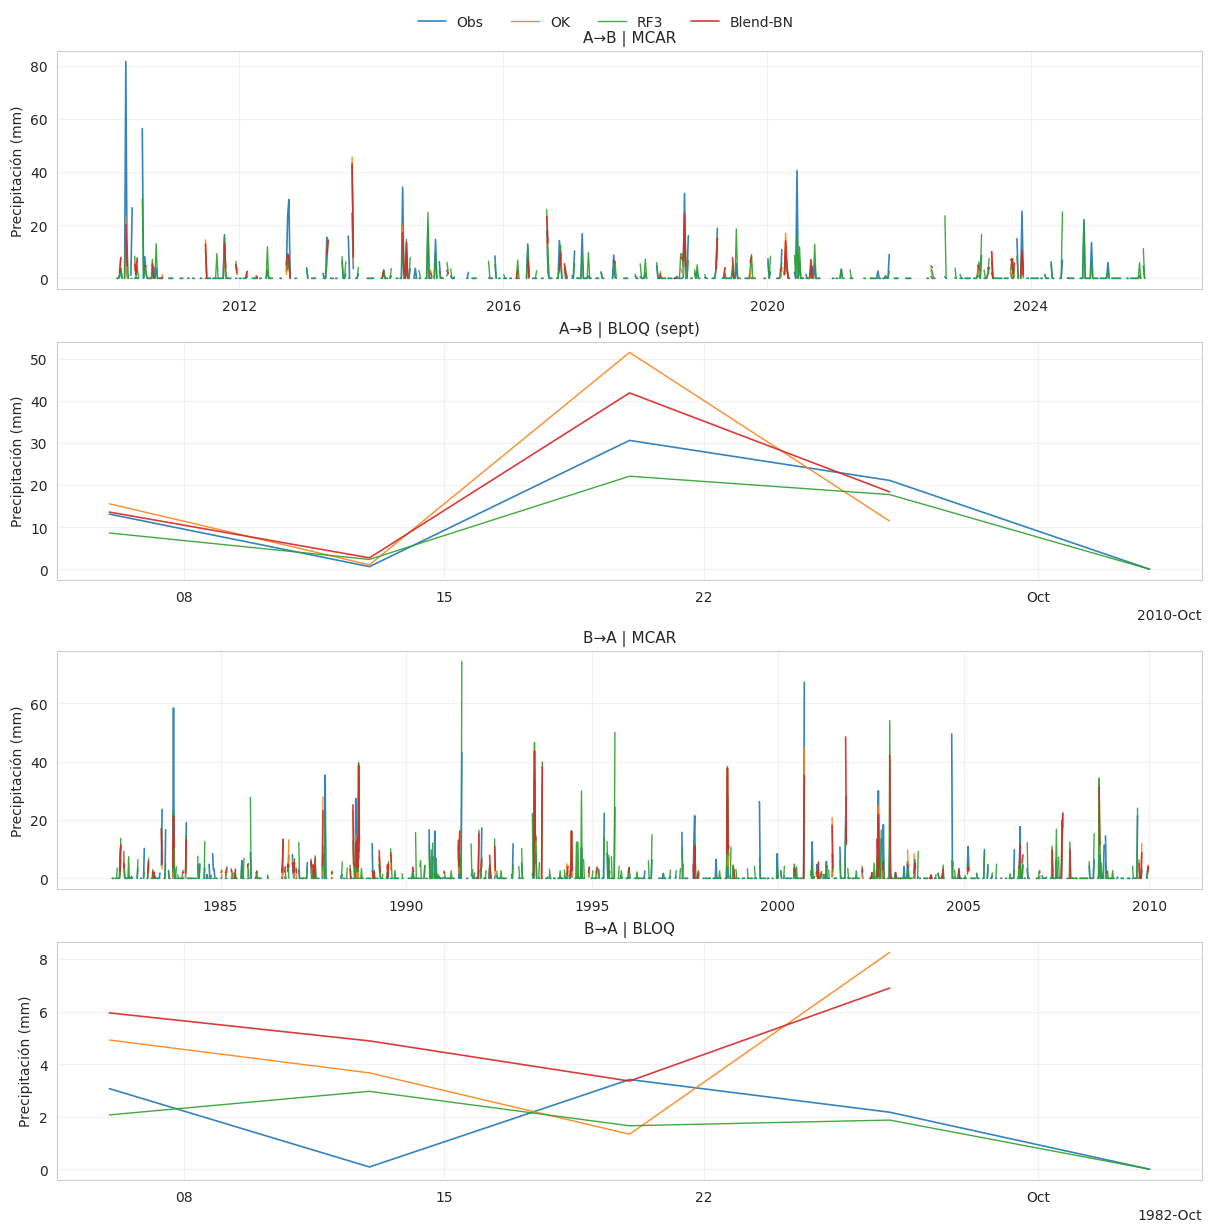

In [112]:
plot_four_scenarios(
    blend_AB_MCAR_BN,  # (metrics, alphas, serie)
    blend_AB_BLOCK_BN,
    blend_BA_MCAR_BN,
    blend_BA_BLOCK_BN,
    weekly=True,       # ponlo en False si quieres ver diario (más denso)
    tight=True,
    legend_out=True
)

#Clasificador RF + Regresor Gradient Boost
De acuerdo a la literatura Gradient boost tiene buenos resultados en escala diaria y con vacios por bloque reduciendo el MAE

In [113]:
# --- 1) RANDOMIZED SEARCH para GBR (regresor) ---
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from itertools import product

RNG = 42


def _rmse(y_true, y_pred):
    if len(y_true) == 0:
        return np.nan
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))


space_gbr = {
    "n_estimators":    [300, 500, 800],
    "learning_rate":   [0.03, 0.05, 0.08, 0.10],
    "max_depth":       [2, 3, 4],
    "min_samples_leaf":[1, 2, 4, 8],
    "min_samples_split":[2, 5, 10],
    "subsample":       [1.0, 0.8],
    "max_features":    ["sqrt", 0.5, None],
    "loss":            ["squared_error"],
}

def randomized_search_reg_gbr(A_train, B_test, feature_cols, n_iter=20):
    # Imputación (fit en TRAIN)
    med_m, med_g = fit_month_medians(A_train, feature_cols)
    Xtr_raw, ytr, ymask_tr = get_train_reg(A_train, feature_cols)
    Xtr = transform_with_month_medians(A_train.loc[ymask_tr], feature_cols, med_m, med_g)

    ymask_te = (B_test[y_cls]==1) & B_test[y_reg].notna()
    Xte = transform_with_month_medians(B_test.loc[ymask_te], feature_cols, med_m, med_g)
    yte = B_test.loc[ymask_te, y_reg]

    results=[]
    for params in ParameterSampler(space_gbr, n_iter=n_iter, random_state=RNG):
        reg = GradientBoostingRegressor(random_state=RNG, **params).fit(Xtr, ytr)
        if len(yte):
            pred = reg.predict(Xte)
            mae  = mean_absolute_error(yte, pred)
            rmse = _rmse(yte, pred)
        else:
            mae = np.nan; rmse = np.nan
        results.append({"params":params, "MAE":float(mae), "RMSE":float(rmse)})
    return sorted(results, key=lambda d: d["MAE"])

In [114]:
# Corre 20 muestras del espacio de búsqueda
rs_gbr = randomized_search_reg_gbr(A_train, B_test, feature_cols, n_iter=20)

print("GBR RS top-5:")
for r in rs_gbr[:5]:
    print(r)

# Toma el mejor set (menor MAE en B_test wet=1)
best_gbr_params = rs_gbr[0]["params"]
best_gbr_params


GBR RS top-5:
{'params': {'subsample': 0.8, 'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 0.5, 'max_depth': 2, 'loss': 'squared_error', 'learning_rate': 0.05}, 'MAE': 8.376008024190671, 'RMSE': 19.965544511345332}
{'params': {'subsample': 1.0, 'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.5, 'max_depth': 3, 'loss': 'squared_error', 'learning_rate': 0.03}, 'MAE': 8.44650528883309, 'RMSE': 20.39400016926576}
{'params': {'subsample': 1.0, 'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 0.5, 'max_depth': 2, 'loss': 'squared_error', 'learning_rate': 0.03}, 'MAE': 8.455973203469703, 'RMSE': 20.96015901170396}
{'params': {'subsample': 1.0, 'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': None, 'max_depth': 2, 'loss': 'squared_error', 'learning_rate': 0.05}, 'MAE': 8.534346084145334, 'RMSE': 21.070328863460492}
{'params': {'subsample': 1.0, 'n_e

{'subsample': 0.8,
 'n_estimators': 300,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 0.5,
 'max_depth': 2,
 'loss': 'squared_error',
 'learning_rate': 0.05}

In [115]:
# === GRID Search LOCAL alrededor del mejor ===
def grid_search_reg_gbr(A_train, B_test, feature_cols, best_params):
    # Imputación (fit en TRAIN)
    med_m, med_g = fit_month_medians(A_train, feature_cols)
    Xtr_raw, ytr, ymask_tr = get_train_reg(A_train, feature_cols)
    Xtr = transform_with_month_medians(A_train.loc[ymask_tr], feature_cols, med_m, med_g)

    ymask_te = (B_test[y_cls]==1) & B_test[y_reg].notna()
    Xte = transform_with_month_medians(B_test.loc[ymask_te], feature_cols, med_m, med_g)
    yte = B_test.loc[ymask_te, y_reg]

    ne   = best_params["n_estimators"]
    lr   = best_params["learning_rate"]
    md   = best_params["max_depth"]
    msl  = best_params["min_samples_leaf"]
    mss  = best_params["min_samples_split"]
    ss   = best_params.get("subsample", 1.0)
    mf   = best_params.get("max_features", None)
    loss = best_params.get("loss", "squared_error")

    grid = {
        "n_estimators":      sorted(set([max(100, ne-200), ne, ne+200])),
        "learning_rate":     sorted(set([max(0.01, lr/2), lr, min(0.2, lr*1.5)])),
        "max_depth":         [v for v in [md-1, md, md+1] if isinstance(v,int) and v>=1],
        "min_samples_leaf":  sorted(set([max(1, msl//2), msl, msl*2])),
        "min_samples_split": sorted(set([2, mss, min(20, max(10, mss*2))])),
        "subsample":         sorted(set([ss, 0.8, 1.0])),
        "max_features":      [mf] if mf in ["sqrt", 0.5, None] else ["sqrt", 0.5, None],
        "loss":              [loss],
    }

    results=[]
    for (ne_, lr_, md_, msl_, mss_, ss_, mf_) in product(
        grid["n_estimators"], grid["learning_rate"], grid["max_depth"],
        grid["min_samples_leaf"], grid["min_samples_split"], grid["subsample"], grid["max_features"]
    ):
        params = dict(n_estimators=ne_, learning_rate=lr_, max_depth=md_,
                      min_samples_leaf=msl_, min_samples_split=mss_,
                      subsample=ss_, max_features=mf_, loss=loss, random_state=RNG)
        reg = GradientBoostingRegressor(**params).fit(Xtr, ytr)
        if len(yte):
            pred = reg.predict(Xte)
            mae  = mean_absolute_error(yte, pred)
            rmse = _rmse(yte, pred)
        else:
            mae = np.nan; rmse = np.nan
        results.append({"params":params, "MAE":float(mae), "RMSE":float(rmse)})
    return sorted(results, key=lambda d: d["MAE"])

In [116]:
gs_gbr = grid_search_reg_gbr(A_train, B_test, feature_cols, best_gbr_params)
print("\nGBR GS top-3:")
for r in gs_gbr[:3]:
    print(r)

theta_gbr = gs_gbr[0]["params"]


GBR GS top-3:
{'params': {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2, 'subsample': 0.8, 'max_features': 0.5, 'loss': 'squared_error', 'random_state': 42}, 'MAE': 8.16967774171977, 'RMSE': 19.088610253239132}
{'params': {'n_estimators': 500, 'learning_rate': 0.025, 'max_depth': 1, 'min_samples_leaf': 2, 'min_samples_split': 2, 'subsample': 1.0, 'max_features': 0.5, 'loss': 'squared_error', 'random_state': 42}, 'MAE': 8.171448401066513, 'RMSE': 18.96607757130841}
{'params': {'n_estimators': 500, 'learning_rate': 0.025, 'max_depth': 1, 'min_samples_leaf': 2, 'min_samples_split': 10, 'subsample': 1.0, 'max_features': 0.5, 'loss': 'squared_error', 'random_state': 42}, 'MAE': 8.171448401066513, 'RMSE': 18.96607757130841}


In [117]:
def transform_with_month_medians_safe(df_split, feature_cols, med_by_month, med_global, df_train_for_fallback):
    """
    Igual que transform_with_month_medians, pero garantiza que NO queden NaN:
    - Primero: fillna con medianas por MES.
    - Segundo: fallback global (med_global).
    - Tercero: si aún hay NaN en alguna columna (porque med_global tenía NaN),
               usar mediana de TODO el TRAIN; si sigue habiendo NaN, usar 0.0.
    """
    X = df_split[feature_cols].copy()
    m = df_split['MES'].astype(int)

    # Paso 1: por mes
    for mes in med_by_month.index:
        idx = (m == mes)
        if idx.any():
            X.loc[idx, feature_cols] = X.loc[idx, feature_cols].fillna(med_by_month.loc[mes])

    # Paso 2: fallback global (del TRAIN)
    X = X.fillna(med_global)

    # Paso 3: fallback final por columna (mediana del TRAIN completo; si NaN -> 0.0)
    col_fallback = df_train_for_fallback[feature_cols].median(numeric_only=True)
    # si alguna sigue NaN (columna completamente vacía en TRAIN), usa 0.0
    col_fallback = col_fallback.fillna(0.0)
    X = X.fillna(col_fallback)

    # Por si quedara algún NaN residual (muy raro): relleno a 0.0
    X = X.fillna(0.0)
    return X


In [118]:
# --- 3) EVALUACIÓN 2-etapas con RF  + GBR  ---
from sklearn.ensemble import RandomForestClassifier

def fit_eval_with_params_imputed_GBR(
    TR, TE, feature_cols, params_clf, params_gbr, thr_grid=(0.3,0.4,0.5,0.6,0.7), restrict_idx=None
):
    # Imputación (fit en TRAIN)
    med_m, med_g = fit_month_medians(TR, feature_cols)

    # ===== Clasificador (RF de RF3) =====
    Xtr_raw, ytr, ymask_tr = get_train_clf(TR, feature_cols)
    Xtr = transform_with_month_medians_safe(TR.loc[ymask_tr], feature_cols, med_m, med_g, TR)
    from sklearn.ensemble import RandomForestClassifier
    clf = RandomForestClassifier(random_state=RNG, n_jobs=-1, **params_clf).fit(Xtr, ytr)

    # TEST para clasificación
    ymask_te_cls = TE[y_cls].notna()
    Xte_cls = transform_with_month_medians_safe(TE.loc[ymask_te_cls], feature_cols, med_m, med_g, TR)
    yte_cls = TE.loc[ymask_te_cls, y_cls].astype(int)
    proba = clf.predict_proba(Xte_cls)[:, 1]

    thr, _ = _tune_threshold_f1(yte_cls, proba, thr_grid)
    wet_hat_all = np.full(len(TE), np.nan)
    wet_hat_all[ymask_te_cls.values] = (proba >= thr).astype(int)

    # ===== Regressor: GBR (escala original) =====
    Xtr_r_raw, ytr_r, ymask_tr_r = get_train_reg(TR, feature_cols)
    Xtr_r = transform_with_month_medians_safe(TR.loc[ymask_tr_r], feature_cols, med_m, med_g, TR)

    from sklearn.ensemble import GradientBoostingRegressor
    reg = GradientBoostingRegressor(random_state=RNG, **params_gbr).fit(Xtr_r, ytr_r)

    Xte_all = transform_with_month_medians_safe(TE, feature_cols, med_m, med_g, TR)
    amt_pred_all = reg.predict(Xte_all)
    amt_pred_all = np.clip(amt_pred_all, 0.0, None)

    # Ensamble final
    precip_pred = np.where(
        np.isnan(wet_hat_all), np.nan,
        np.where(wet_hat_all == 1, amt_pred_all, 0.0)
    )

    # ===== Métricas con máscara =====
    idx_mask = np.ones(len(TE), dtype=bool) if restrict_idx is None else TE.index.isin(restrict_idx)

    from sklearn.metrics import f1_score, mean_absolute_error, mean_squared_error


    m_cls = TE[y_cls].notna() & idx_mask
    F1 = f1_score(TE.loc[m_cls, y_cls].astype(int), wet_hat_all[m_cls].astype(int)) if m_cls.any() else np.nan

    m_reg = (TE[y_cls]==1) & TE[y_reg].notna() & idx_mask
    y_true = TE.loc[m_reg, y_reg].values
    y_pred = precip_pred[m_reg.values]

    def _rmse(a,b):
        return float(np.sqrt(mean_squared_error(a, b))) if len(a) else np.nan

    MAE  = mean_absolute_error(y_true, y_pred) if len(y_true) else np.nan
    RMSE = _rmse(y_true, y_pred)
    PBias = 100 * (y_pred.sum() - y_true.sum()) / (y_true.sum() if len(y_true) else 1e-9)
    CC = np.corrcoef(y_true, y_pred)[0,1] if len(y_true) > 1 else np.nan

    return dict(F1=F1, MAE=MAE, RMSE=RMSE, PBias=PBias, CC=CC, thr=thr)



In [119]:
theta_rf3_clf = {'n_estimators':300,'max_depth':4,'min_samples_leaf':16,'min_samples_split':2,'max_features':0.5,'class_weight':'balanced'}

metrics_AB_MCAR_gbr  = fit_eval_with_params_imputed_GBR(A_train, B_test, feature_cols, theta_rf3_clf, best_gbr_params, restrict_idx=mcar_A)
metrics_AB_BLOCK_gbr = fit_eval_with_params_imputed_GBR(A_train, B_test, feature_cols, theta_rf3_clf, best_gbr_params, restrict_idx=block_A)
metrics_BA_MCAR_gbr  = fit_eval_with_params_imputed_GBR(B_train, A_test, feature_cols, theta_rf3_clf, best_gbr_params, restrict_idx=mcar_B)
metrics_BA_BLOCK_gbr = fit_eval_with_params_imputed_GBR(B_train, A_test, feature_cols, theta_rf3_clf, best_gbr_params, restrict_idx=block_B)

print("GBR — A→B | MCAR :",  metrics_AB_MCAR_gbr)
print("GBR — A→B | BLOQ :",  metrics_AB_BLOCK_gbr)
print("GBR — B→A | MCAR :",  metrics_BA_MCAR_gbr)
print("GBR — B→A | BLOQ :",  metrics_BA_BLOCK_gbr)


GBR — A→B | MCAR : {'F1': 0.7579617834394905, 'MAE': 7.381628123704121, 'RMSE': 13.932372998307269, 'PBias': np.float64(-13.717257610803056), 'CC': np.float64(0.46231471442875643), 'thr': 0.6}
GBR — A→B | BLOQ : {'F1': 0.8, 'MAE': 25.44583413043065, 'RMSE': 33.73200473567738, 'PBias': np.float64(-28.929290322823608), 'CC': np.float64(0.25363646886565233), 'thr': 0.6}
GBR — B→A | MCAR : {'F1': 0.6158730158730159, 'MAE': 7.984990768142237, 'RMSE': 14.410093027919437, 'PBias': np.float64(-7.696732878332291), 'CC': np.float64(0.4388891449258102), 'thr': 0.5}
GBR — B→A | BLOQ : {'F1': 0.5714285714285714, 'MAE': 8.27743248209878, 'RMSE': 10.386394029760373, 'PBias': np.float64(-49.7626923495488), 'CC': np.float64(0.4124999274165597), 'thr': 0.5}


#Gradient Boosting
Gradient Boosting (GB/XGB/LGBM/CatBoost): optimiza pérdidas diferenciables (MAE/Huber/Quantile), controla sesgo–varianza con learning_rate y captura interacciones no lineales mejor que RF.

Randomized Search + Grid Local para el clasificador

In [121]:
# === RANDOMIZED SEARCH (GBC) ===
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import f1_score
from itertools import product

RNG = 42

# espacio de búsqueda (discreto; RS toma muestras al azar)
space_gbc = {
    "n_estimators":    [200, 300, 500],
    "learning_rate":   [0.03, 0.05, 0.08, 0.10],
    "max_depth":       [2, 3, 4],
    "min_samples_leaf":[1, 2, 4, 8],
    "min_samples_split":[2, 5, 10],
    "subsample":       [1.0, 0.8],
    "max_features":    ["sqrt", 0.5, None],
}

def randomized_search_clf_gbc(A_train, B_test, feature_cols, n_iter=20,
                              thr_grid=(0.3,0.4,0.5,0.6,0.7)):
    # imputación (fit en TRAIN)
    med_m, med_g = fit_month_medians(A_train, feature_cols)

    # TRAIN (solo filas con y_cls observado)
    Xtr_raw, ytr, ymask_tr = get_train_clf(A_train, feature_cols)
    Xtr = transform_with_month_medians_safe(A_train.loc[ymask_tr], feature_cols, med_m, med_g, A_train)

    # TEST (para elegir umbral por F1)
    ymask_te = B_test[y_cls].notna()
    Xte = transform_with_month_medians_safe(B_test.loc[ymask_te], feature_cols, med_m, med_g, A_train)
    yte = B_test.loc[ymask_te, y_cls].astype(int)

    results=[]
    for params in ParameterSampler(space_gbc, n_iter=n_iter, random_state=RNG):
        clf = GradientBoostingClassifier(random_state=RNG, **params).fit(Xtr, ytr)
        proba = clf.predict_proba(Xte)[:,1]
        # rejilla simple de umbrales para maximizar F1 en TEST
        best_thr, best_f1 = _tune_threshold_f1(yte, proba, thr_grid)
        results.append({"params": params, "thr": best_thr, "F1": float(best_f1)})
    return sorted(results, key=lambda d: d["F1"], reverse=True)




In [122]:
# lanza RS (A→B como hiciste en RF3)
gbc_rs = randomized_search_clf_gbc(A_train, B_test, feature_cols, n_iter=25)
print("GBC RS top-3:"); [print(r) for r in gbc_rs[:3]]
best_gbc_params_rs = gbc_rs[0]["params"]  # esto alimenta el grid local



GBC RS top-3:
{'params': {'subsample': 1.0, 'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 2, 'learning_rate': 0.08}, 'thr': 0.3, 'F1': 0.7585253456221198}
{'params': {'subsample': 1.0, 'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': None, 'max_depth': 2, 'learning_rate': 0.05}, 'thr': 0.3, 'F1': 0.7571825764596849}
{'params': {'subsample': 0.8, 'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 0.5, 'max_depth': 2, 'learning_rate': 0.05}, 'thr': 0.3, 'F1': 0.7558247903075489}


In [125]:
# === GRID LOCAL (GBC) alrededor del mejor RS ===
def grid_search_clf_gbc(A_train, B_test, feature_cols, best_params,
                        thr_grid=(0.3,0.4,0.5,0.6,0.7)):
    med_m, med_g = fit_month_medians(A_train, feature_cols)
    Xtr_raw, ytr, ymask_tr = get_train_clf(A_train, feature_cols)
    Xtr = transform_with_month_medians_safe(A_train.loc[ymask_tr], feature_cols, med_m, med_g, A_train)

    ymask_te = B_test[y_cls].notna()
    Xte = transform_with_month_medians_safe(B_test.loc[ymask_te], feature_cols, med_m, med_g, A_train)
    yte = B_test.loc[ymask_te, y_cls].astype(int)

    ne = best_params["n_estimators"];   lr = best_params["learning_rate"]; md = best_params["max_depth"]
    msl = best_params["min_samples_leaf"]; mss = best_params["min_samples_split"]
    ss = best_params.get("subsample", 1.0); mf = best_params.get("max_features", None)

    grid = {
        "n_estimators":      sorted(set([max(100, ne-100), ne, ne+100])),
        "learning_rate":     sorted(set([max(0.01, lr/1.5), lr, min(0.2, lr*1.5)])),
        "max_depth":         [v for v in [md-1, md, md+1] if isinstance(v,int) and v>=1],
        "min_samples_leaf":  sorted(set([max(1, msl//2), msl, msl*2])),
        "min_samples_split": sorted(set([2, mss, min(20, max(10, mss*2))])),
        "subsample":         sorted(set([ss, 0.8, 1.0])),
        "max_features":      [mf] if mf in ["sqrt",0.5,None] else ["sqrt",0.5,None],
    }

    results=[]
    for (ne_, lr_, md_, msl_, mss_, ss_, mf_) in product(
        grid["n_estimators"], grid["learning_rate"], grid["max_depth"],
        grid["min_samples_leaf"], grid["min_samples_split"], grid["subsample"], grid["max_features"]
    ):
        params = dict(n_estimators=ne_, learning_rate=lr_, max_depth=md_,
                      min_samples_leaf=msl_, min_samples_split=mss_,
                      subsample=ss_, max_features=mf_, random_state=RNG)
        clf = GradientBoostingClassifier(**params).fit(Xtr, ytr)
        proba = clf.predict_proba(Xte)[:,1]
        thr, f1 = _tune_threshold_f1(yte, proba, thr_grid)
        results.append({"params": params, "thr": float(thr), "F1": float(f1)})
    return sorted(results, key=lambda d: d["F1"], reverse=True)



In [126]:
gbc_gs = grid_search_clf_gbc(A_train, B_test, feature_cols, best_gbc_params_rs)
print("GBC GS top-3:"); [print(r) for r in gbc_gs[:3]]

# θ* del clasificador GBC (guardamos params + umbral óptimo de A→B)
theta_gbc = {"params": gbc_gs[0]["params"], "thr_dev": gbc_gs[0]["thr"], "F1_dev": gbc_gs[0]["F1"]}
theta_gbc

GBC GS top-3:
{'params': {'n_estimators': 100, 'learning_rate': 0.05333333333333334, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'subsample': 1.0, 'max_features': None, 'random_state': 42}, 'thr': 0.3, 'F1': 0.7598896044158233}
{'params': {'n_estimators': 100, 'learning_rate': 0.05333333333333334, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10, 'subsample': 1.0, 'max_features': None, 'random_state': 42}, 'thr': 0.3, 'F1': 0.7593189139438564}
{'params': {'n_estimators': 100, 'learning_rate': 0.05333333333333334, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'subsample': 1.0, 'max_features': None, 'random_state': 42}, 'thr': 0.3, 'F1': 0.7591911764705882}


{'params': {'n_estimators': 100,
  'learning_rate': 0.05333333333333334,
  'max_depth': 3,
  'min_samples_leaf': 2,
  'min_samples_split': 2,
  'subsample': 1.0,
  'max_features': None,
  'random_state': 42},
 'thr_dev': 0.3,
 'F1_dev': 0.7598896044158233}

Entrenador/Evaluador 2-etapas: GBC (ocurrencia) + tu GBR (monto)

In [129]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

RNG = 42

def fit_eval_with_params_imputed_GBC_GBR(
    TR, TE, feature_cols, params_gbc, params_gbr,
    thr_grid=(0.3,0.4,0.5,0.6,0.7), restrict_idx=None
):
    # ===== Imputación (fit SOLO en TRAIN) =====
    med_m, med_g = fit_month_medians(TR, feature_cols)

    # ===== CLASIFICADOR (GBC) =====
    Xtr_raw, ytr, ymask_tr = get_train_clf(TR, feature_cols)
    Xtr = transform_with_month_medians_safe(TR.loc[ymask_tr], feature_cols, med_m, med_g, TR)

    gbc_kwargs = dict(params_gbc)              # copia segura
    gbc_kwargs.pop("random_state", None)       # quitar duplicado si viene en params
    clf = GradientBoostingClassifier(random_state=RNG, **gbc_kwargs).fit(Xtr, ytr)

    # Probabilidades en TEST + umbral óptimo por F1
    ymask_te_cls = TE[y_cls].notna()
    Xte_cls = transform_with_month_medians_safe(TE.loc[ymask_te_cls], feature_cols, med_m, med_g, TR)
    yte_cls = TE.loc[ymask_te_cls, y_cls].astype(int)
    proba = clf.predict_proba(Xte_cls)[:, 1]
    thr, _ = _tune_threshold_f1(yte_cls, proba, thr_grid)

    wet_hat_all = np.full(len(TE), np.nan)
    wet_hat_all[ymask_te_cls.values] = (proba >= thr).astype(int)

    # ===== REGRESOR (GBR) — ya optimizado por ti =====
    Xtr_r_raw, ytr_r, ymask_tr_r = get_train_reg(TR, feature_cols)
    Xtr_r = transform_with_month_medians_safe(TR.loc[ymask_tr_r], feature_cols, med_m, med_g, TR)

    gbr_kwargs = dict(params_gbr)
    gbr_kwargs.pop("random_state", None)
    reg = GradientBoostingRegressor(random_state=RNG, **gbr_kwargs).fit(Xtr_r, ytr_r)

    Xte_all = transform_with_month_medians_safe(TE, feature_cols, med_m, med_g, TR)
    amt_pred_all = np.clip(reg.predict(Xte_all), 0.0, None)

    # Ensamble final
    precip_pred = np.where(np.isnan(wet_hat_all), np.nan,
                           np.where(wet_hat_all == 1, amt_pred_all, 0.0))

    # ===== Métricas (con máscara de escenario) =====
    idx_mask = np.ones(len(TE), dtype=bool) if restrict_idx is None else TE.index.isin(restrict_idx)

    # Clasificación
    m_cls = TE[y_cls].notna() & idx_mask
    F1 = f1_score(TE.loc[m_cls, y_cls].astype(int), wet_hat_all[m_cls].astype(int)) if m_cls.any() else np.nan

    # Regresión
    m_reg = (TE[y_cls]==1) & TE[y_reg].notna() & idx_mask
    y_true = TE.loc[m_reg, y_reg].values
    y_pred = precip_pred[m_reg.values]
    MAE  = mean_absolute_error(y_true, y_pred) if len(y_true) else np.nan
    RMSE = float(np.sqrt(mean_squared_error(y_true, y_pred))) if len(y_true) else np.nan
    PBias = 100.0 * (y_pred.sum() - y_true.sum()) / (y_true.sum() if len(y_true) else 1e-9)
    CC = float(np.corrcoef(y_true, y_pred)[0,1]) if len(y_true) > 1 else np.nan

    return dict(F1=F1, MAE=MAE, RMSE=RMSE, PBias=PBias, CC=CC, thr=float(thr))


Aplicar el modelo GBC+GBR a los 4 escenarios

In [130]:
# usa  GBR del anterior
# theta_gbr = gs_gbr[0]["params"]

# ejecuta 4 escenarios
metrics_AB_MCAR_gbcgbr  = fit_eval_with_params_imputed_GBC_GBR(
    A_train, B_test, feature_cols, theta_gbc["params"], theta_gbr, restrict_idx=mcar_A
)
metrics_AB_BLOCK_gbcgbr = fit_eval_with_params_imputed_GBC_GBR(
    A_train, B_test, feature_cols, theta_gbc["params"], theta_gbr, restrict_idx=block_A
)
metrics_BA_MCAR_gbcgbr  = fit_eval_with_params_imputed_GBC_GBR(
    B_train, A_test, feature_cols, theta_gbc["params"], theta_gbr, restrict_idx=mcar_B
)
metrics_BA_BLOCK_gbcgbr = fit_eval_with_params_imputed_GBC_GBR(
    B_train, A_test, feature_cols, theta_gbc["params"], theta_gbr, restrict_idx=block_B
)

print("GBC+GBR — A→B | MCAR :", metrics_AB_MCAR_gbcgbr)
print("GBC+GBR — A→B | BLOQ :", metrics_AB_BLOCK_gbcgbr)
print("GBC+GBR — B→A | MCAR :", metrics_BA_MCAR_gbcgbr)
print("GBC+GBR — B→A | BLOQ :", metrics_BA_BLOCK_gbcgbr)


GBC+GBR — A→B | MCAR : {'F1': 0.7261146496815286, 'MAE': 7.300773760808693, 'RMSE': 13.806588142539612, 'PBias': np.float64(-16.968496859725143), 'CC': 0.47018452625732277, 'thr': 0.3}
GBC+GBR — A→B | BLOQ : {'F1': 0.8, 'MAE': 26.770213322025537, 'RMSE': 35.099852453899736, 'PBias': np.float64(-22.211386604716495), 'CC': 0.21741230851488078, 'thr': 0.3}
GBC+GBR — B→A | MCAR : {'F1': 0.6514285714285715, 'MAE': 7.980944114276532, 'RMSE': 14.20710492181575, 'PBias': np.float64(-14.26245991790157), 'CC': 0.42702367525871454, 'thr': 0.5}
GBC+GBR — B→A | BLOQ : {'F1': 0.2857142857142857, 'MAE': 9.862343364634796, 'RMSE': 13.65606175015749, 'PBias': np.float64(-84.8738671655318), 'CC': 0.189262176250478, 'thr': 0.5}


#Comparacion de todos los modelos

In [157]:
import numpy as np
import pandas as pd
from collections.abc import Mapping

# ---------- helpers ----------
def _exists(name: str) -> bool:
    return name in globals()

def _get(name: str):
    return globals()[name]

def _safe_metrics(x):
    """
    Devuelve un dict de métricas con floats cuando se pueda.
    Acepta:
      - dict ya listo
      - tuplas tipo (metrics, alphas, serie) -> toma metrics
    """
    if x is None:
        return None
    if isinstance(x, tuple) and len(x) > 0 and isinstance(x[0], Mapping):
        x = x[0]
    if isinstance(x, Mapping):
        out = {}
        for k, v in x.items():
            try:
                out[k] = float(v)
            except Exception:
                out[k] = v
        return out
    return x

# ---------- escenarios ----------
ESCENARIOS = ["A→B | MCAR", "A→B | BLOQ", "B→A | MCAR", "B→A | BLOQ"]

# ---------- recolectar métricas por modelo ----------
MODELOS = {}

# RF3
MODELOS["RF3"] = {
    "A→B | MCAR": _safe_metrics(_get("metrics_AB_MCAR")) if _exists("metrics_AB_MCAR") else None,
    "A→B | BLOQ": _safe_metrics(_get("metrics_AB_BLOCK")) if _exists("metrics_AB_BLOCK") else None,
    "B→A | MCAR": _safe_metrics(_get("metrics_BA_MCAR")) if _exists("metrics_BA_MCAR") else None,
    "B→A | BLOQ": _safe_metrics(_get("metrics_BA_BLOCK")) if _exists("metrics_BA_BLOCK") else None,
}

# RF3-LOG
MODELOS["RF3LOG"] = {
    "A→B | MCAR": _safe_metrics(_get("metrics_AB_MCAR_rf3LOG")) if _exists("metrics_AB_MCAR_rf3LOG") else None,
    "A→B | BLOQ": _safe_metrics(_get("metrics_AB_BLOCK_rf3LOG")) if _exists("metrics_AB_BLOCK_rf3LOG") else None,
    "B→A | MCAR": _safe_metrics(_get("metrics_BA_MCAR_rf3LOG")) if _exists("metrics_BA_MCAR_rf3LOG") else None,
    "B→A | BLOQ": _safe_metrics(_get("metrics_BA_BLOCK_rf3LOG")) if _exists("metrics_BA_BLOCK_rf3LOG") else None,
}

# RF3-LOG + thrMES + smear (TS)
MODELOS["RF3LOG_TS"] = {
    "A→B | MCAR": _safe_metrics(_get("metrics_AB_MCAR_rf3LOG_TS")) if _exists("metrics_AB_MCAR_rf3LOG_TS") else None,
    "A→B | BLOQ": _safe_metrics(_get("metrics_AB_BLOCK_rf3LOG_TS")) if _exists("metrics_AB_BLOCK_rf3LOG_TS") else None,
    "B→A | MCAR": _safe_metrics(_get("metrics_BA_MCAR_rf3LOG_TS")) if _exists("metrics_BA_MCAR_rf3LOG_TS") else None,
    "B→A | BLOQ": _safe_metrics(_get("metrics_BA_BLOCK_rf3LOG_TS")) if _exists("metrics_BA_BLOCK_rf3LOG_TS") else None,
}

# RF3-LOG + THR_SEASON
MODELOS["RF3LOG_THRSEAS"] = {
    "A→B | MCAR": _safe_metrics(_get("metrics_AB_MCAR_rf3LOG_THRSEAS")) if _exists("metrics_AB_MCAR_rf3LOG_THRSEAS") else None,
    "A→B | BLOQ": _safe_metrics(_get("metrics_AB_BLOCK_rf3LOG_THRSEAS")) if _exists("metrics_AB_BLOCK_rf3LOG_THRSEAS") else None,
    "B→A | MCAR": _safe_metrics(_get("metrics_BA_MCAR_rf3LOG_THRSEAS")) if _exists("metrics_BA_MCAR_rf3LOG_THRSEAS") else None,
    "B→A | BLOQ": _safe_metrics(_get("metrics_BA_BLOCK_rf3LOG_THRSEAS")) if _exists("metrics_BA_BLOCK_rf3LOG_THRSEAS") else None,
}

# OK (kriging)
MODELOS["OK"] = {
    "A→B | MCAR": _safe_metrics(_get("ok_AB_MCAR")) if _exists("ok_AB_MCAR") else None,
    "A→B | BLOQ": _safe_metrics(_get("ok_AB_BLOCK")) if _exists("ok_AB_BLOCK") else None,
    "B→A | MCAR": _safe_metrics(_get("ok_BA_MCAR")) if _exists("ok_BA_MCAR") else None,
    "B→A | BLOQ": _safe_metrics(_get("ok_BA_BLOCK")) if _exists("ok_BA_BLOCK") else None,
}

# RFC + GBR
MODELOS["RFC + GBR"] = {
    "A→B | MCAR": _safe_metrics(_get("metrics_AB_MCAR_gbr")) if _exists("metrics_AB_MCAR_gbr") else None,
    "A→B | BLOQ": _safe_metrics(_get("metrics_AB_BLOCK_gbr")) if _exists("metrics_AB_BLOCK_gbr") else None,
    "B→A | MCAR": _safe_metrics(_get("metrics_BA_MCAR_gbr")) if _exists("metrics_BA_MCAR_gbr") else None,
    "B→A | BLOQ": _safe_metrics(_get("metrics_BA_BLOCK_gbr")) if _exists("metrics_BA_BLOCK_gbr") else None,
}

# GB
MODELOS["GB"] = {
    "A→B | MCAR": _safe_metrics(_get("metrics_AB_MCAR_gbcgbr")) if _exists("metrics_AB_MCAR_gbcgbr") else None,
    "A→B | BLOQ": _safe_metrics(_get("metrics_AB_BLOCK_gbcgbr")) if _exists("metrics_AB_BLOCK_gbcgbr") else None,
    "B→A | MCAR": _safe_metrics(_get("metrics_BA_MCAR_gbcgbr")) if _exists("metrics_BA_MCAR_gbcgbr") else None,
    "B→A | BLOQ": _safe_metrics(_get("metrics_BA_BLOCK_gbcgbr")) if _exists("metrics_BA_BLOCK_gbcgbr") else None,
}

# BLEND estacional (si existen variables tipo (metrics, alphas, serie))
if _exists("blend_AB_MCAR") and isinstance(_get("blend_AB_MCAR"), tuple):
    MODELOS["BLEND"] = {
        "A→B | MCAR": _safe_metrics(_get("blend_AB_MCAR")[0]),
        "A→B | BLOQ": _safe_metrics(_get("blend_AB_BLOCK")[0]) if _exists("blend_AB_BLOCK") else None,
        "B→A | MCAR": _safe_metrics(_get("blend_BA_MCAR")[0]) if _exists("blend_BA_MCAR") else None,
        "B→A | BLOQ": _safe_metrics(_get("blend_BA_BLOCK")[0]) if _exists("blend_BA_BLOCK") else None,
    }

# BLEND bias-neutral (si existen variables tipo (metrics, alphas, serie))
if _exists("blend_AB_MCAR_BN") and isinstance(_get("blend_AB_MCAR_BN"), tuple):
    MODELOS["BLEND_BN"] = {
        "A→B | MCAR": _safe_metrics(_get("blend_AB_MCAR_BN")[0]),
        "A→B | BLOQ": _safe_metrics(_get("blend_AB_BLOCK_BN")[0]) if _exists("blend_AB_BLOCK_BN") else None,
        "B→A | MCAR": _safe_metrics(_get("blend_BA_MCAR_BN")[0]) if _exists("blend_BA_MCAR_BN") else None,
        "B→A | BLOQ": _safe_metrics(_get("blend_BA_BLOCK_BN")[0]) if _exists("blend_BA_BLOCK_BN") else None,
    }

# ---------- construir df_all ----------
MODEL_ORDER = ["RF3", "RF3LOG", "RF3LOG_TS", "RF3LOG_THRSEAS", "RFC + GBR", "GB", "BLEND", "BLEND_BN", "OK"]
METRICS = ["F1", "MAE", "RMSE", "PBias", "CC", "n"]

rows = []
for esc in ESCENARIOS:
    row = {"Escenario": esc}
    for model in MODEL_ORDER:
        mdict = MODELOS.get(model, {}).get(esc)
        if isinstance(mdict, Mapping):
            for met in METRICS:
                if met in mdict:
                    col = f"{met}_{model}" if model != "OK" else f"OK_{met}"
                    try:
                        row[col] = float(mdict[met])
                    except Exception:
                        row[col] = mdict[met]
    rows.append(row)

df_all = pd.DataFrame(rows).round(3)

# ---------- ordenar columnas por grupos de métrica ----------
ordered_cols = ["Escenario"]
for met in ["F1", "MAE", "RMSE", "PBias", "CC"]:
    for m in MODEL_ORDER:
        col = f"{met}_{m}" if m != "OK" else f"OK_{met}"
        if col in df_all.columns:
            ordered_cols.append(col)

# contadores al final
for m in MODEL_ORDER:
    col = "OK_n" if m == "OK" else f"n_{m}"
    if col in df_all.columns:
        ordered_cols.append(col)

df_all = df_all[[c for c in ordered_cols if c in df_all.columns]]

# ---------- mostrar ----------
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 10_000)
print(df_all.to_string(index=False))


 Escenario  F1_RF3  F1_RF3LOG  F1_RF3LOG_TS  F1_RF3LOG_THRSEAS  F1_RFC + GBR  F1_GB  MAE_RF3  MAE_RF3LOG  MAE_RF3LOG_TS  MAE_RF3LOG_THRSEAS  MAE_RFC + GBR  MAE_GB  MAE_BLEND  MAE_BLEND_BN  OK_MAE  RMSE_RF3  RMSE_RF3LOG  RMSE_RF3LOG_TS  RMSE_RF3LOG_THRSEAS  RMSE_RFC + GBR  RMSE_GB  RMSE_BLEND  RMSE_BLEND_BN  OK_RMSE  PBias_RF3  PBias_RF3LOG  PBias_RF3LOG_TS  PBias_RF3LOG_THRSEAS  PBias_RFC + GBR  PBias_GB  PBias_BLEND  PBias_BLEND_BN  OK_PBias  CC_RF3  CC_RF3LOG  CC_RF3LOG_TS  CC_RF3LOG_THRSEAS  CC_RFC + GBR  CC_GB  CC_BLEND  CC_BLEND_BN  OK_CC  n_BLEND  n_BLEND_BN  OK_n
A→B | MCAR   0.758      0.758         0.752              0.758         0.758  0.726    6.992       6.338          7.042               6.996          7.382   7.301      6.442         6.649   6.522    12.943       13.657          13.034               13.019          13.932   13.807      13.119         13.094   13.278    -14.818       -48.771          -14.664               -14.150          -13.717   -16.968      -26.954   

In [158]:
# ========================
# TABLA DE PUNTAJES COMPUESTOS POR MODELO
# ========================

import pandas as pd
import numpy as np

# modelos a evaluar (los mismos que en columnas)
MODELOS = ["RF3", "RF3LOG", "RF3LOG_TS", "RF3LOG_THRSEAS",
           "RFC + GBR", "GB", "BLEND", "BLEND_BN", "OK"]

metricas = [m for m, _ in RADAR_CONF]   # ["F1","MAE"...]
rows_out = []

for _, row in df_all.iterrows():
    esc = row["Escenario"]

    # modelos que existen
    usados = [m for m in MODELOS if _has_any_metric(row,m)]
    puntajes = []

    # matriz raw
    raw = np.array([
        [_get_metric(row, met, m) for met in metricas]
        for m in usados
    ], dtype=object)

    # normalización métrica por métrica
    norm = np.zeros_like(raw, dtype=float)
    for j,(met,hb) in enumerate(RADAR_CONF):
        v = [raw[i,j] for i in range(len(usados))]
        norm[:,j] = np.nan_to_num(_minmax_normalize(v, higher_better=hb), nan=0.5)

    # puntaje compuesto
    weights = np.array([WEIGHTS[m] for m in metricas])
    weights /= weights.sum()
    scores = (norm * weights).sum(axis=1)

    # agregar fila
    for modelo, score in zip(usados, scores):
        rows_out.append({
            "Escenario": esc,
            "Modelo": modelo,
            "Score(0-1)": score
        })

# dataframe final
df_scores = pd.DataFrame(rows_out).sort_values(["Escenario","Score(0-1)"], ascending=[True,False])
print(df_scores.to_string(index=False))


 Escenario         Modelo  Score(0-1)
A→B | BLOQ       BLEND_BN    0.877974
A→B | BLOQ RF3LOG_THRSEAS    0.874208
A→B | BLOQ            RF3    0.804755
A→B | BLOQ          BLEND    0.740960
A→B | BLOQ      RF3LOG_TS    0.678047
A→B | BLOQ             OK    0.603105
A→B | BLOQ         RF3LOG    0.510016
A→B | BLOQ      RFC + GBR    0.438663
A→B | BLOQ             GB    0.398191
A→B | MCAR            RF3    0.776842
A→B | MCAR RF3LOG_THRSEAS    0.773864
A→B | MCAR          BLEND    0.768962
A→B | MCAR       BLEND_BN    0.761920
A→B | MCAR      RF3LOG_TS    0.719716
A→B | MCAR             OK    0.685444
A→B | MCAR         RF3LOG    0.601406
A→B | MCAR      RFC + GBR    0.400000
A→B | MCAR             GB    0.237200
B→A | BLOQ      RFC + GBR    0.937062
B→A | BLOQ            RF3    0.887339
B→A | BLOQ       BLEND_BN    0.754766
B→A | BLOQ          BLEND    0.746256
B→A | BLOQ             OK    0.599732
B→A | BLOQ      RF3LOG_TS    0.585281
B→A | BLOQ RF3LOG_THRSEAS    0.585281
B→A | BLOQ  

In [159]:
def plot_radars_grid_top3(df_all, save_png=False):
    escenarios = df_all["Escenario"].dropna().unique().tolist()
    escenarios = escenarios[:4]  # grid 2x2

    # Usa constrained_layout para que respete suptitle y leyendas
    fig, axes = plt.subplots(
        2, 2, subplot_kw={"polar": True}, figsize=(12, 10), constrained_layout=True
    )
    axes = axes.flatten()

    metric_names = [m for m, _ in RADAR_CONF]
    N = len(metric_names)
    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
    angles += angles[:1]

    for ax, esc in zip(axes, escenarios):
        row = df_all.loc[df_all["Escenario"] == esc]
        if row.empty:
            ax.set_axis_off()
            continue
        row = row.iloc[0]

        sel_models, sel_norm, metric_names = _top3_models_for_row(row)
        if not sel_models:
            ax.set_axis_off()
            continue

        # dibujar solo top-3
        for i, name in enumerate(sel_models):
            d = sel_norm[i, :].tolist()
            d += d[:1]
            ax.plot(angles, d, linewidth=2, label=name)
            ax.fill(angles, d, alpha=0.10)

        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(metric_names)
        ax.set_yticklabels([])
        ax.set_ylim(0, 1)
        ax.set_title(f"Radar — {esc}", pad=18)  # <-- más espacio bajo el suptitle

        # leyenda compacta; constrained_layout la acomoda sin empujar al suptitle
        ax.legend(loc="upper right", bbox_to_anchor=(1.15, 1.15), fontsize=9, frameon=False)

    # apaga ejes vacíos si hay <4 escenarios
    for k in range(len(escenarios), 4):
        axes[k].set_axis_off()

    # suptitle; con constrained_layout no hace falta tight_layout/rect
    # ===== título superior + margen para que NO se solape =====
    fig.suptitle("Comparativa (Top-3 por escenario)", fontsize=14, y=1.04)

    # Empuja el grid hacia abajo dejando ~12% libre arriba para el suptitle
    plt.subplots_adjust(top=0.88)

    # (no uses tight_layout aquí; es el que estaba aplastando el suptitle)
    plt.show()



/tmp/ipython-input-3859397755.py:53: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(top=0.88)


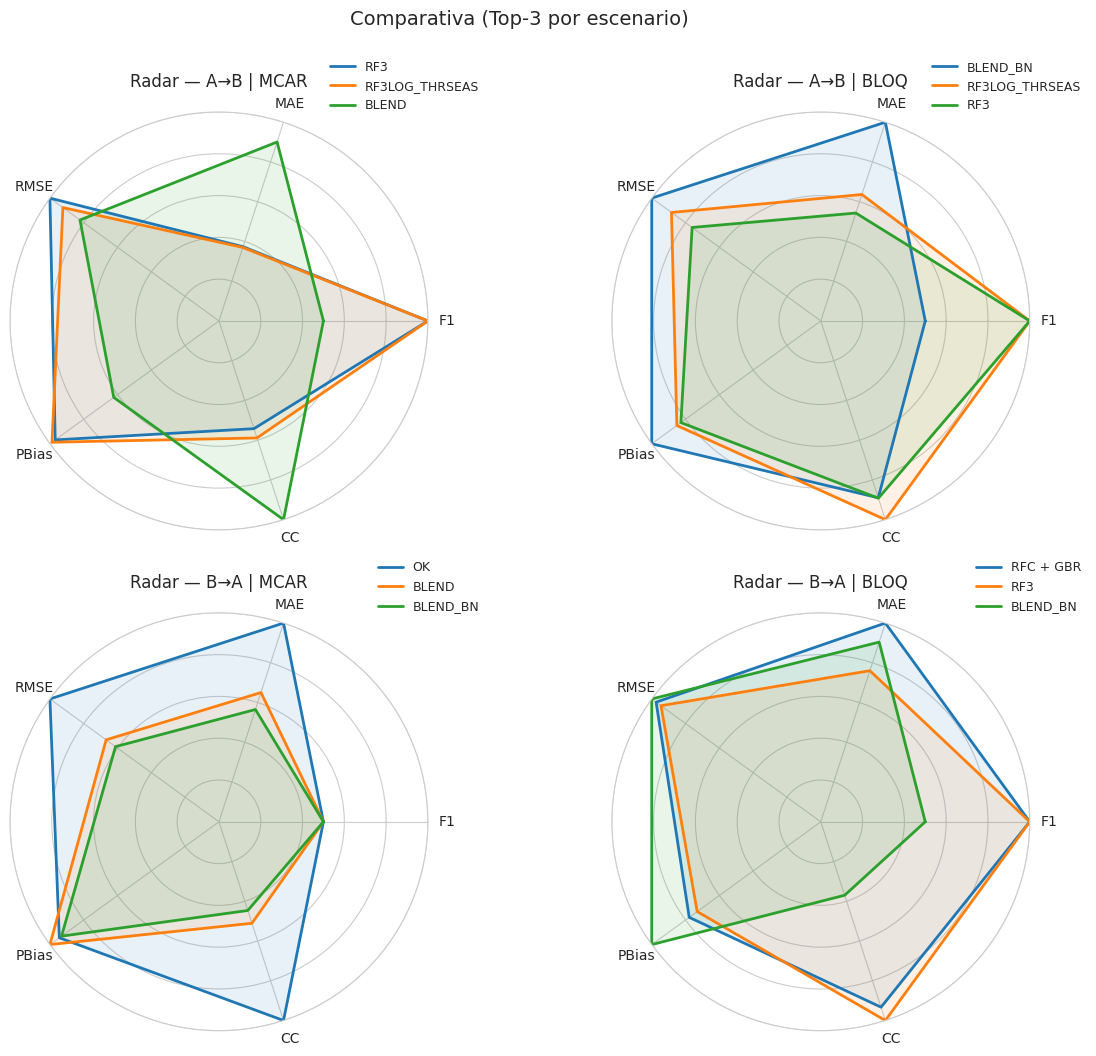

In [160]:
plot_radars_grid_top3(df_all, save_png=False)

# RF con 6 vecinas

Se decidio probar si agregar las 6 vecinas relevantes en lugar de 3 mejoraria al Random Forest de Regresion.

Verificar variables y agregar coordenadas

In [ ]:

activar = False  #@param {type:"boolean"}

if activar:
    print("Solo corre si activas el checkbox")
# === Parámetros mínimos ===
WET_THR = 0.2  # mm
TARGET = 19052

# === 1) Chequeos básicos (SIN tocar records_eda) ===
assert 'records_eda' in globals(), "No encuentro records_eda en la sesión."
df_rf_6 = records_eda.copy()
# records_modelo = df_rf_6.copy()

need_cols = {'FECHA','Clave','PRECIP','TMAX','TMIN'}
missing = need_cols - set(df_rf_6.columns)
if missing:
    raise RuntimeError(f"Faltan columnas mínimas en records_eda: {sorted(missing)}")

# Tipos
df_rf_6['FECHA'] = pd.to_datetime(df_rf_6['FECHA'], errors='coerce')
df_rf_6['Clave'] = df_rf_6['Clave'].astype(int)

# Duplicados
dups = df_rf_6.duplicated(subset=['Clave','FECHA']).sum()
print(f"Duplicados (Clave,FECHA) = {dups}")

# Cobertura temporal por estación
print("\nRango temporal por estación:")
print(df_rf_6.groupby('Clave')['FECHA'].agg(['min','max','count']))

# Presencia de target
if TARGET not in df_rf_6['Clave'].unique():
    raise RuntimeError(f"La estación TARGET {TARGET} no está en records_eda.")

# === 2) Añadir lat/lon  ===
if not {'lat','lon'}.issubset(df_rf_6.columns):
    assert 'stations_df' in globals(), "No encuentro stations_df para anexar lat/lon."
    sd = stations_df[['Clave','lat','lon']].drop_duplicates().copy()
    sd['Clave'] = sd['Clave'].astype(int)
    before = df_rf_6.shape[1]
    df_rf_6 = df_rf_6.merge(sd, on='Clave', how='left')
    print(f"\nCoords añadidas: columnas {before} → {df_rf_6.shape[1]}")

# === 3) Bandera wet (binaria) y MES, sin sesgos por NaN ===
created = []
if 'wet' not in df_rf_6.columns:
    wet = np.where(
        df_rf_6['PRECIP'].notna() & (df_rf_6['PRECIP'] >= float(WET_THR)), 1,
        np.where(df_rf_6['PRECIP'].notna(), 0, np.nan)
    )
    df_rf_6['wet'] = pd.Series(wet, index=df_rf_6.index, dtype='Int8')  # 0/1/<NA>
    created.append('wet')

if 'MES' not in df_rf_6.columns:
    df_rf_6['MES'] = df_rf_6['FECHA'].dt.month.astype('Int8')
    created.append('MES')

if created:
    print("\nColumnas creadas:", created)
else:
    print("\nNo fue necesario crear columnas adicionales.")

# === 4) Resúmenes rápidos ===
print("\nWet rate por estación (solo días observados, dropna):")
wet_rate_obs = (
    df_rf_6.groupby('Clave', as_index=True)['wet']
           .apply(lambda s: s.dropna().mean())
           .round(3)
)
print(wet_rate_obs)

print("\nWet rate por estación (tratando faltantes como NO-lluvia):")
wet_rate_na_as_dry = (
    df_rf_6.groupby('Clave')['wet']
           .apply(lambda s: s.fillna(0).mean())
           .round(3)
)
print(wet_rate_na_as_dry)

# Target específico
wr_obs_target = df_rf_6.loc[df_rf_6['Clave']==TARGET, 'wet'].dropna().mean()
wr_na0_target  = df_rf_6.loc[df_rf_6['Clave']==TARGET, 'wet'].fillna(0).mean()
print(f"\nTARGET {TARGET} — wet_rate observado-only: {wr_obs_target:.3f}  |  con NaN→0: {wr_na0_target:.3f}")

print("\nColumnas finales:")
print(sorted(df_rf_6.columns.tolist()))

print("\n Verificación lista. ")


cortar a partir de 1982

In [ ]:

activar = False  #@param {type:"boolean"}

if activar:
    print("Solo corre si activas el checkbox")
# A. Ventana de trabajo (post-1982) para TODAS las estaciones
import pandas as pd
CUT_START = pd.Timestamp("1982-01-01")

assert 'df_rf_6' in globals(), "No encuentro df_rf_6 en la sesión."
df_rf_6 = df_rf_6[df_rf_6["FECHA"] >= CUT_START].copy()

print("Ventana de trabajo:", df_rf_6["FECHA"].min(), "→", df_rf_6["FECHA"].max())
print("Estaciones en df_rf_6 (post-1982):", sorted(df_rf_6["Clave"].unique().tolist()))


Generar variables predictoras

In [ ]:

activar = False  #@param {type:"boolean"}

if activar:
    print("Solo corre si activas el checkbox")
assert 'df_rf_6' in globals(), "No encuentro df_rf_6 (copia de records_eda)."
TARGET = 19052

# 2.0 Vecinas: tomar TODAS las estaciones en df_rf_6 excepto TARGET
all_ids = sorted(df_rf_6['Clave'].unique().tolist())
neighbor_ids = [i for i in all_ids if i != TARGET]
print("TARGET:", TARGET)
print("Vecinas en df_rf_6:", neighbor_ids)

# 2.1 Features locales del TARGET (sin fuga)
def make_local_features(df_in, target):
    d = df_in.copy().sort_values(['Clave','FECHA'])
    # lags y rollings "closed=left" (usando shift(1)) → SIN FUGA
    for c in ['PRECIP','TMAX','TMIN']:
        d[f'{c}_lag1'] = d.groupby('Clave')[c].shift(1)
    d['PRECIP_lag2']  = d.groupby('Clave')['PRECIP'].shift(2)
    d['PRECIP_roll3'] = (d.groupby('Clave')['PRECIP'].shift(1)
                           .rolling(3).sum().reset_index(0, drop=True))
    d['PRECIP_roll7'] = (d.groupby('Clave')['PRECIP'].shift(1)
                           .rolling(7).sum().reset_index(0, drop=True))
    # estacionalidad
    m = d['MES'].astype(float)
    d['sinMES'] = np.sin(2*np.pi*m/12)
    d['cosMES'] = np.cos(2*np.pi*m/12)
    # quedarnos solo con el TARGET
    return d[d['Clave'] == target].copy()

df_target_rf_6 = make_local_features(df_rf_6, TARGET)

# 2.2 Features de vecinas alineadas por fecha (niveles del día t)
base_cols = ['FECHA','Clave','PRECIP','TMAX','TMIN']
wide = df_rf_6[base_cols].pivot(index='FECHA', columns='Clave')  # columnas MultiIndex (var, clave)

for rank, nid in enumerate(neighbor_ids, start=1):
    for var in ['PRECIP','TMAX','TMIN']:
        df_target_rf_6[f'{var}_nei{rank}'] = wide[(var, nid)].reindex(df_target_rf_6['FECHA']).values

# 2.3 Selección de columnas finales
feature_cols = [
    # locales
    'PRECIP_lag1','PRECIP_lag2','PRECIP_roll3','PRECIP_roll7',
    'TMAX_lag1','TMIN_lag1','sinMES','cosMES',
]
# agregar vecinas (todas las presentes en df_rf_6)
for rank in range(1, len(neighbor_ids) + 1):
    feature_cols += [f'PRECIP_nei{rank}', f'TMAX_nei{rank}', f'TMIN_nei{rank}']

y_clsrf6 = 'wet'       # ocurrencia (0/1/<NA>) — usaremos dropna() al entrenar/evaluar
y_regrf6 = 'PRECIP'    # monto condicionado

print("n vecinas:", len(neighbor_ids))
print("N features:", len(feature_cols))
print("Filas TARGET (df_target_rf_6):", df_target_rf_6.shape[0])
print("Primeras features:", feature_cols[:10])


Fold Temporal

In [ ]:

activar = False  #@param {type:"boolean"}

if activar:
    print("Solo corre si activas el checkbox")
(A_train_rf6, B_test_rf6), (B_train_rf6, A_test_rf6) = temporal_folds_with_embargo(
    df_target_rf_6, CUTOFF, EMBARGO_DAYS
)

print("Fold A→B (rf6):", A_train_rf6['FECHA'].min(), "→", A_train_rf6['FECHA'].max(),
      "||", B_test_rf6['FECHA'].min(), "→", B_test_rf6['FECHA'].max())
print("Fold B→A (rf6):", B_train_rf6['FECHA'].min(), "→", B_train_rf6['FECHA'].max(),
      "||", A_test_rf6['FECHA'].min(), "→", A_test_rf6['FECHA'].max())


mascara aleatoria

In [ ]:

activar = False  #@param {type:"boolean"}

if activar:
    print("Solo corre si activas el checkbox")
mcar_A_rf6 = mcar_mask_index(B_test_rf6, frac=0.15, seed=202)  # para fold A→B
mcar_B_rf6 = mcar_mask_index(A_test_rf6, frac=0.15, seed=303)  # para fold B→A

print("MCAR sizes (rf6) → A:", len(mcar_A_rf6), "| B:", len(mcar_B_rf6))


mascara bloque 30 dias

In [ ]:

activar = False  #@param {type:"boolean"}

if activar:
    print("Solo corre si activas el checkbox")
# Aplica a ambos TEST usando _rf6
idx_A_rf6, rng_A_rf6 = september_block_mask(B_test_rf6, length_days=30)  # fold A→B
idx_B_rf6, rng_B_rf6 = september_block_mask(A_test_rf6, length_days=30)  # fold B→A

# Prints seguros aunque no haya rango (rng_* = None)
if rng_A_rf6 is not None:
    ba_s_rf6, ba_e_rf6 = rng_A_rf6
    print(f"BLOQUE A→B (rf6): {ba_s_rf6.date()} → {ba_e_rf6.date()} | idx={len(idx_A_rf6)}")
else:
    print(f"BLOQUE A→B (rf6): sin septiembre o split vacío | idx={len(idx_A_rf6)}")

if rng_B_rf6 is not None:
    bb_s_rf6, bb_e_rf6 = rng_B_rf6
    print(f"BLOQUE B→A (rf6): {bb_s_rf6.date()} → {bb_e_rf6.date()} | idx={len(idx_B_rf6)}")
else:
    print(f"BLOQUE B→A (rf6): sin septiembre o split vacío | idx={len(idx_B_rf6)}")

# (Opcional) proporción del TEST con verdad cubierta por el bloque
prop_A_rf6 = len(idx_A_rf6) / max(1, B_test_rf6['PRECIP'].notna().sum())
prop_B_rf6 = len(idx_B_rf6) / max(1, A_test_rf6['PRECIP'].notna().sum())
print(f"Proporción TEST cubierta (verdad) — A→B (rf6): {prop_A_rf6:.3f} | B→A (rf6): {prop_B_rf6:.3f}")


optimizar random search

In [ ]:

activar = False  #@param {type:"boolean"}

if activar:
    print("Solo corre si activas el checkbox")
# Ejecuta RS con el fold A→B (rf6)
rs_clf_rf6 = randomized_search_clf(A_train_rf6, B_test_rf6, feature_cols, n_iter=20)
rs_reg_rf6 = randomized_search_reg(A_train_rf6, B_test_rf6, feature_cols, n_iter=20)

print("CLF top-3 (A→B, rf6):");  [print(r) for r in rs_clf_rf6[:3]]
print("\nREG top-3 (A→B, rf6):"); [print(r) for r in rs_reg_rf6[:3]]


grid search


In [ ]:

activar = False  #@param {type:"boolean"}

if activar:
    print("Solo corre si activas el checkbox")
# Toma los mejores params de las búsquedas aleatorias (rf6)
assert len(rs_clf_rf6) > 0 and len(rs_reg_rf6) > 0, "RS vacío: revisa rs_clf_rf6 / rs_reg_rf6"
best_clf_params_rf6 = rs_clf_rf6[0]["params"]
best_reg_params_rf6 = rs_reg_rf6[0]["params"]

# Ejecuta Grid Search local con los splits rf6
gs_clf_rf6 = grid_search_clf(A_train_rf6, B_test_rf6, feature_cols, best_clf_params_rf6)
gs_reg_rf6 = grid_search_reg(A_train_rf6, B_test_rf6, feature_cols, best_reg_params_rf6)

print("GRID CLF top-3 (rf6):");  [print(r) for r in gs_clf_rf6[:3]]
print("\nGRID REG top-3 (rf6):"); [print(r) for r in gs_reg_rf6[:3]]

# Parámetros finales elegidos (rf6)
theta_star_rf6 = {
    "clf": {"params": gs_clf_rf6[0]["params"], "thr": gs_clf_rf6[0]["thr"], "F1": gs_clf_rf6[0]["F1"]},
    "reg": {"params": gs_reg_rf6[0]["params"], "MAE": gs_reg_rf6[0]["MAE"], "RMSE": gs_reg_rf6[0]["RMSE"]},
}


Evaluar 4 escenarios con RF y 6 vecinas

In [ ]:

activar = False  #@param {type:"boolean"}

if activar:
    print("Solo corre si activas el checkbox")
# Ejecuta evaluación con θ* (rf6), re-optimizando el umbral por TEST
# Asumiendo que ya tienes:
# - theta_star_rf6 (de tu GS)
# - A_train_rf6, B_test_rf6, B_train_rf6, A_test_rf6
# - mcar_A_rf6, mcar_B_rf6
# - idx_A_rf6, idx_B_rf6  (bloques de septiembre como sets de índices)

metrics_AB_MCAR_rf6  = fit_eval_with_params_imputed(
    A_train_rf6, B_test_rf6, feature_cols,
    theta_star_rf6["clf"]["params"], theta_star_rf6["reg"]["params"],
    restrict_idx=mcar_A_rf6
)
metrics_AB_BLOCK_rf6 = fit_eval_with_params_imputed(
    A_train_rf6, B_test_rf6, feature_cols,
    theta_star_rf6["clf"]["params"], theta_star_rf6["reg"]["params"],
    restrict_idx=idx_A_rf6     # tu set del bloque de septiembre en B_test_rf6
)
metrics_BA_MCAR_rf6  = fit_eval_with_params_imputed(
    B_train_rf6, A_test_rf6, feature_cols,
    theta_star_rf6["clf"]["params"], theta_star_rf6["reg"]["params"],
    restrict_idx=mcar_B_rf6
)
metrics_BA_BLOCK_rf6 = fit_eval_with_params_imputed(
    B_train_rf6, A_test_rf6, feature_cols,
    theta_star_rf6["clf"]["params"], theta_star_rf6["reg"]["params"],
    restrict_idx=idx_B_rf6     # tu set del bloque de septiembre en A_test_rf6
)

print("A→B (rf6) | MCAR :", metrics_AB_MCAR_rf6)
print("A→B (rf6) | BLOQ :", metrics_AB_BLOCK_rf6)
print("B→A (rf6) | MCAR :", metrics_BA_MCAR_rf6)
print("B→A (rf6) | BLOQ :", metrics_BA_BLOCK_rf6)


In [ ]:

activar = False  #@param {type:"boolean"}

if activar:
    print("Solo corre si activas el checkbox")
#comparacion RF 3 vecinas vs Krigging  vs RF 6 vecinas
import numpy as np
import pandas as pd

f = lambda x: (float(x) if x is not None else np.nan)

SC = {
    "A→B | MCAR": {"rf3": metrics_AB_MCAR,       "ok": ok_AB_MCAR,       "rf6": metrics_AB_MCAR_rf6},
    "A→B | BLOQ": {"rf3": metrics_AB_BLOCK,      "ok": ok_AB_BLOCK,      "rf6": metrics_AB_BLOCK_rf6},
    "B→A | MCAR": {"rf3": metrics_BA_MCAR,       "ok": ok_BA_MCAR,       "rf6": metrics_BA_MCAR_rf6},
    "B→A | BLOQ": {"rf3": metrics_BA_BLOCK,      "ok": ok_BA_BLOCK,      "rf6": metrics_BA_BLOCK_rf6},
}

rows = []
for name, d in SC.items():
    m_rf3, m_ok, m_rf6 = d["rf3"], d["ok"], d["rf6"]
    rows.append({
        "Escenario": name,
        # RF3
        "F1_RF3":    f(m_rf3.get("F1")),
        "MAE_RF3":   f(m_rf3.get("MAE")),  "RMSE_RF3": f(m_rf3.get("RMSE")),
        "PBias_RF3": f(m_rf3.get("PBias")),"CC_RF3":   f(m_rf3.get("CC")),
        # Kriging (OK)
        "MAE_OK":   f(m_ok.get("MAE")),   "RMSE_OK":  f(m_ok.get("RMSE")),
        "PBias_OK": f(m_ok.get("PBias")), "CC_OK":    f(m_ok.get("CC")),
        "n_OK":     int(m_ok.get("n", np.nan)) if m_ok.get("n", None) is not None else np.nan,
        # RF6
        "F1_RF6":    f(m_rf6.get("F1")),
        "MAE_RF6":   f(m_rf6.get("MAE")), "RMSE_RF6": f(m_rf6.get("RMSE")),
        "PBias_RF6": f(m_rf6.get("PBias")),"CC_RF6":  f(m_rf6.get("CC")),
    })

cols = ["Escenario",
        "F1_RF3","MAE_RF3","RMSE_RF3","PBias_RF3","CC_RF3",
        "MAE_OK","RMSE_OK","PBias_OK","CC_OK","n_OK",
        "F1_RF6","MAE_RF6","RMSE_RF6","PBias_RF6","CC_RF6"]

df_models = pd.DataFrame(rows)[cols].round(3)

pd.set_option("display.max_columns", 1000)
pd.set_option("display.width", 10_000)
print(df_models.to_string(index=False))
# (opcional)
# print(df_models.to_markdown(index=False))
# df_models.to_csv("metricas_RF3_OK_RF6.csv", index=False)


RF3 es con 3 vecinas filtrando por disponibildad. RF6 es con 6 vecinas

Al comparar RF3 y RF6, se observó que ambos modelos obtuvieron resultados similares en ocurrencia; sin embargo, RF3 presentó menor sesgo, mejor estabilidad y correlaciones más consistentes, destacándose especialmente bajo escenarios de bloqueo temporal. Por ello, RF3 se considera globalmente más robusto.